In [1]:
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(ggformula))
library(tibble)
suppressPackageStartupMessages(library(glue))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(modelr))
library(stringr)
library(tidyr)

In [2]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [3]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

Set as many cores as we got

In [4]:
options(mc.cores = parallel::detectCores())

# Graphing binary data and logistic regression

Reproduce Figure 14.1 with the model, $ {\rm Pr}(y = 1) = {\rm logit}^{-1}(0.4 - 0.3 x)$, with 50 data points $x$ sampled uniformly in the range $[A, B]$.
(In Figure 14.1 the $x$'s were drawn from a normal distribution.)
Choose values $A$ and $B$ so that the plot includes a zone where the values of $y$ are all 1, a zone where they are all 0, and a band of overlap in the middle.

The inverse logit is very close 1/0 at +/-5
Since the coefficient of x is negative it will have high probability at low value (near A) and low probability at high value (near B).

So we want 0.4 - 0.3 A = 5 and so 

In [5]:
(A <- (5 - 0.4) / (-0.3))

[1] -15.33333

And we want 0.4 - 0.3 B = -5, and so

In [6]:
(B <- (-5 - 0.4) / (-0.3))

[1] 18

In [7]:
x <- runif(50, A, B)
ps <- invlogit(0.4 - 0.3 * x)

y <- rbinom(50, 1, p=ps)

fake_data = data.frame(x,y)

In [8]:
model <- stan_glm(y ~ x, family=binomial(link="logit"), data=fake_data, refresh=0)

In [9]:
library(tidyr)

In [10]:
curve_data <- data.frame(x=seq(A,B,by=0.01)) %>%
mutate(`Fitted Curve` = predict(model, newdata=., type="response"),
       `True Curve` = invlogit(0.4 - 0.3 * x))  %>%
pivot_longer(c(-x), values_to="y") %>%
mutate(name=forcats::fct_rev(name))

Here's something close to 14.1 a

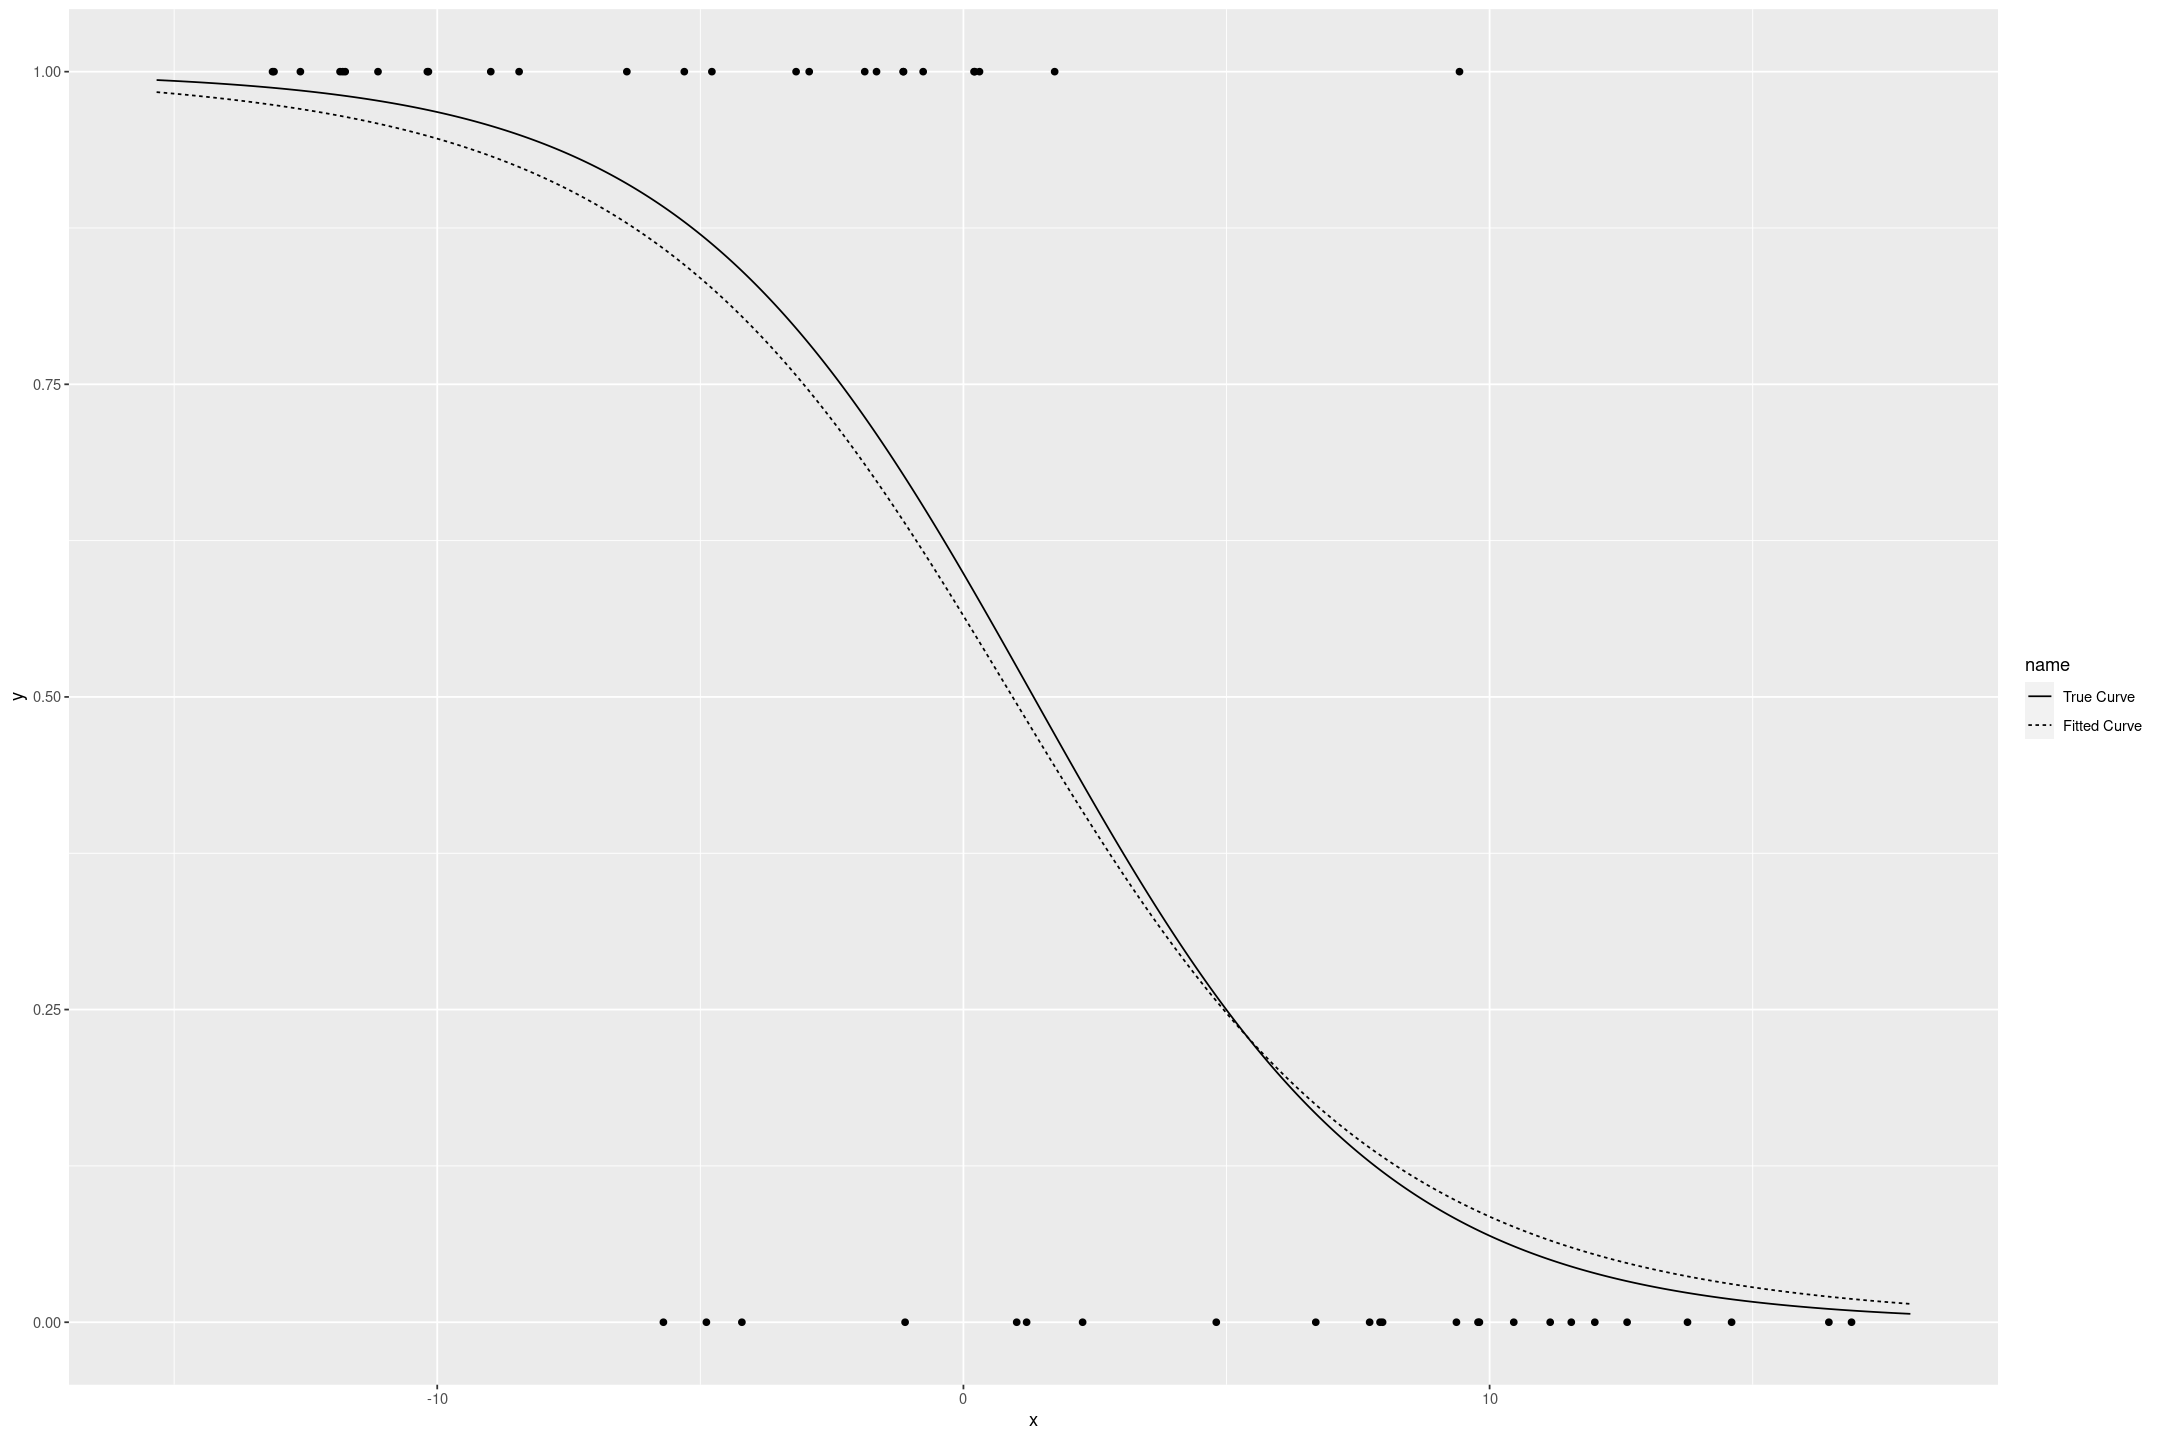

In [11]:
fake_data %>%
gf_point(y ~ x) %>%
gf_line(y ~ x, group=~name, linetype=~name, data=curve_data)

Here's something close to 14.1 b

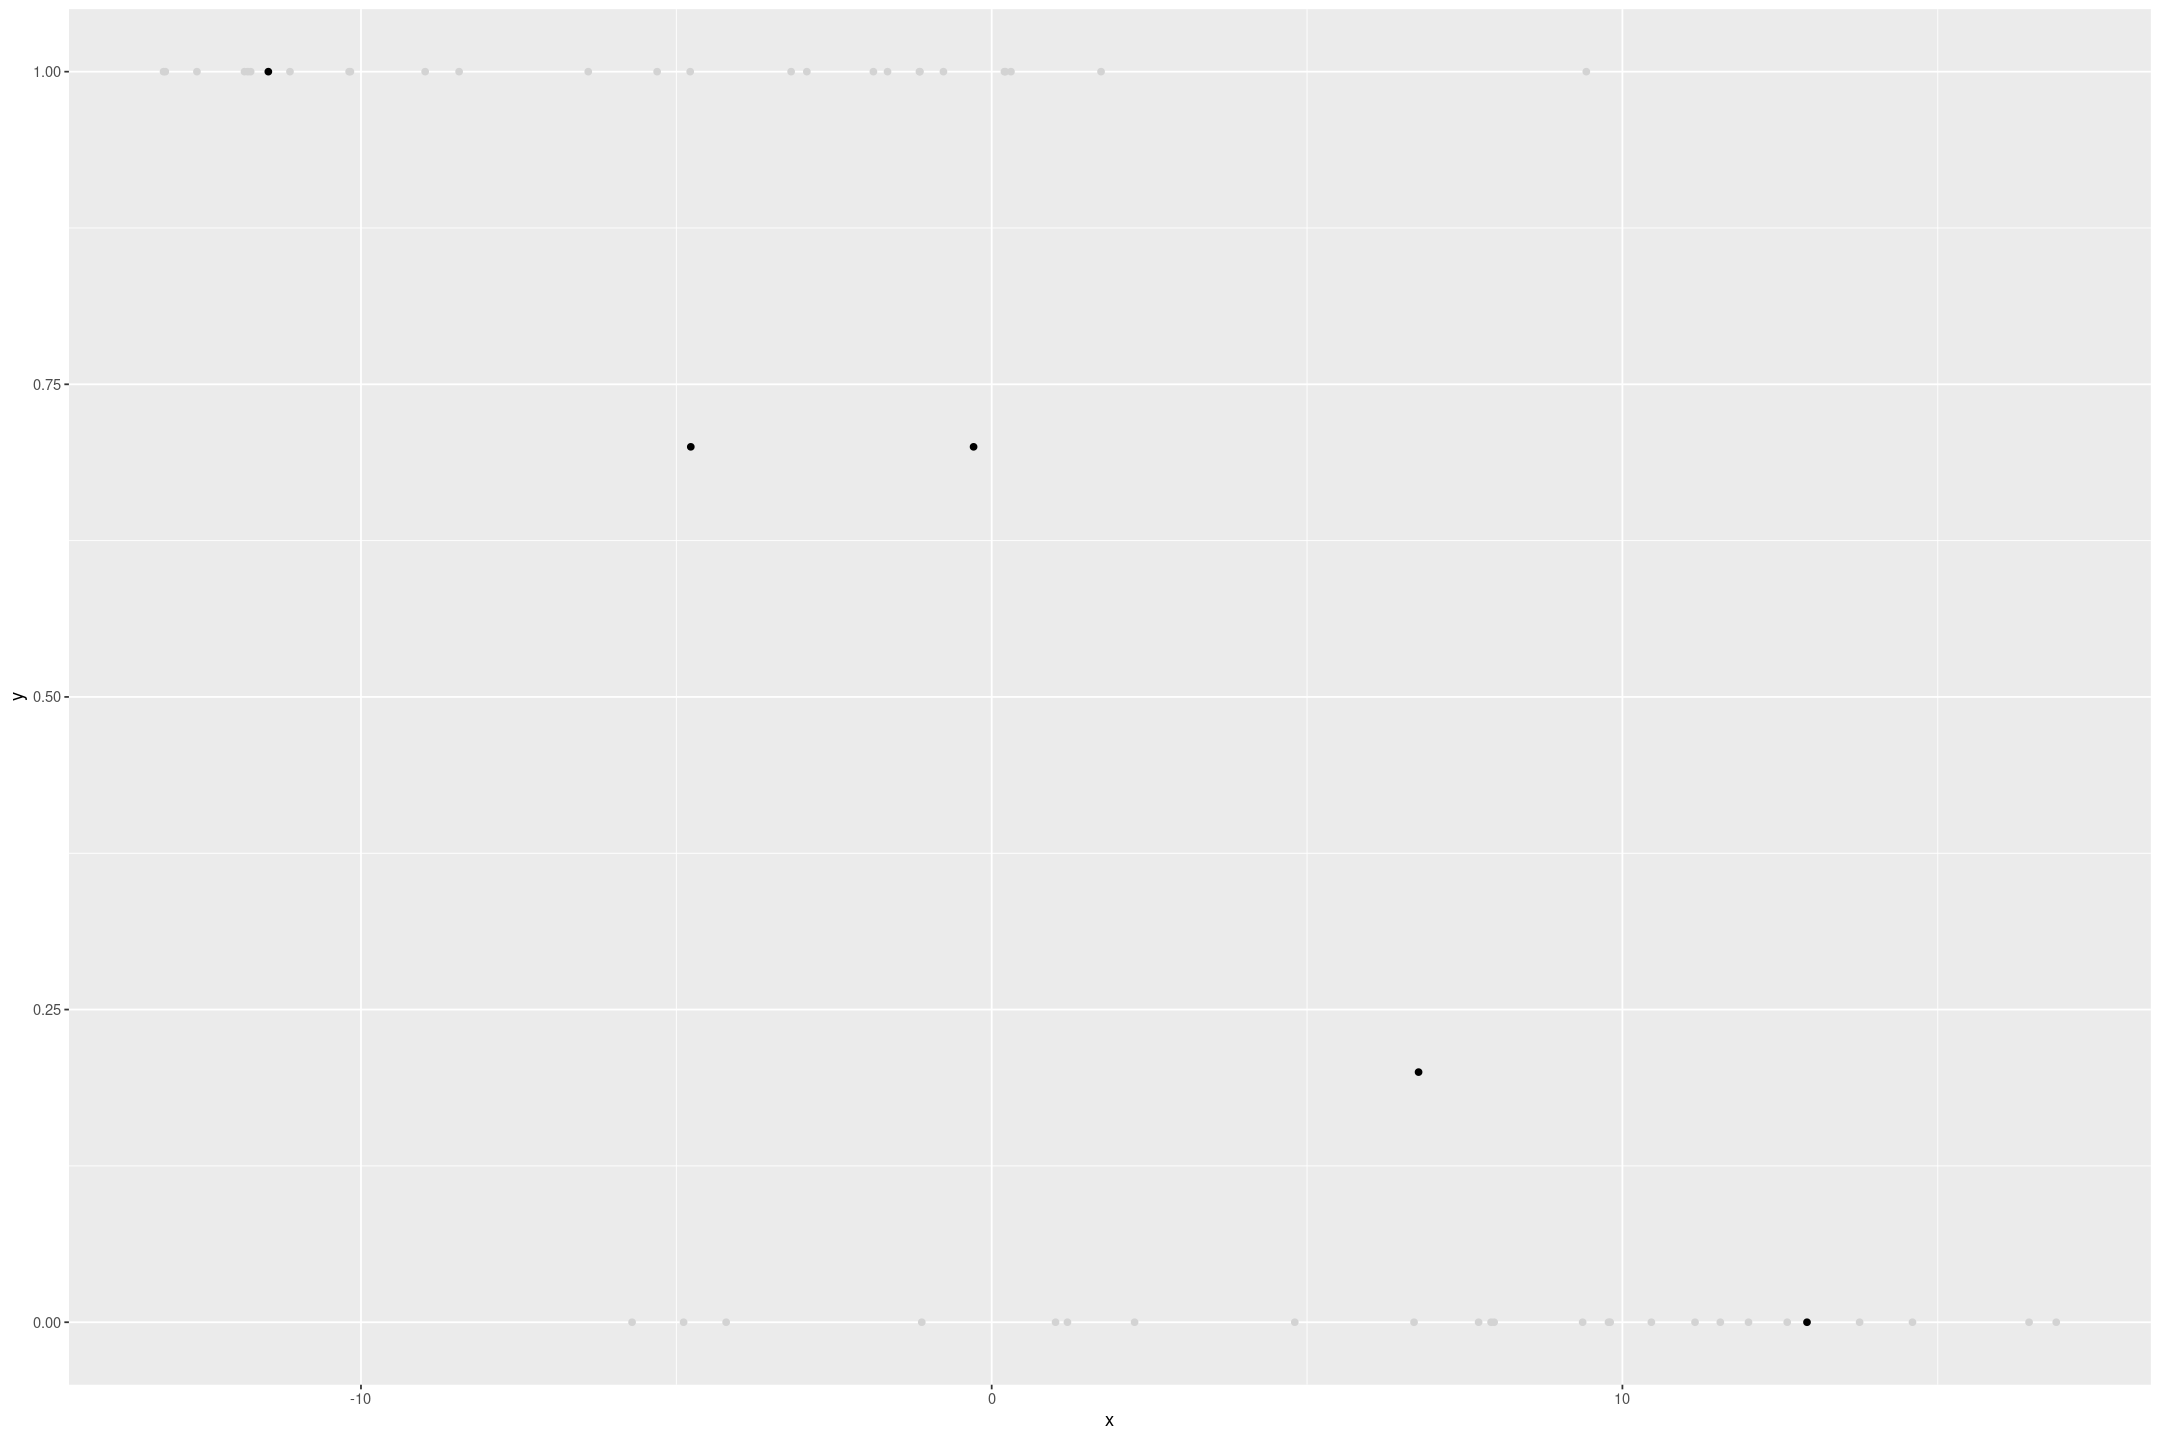

In [12]:
n_bin <- 5

fake_data %>%
mutate(bin = cut(x, quantile(x, seq(0, 1, length.out=n_bin+1)), include.lowest=TRUE)) %>%
group_by(bin) %>%
summarise(x = mean(x), y = mean(y)) %>%
gf_point(y ~ x) %>%
gf_point(y ~ x, data=fake_data, colour="lightgrey")

# Logistic regression and discrimination lines

Reproduce Figure 14.2 with the model, ${\rm Pr}(y = 1) = {\rm logit}^{-1}(0.4 - 0.3 x_1 + 0.2 x_2)$, with $(x_1,x_2)$ sampled uniformly from the rectangle $[A_1, B_1] \times [A_2, B_2]$.
Choose the values $A_1, B_1, A_2, B_2$ so that the plot includes a zone where the values of $y$ are all 1, a zone where they are all 0, and a band of overlap in the middle, and with the three lines corresponding to ${\rm Pr}(y=1) = 0.1$, $0.5$ and $0.9$ are all visible.

Consider a rotation of the coordinates to make the change along the x-axis

$$ R_{\theta} x= \begin{bmatrix}
\cos \theta & -\sin \theta \\  
\sin \theta & \cos \theta 
\end{bmatrix} 
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
\ = \ 
\begin{bmatrix} 
x_1\cos\theta-x_2\sin\theta \\
x_1\sin\theta+x_2\cos\theta
\end{bmatrix}.$$

In our case we want to transform $ -0.3 x_1 + 0.2 x_2 = 0.36 (\cos(2.55) x_1 + \sin(2.55) x_2)$

In [13]:
(theta <- atan2(0.2, -0.3))

[1] 2.55359

In [14]:
(r <- sqrt(0.3^2 + 0.2^2))

[1] 0.3605551

So setting $ u = R_{2.55} x $ then $ {\rm Pr}(y = 1) = {\rm logit}^{-1}(0.4 + 0.36 u_2) $

As before we want to reach +/- 5 and so $u_2$ goes between -15 and 13.

In [15]:
(U <- c((-5-0.4)/r, (5-0.4)/r))

[1] -14.97691  12.75810

The probability doesn't change with $u_1$ so let's make it square

In [16]:
(B = U[1] * c(cos(-theta) - sin(-theta), cos(-theta) + sin(-theta)))

[1]  4.153846 20.769231

In [17]:
(A = 13 * c(cos(-theta) - sin(-theta), cos(-theta) + sin(-theta)))

[1]  -3.605551 -18.027756

In [18]:
n <- 100

x1 <- runif(n, A[1], B[1])
x2 <- runif(n, A[2], B[2])

p <- invlogit(0.4 - 0.3 * x1 + 0.2 * x2)
y <- as.logical(rbinom(n, 1, p))

fake_data <- data.frame(x1, x2, y)

The lines of constant probability are where $$ 0.4 - 0.3 x_1 + 0.2 x_2 = {\rm logit}(p) $$

Or eqivalentlty:

$$ x_2 = 5 {\rm logit}(p) - 2 + 1.5 x_1 $$

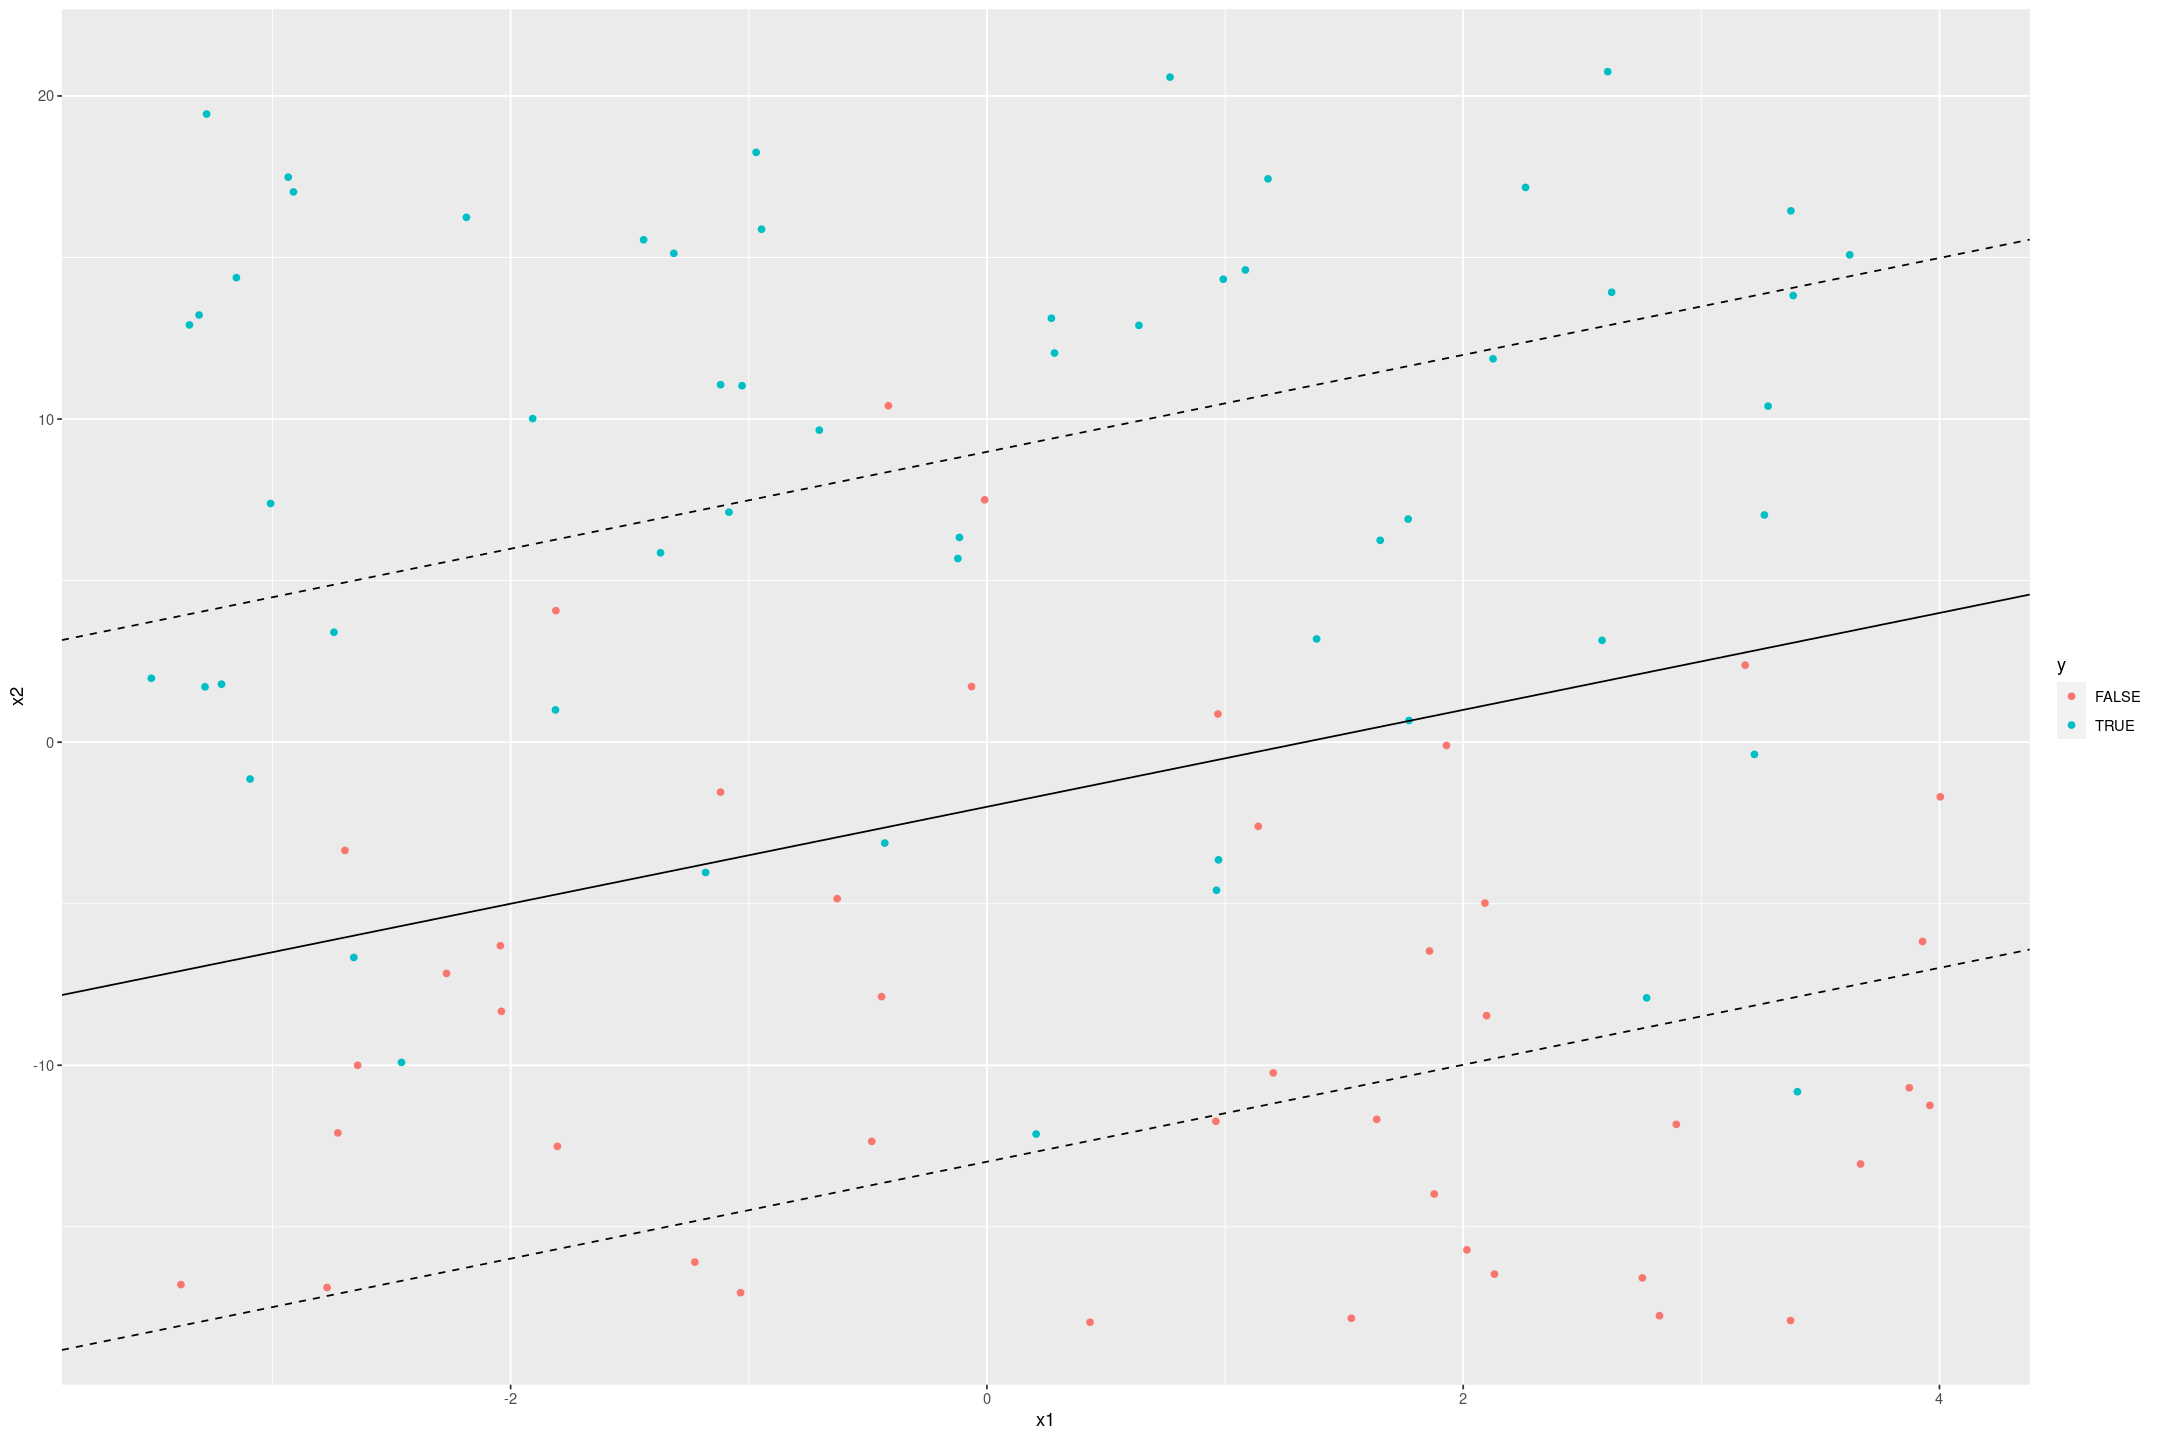

In [19]:
fake_data %>%
gf_point(x2 ~ x1, col=~y) %>%
gf_abline(intercept=~5 * logit(0.5) - 2, slope=~1.5) %>%
gf_abline(intercept=~5 * logit(0.9) - 2, slope=~1.5, linetype="dashed") %>%
gf_abline(intercept=~5 * logit(0.1) - 2, slope=~1.5, linetype="dashed")

# Graphing logistic regressions

The well-switching data described in Section 13.7 are in the folder `Arsenic`.

In [20]:
filename <- "./data/Arsenic/wells.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Arsenic/data/wells.csv')

wells <- read.csv(filename)

## Switching probability with log distance

Fit a logistic regression for the probability of switching using log(distance to the nearest safe well) as a predictor.

In [21]:
fit_wells_log_dist <- stan_glm(switch ~ log(dist100), family=binomial(link="logit"), data=wells, refresh=0)

In [22]:
fit_wells_log_dist

stan_glm
 family:       binomial [logit]
 formula:      switch ~ log(dist100)
 observations: 3020
 predictors:   2
------
             Median MAD_SD
(Intercept)   0.1    0.1  
log(dist100) -0.2    0.0  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

## Plotting model predictions

Make a graph similar to Figure 13.8b displaying Pr(switch) as a function of distance to nearest safe well, along with the data.

In [23]:
max(wells$dist100)

[1] 3.39531

In [24]:
dist_df <- data.frame(dist100=seq(0, 4, by=0.01)) %>%
mutate(switch = predict(fit_wells_log_dist, newdata=., type="response"))

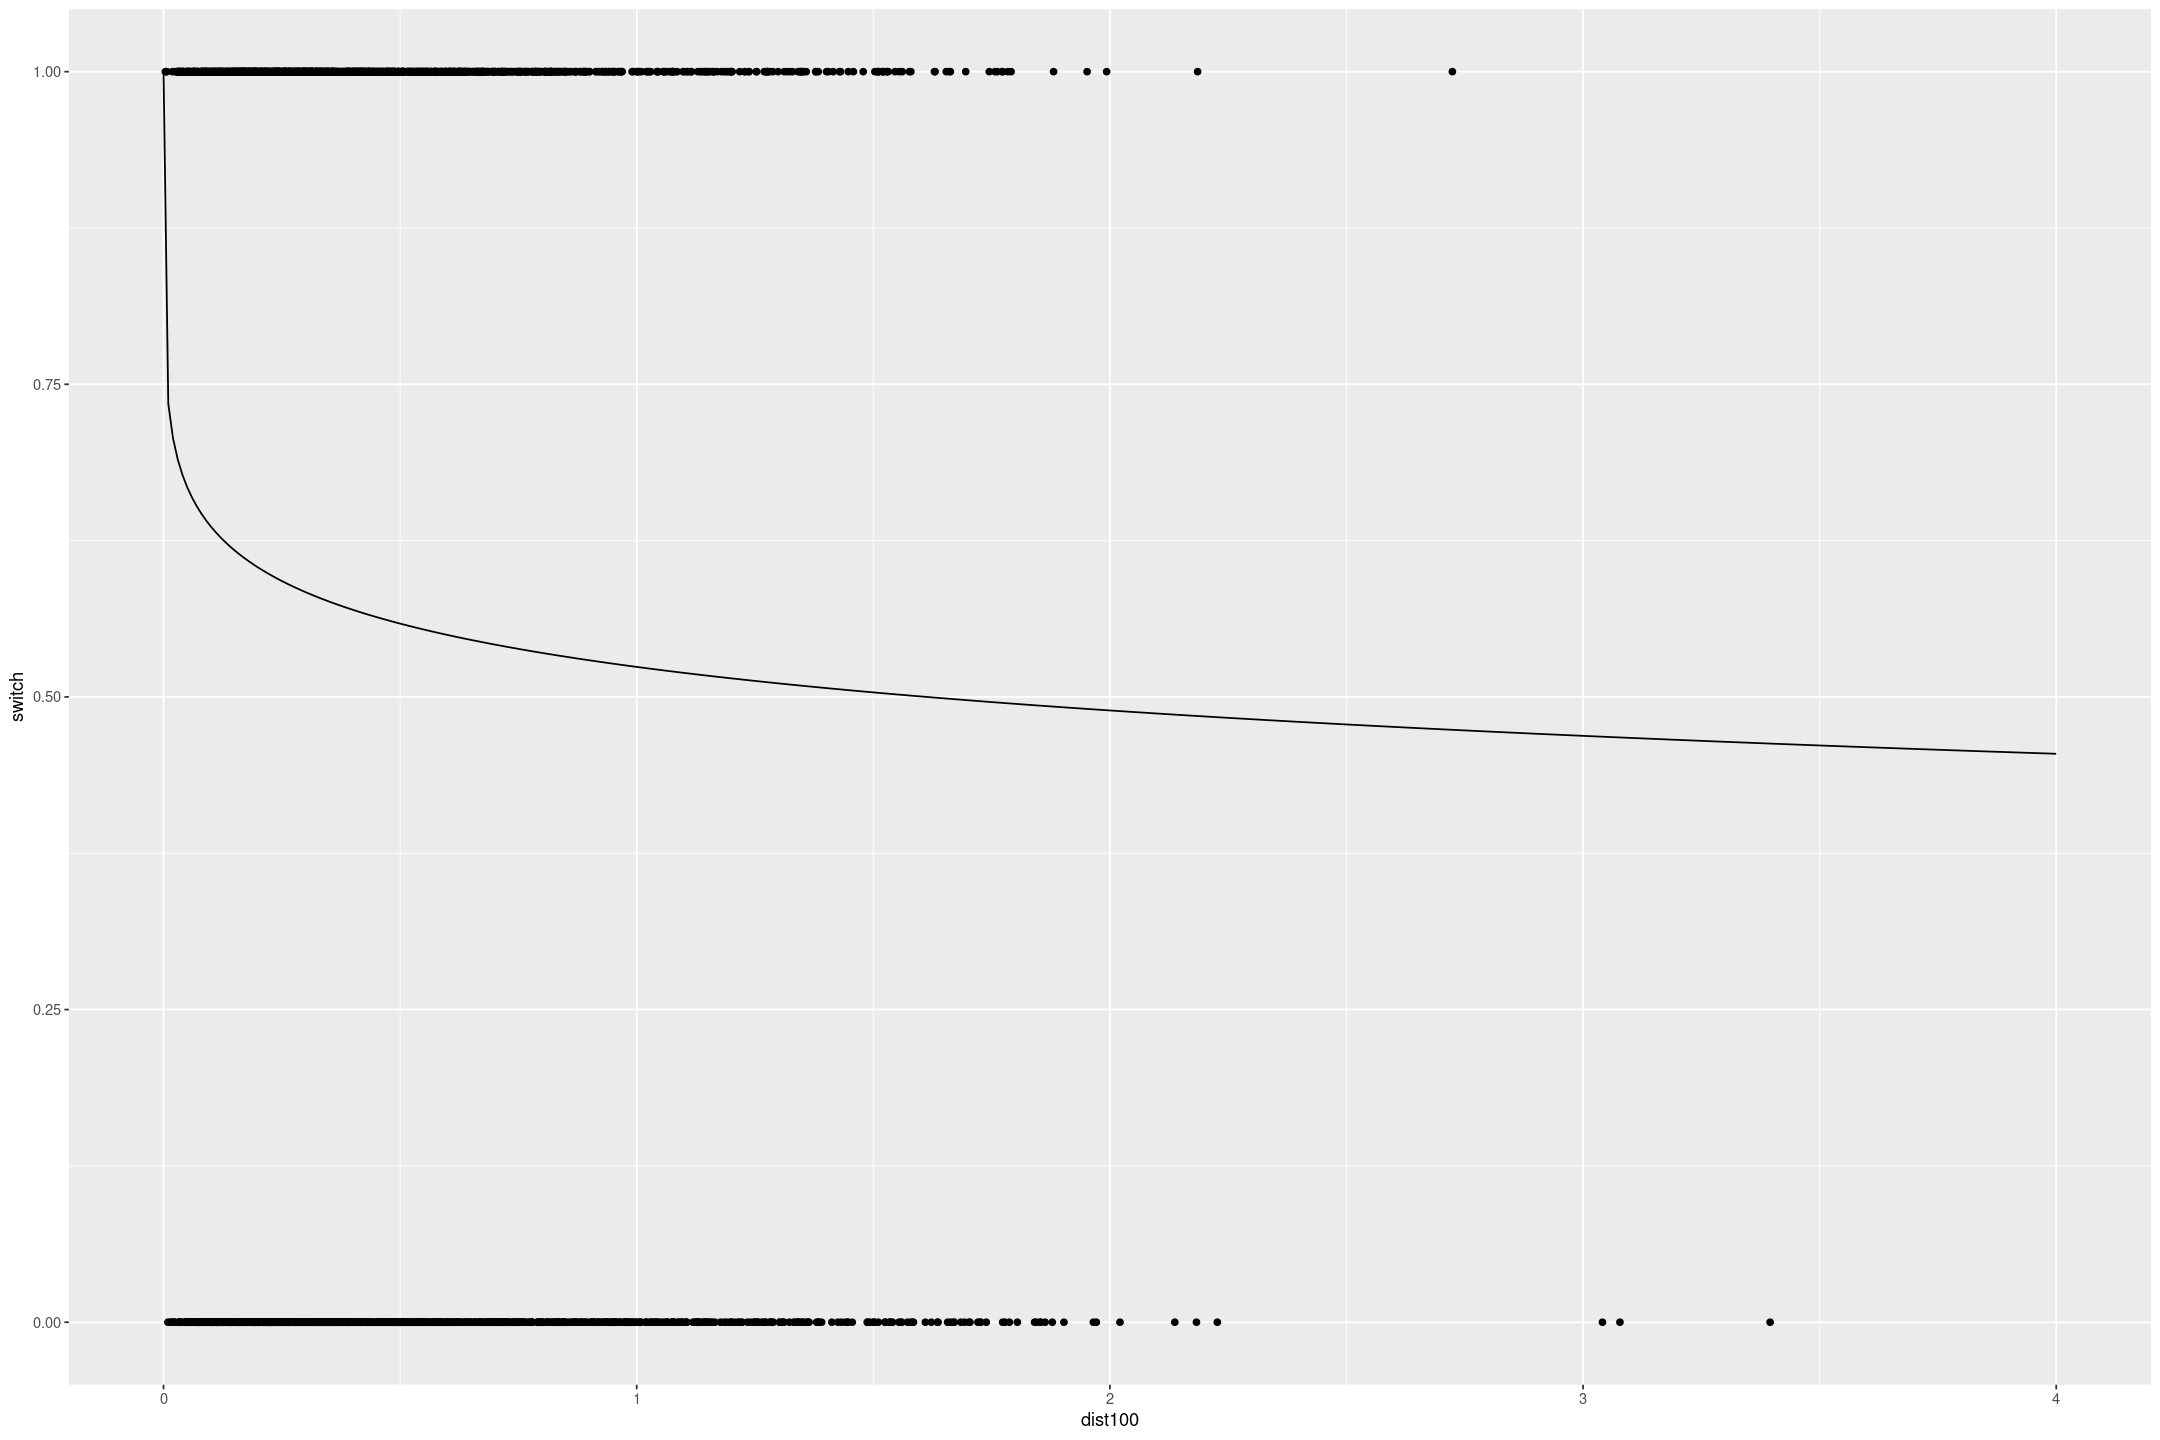

In [25]:
dist_df %>%
gf_line(switch ~ dist100) %>%
gf_point(data=wells)

## Residual Plots

Make a residual plot and binned residual plot as in Figure 14.8

The residual plot isn't very informative.

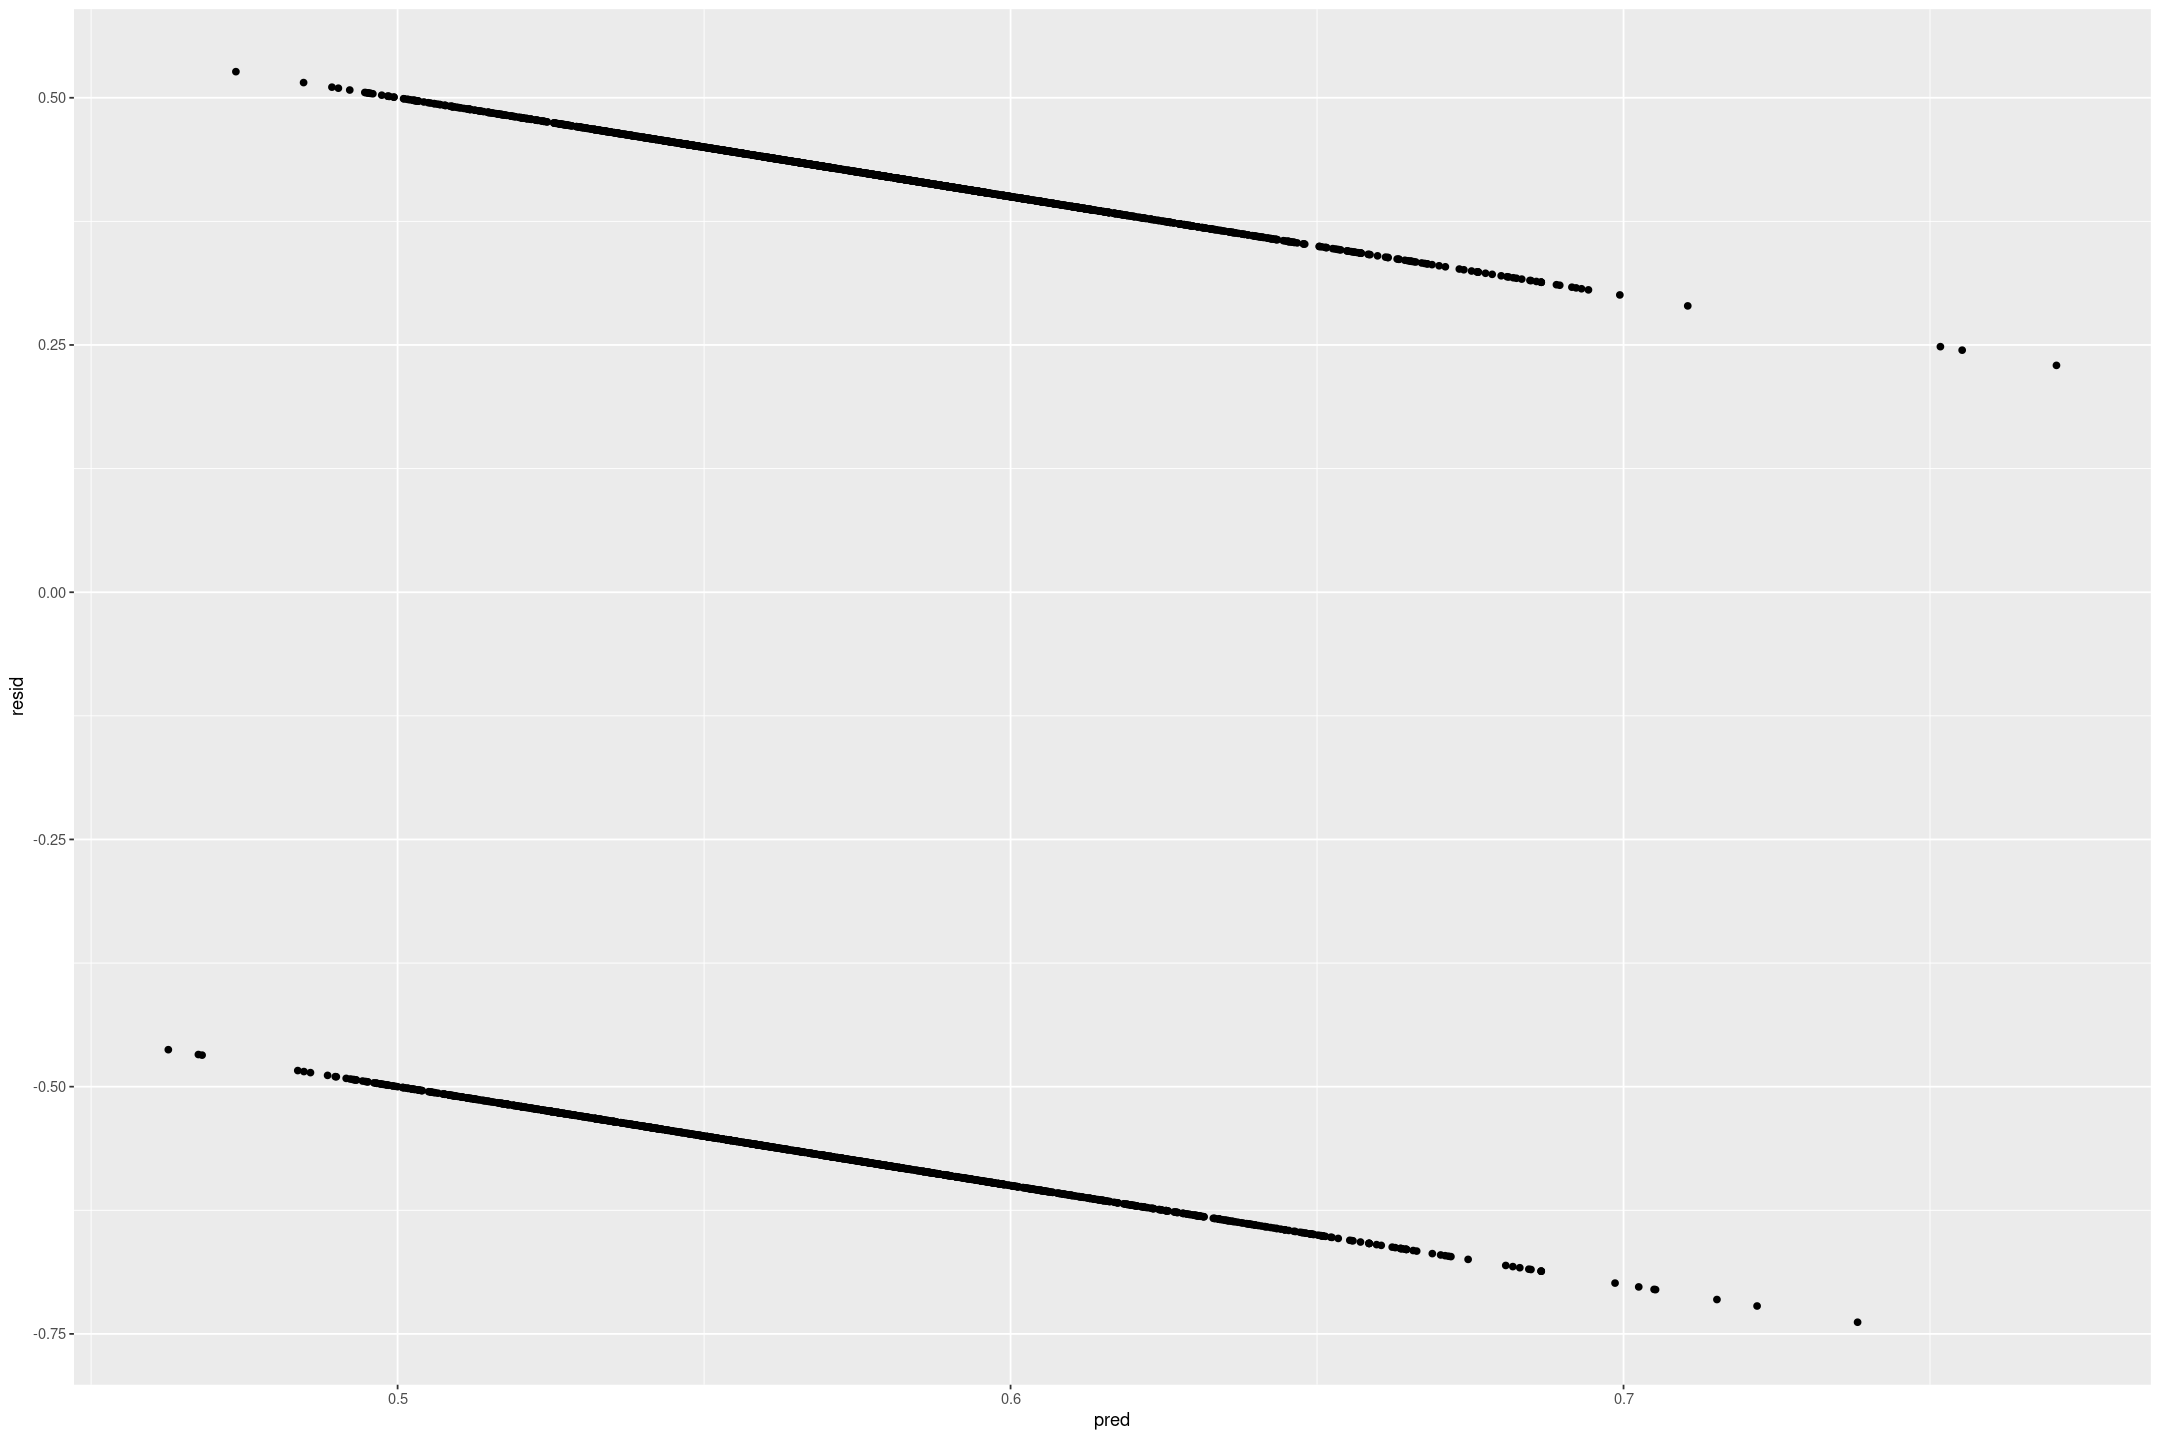

In [26]:
wells %>% 
add_predictions(fit_wells_log_dist, type="response") %>% 
mutate(resid = switch - pred) %>%
gf_point(resid ~ pred)

In [27]:
nrow(wells)

[1] 3020

The binned residuals are much more informative - it underestimates at low and high probabilities, and overestimates in the middle.

In [28]:
n_bins = 50

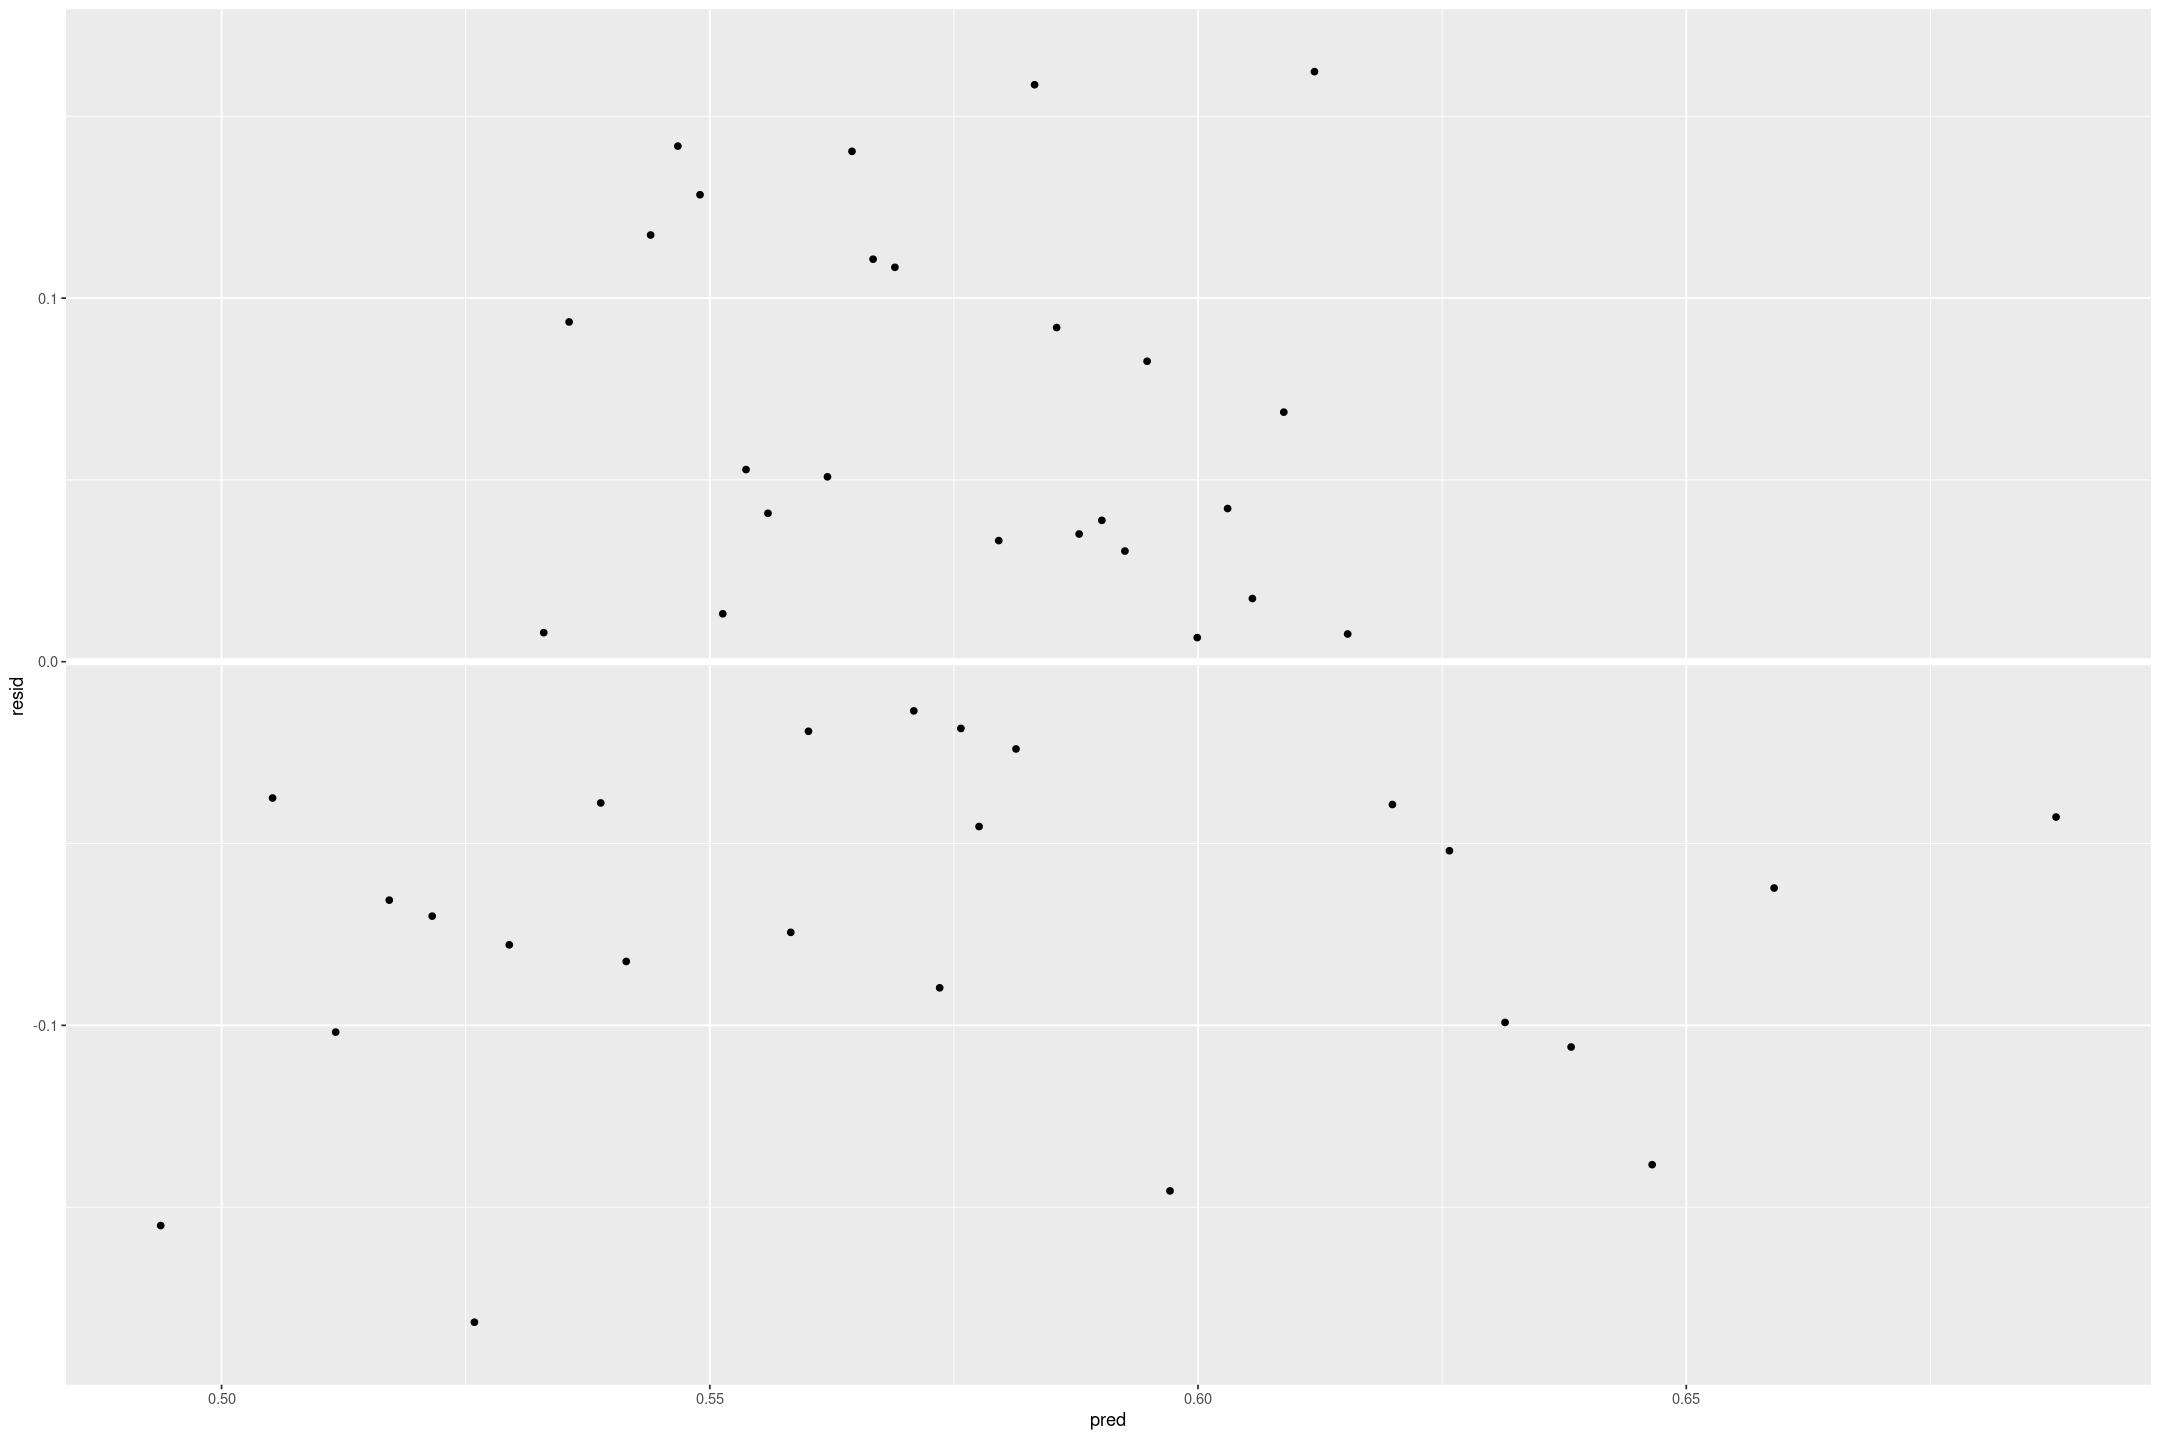

In [29]:
wells %>% 
add_predictions(fit_wells_log_dist, type="response") %>% 
mutate(bins=cut(pred, quantile(pred, seq(0, 1, length.out=n_bins)), include.lowest=TRUE)) %>%
group_by(bins) %>%
summarise(n=n(), switch=mean(switch), pred=mean(pred)) %>%
mutate(resid = switch - pred,
       se = sqrt(pred * (1-pred) / n)) %>%
gf_hline(yintercept=~0, size=2, colour="white") %>%
gf_point(resid ~ pred)

With one predictor it is more interpretable to look at residuals against the predictor.

Under about 20m and over 100 it underestimates by about 10% and overestimates inbetween.

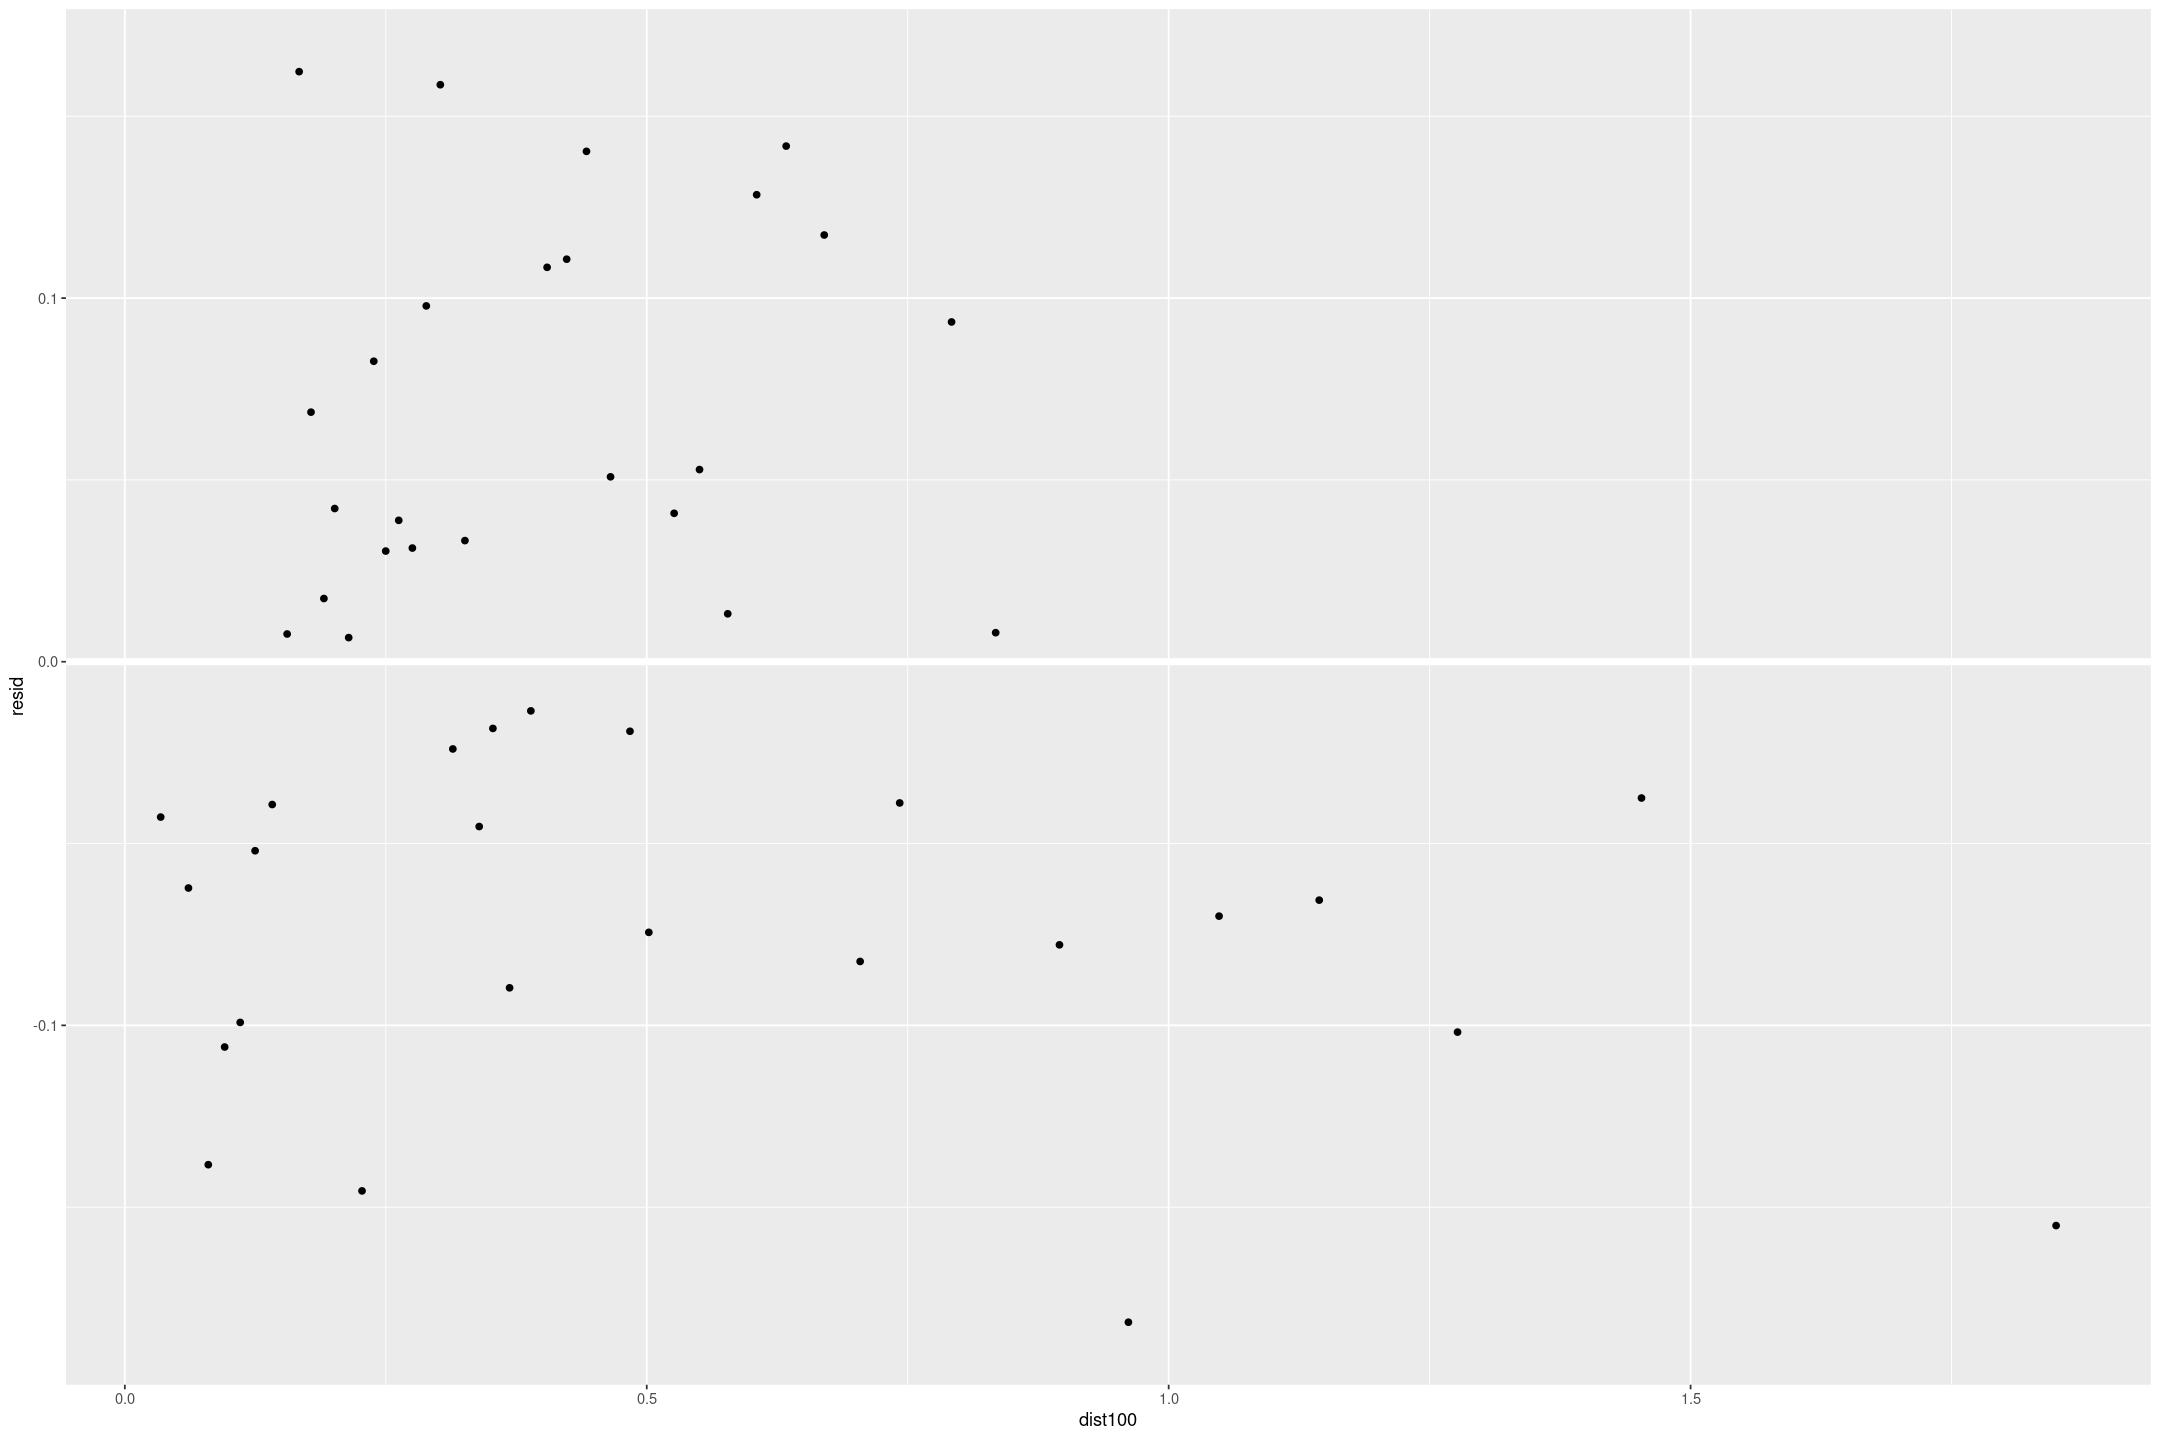

In [30]:
wells %>% 
add_predictions(fit_wells_log_dist, type="response") %>% 
mutate(bins=cut(dist100, quantile(dist100, seq(0, 1, length.out=n_bins)), include.lowest=TRUE)) %>%
group_by(bins) %>%
summarise(n=n(), switch=mean(switch), pred=mean(pred), dist100=mean(dist100)) %>%
mutate(resid = switch - pred,
       se = sqrt(pred * (1-pred) / n)) %>%
gf_hline(yintercept=~0, size=2, colour="white") %>%
gf_point(resid ~ dist100)

## Comparing error with null model

Compute the error rate of the fitted model and compare to the error rate of the null model.

The predicted outcomes from the model is they will switch only if the distance is less than about 100exp(0.5) = 160m.

In [31]:
fit_wells_log_dist

stan_glm
 family:       binomial [logit]
 formula:      switch ~ log(dist100)
 observations: 3020
 predictors:   2
------
             Median MAD_SD
(Intercept)   0.1    0.1  
log(dist100) -0.2    0.0  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [32]:
exp(.5)

[1] 1.648721

The null model error is about 58%

In [33]:
(null_error <- mean(wells$switch))

[1] 0.5751656

In [34]:
(error_rate <- 
(
wells %>%
mutate(pred = predict(fit_wells_log_dist, data=., type="response")) %>%
mutate(pred_outcome = pred > 0.5) %>%
summarise(error_rate = mean(switch == pred_outcome))
 )$error_rate)

[1] 0.5807947

So our model is about 0.5% more accurate in outcome predictions

In [35]:
error_rate - null_error

[1] 0.005629139

## Grouped distance model

Create indicator variables corresponding to `dist < 100`; `dist` between 100 and 200; and `dist > 200`.
Fit a logistic regression for Pr(switch) using these indicators.
With this new model, repeat the computation and graphs for part 1 of this exercise.

In [36]:
wells <- wells %>%
mutate(dist_group = cut(dist100, c(0, 1, 2, Inf), include.lowest=TRUE, right=FALSE, labels=c("<100m", "100-200m", ">=200m")))

In [37]:
wells %>% group_by(dist_group) %>% summarise(n=n(), min=min(dist100), max=max(dist100), mean=mean(dist100))

dist_group,n,min,max,mean
<fct>,<int>,<dbl>,<dbl>,<dbl>
<100m,2713,0.00387,0.99914,0.3844489
100-200m,298,1.00138,1.99309,1.3208735
>=200m,9,2.02134,3.39531,2.5546622


In [38]:
fit_wells_dist_group <- stan_glm(switch ~ dist_group, family=binomial(link="logit"), data=wells, refresh=0)

In [39]:
fit_wells_dist_group

stan_glm
 family:       binomial [logit]
 formula:      switch ~ dist_group
 observations: 3020
 predictors:   3
------
                   Median MAD_SD
(Intercept)         0.4    0.0  
dist_group100-200m -0.7    0.1  
dist_group>=200m   -1.7    0.8  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

### Plotting model predictions

In [40]:
dist_df <- data.frame(dist100=seq(0, 4, by=0.01)) %>%
mutate(dist_group = cut(dist100, c(0, 1, 2, Inf), include.lowest=TRUE, right=FALSE, labels=c("<100m", "100-200m", ">=200m"))) %>%
mutate(switch = predict(fit_wells_dist_group, newdata=., type="response"))

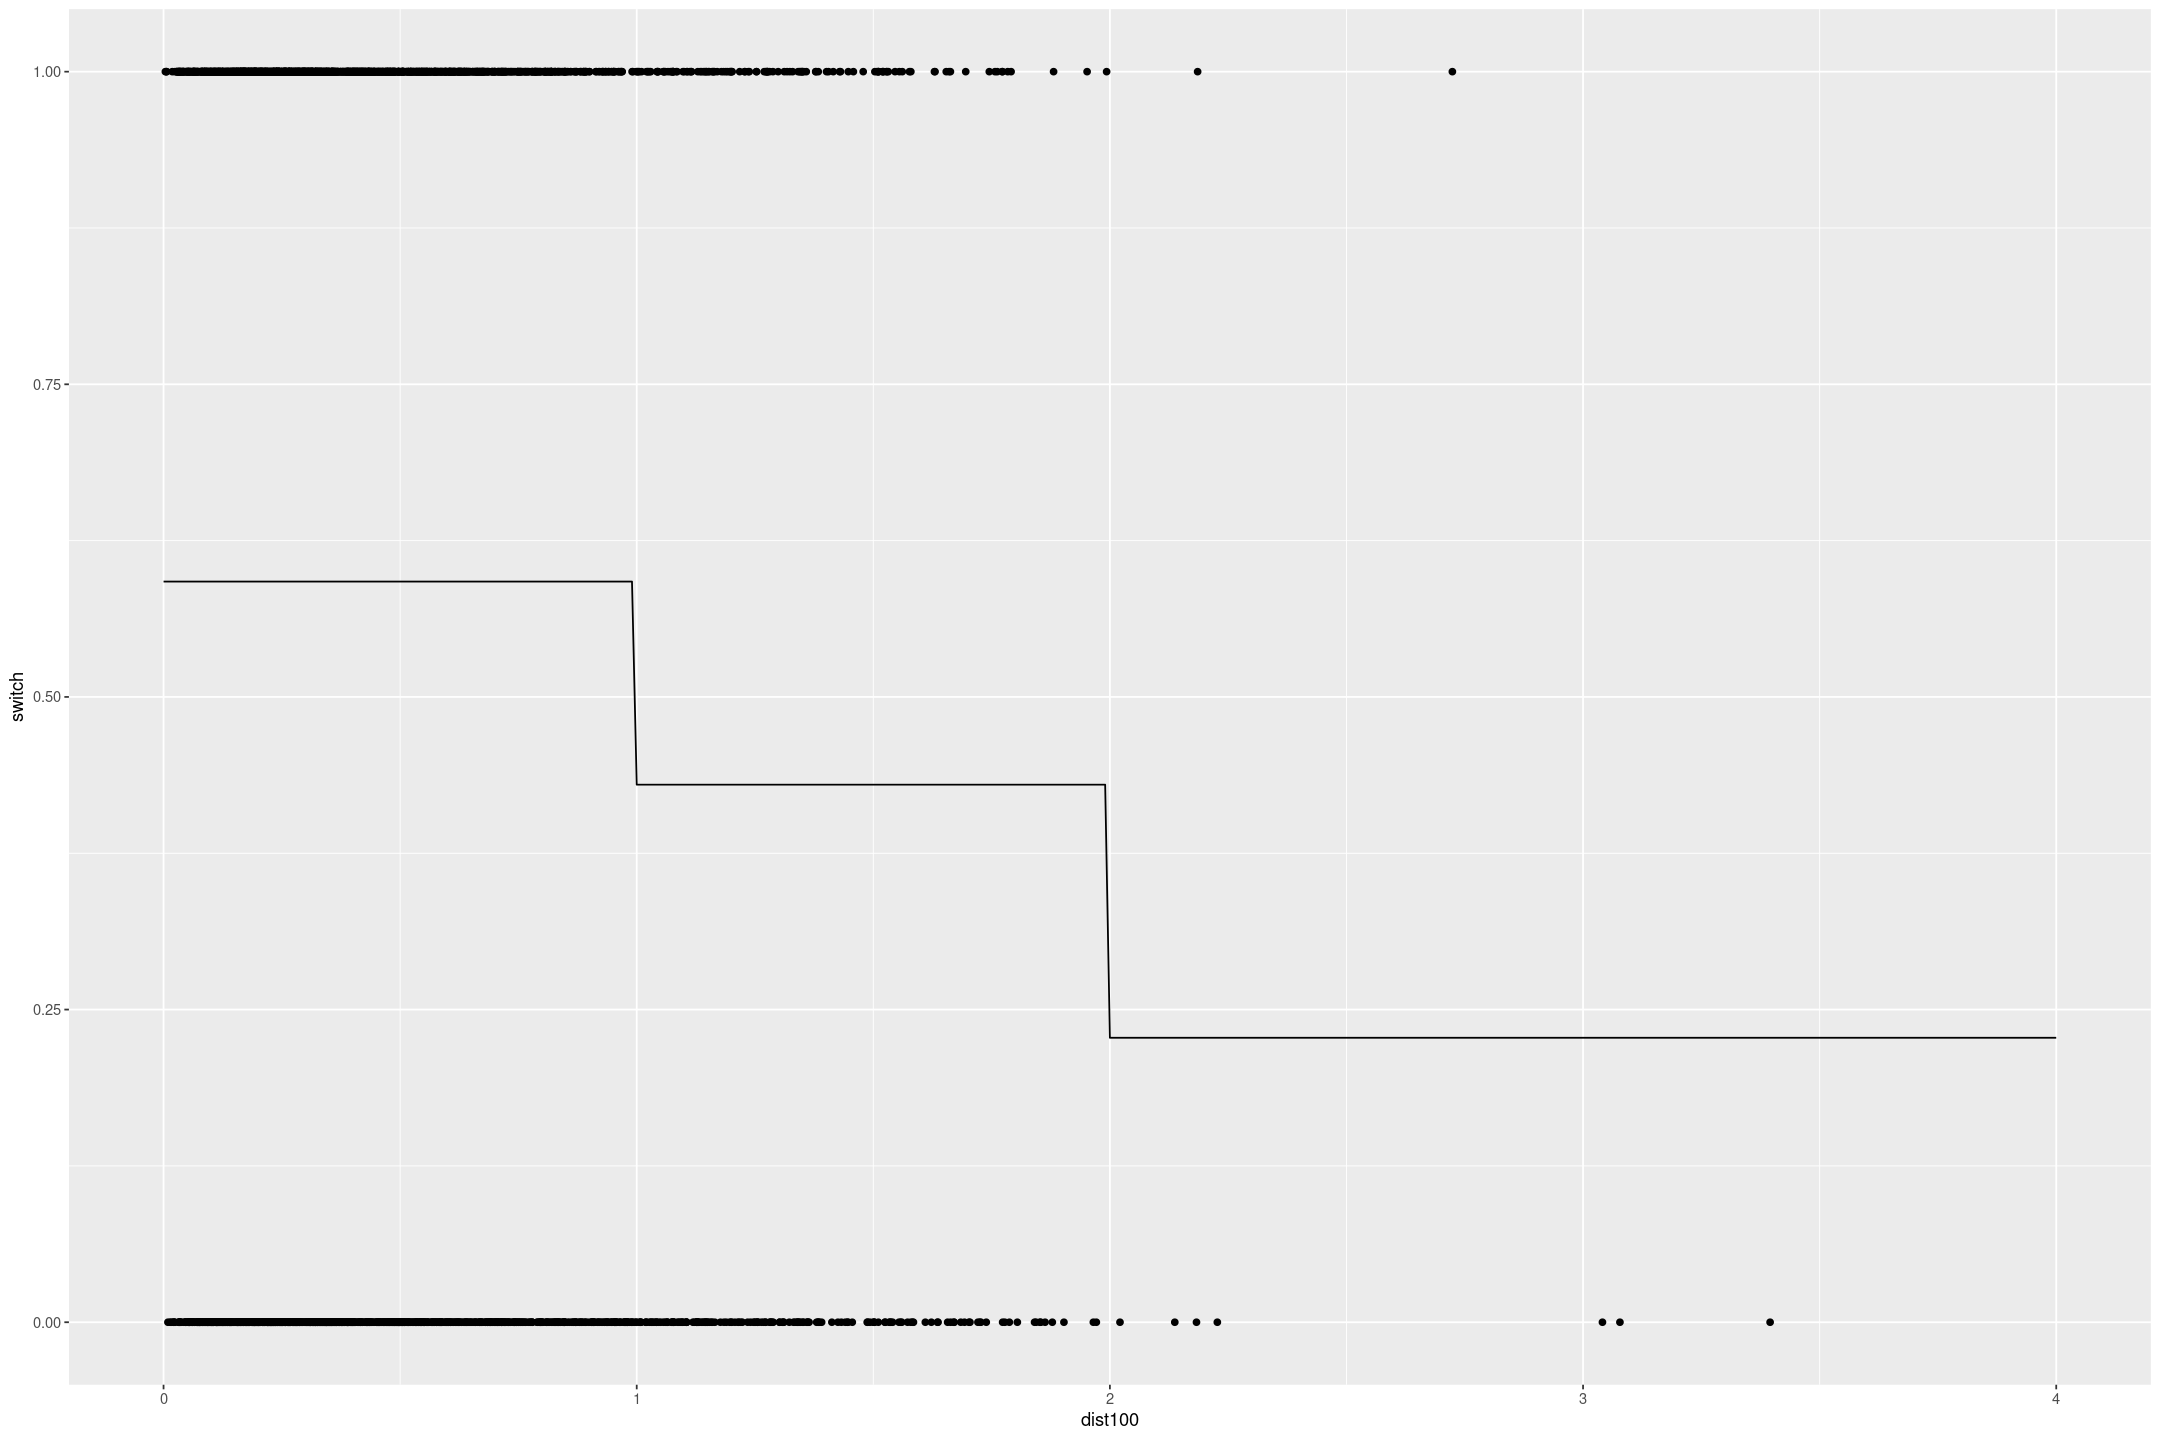

In [41]:
dist_df %>%
gf_line(switch ~ dist100) %>%
gf_point(data=wells)

### Residual plots

In this case there's only 3 points because there's only 3 possible outcomes.

If we counted the weight it would be more meaningful.

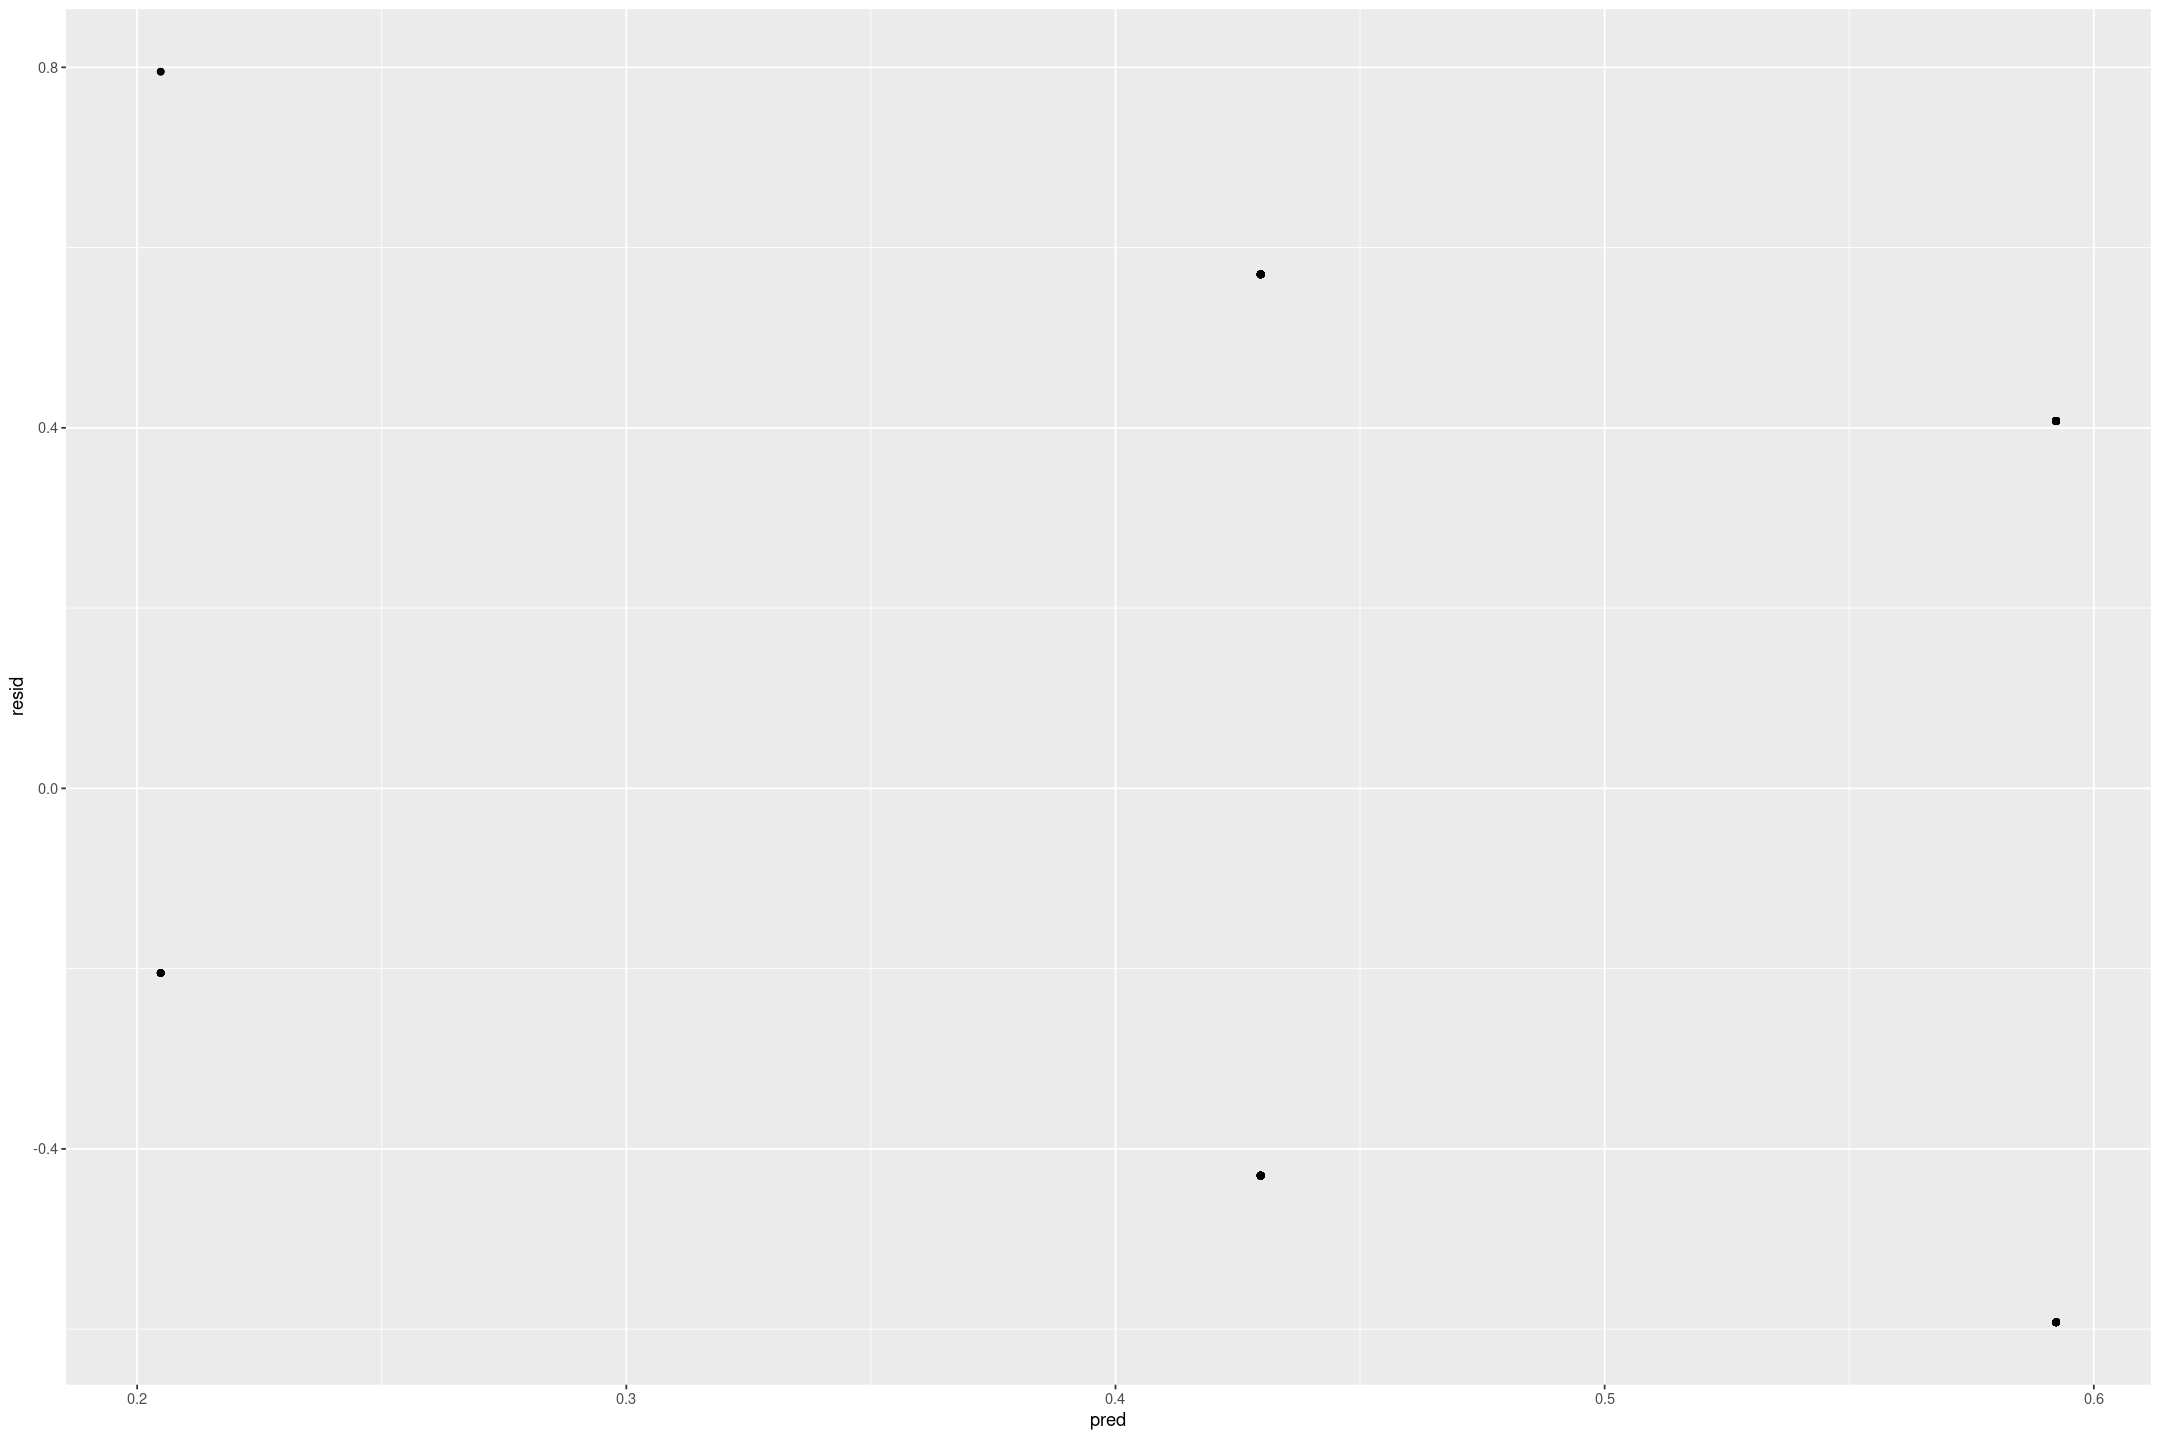

In [42]:
wells %>% 
add_predictions(fit_wells_dist_group, type="response") %>% 
mutate(resid = switch - pred) %>%
gf_point(resid ~ pred)

Because there are only 3 outcomes, there's no need to create bins.

The residuals get closer the for larger bins, likely because there's less variation out there.

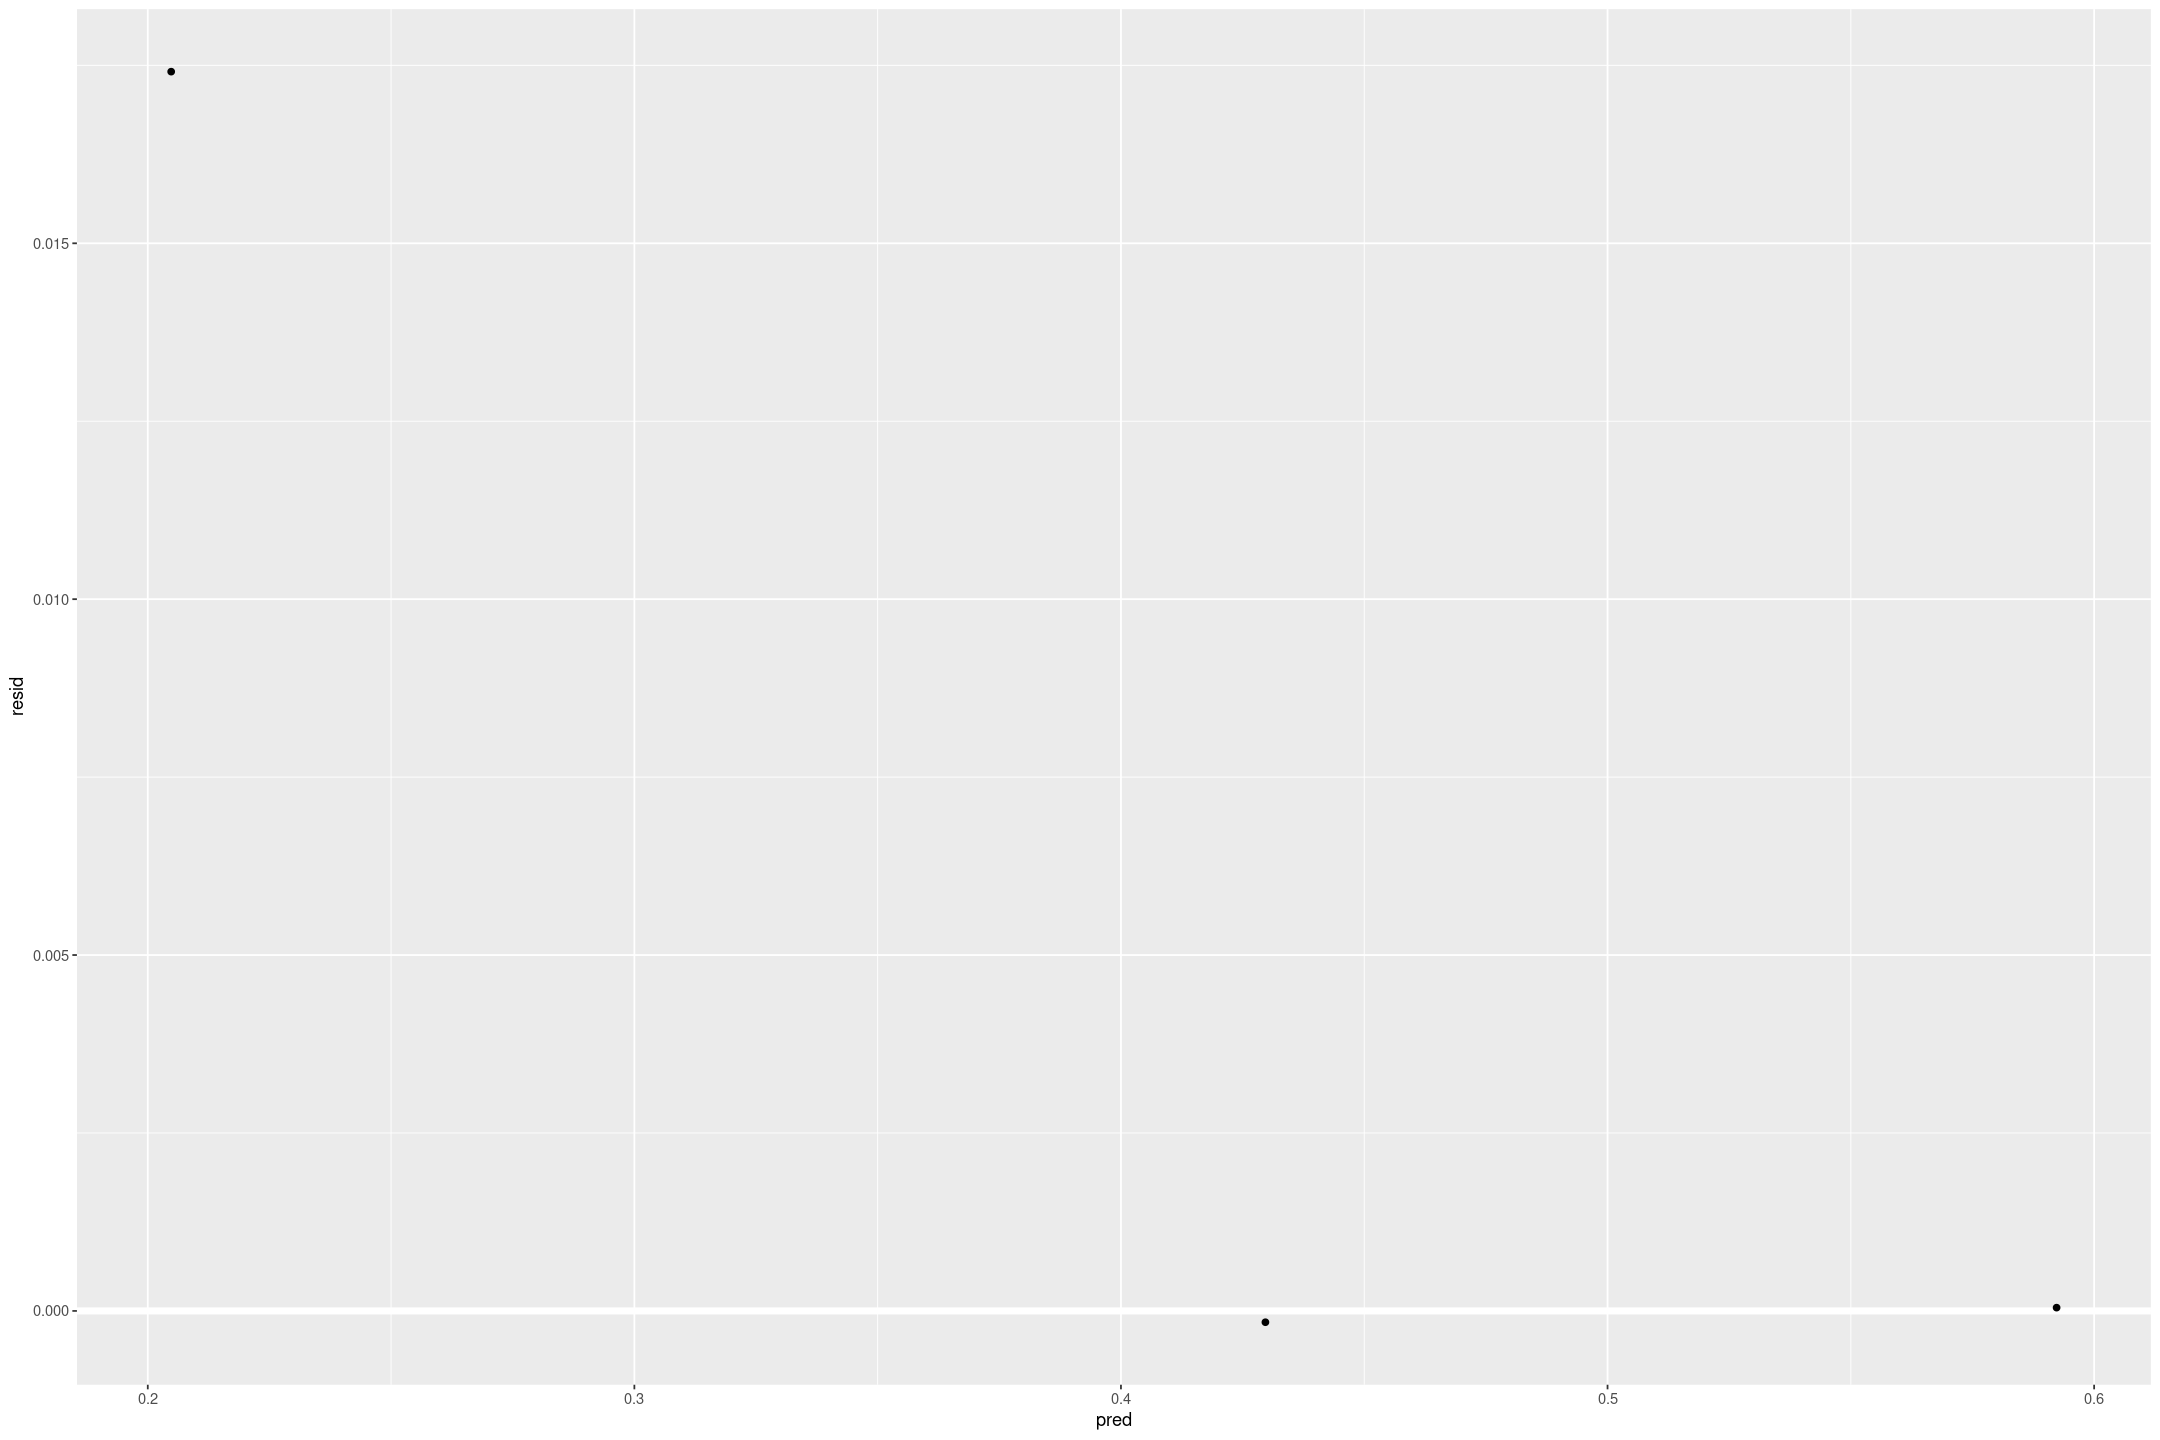

In [43]:
wells %>% 
add_predictions(fit_wells_dist_group, type="response") %>% 
group_by(pred) %>%
summarise(n=n(), switch=mean(switch)) %>%
mutate(resid = switch - pred) %>%
gf_hline(yintercept=~0, size=2, colour="white") %>%
gf_point(resid ~ pred)

In [44]:
n_bins=20

A plot of distance versus residual gives a clearer idea of what is happening.

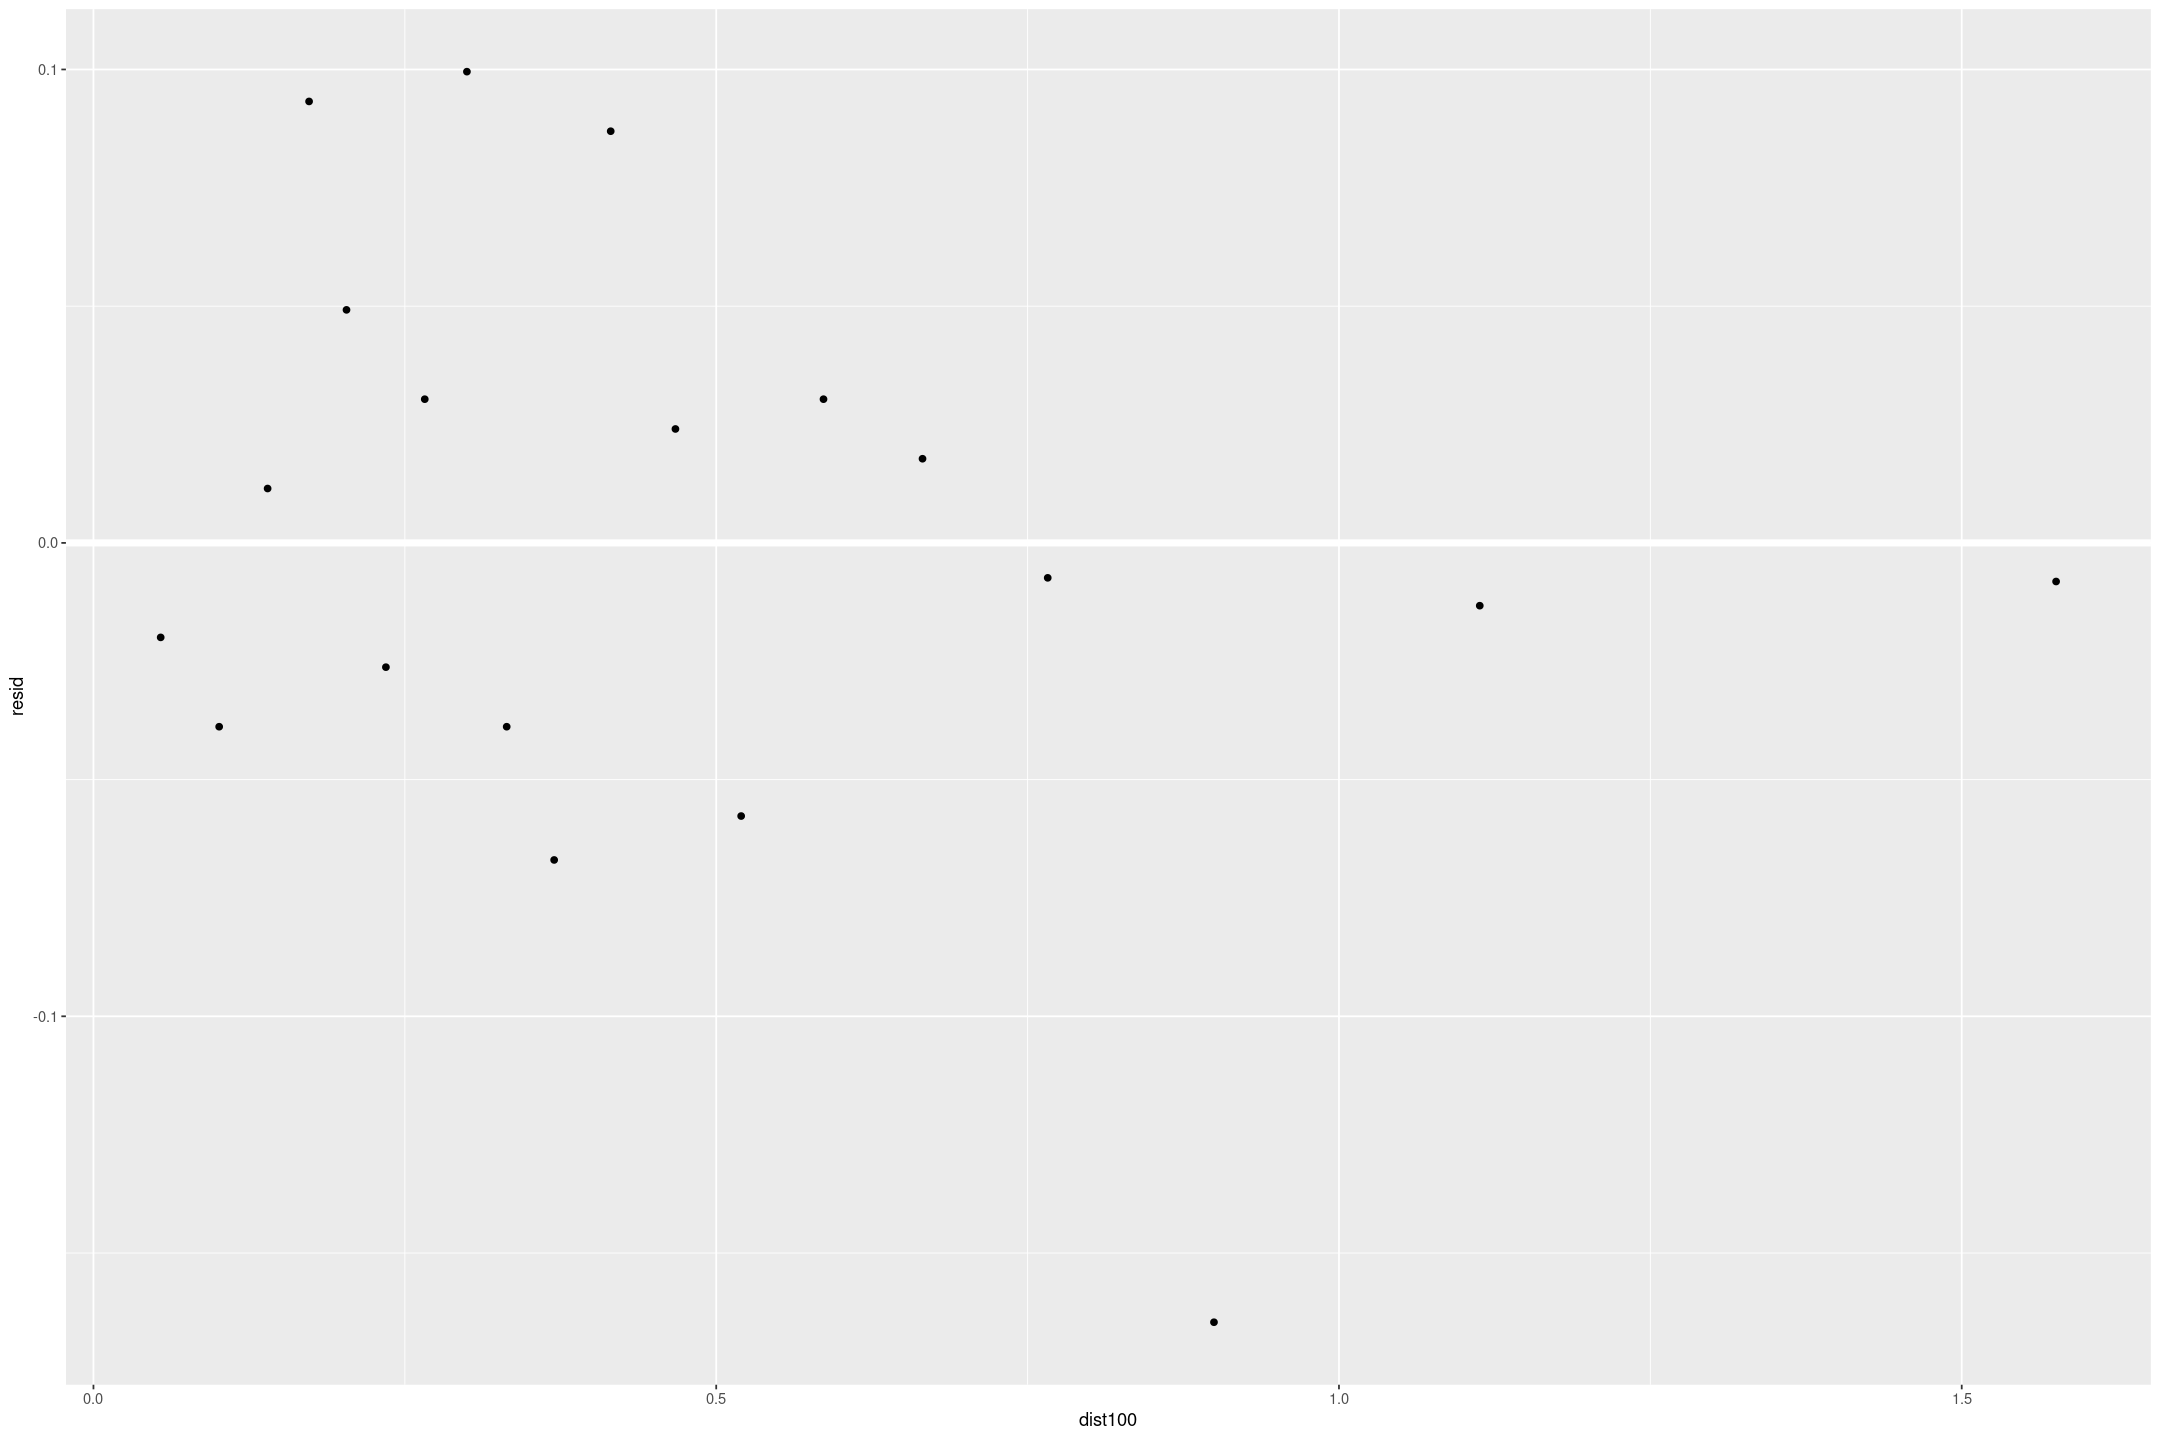

In [45]:
wells %>% 
add_predictions(fit_wells_dist_group, type="response") %>% 
mutate(bins=cut(dist100, quantile(dist100, seq(0, 1, length.out=n_bins)), include.lowest=TRUE)) %>%
group_by(bins) %>%
summarise(n=n(), switch=mean(switch), pred=mean(pred), dist100=mean(dist100)) %>%
mutate(resid = switch - pred,
       se = sqrt(pred * (1-pred) / n)) %>%
gf_hline(yintercept=~0, size=2, colour="white") %>%
gf_point(resid ~ dist100)

### Comparing error with null model

The binary outcome for this model is switch for <100m and no switch otherwise.

In [46]:
null_error

[1] 0.5751656

In [47]:
(group_error <- (wells %>% 
add_predictions(fit_wells_dist_group, type="response")  %>%
mutate(pred_switch = pred > 0.5) %>%
summarise(error=mean(switch==pred_switch)))$error)

[1] 0.5907285

The error is actually lower than our log model.
They have a similar log score.

In [48]:
loo_wells_log_dist <- loo(fit_wells_log_dist)
loo_wells_dist_group <- loo(fit_wells_dist_group)

loo_compare(loo_wells_log_dist, loo_wells_dist_group)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fit_wells_dist_group,0.000000,0.000000,-2045.627,10.097045,3.288058,0.75696764,4091.255,20.19409
fit_wells_log_dist,-5.112499,5.343958,-2050.740,9.444933,2.127673,0.04101886,4101.480,18.88987


# Working with logistic regression

Perform a logistic regression for a problem of interest to you.
This can be from a research project, a previous class, or data you download.
Choose one variable of interest to be the outcome, which will take on the values 0 and 1 (since you are doing a logistic regression).

Let's look at the [Hotel Booking Data](https://www.sciencedirect.com/science/article/pii/S2352340918315191), which for convenience we will download from [TidyTuesday](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md) (it's in [Kaggle Datasets](https://www.kaggle.com/jessemostipak/hotel-booking-demand) too with some interesting Kernels).

We're going to try to predict whether the booking was cancelled.

In [49]:
hotels <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv')


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  hotel = col_character(),
  arrival_date_month = col_character(),
  meal = col_character(),
  country = col_character(),
  market_segment = col_character(),
  distribution_channel = col_character(),
  reserved_room_type = col_character(),
  assigned_room_type = col_character(),
  deposit_type = col_character(),
  agent = col_character(),
  company = col_character(),
  customer_type = col_character(),
  reservation_status = col_character(),
  reservation_status_date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




## Analysing Data

Analyse the data in R.

### Data exploration

In [50]:
hotels %>% head()

hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<date>
Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03
Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03


### Subsetting by time

In [51]:
hotels <- hotels %>% mutate(arrival_date = lubridate::ymd(glue('{arrival_date_year}/{arrival_date_month}/{arrival_date_day_of_month}')))

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


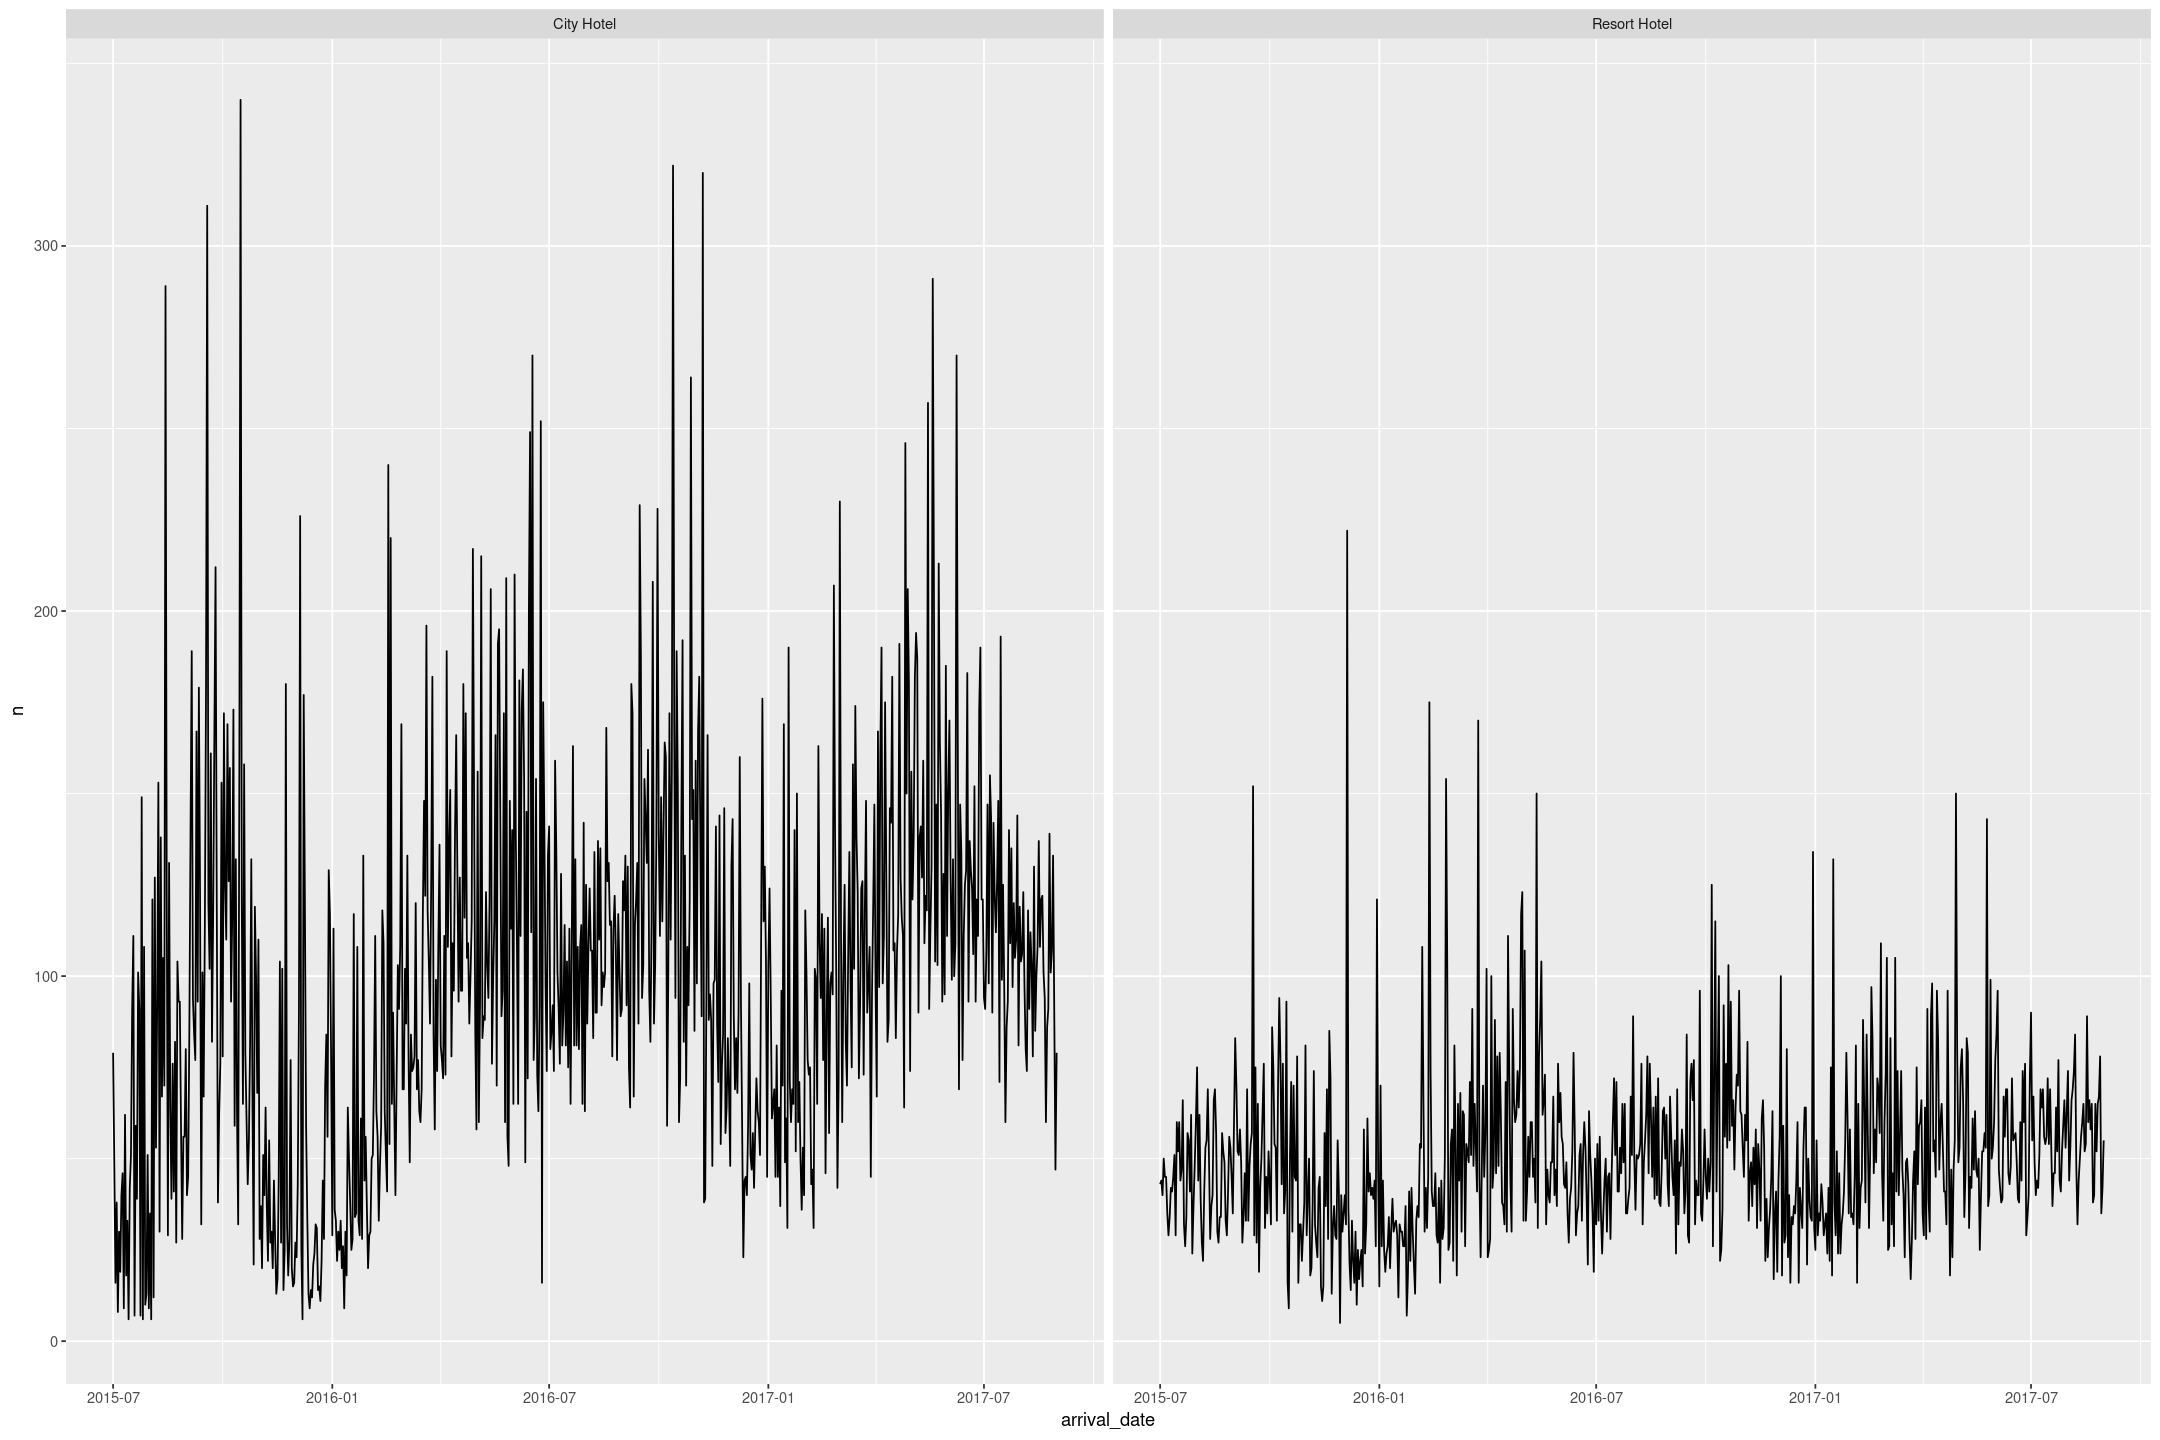

In [52]:
hotels %>% count(arrival_date, hotel) %>% gf_line(n ~ arrival_date | hotel)

In [53]:
nrow(hotels)

[1] 119390

In [54]:
3/26

[1] 0.1153846

This is a lot of data for Stan, let's pick a training set based on the first 3 months, and a validation set on the next 3 months and save the rest for validation.

Unfortunately this means we can't use seasonal feature which clearly occur in the data due to nature of travel (e.g. troughs in Jan and July), and also the change in the hotels over time (2015 has much lower bookings in City Hotel in July 2015 than in July 2016/2017).

We save the rest of the data for future validation/test sets.

In [55]:
library(lubridate)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [56]:
hotels <- hotels %>% mutate(split = if_else(arrival_date < make_date(2015,10,1), 'train',
                                           if_else(arrival_date < make_date(2016,1,1), 'valid', 'rest')))

hotels %>% group_by(split) %>% summarise(n=n(), start=min(arrival_date), end=max(arrival_date)) %>% arrange(start)

split,n,start,end
<chr>,<int>,<date>,<date>
train,11779,2015-07-01,2015-09-30
valid,10217,2015-10-01,2015-12-31
rest,97394,2016-01-01,2017-08-31


In [57]:
hotels_train <- hotels %>% filter(split == 'train')

In [58]:
hotels_valid <- hotels %>% filter(split=='valid')

#### Hotel

There are two hotels - a lot of the reservations are cancelled.

In [59]:
hotels_train %>% group_by(hotel) %>% summarise(n=n(), cancel=mean(is_canceled))

hotel,n,cancel
<chr>,<int>,<dbl>
City Hotel,7407,0.5014176
Resort Hotel,4372,0.2829369


#### Lead Time

Most people book early, interestingly there's a peak at ~250 days.

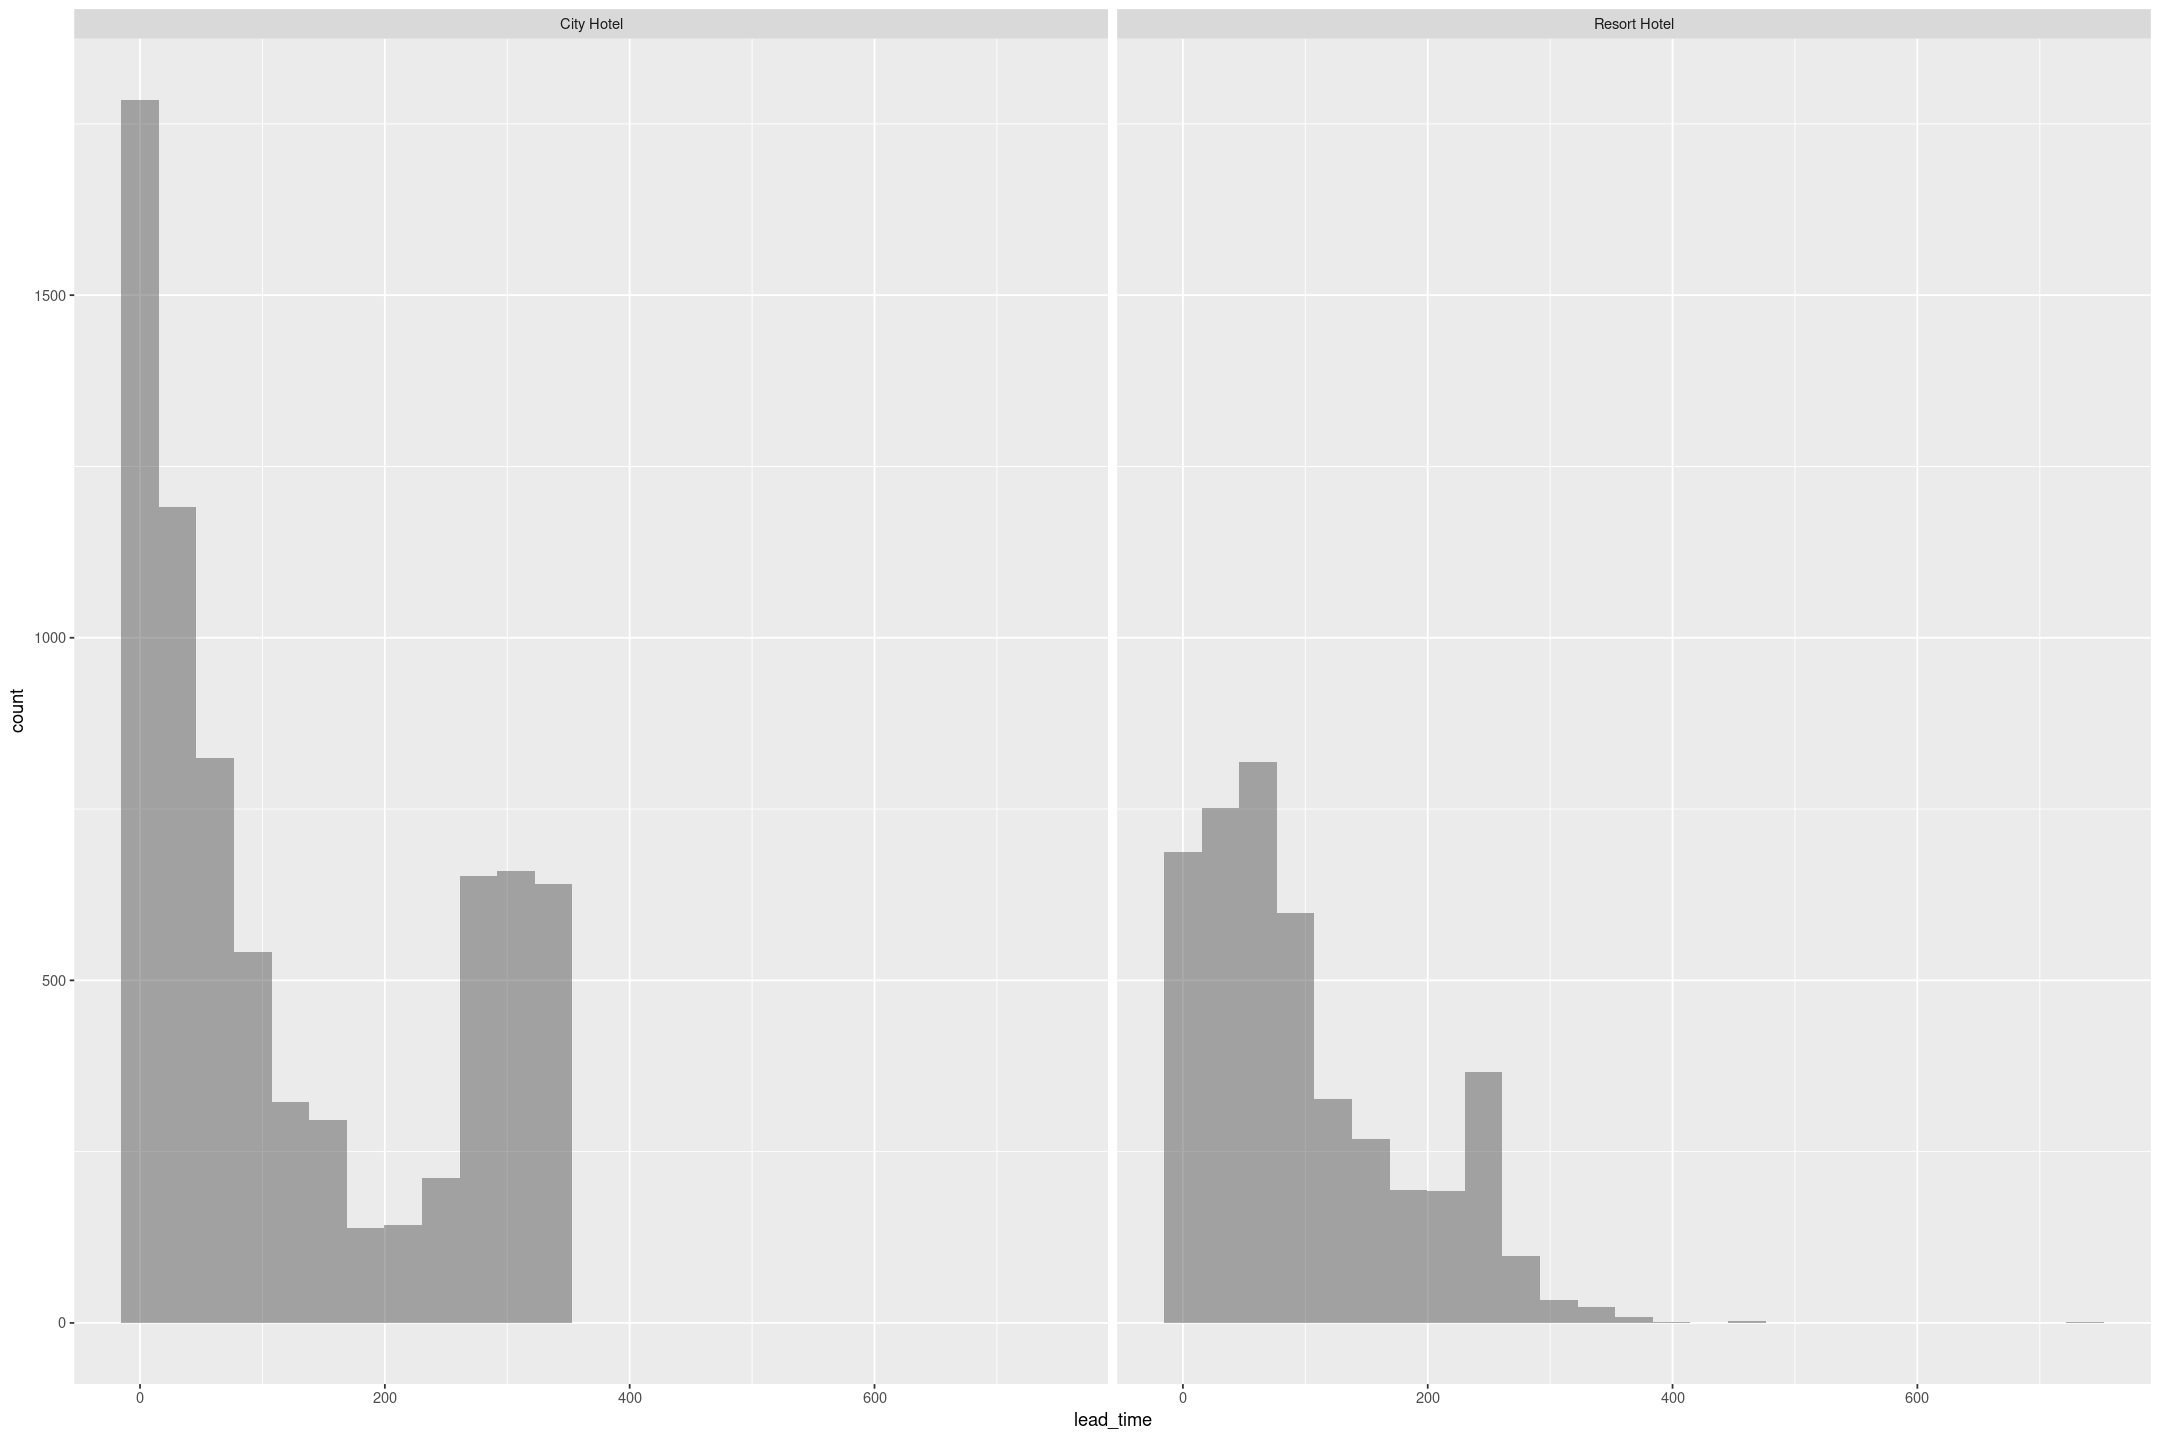

In [60]:
hotels_train %>% gf_histogram(~lead_time | hotel)

This peak doesn't occur int the validation set - maybe this is a startup (city hotel seems new) or seasonal effect.

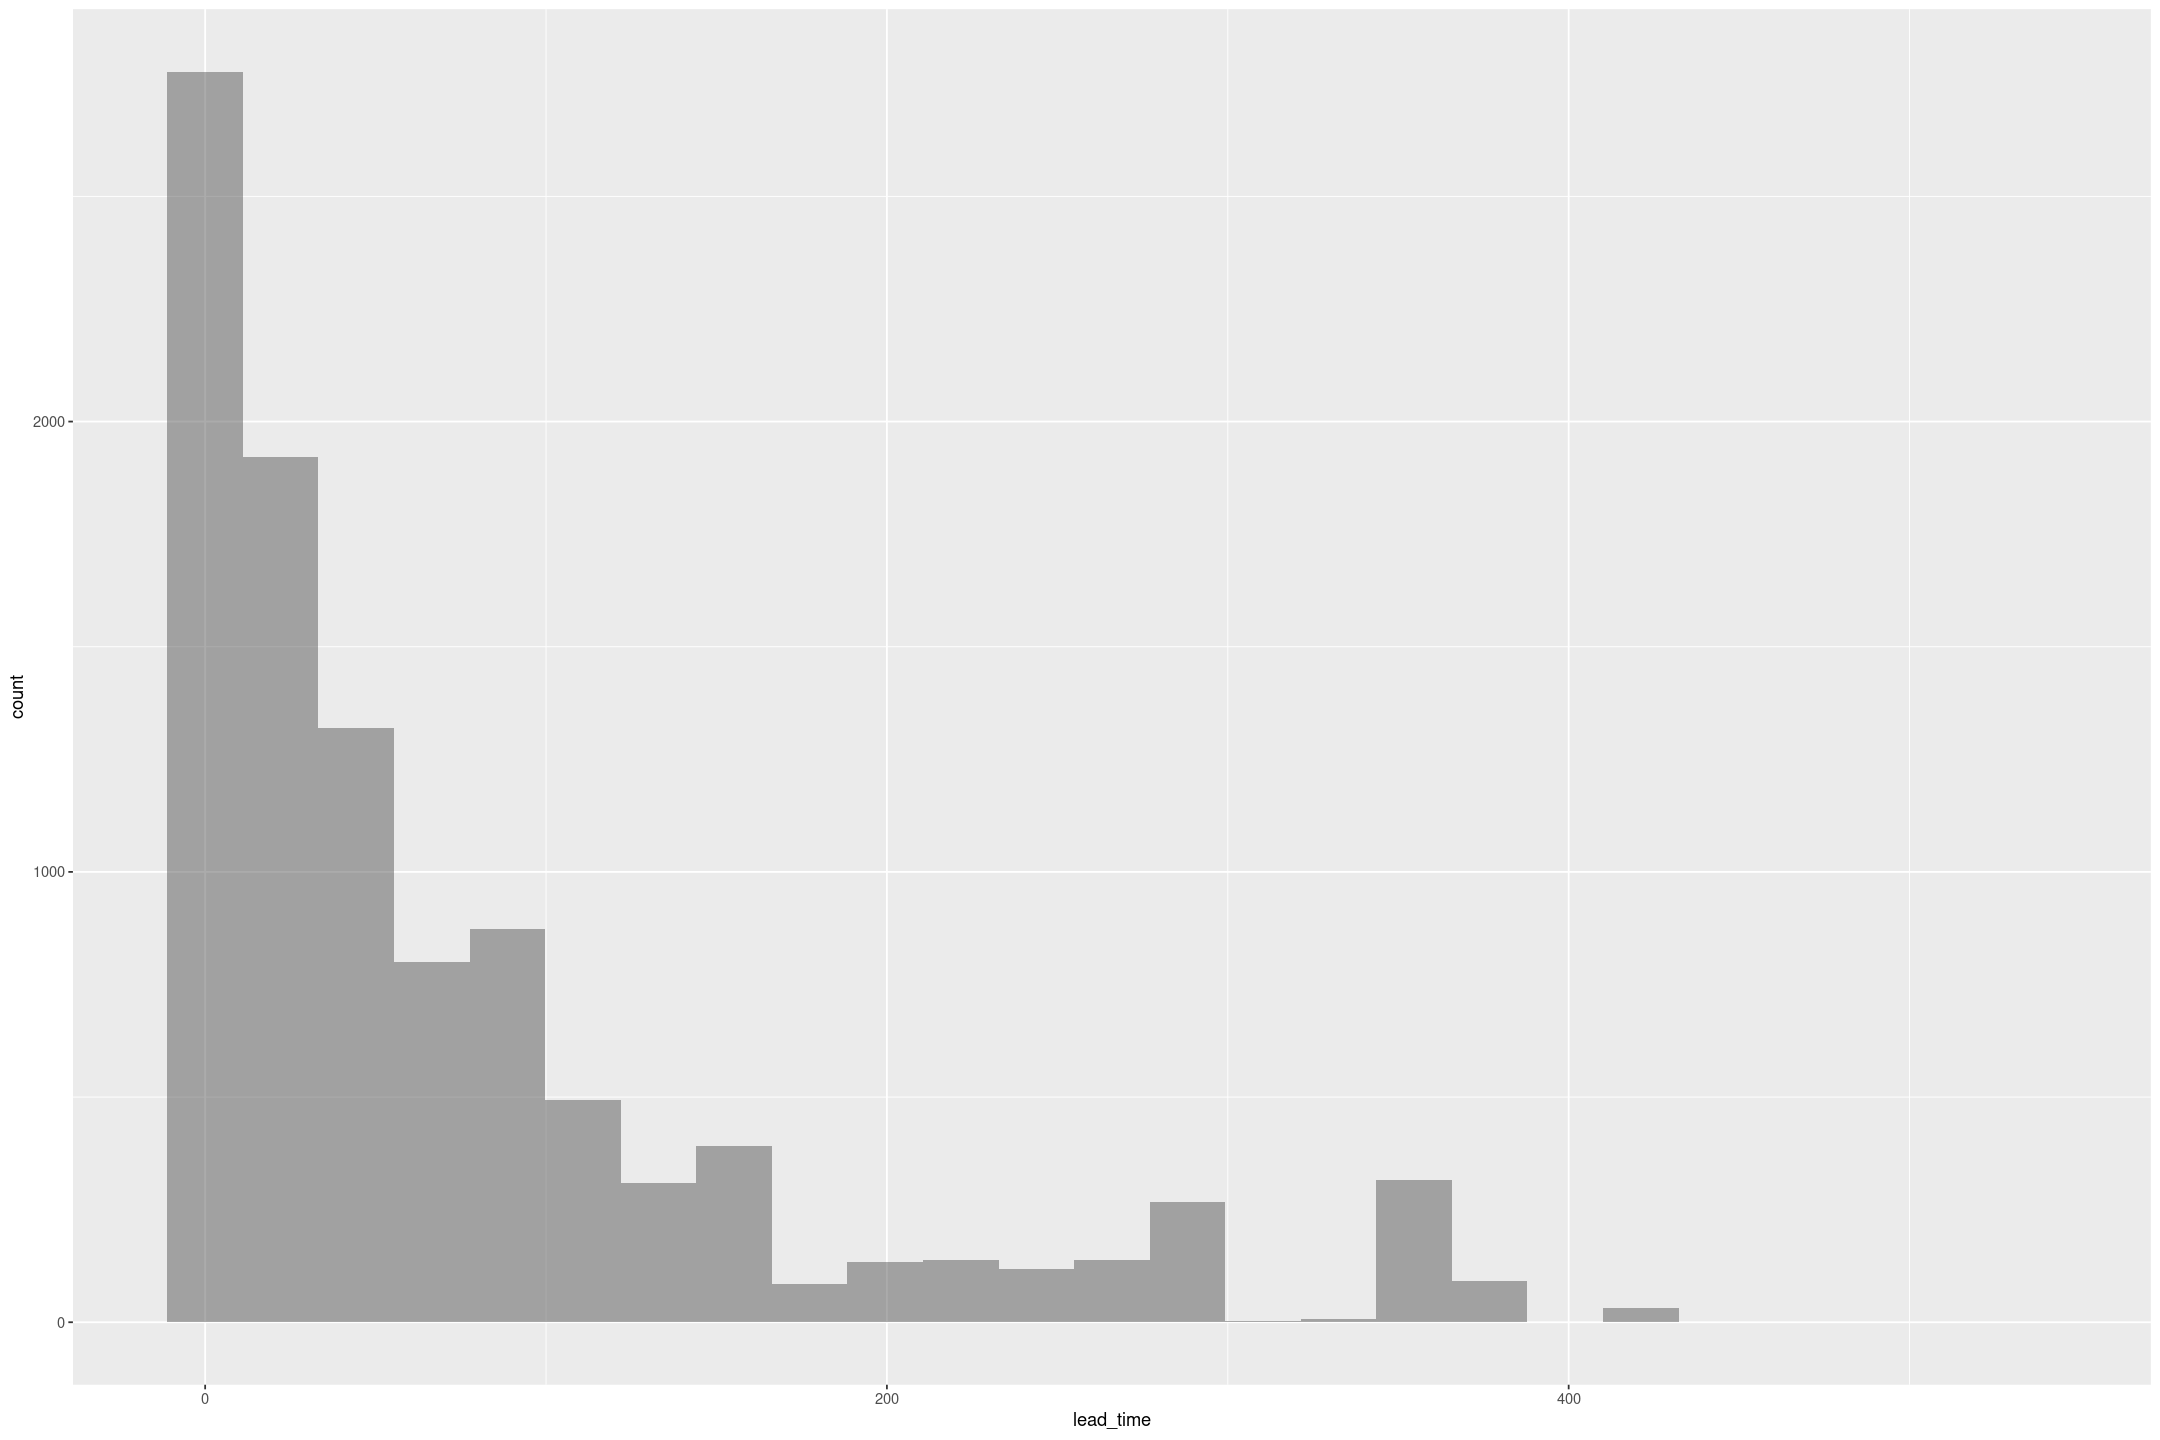

In [61]:
hotels_valid %>% gf_histogram(~lead_time)

Unsurprisingly the longer ahead a booking is made, the more likely it is to be cancelled (since there's more time for things to change).

Given the shape I would expect this to work better with a log-transform (or another non-linear function).

In [62]:
n_bin <- 20

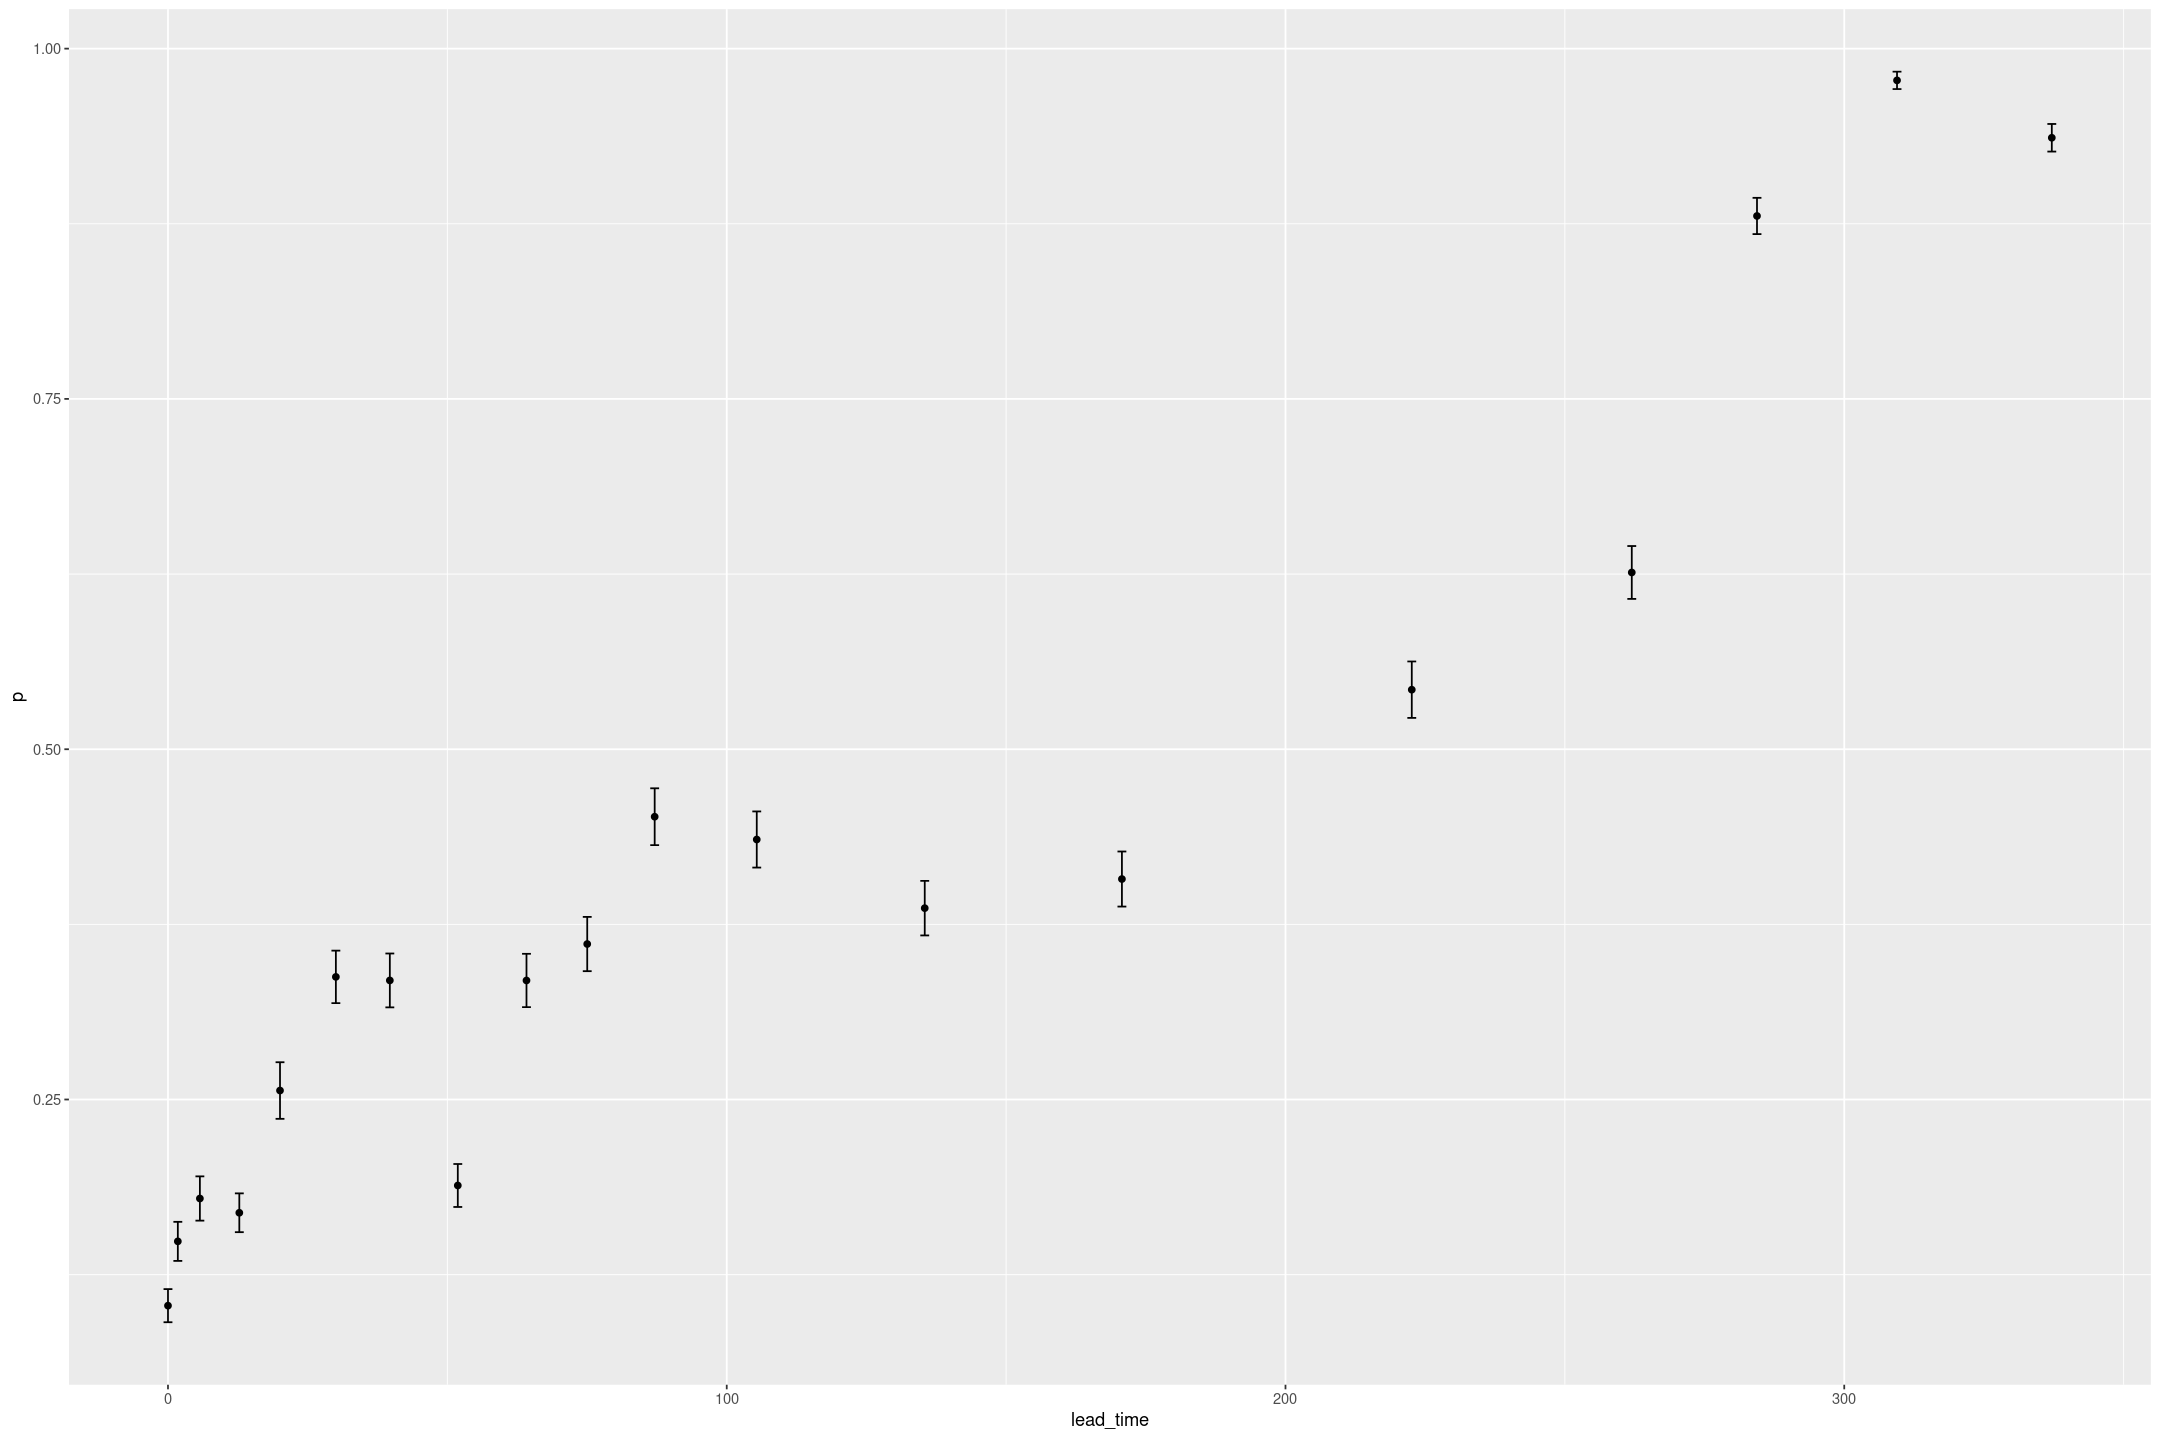

In [63]:
hotels_train %>%
mutate(bin=cut(lead_time, unique(quantile(lead_time, seq(0, 1, length.out=n_bin)), include.lowest=TRUE))) %>%
group_by(bin) %>%
summarise(n=n(), lead_time=mean(lead_time), p=mean(is_canceled)) %>%
mutate(se=sqrt(p*(1-p)/n), lower=p-se, upper=p+se) %>%
gf_point(p ~ lead_time) %>%
gf_errorbar(ymin=~lower, ymax=~upper)

#### Arival Date information

There seems to be a level shift in city hotel after a few weeks, but looks like something isolated to it.

`summarise()` has grouped output by 'arrival_date'. You can override using the `.groups` argument.



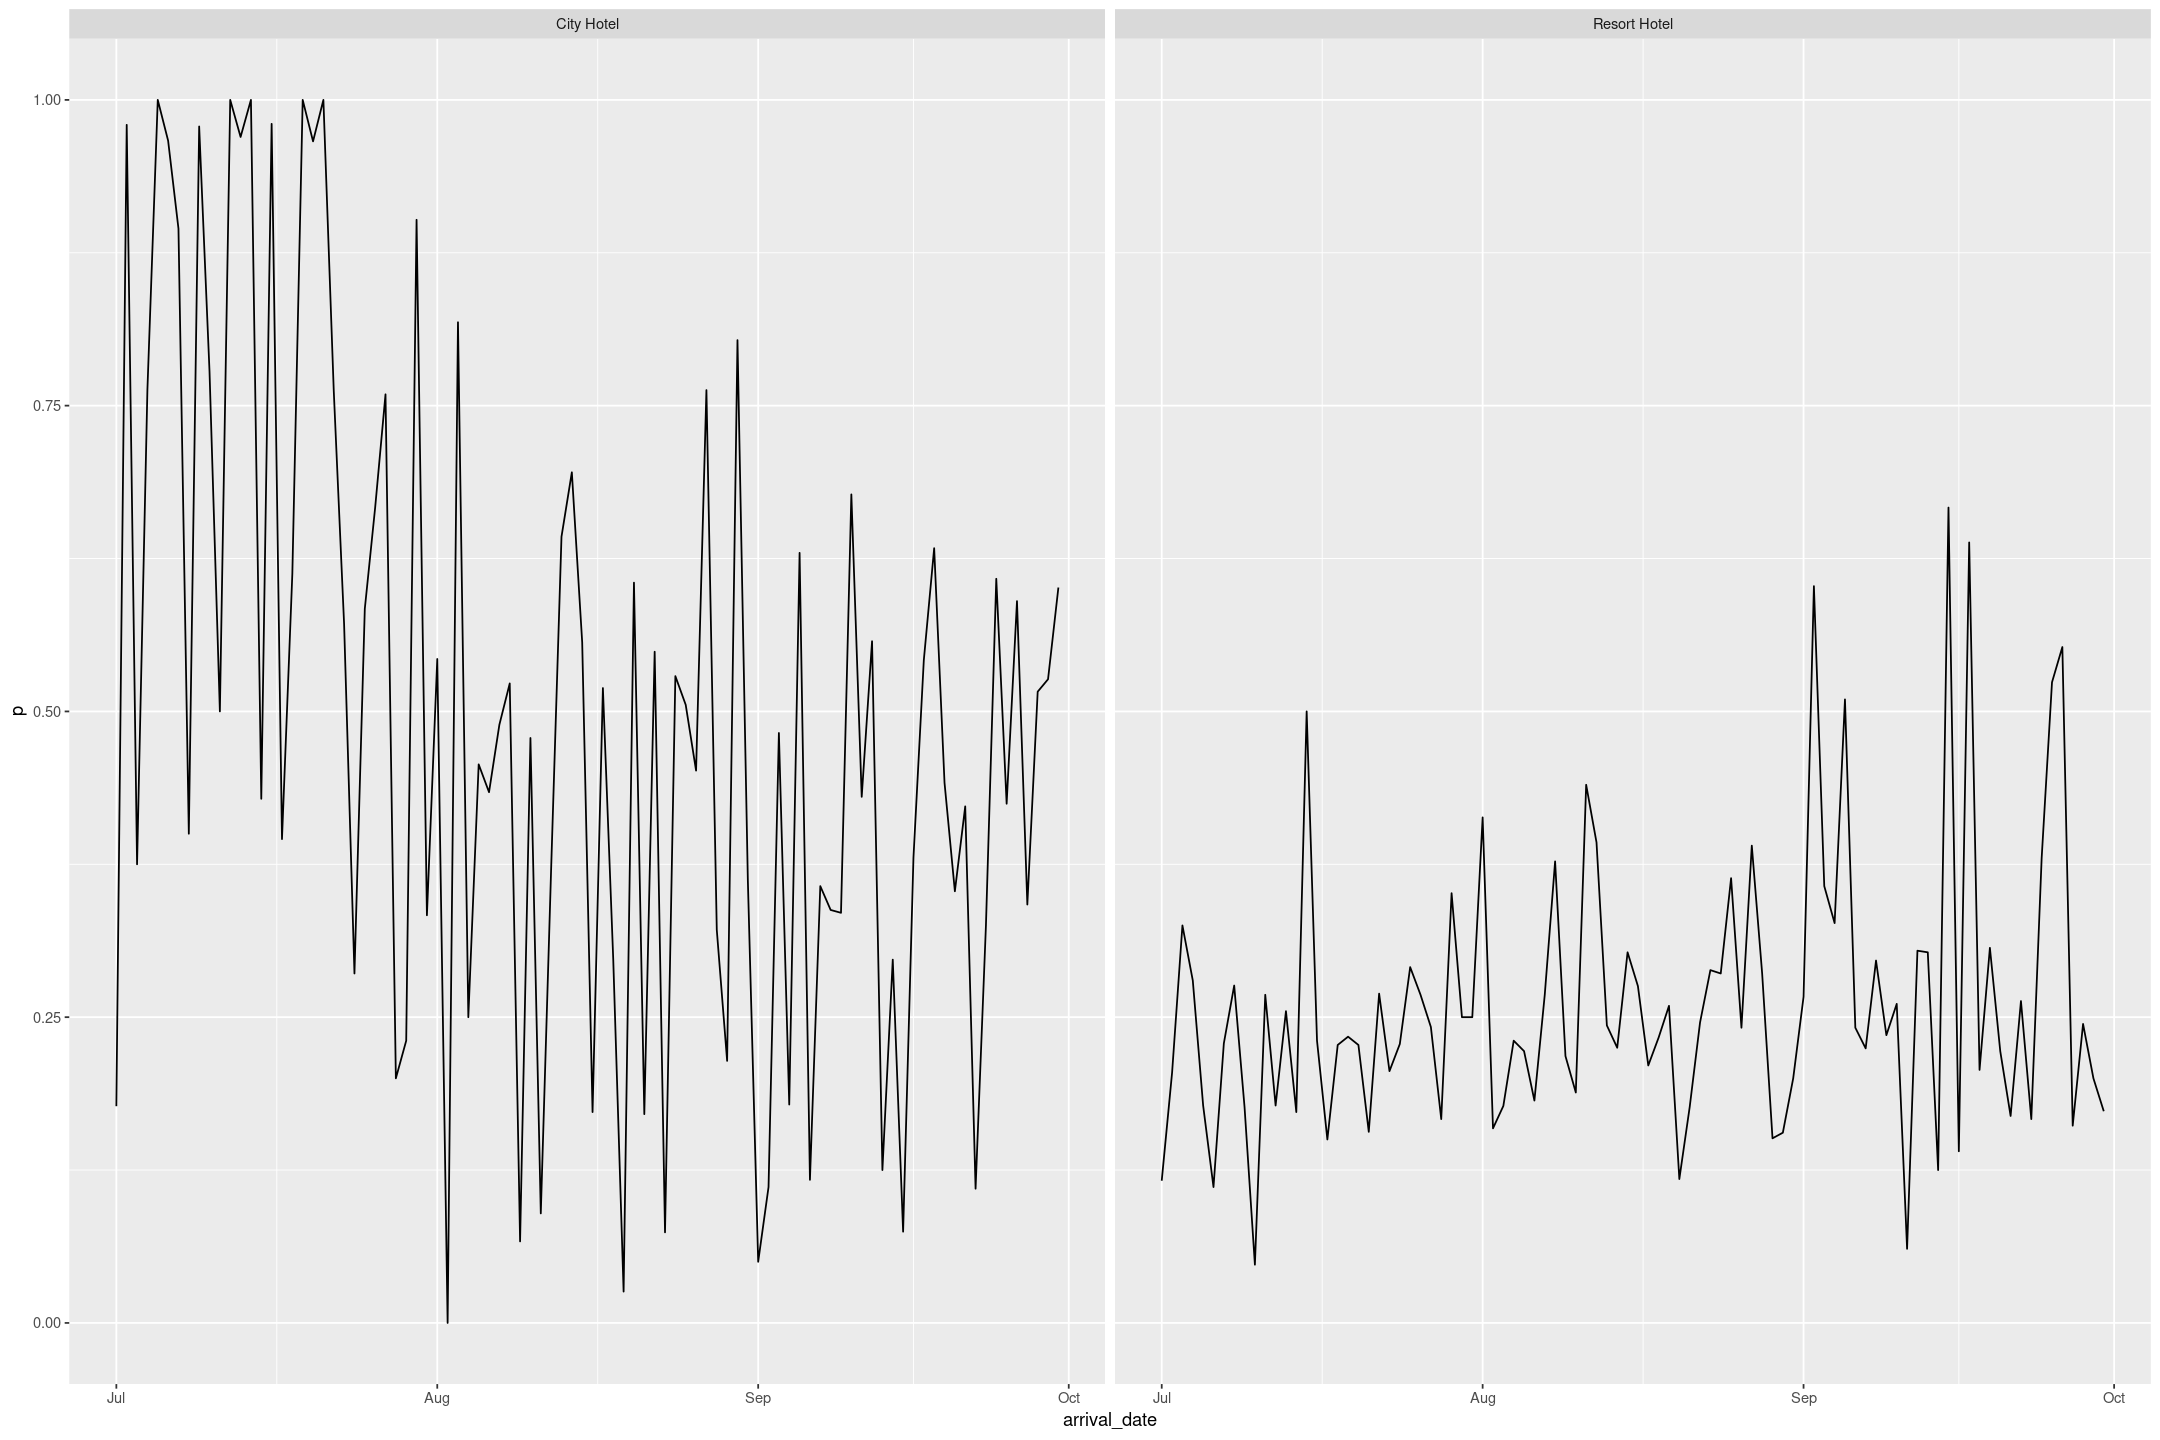

In [64]:
hotels_train %>% 
group_by(arrival_date, hotel) %>%
summarise(n=n(), p=mean(is_canceled)) %>%
mutate(phat = (p*n+2)/(n+4), se=sqrt(phat*(1-phat)/(n+4)), lower=p-2*se, upper=p+2*se) %>%
gf_line(p ~ arrival_date | hotel)

`summarise()` has grouped output by 'arrival_date'. You can override using the `.groups` argument.



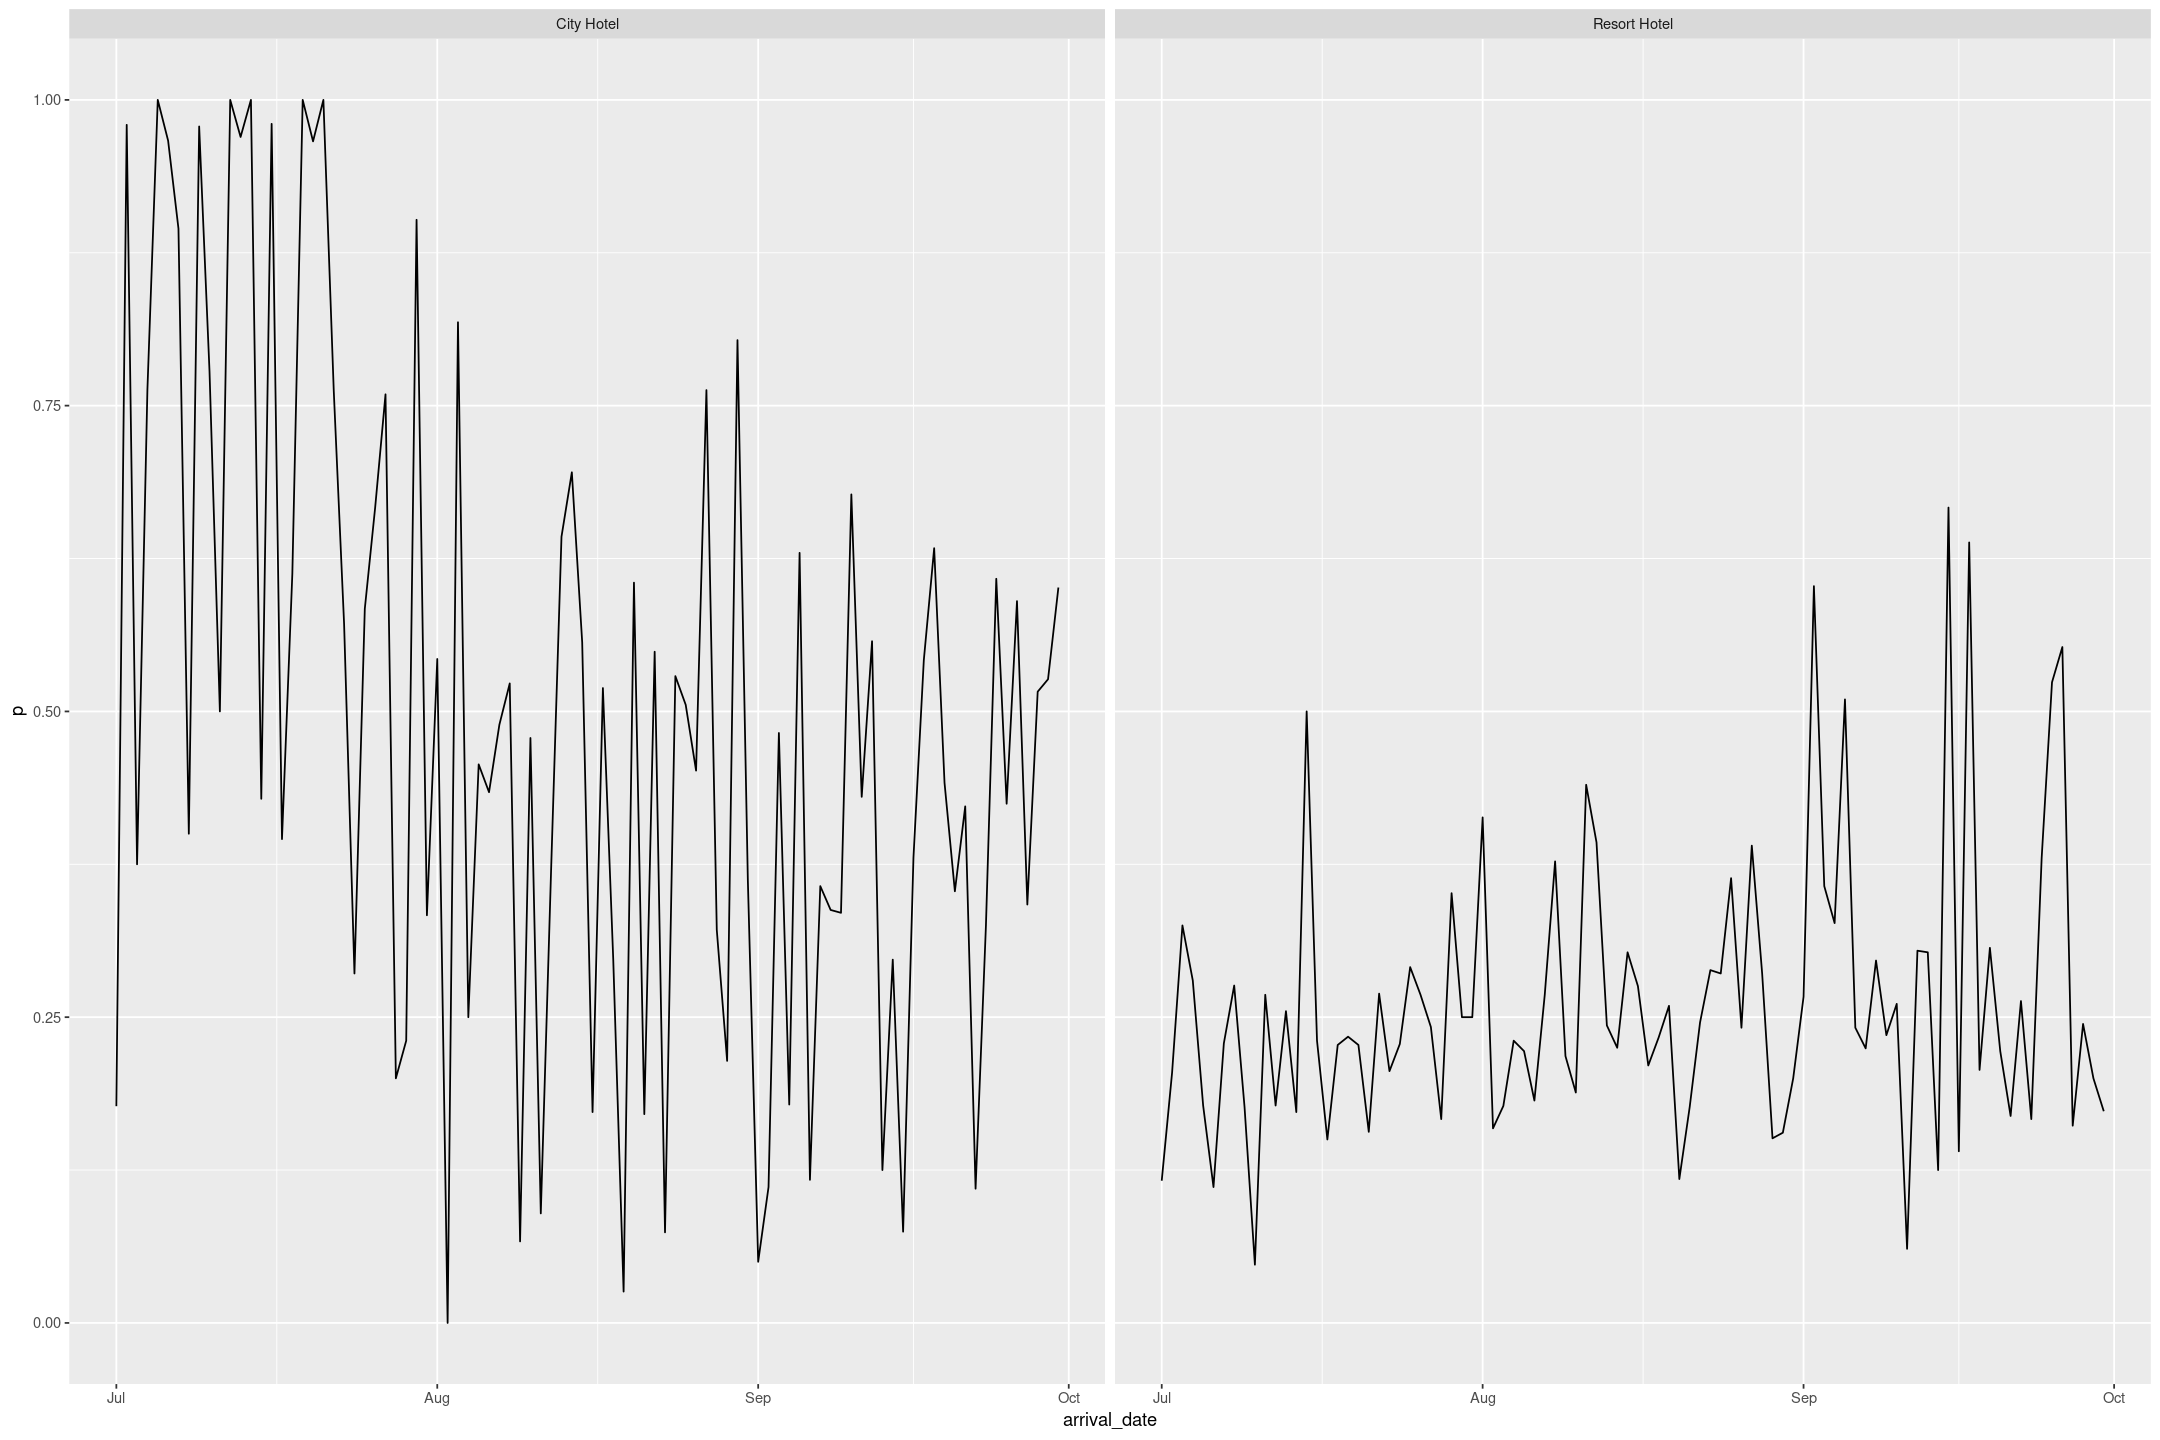

In [65]:
hotels_train %>% 
group_by(arrival_date, hotel) %>%
summarise(n=n(), p=mean(is_canceled)) %>%
mutate(phat = (p*n+2)/(n+4), se=sqrt(phat*(1-phat)/(n+4)), lower=p-2*se, upper=p+2*se) %>%
gf_line(p ~ arrival_date | hotel)

Fridays tend to have the highest cancellation rates, followed by Sundays.

Tusdays are a peak for City, but a trough for Resort.

`summarise()` has grouped output by 'weekday'. You can override using the `.groups` argument.



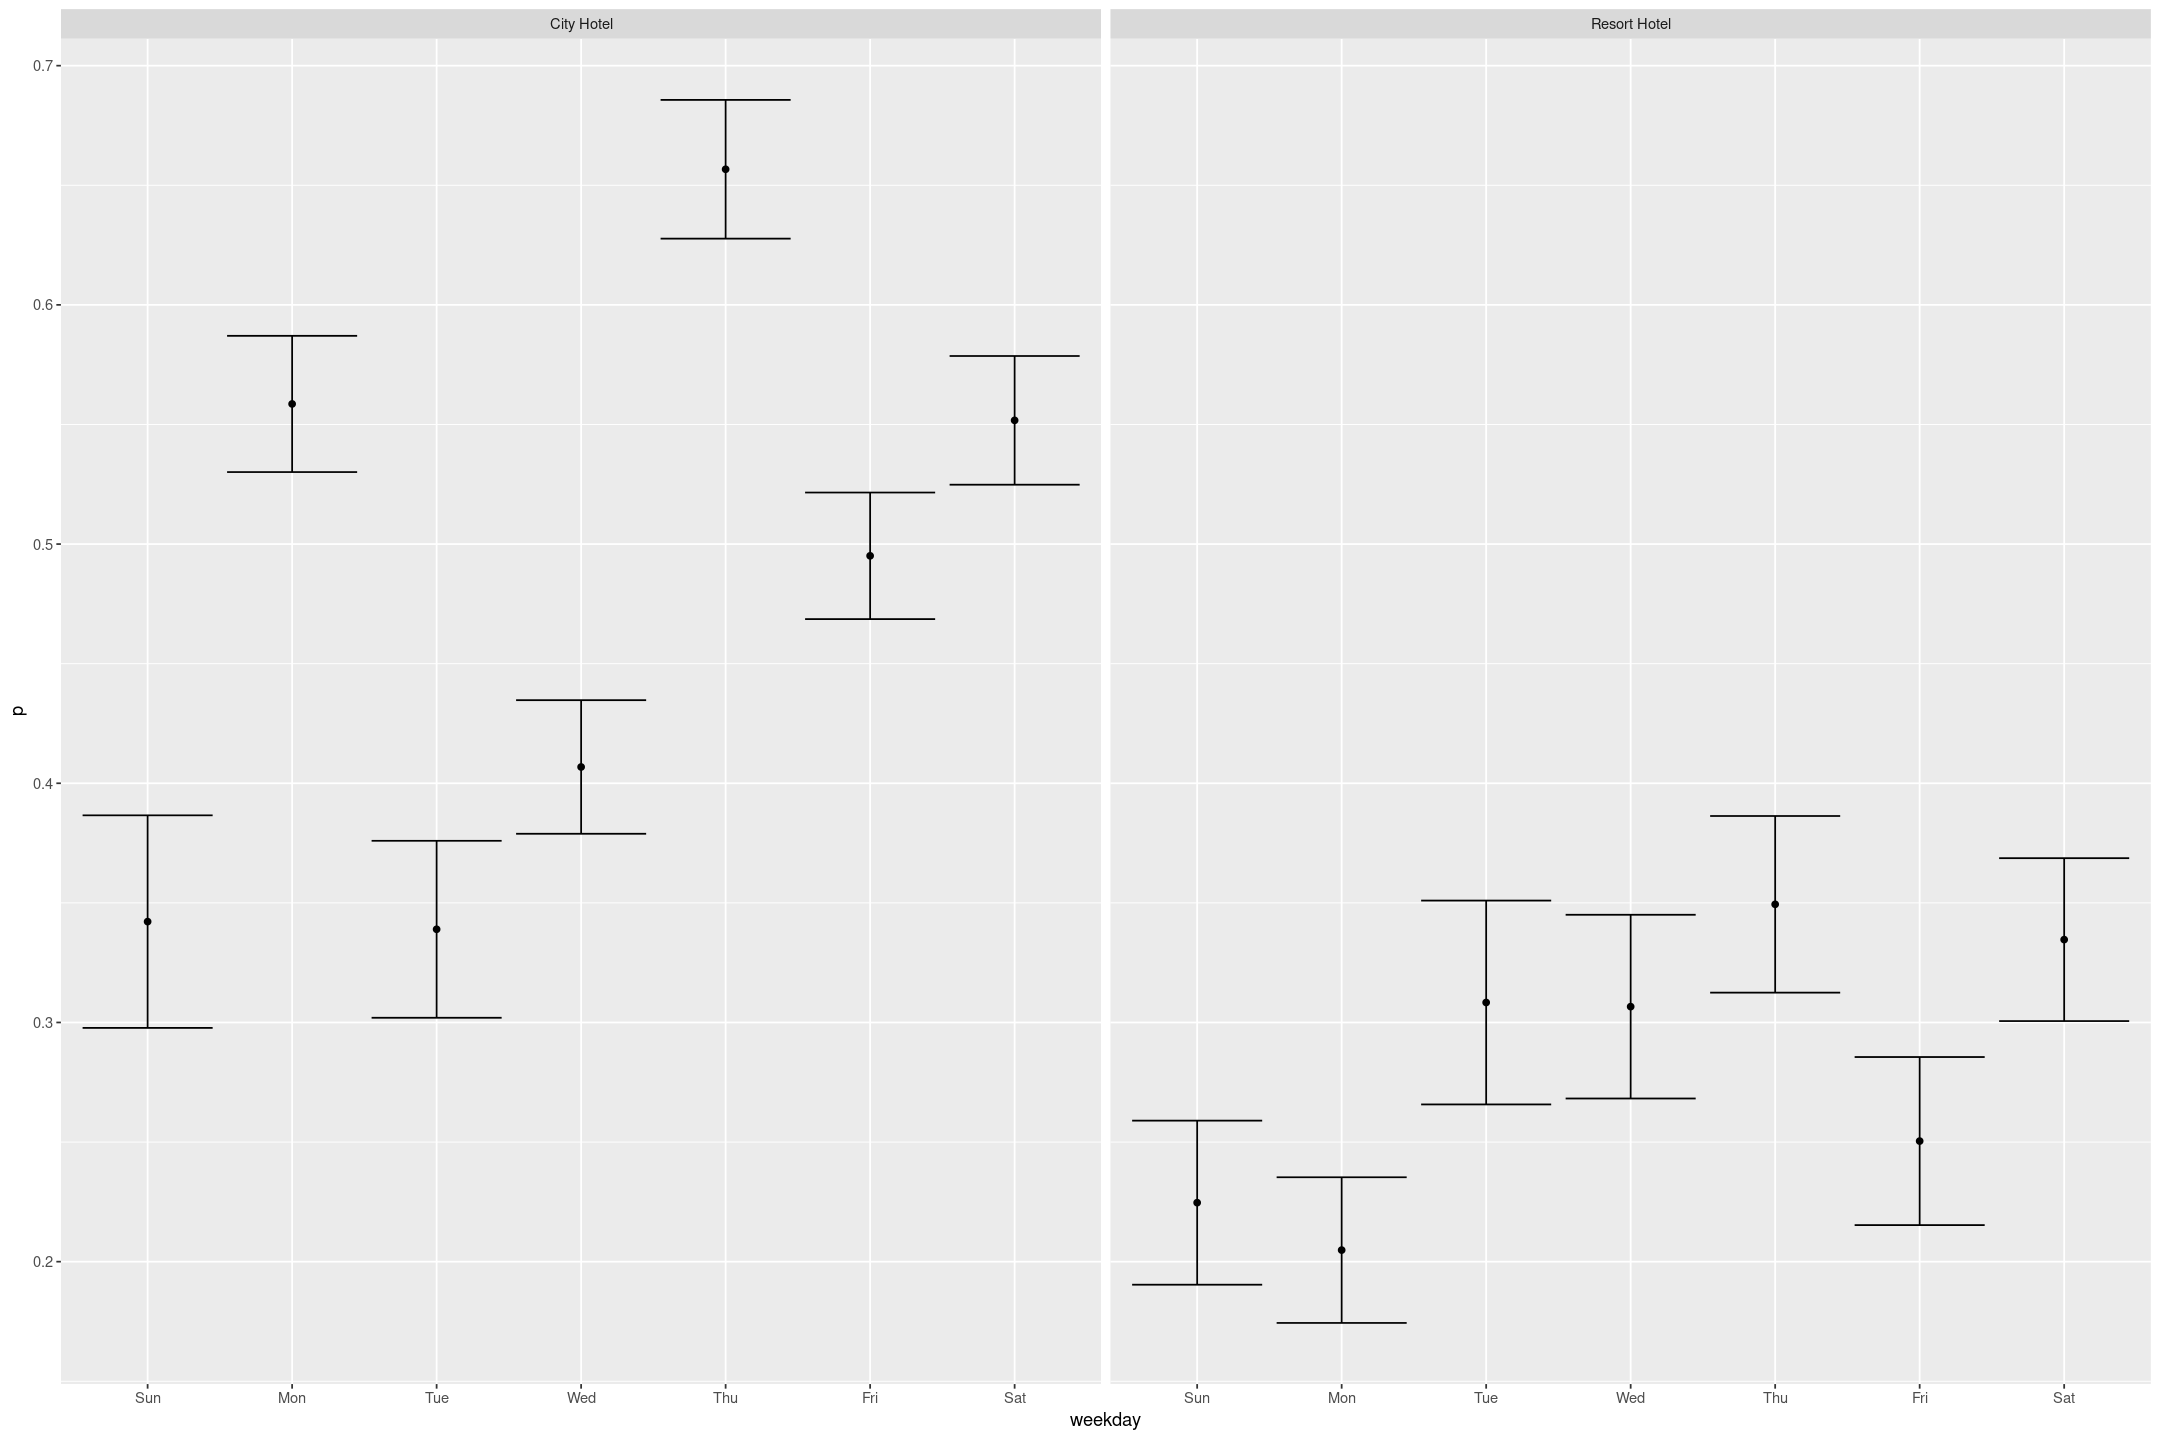

In [66]:
hotels_train %>% 
group_by(weekday=wday(arrival_date, label=TRUE), hotel) %>%
summarise(n=n(), p=mean(is_canceled)) %>%
mutate(phat = (p*n+2)/(n+4), se=sqrt(phat*(1-phat)/(n+4)), lower=p-2*se, upper=p+2*se) %>%
gf_point(p ~ weekday | hotel) %>%
gf_errorbar(ymin=~lower, ymax=~upper)

In [67]:
hotels <- hotels %>% mutate(arrival_weekday=wday(arrival_date, label=TRUE),
                            arrival_friday = arrival_weekday == 'Fri',
                            arrival_sunday = arrival_weekday == 'Sun',
                            arrival_saturday = arrival_weekday == 'Sat')

hotels_train <- hotels %>% filter(split=='train')

In [68]:
hotels_train %>% count(arrival_weekday, arrival_friday, arrival_saturday, arrival_sunday)

arrival_weekday,arrival_friday,arrival_saturday,arrival_sunday,n
<ord>,<lgl>,<lgl>,<lgl>,<int>
Sun,FALSE,FALSE,TRUE,1045
Mon,FALSE,FALSE,FALSE,1915
Tue,FALSE,FALSE,FALSE,1119
Wed,FALSE,FALSE,FALSE,1808
Thu,FALSE,FALSE,FALSE,1733
Fri,TRUE,FALSE,FALSE,2031
Sat,FALSE,TRUE,FALSE,2128


### Categorical Variables

#### Meal type

Bed and Breakfast, Full Breakfast, Half Breakfast, Undefined/SC = None

In [69]:
hotels_train %>% group_by(meal) %>% summarise(n=n(), p=mean(is_canceled)) %>% arrange(desc(n))

meal,n,p
<chr>,<int>,<dbl>
BB,8871,0.43659114
HB,2558,0.39053948
SC,212,0.08490566
FB,138,0.44202899


We can distinguish the ones that ordered a meal from those that didn't

In [70]:
hotels <- hotels %>% mutate(meal_ordered = meal %in% c('BB', 'HB', 'FB'))

hotels_train <- hotels %>% filter(split=='train')

In [71]:
hotels_train %>% count(meal_ordered, meal)

meal_ordered,meal,n
<lgl>,<chr>,<int>
FALSE,SC,212
TRUE,BB,8871
TRUE,FB,138
TRUE,HB,2558


#### Country

There's a lot of countries, but the behaviour of the Portugese, Britain/Ireland and Italy look markedly different.

Notice the `NULL` country we would probably like to impute.

In [72]:
install.packages('countrycode')

Installing countrycode [1.3.0] ...
	OK [linked cache]


In [73]:
hotels_train %>% group_by(country) %>% summarise(n=n(), p=mean(is_canceled)) %>% arrange(desc(n)) %>% head(20)

country,n,p
<chr>,<int>,<dbl>
PRT,7410,0.618758435
ESP,997,0.044132397
GBR,646,0.142414861
FRA,594,0.052188552
ITA,381,0.309711286
IRL,317,0.129337539
DEU,216,0.009259259
BEL,101,0.148514851
CN,97,0.000000000


Note for some reason China is using a 2 character ISO code...

Let's split this into 3 cases:

1. Portugal (local)
2. Europe
3. International

In [74]:
hotels <- hotels %>%
mutate(portugal = country == "PRT",
       other_europe = !portugal & coalesce(countrycode::countrycode(if_else(country == "CN", "CHN", country), "iso3c", "continent") == "Europe", FALSE))

hotels_train <- hotels %>% filter(split=='train')

Warning message in countrycode_convert(sourcevar = sourcevar, origin = origin, destination = dest, :
“Some values were not matched unambiguously: ATA, ATF, NULL, TMP, UMI
”


In [75]:
hotels_train %>% 
count(country, other_europe, portugal, sort=TRUE) %>%
head(20)

country,other_europe,portugal,n
<chr>,<lgl>,<lgl>,<int>
PRT,FALSE,TRUE,7410
ESP,TRUE,FALSE,997
GBR,TRUE,FALSE,646
FRA,TRUE,FALSE,594
ITA,TRUE,FALSE,381
IRL,TRUE,FALSE,317
DEU,TRUE,FALSE,216
BEL,TRUE,FALSE,101
CN,FALSE,FALSE,97


#### Market Segment

We can break the market segment into Travel Agent, Groups and Other

In [76]:
hotels_train %>% group_by(market_segment) %>% summarise(n=n(), p=mean(is_canceled)) %>% arrange(desc(n))

market_segment,n,p
<chr>,<int>,<dbl>
Groups,3771,0.69795810
Online TA,3371,0.29664788
Offline TA/TO,2989,0.34894614
Direct,1265,0.14703557
Corporate,316,0.27215190
Complementary,65,0.03076923
Undefined,2,1.00000000


In [77]:
hotels <- hotels %>%
mutate(group = market_segment == "Groups",
       travel_agent = market_segment %in% c('Online TA', 'Offline TA/TO'))

hotels_train <- hotels %>% filter(split=='train')

In [78]:
hotels_train %>%
count(market_segment, group, travel_agent)

market_segment,group,travel_agent,n
<chr>,<lgl>,<lgl>,<int>
Complementary,FALSE,FALSE,65
Corporate,FALSE,FALSE,316
Direct,FALSE,FALSE,1265
Groups,TRUE,FALSE,3771
Offline TA/TO,FALSE,TRUE,2989
Online TA,FALSE,TRUE,3371
Undefined,FALSE,FALSE,2


#### Distribution Channel

There is a lot of overlap between distribution channel and market segment - we won't make more variables from this

In [79]:
hotels_train %>%
count(market_segment, distribution_channel) %>% 
pivot_wider(names_from=distribution_channel, values_from= n, values_fill=0)

market_segment,Corporate,Direct,TA/TO,Undefined,GDS
<chr>,<int>,<int>,<int>,<int>,<int>
Complementary,5,52,8,0,0
Corporate,286,30,0,0,0
Direct,1,1238,24,2,0
Groups,185,21,3565,0,0
Offline TA/TO,0,3,2986,0,0
Online TA,0,15,3354,1,1
Undefined,0,0,0,2,0


#### Room type

In [80]:
hotels_train %>% 
group_by(reserved_room_type) %>% 
summarise(n=n(), p=mean(is_canceled))

reserved_room_type,n,p
<chr>,<int>,<dbl>
A,9516,0.4671080
B,71,0.2816901
C,134,0.2388060
D,1032,0.2015504
E,574,0.2456446
F,220,0.1727273
G,171,0.2807018
H,55,0.3090909
L,6,0.3333333


In [81]:
hotels_train %>% 
group_by(reserved_room_type != assigned_room_type) %>% 
summarise(n=n(), p=mean(is_canceled))

reserved_room_type != assigned_room_type,n,p
<lgl>,<int>,<dbl>
FALSE,9919,0.49309406
TRUE,1860,0.03225806


In [82]:
hotels <- hotels %>% mutate(reserved_room_a = reserved_room_type == 'A',
                            changed_room_type = reserved_room_type != assigned_room_type)

hotels_train <- hotels %>% filter(split=='train')

In [83]:
hotels_train %>%
group_by(reserved_room_type, assigned_room_type, reserved_room_a, changed_room_type) %>%
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n)) %>%
head(20)

`summarise()` has grouped output by 'reserved_room_type', 'assigned_room_type', 'reserved_room_a'. You can override using the `.groups` argument.



reserved_room_type,assigned_room_type,reserved_room_a,changed_room_type,n,p
<chr>,<chr>,<lgl>,<lgl>,<int>,<dbl>
A,A,TRUE,FALSE,7960,0.55213568
A,D,TRUE,TRUE,903,0.03211517
D,D,FALSE,FALSE,868,0.23617512
E,E,FALSE,FALSE,487,0.28131417
A,C,TRUE,TRUE,202,0.03960396
F,F,FALSE,FALSE,196,0.19387755
G,G,FALSE,FALSE,163,0.28834356
A,B,TRUE,TRUE,161,0.01242236
A,E,TRUE,TRUE,161,0.04347826


#### Deposit

It seems deeply suspicious that *everyone* with a non-refundable deposit cancelled.

I suspect this is some sort of data leakage, and will leave it alone.

In [84]:
hotels_train %>% 
group_by(deposit_type) %>% 
summarise(n=n(), p=mean(is_canceled))

deposit_type,n,p
<chr>,<int>,<dbl>
No Deposit,9765,0.3008705
Non Refund,2013,1.0000000
Refundable,1,0.0000000


#### Agent

Different agents have different rates, we could single out agent 1 which has a high rate, but it's pretty uninformative at this point.

In [85]:
hotels_train %>% 
group_by(agent) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n)) %>%
head(10)

agent,n,p
<chr>,<int>,<dbl>
1,3292,0.7105103
240,1539,0.3528265
NULL,1288,0.2507764
9,1166,0.2813036
6,768,0.5182292
250,321,0.1588785
17,237,0.4852321
241,224,0.1339286
20,168,0.5357143


#### Company

Quite sparse - leave it alone

In [86]:
hotels_train %>% 
group_by(company) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n)) %>%
head(10)

company,n,p
<chr>,<int>,<dbl>
NULL,11369,0.42264051
223,90,1.00000000
40,61,0.18032787
38,48,0.27083333
68,46,0.17391304
45,32,0.03125000
110,21,0.38095238
307,16,0.06250000
9,15,0.06666667


#### Customer type

Not super informative

In [87]:
hotels_train %>% 
group_by(customer_type) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n))

customer_type,n,p
<chr>,<int>,<dbl>
Transient,5753,0.3796280
Transient-Party,4390,0.4744875
Contract,1575,0.4253968
Group,61,0.2295082


### Numerical Variables

#### Days in waiting list

Too sparse to use

In [88]:
hotels_train %>% 
group_by(days_in_waiting_list) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n))

days_in_waiting_list,n,p
<dbl>,<int>,<dbl>
0,11679,0.42195393
33,29,0.00000000
21,22,1.00000000
77,19,0.05263158
38,8,0.00000000
48,8,0.00000000
65,7,0.00000000
80,7,0.00000000


#### Booking Changes

In [89]:
hotels_train %>% 
group_by(booking_changes) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n))

booking_changes,n,p
<dbl>,<int>,<dbl>
0,10295,0.46391452
1,1199,0.13094245
2,213,0.06103286
3,43,0.11627907
4,15,0.00000000
5,9,0.00000000
7,2,0.00000000
11,1,0.00000000
17,1,0.00000000


In [90]:
hotels <- hotels %>% mutate(has_booking_change = booking_changes > 0)

hotels_train <- hotels %>% filter(split=='train')

In [91]:
hotels_train %>% count(booking_changes, has_booking_change)

booking_changes,has_booking_change,n
<dbl>,<lgl>,<int>
0,FALSE,10295
1,TRUE,1199
2,TRUE,213
3,TRUE,43
4,TRUE,15
5,TRUE,9
7,TRUE,2
11,TRUE,1
17,TRUE,1


### Previous cancellations

In [92]:
hotels_train %>% 
group_by(previous_cancellations) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n))

previous_cancellations,n,p
<dbl>,<int>,<dbl>
0,8975,0.2398886
1,2675,0.9977570
24,48,1.0000000
25,25,1.0000000
19,19,1.0000000
2,14,1.0000000
14,14,1.0000000
3,8,1.0000000
21,1,1.0000000


In [93]:
hotels <- hotels %>% mutate(has_previous_cancellation = previous_cancellations > 0)

hotels_train <- hotels %>% filter(split=='train')

In [94]:
hotels_train %>% count(has_previous_cancellation, previous_cancellations)

has_previous_cancellation,previous_cancellations,n
<lgl>,<dbl>,<int>
FALSE,0,8975
TRUE,1,2675
TRUE,2,14
TRUE,3,8
TRUE,14,14
TRUE,19,19
TRUE,21,1
TRUE,24,48
TRUE,25,25


#### Previous Bookings Not Cancelled

It's too sparse - they don't do a lot of return business!

In [95]:
hotels_train %>% 
group_by(previous_bookings_not_canceled) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n))

previous_bookings_not_canceled,n,p
<dbl>,<int>,<dbl>
0,11706,0.42209124
1,41,0.07317073
2,19,0.21052632
3,6,0.50000000
4,4,0.00000000
5,2,0.00000000
6,1,0.00000000


#### Nights stayed

In [96]:
hotels_train %>% 
group_by(stays_in_weekend_nights) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n))

stays_in_weekend_nights,n,p
<dbl>,<int>,<dbl>
0,4899,0.4521331
2,3874,0.3951988
1,2565,0.4307992
4,252,0.1865079
3,173,0.2601156
5,6,0.8333333
6,4,0.5000000
8,2,0.5000000
7,1,0.0000000


In [97]:
hotels_train %>% 
group_by(stays_in_week_nights) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n))

stays_in_week_nights,n,p
<dbl>,<int>,<dbl>
2,4039,0.51646447
1,2782,0.47196262
3,1560,0.34871795
5,1333,0.31657914
4,864,0.36921296
0,525,0.21142857
6,229,0.31877729
7,162,0.16666667
10,143,0.19580420


Combining them seems to be most useful

In [98]:
hotels_train %>% 
group_by(stays_nights = stays_in_week_nights + stays_in_weekend_nights) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n))

stays_nights,n,p
<dbl>,<int>,<dbl>
2,3957,0.5597675
3,1726,0.4015064
4,1539,0.4385965
1,1409,0.2817601
7,1057,0.3046358
5,790,0.3468354
6,520,0.3942308
10,185,0.2054054
8,176,0.3125000


In [99]:
hotels <- hotels %>% 
mutate(stays_nights = stays_in_week_nights + stays_in_weekend_nights,
       stays_1_night = stays_nights == 1,
       stays_more_4_nights = stays_nights > 4)

hotels_train <- hotels %>% filter(split == 'train')

In [100]:
hotels_train %>% 
group_by(stays_in_week_nights, stays_in_weekend_nights, stays_nights, stays_1_night, stays_more_4_nights) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n)) %>%
head(10)

`summarise()` has grouped output by 'stays_in_week_nights', 'stays_in_weekend_nights', 'stays_nights', 'stays_1_night'. You can override using the `.groups` argument.



stays_in_week_nights,stays_in_weekend_nights,stays_nights,stays_1_night,stays_more_4_nights,n,p
<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>
2,0,2,FALSE,FALSE,2731,0.5576712
1,0,1,TRUE,FALSE,1118,0.3041145
5,2,7,FALSE,TRUE,1057,0.3046358
1,1,2,FALSE,FALSE,1043,0.6116970
2,2,4,FALSE,FALSE,832,0.4963942
3,0,3,FALSE,FALSE,629,0.3306836
1,2,3,FALSE,FALSE,621,0.5394525
3,2,5,FALSE,TRUE,518,0.3667954
2,1,3,FALSE,FALSE,476,0.3151261


#### People

Oddly there are some rows with no children or babies...

In [101]:
hotels_train %>% 
group_by(adults, children, babies) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n)) %>%
head(10)

`summarise()` has grouped output by 'adults', 'children'. You can override using the `.groups` argument.



adults,children,babies,n,p
<dbl>,<dbl>,<dbl>,<int>,<dbl>
2,0,0,9222,0.47158968
1,0,0,1561,0.25368354
3,0,0,280,0.16071429
2,2,0,262,0.29007634
2,1,0,255,0.15686275
2,0,1,102,0.18627451
2,1,1,14,0.14285714
0,0,0,13,0.07692308
1,2,0,13,0.15384615


In [102]:
hotels <- hotels %>%
mutate(has_children_babies = coalesce(children + babies > 0, FALSE),
       is_couple = coalesce(!has_children_babies & adults == 2, FALSE))

hotels_train <- hotels %>% filter(split=='train')

In [103]:
hotels_train %>% 
group_by(adults, children, babies, has_children_babies, is_couple) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n)) %>%
head(10)

`summarise()` has grouped output by 'adults', 'children', 'babies', 'has_children_babies'. You can override using the `.groups` argument.



adults,children,babies,has_children_babies,is_couple,n,p
<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>
2,0,0,FALSE,TRUE,9222,0.47158968
1,0,0,FALSE,FALSE,1561,0.25368354
3,0,0,FALSE,FALSE,280,0.16071429
2,2,0,TRUE,FALSE,262,0.29007634
2,1,0,TRUE,FALSE,255,0.15686275
2,0,1,TRUE,FALSE,102,0.18627451
2,1,1,TRUE,FALSE,14,0.14285714
0,0,0,FALSE,FALSE,13,0.07692308
1,2,0,TRUE,FALSE,13,0.15384615


#### Average Daily Rate

Curious that some stays are free?

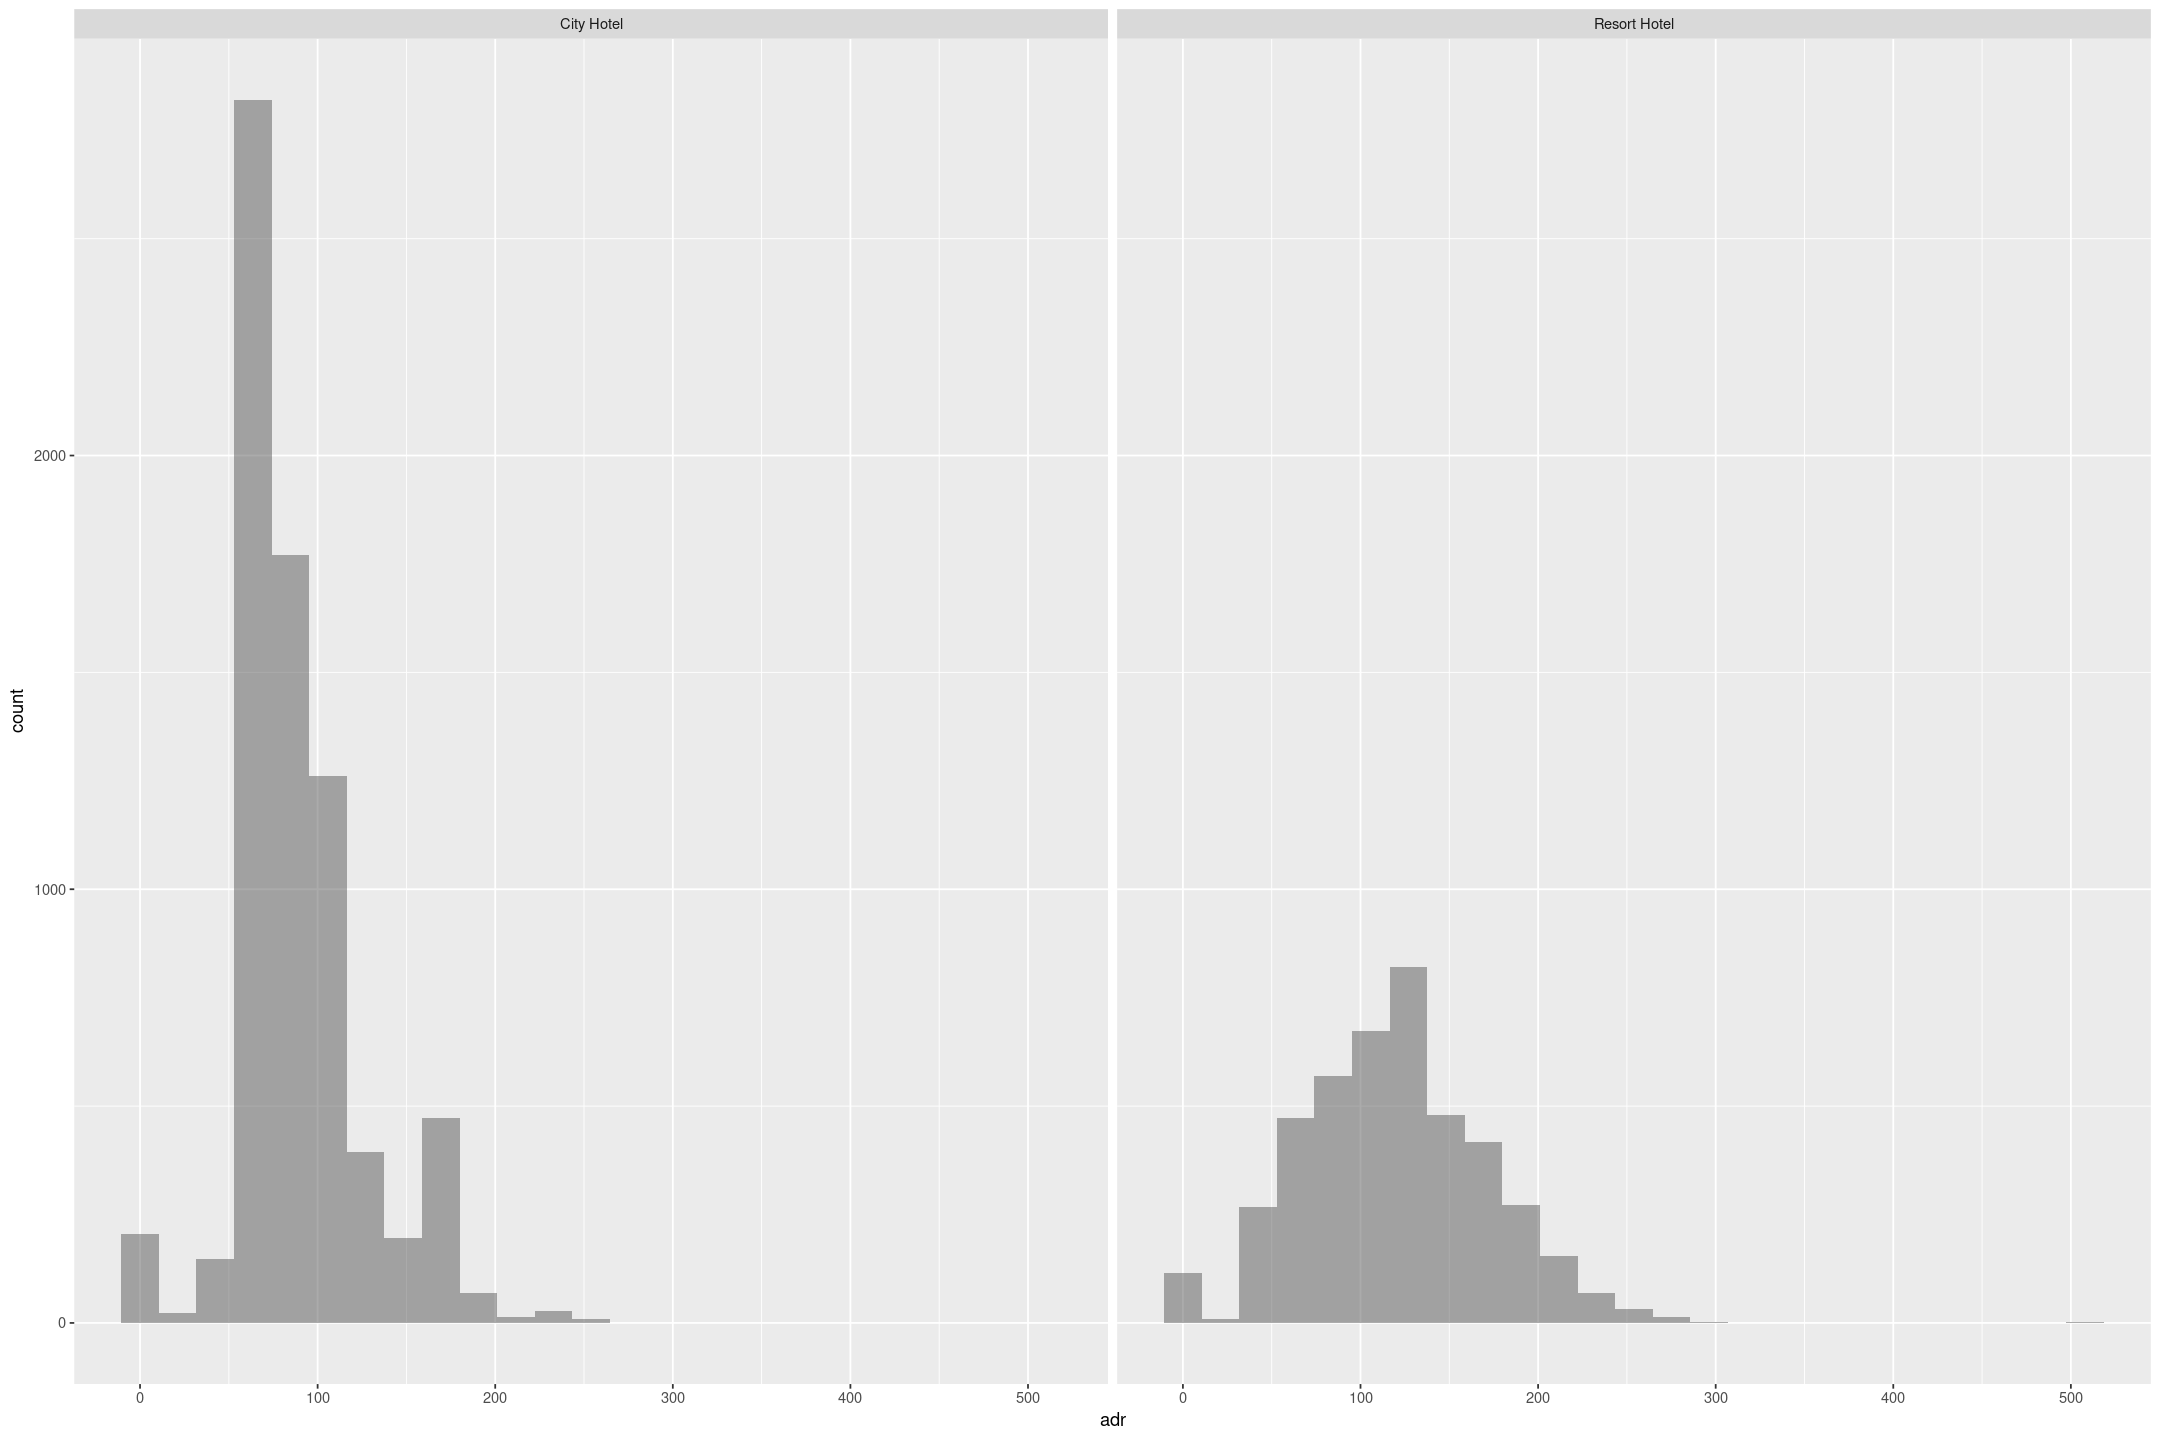

In [104]:
hotels_train %>%
gf_histogram(~adr | hotel)

I can't see any clear pattern with price

In [105]:
n_bin = 50

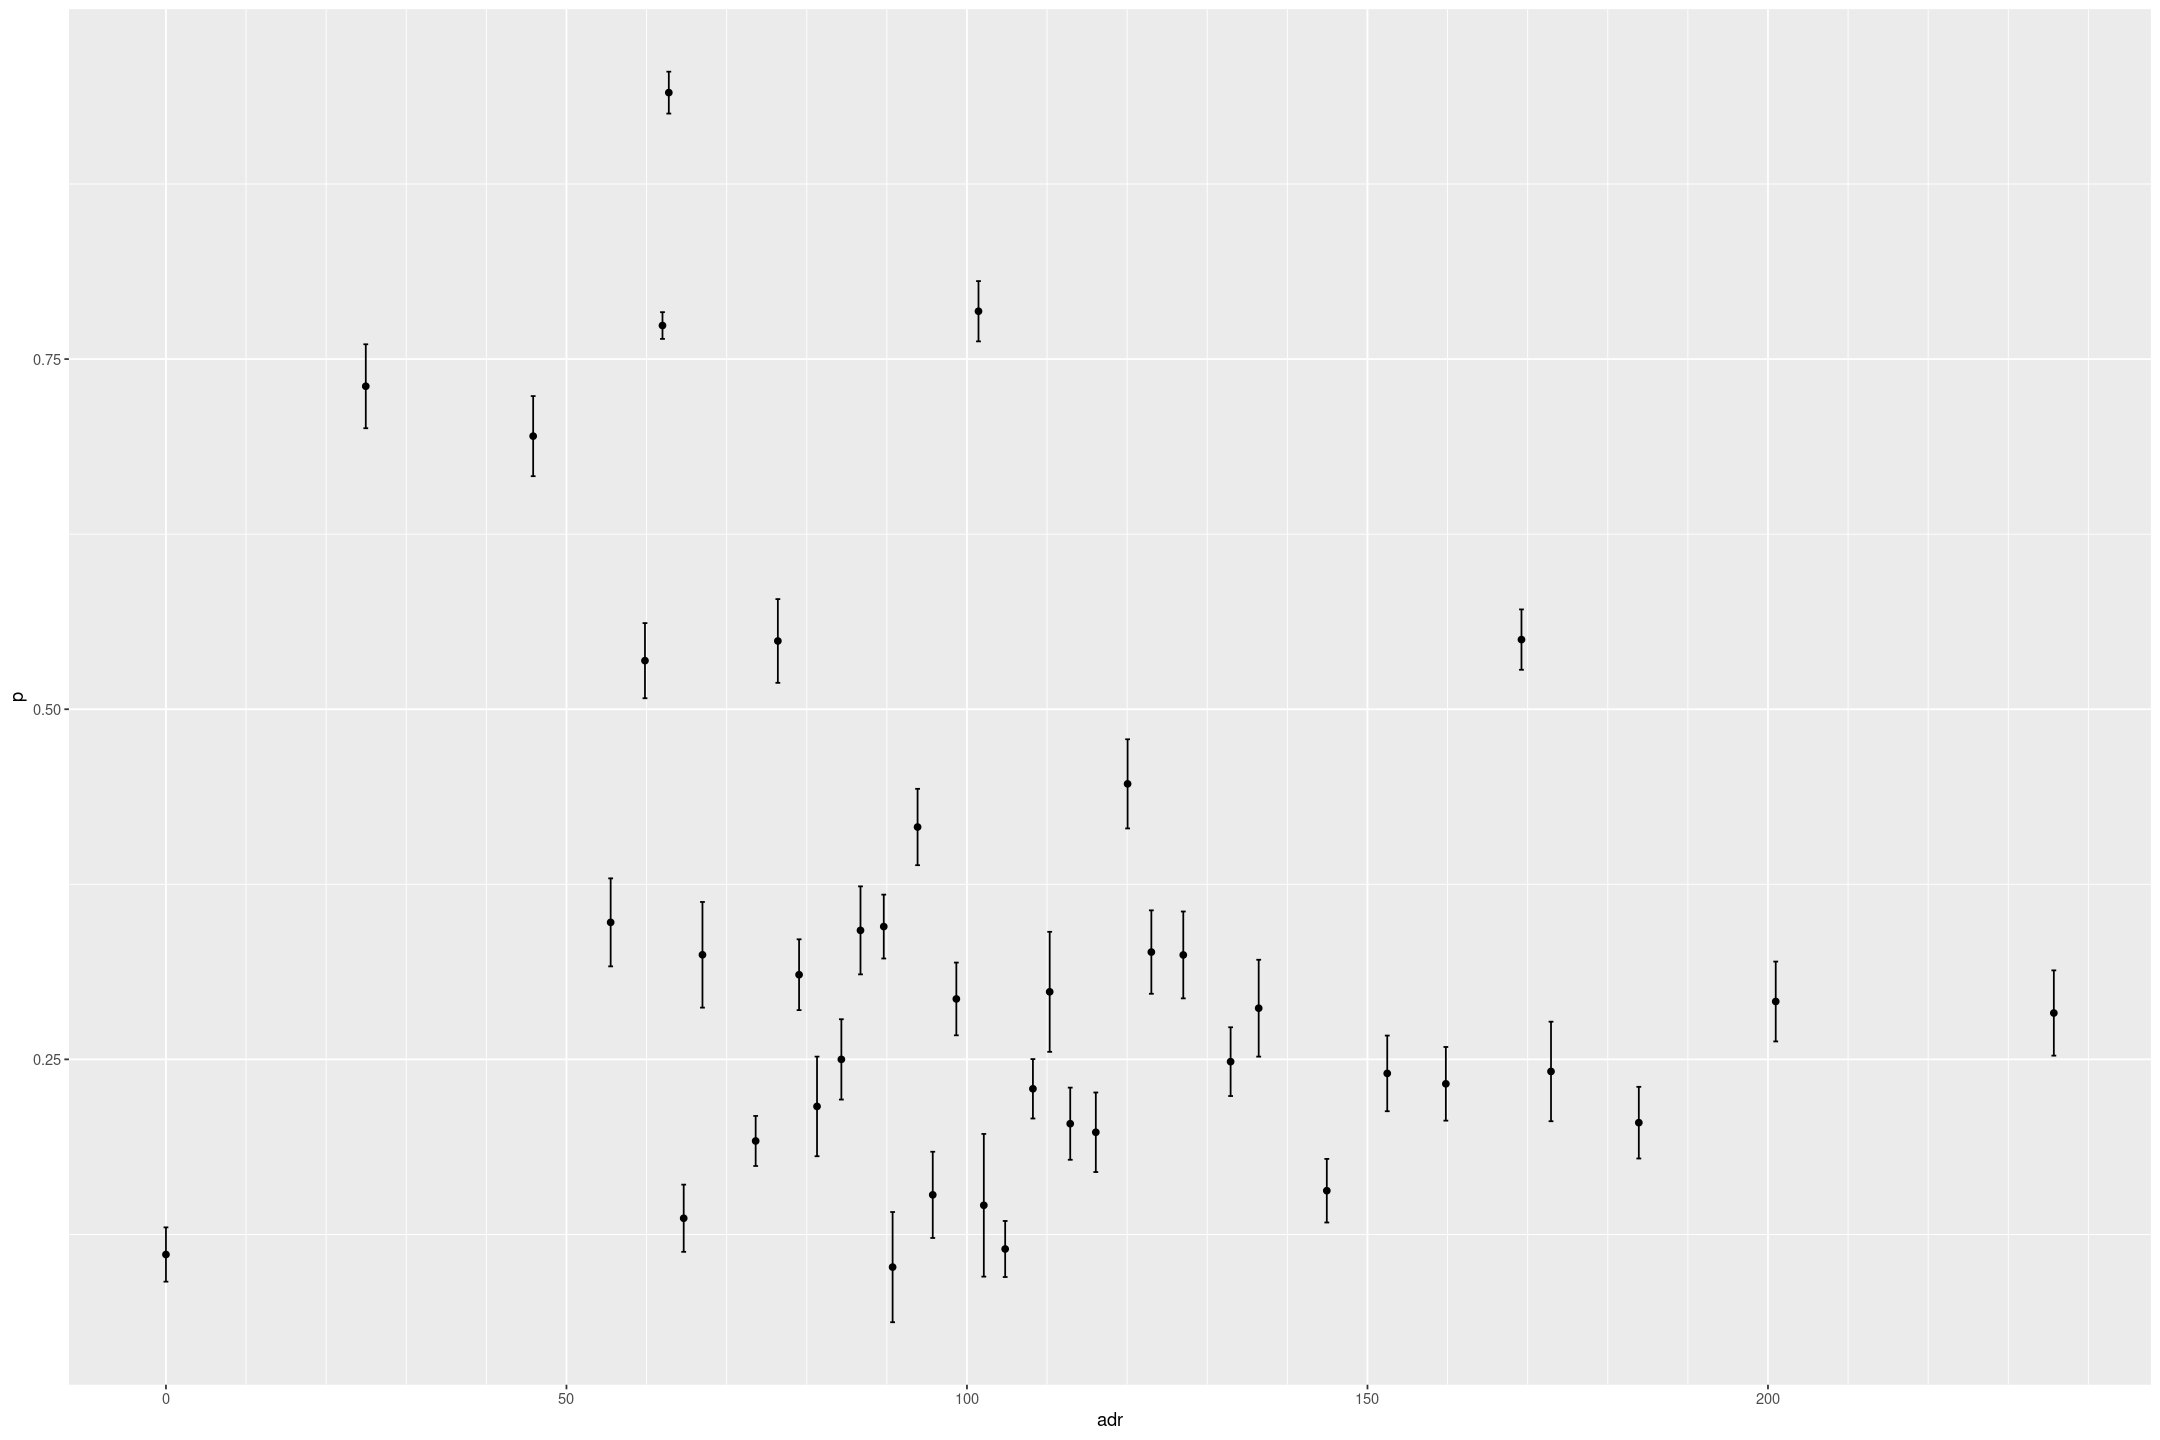

In [106]:
hotels_train %>%
mutate(bin=cut(adr, unique(quantile(adr, seq(0, 1, length.out=n_bin)), include.lowest=TRUE))) %>%
group_by(bin) %>%
summarise(n=n(), adr=mean(adr), p=mean(is_canceled)) %>%
mutate(se=sqrt(p*(1-p)/n), lower=p-se, upper=p+se) %>%
gf_point(p ~ adr) %>%
gf_errorbar(ymin=~lower, ymax=~upper) +
scale_x_continuous(minor_breaks=seq(0, 500, by=10), breaks=seq(0, 500, by=50))

#### Car spaces

It seems suspicious again that this is a perfect predictor - maybe this is only populated for non-cancellations?

Because this perfectly separates the data there will be problems trying to estimate it.

In [107]:
hotels_train %>% 
group_by(required_car_parking_spaces) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n)) %>%
head(10)

required_car_parking_spaces,n,p
<dbl>,<int>,<dbl>
0,11103,0.4459155
1,673,0.0000000
2,3,0.0000000


In [108]:
hotels <- hotels %>% mutate(requires_car_park = required_car_parking_spaces > 0)

hotels_train <- hotels %>% filter(split=='train')

In [109]:
hotels_train %>% 
group_by(required_car_parking_spaces, requires_car_park) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n)) %>%
head(10)

`summarise()` has grouped output by 'required_car_parking_spaces'. You can override using the `.groups` argument.



required_car_parking_spaces,requires_car_park,n,p
<dbl>,<lgl>,<int>,<dbl>
0,FALSE,11103,0.4459155
1,TRUE,673,0.0000000
2,TRUE,3,0.0000000


#### Special Requests

Any special requests makes it less likely to be cancelled

In [110]:
hotels_train %>% 
group_by(total_of_special_requests) %>% 
summarise(n=n(), p=mean(is_canceled)) %>%
arrange(desc(n)) %>%
head(10)

total_of_special_requests,n,p
<dbl>,<int>,<dbl>
0,8189,0.5053120
1,2165,0.2318707
2,1177,0.2302464
3,229,0.1659389
4,18,0.1111111
5,1,0.0000000


In [111]:
hotels <- hotels %>% mutate(has_special_request = total_of_special_requests > 0)

hotels_train <- hotels %>% filter(split=="train")

### Fitting a model

Let's create a dataframe containing all our predictors, and standardising our only numeric predictor, lead time.

In [112]:
standardise <- function(x) { (x - mean(x)) / (2 *sd(x))}

In [113]:
hotels <- hotels %>% mutate(lead_time_std = standardise(lead_time),
                            log_lead_time_std = standardise(log(lead_time + 1)))

hotels_train <- hotels %>% filter(split == 'train')

In [114]:
start_time <- Sys.time()
fit_hotel <- stan_glm(is_canceled ~ hotel + lead_time_std + arrival_friday + arrival_saturday + arrival_sunday +
                                    portugal + other_europe + stays_1_night + stays_more_4_nights +
                                    has_children_babies + is_couple +
                                    has_previous_cancellation + reserved_room_a +
                                    changed_room_type + has_booking_change + has_special_request,
                      data=hotels_train, family=binomial(link="logit"), QR=TRUE, refresh=0)
end_time <- Sys.time()

end_time - start_time

Time difference of 35.82971 secs

In [115]:
fit_hotel

stan_glm
 family:       binomial [logit]
 formula:      is_canceled ~ hotel + lead_time_std + arrival_friday + arrival_saturday + 
	   arrival_sunday + portugal + other_europe + stays_1_night + 
	   stays_more_4_nights + has_children_babies + is_couple + has_previous_cancellation + 
	   reserved_room_a + changed_room_type + has_booking_change + 
	   has_special_request
 observations: 11779
 predictors:   17
------
                              Median MAD_SD
(Intercept)                   -4.7    0.4  
hotelResort Hotel             -0.2    0.1  
lead_time_std                 -0.4    0.1  
arrival_fridayTRUE             0.2    0.1  
arrival_saturdayTRUE           0.5    0.1  
arrival_sundayTRUE             0.3    0.1  
portugalTRUE                   4.2    0.4  
other_europeTRUE               1.6    0.4  
stays_1_nightTRUE             -0.8    0.1  
stays_more_4_nightsTRUE       -0.2    0.1  
has_children_babiesTRUE        0.4    0.2  
is_coupleTRUE                  0.6    0.1  
has_previo

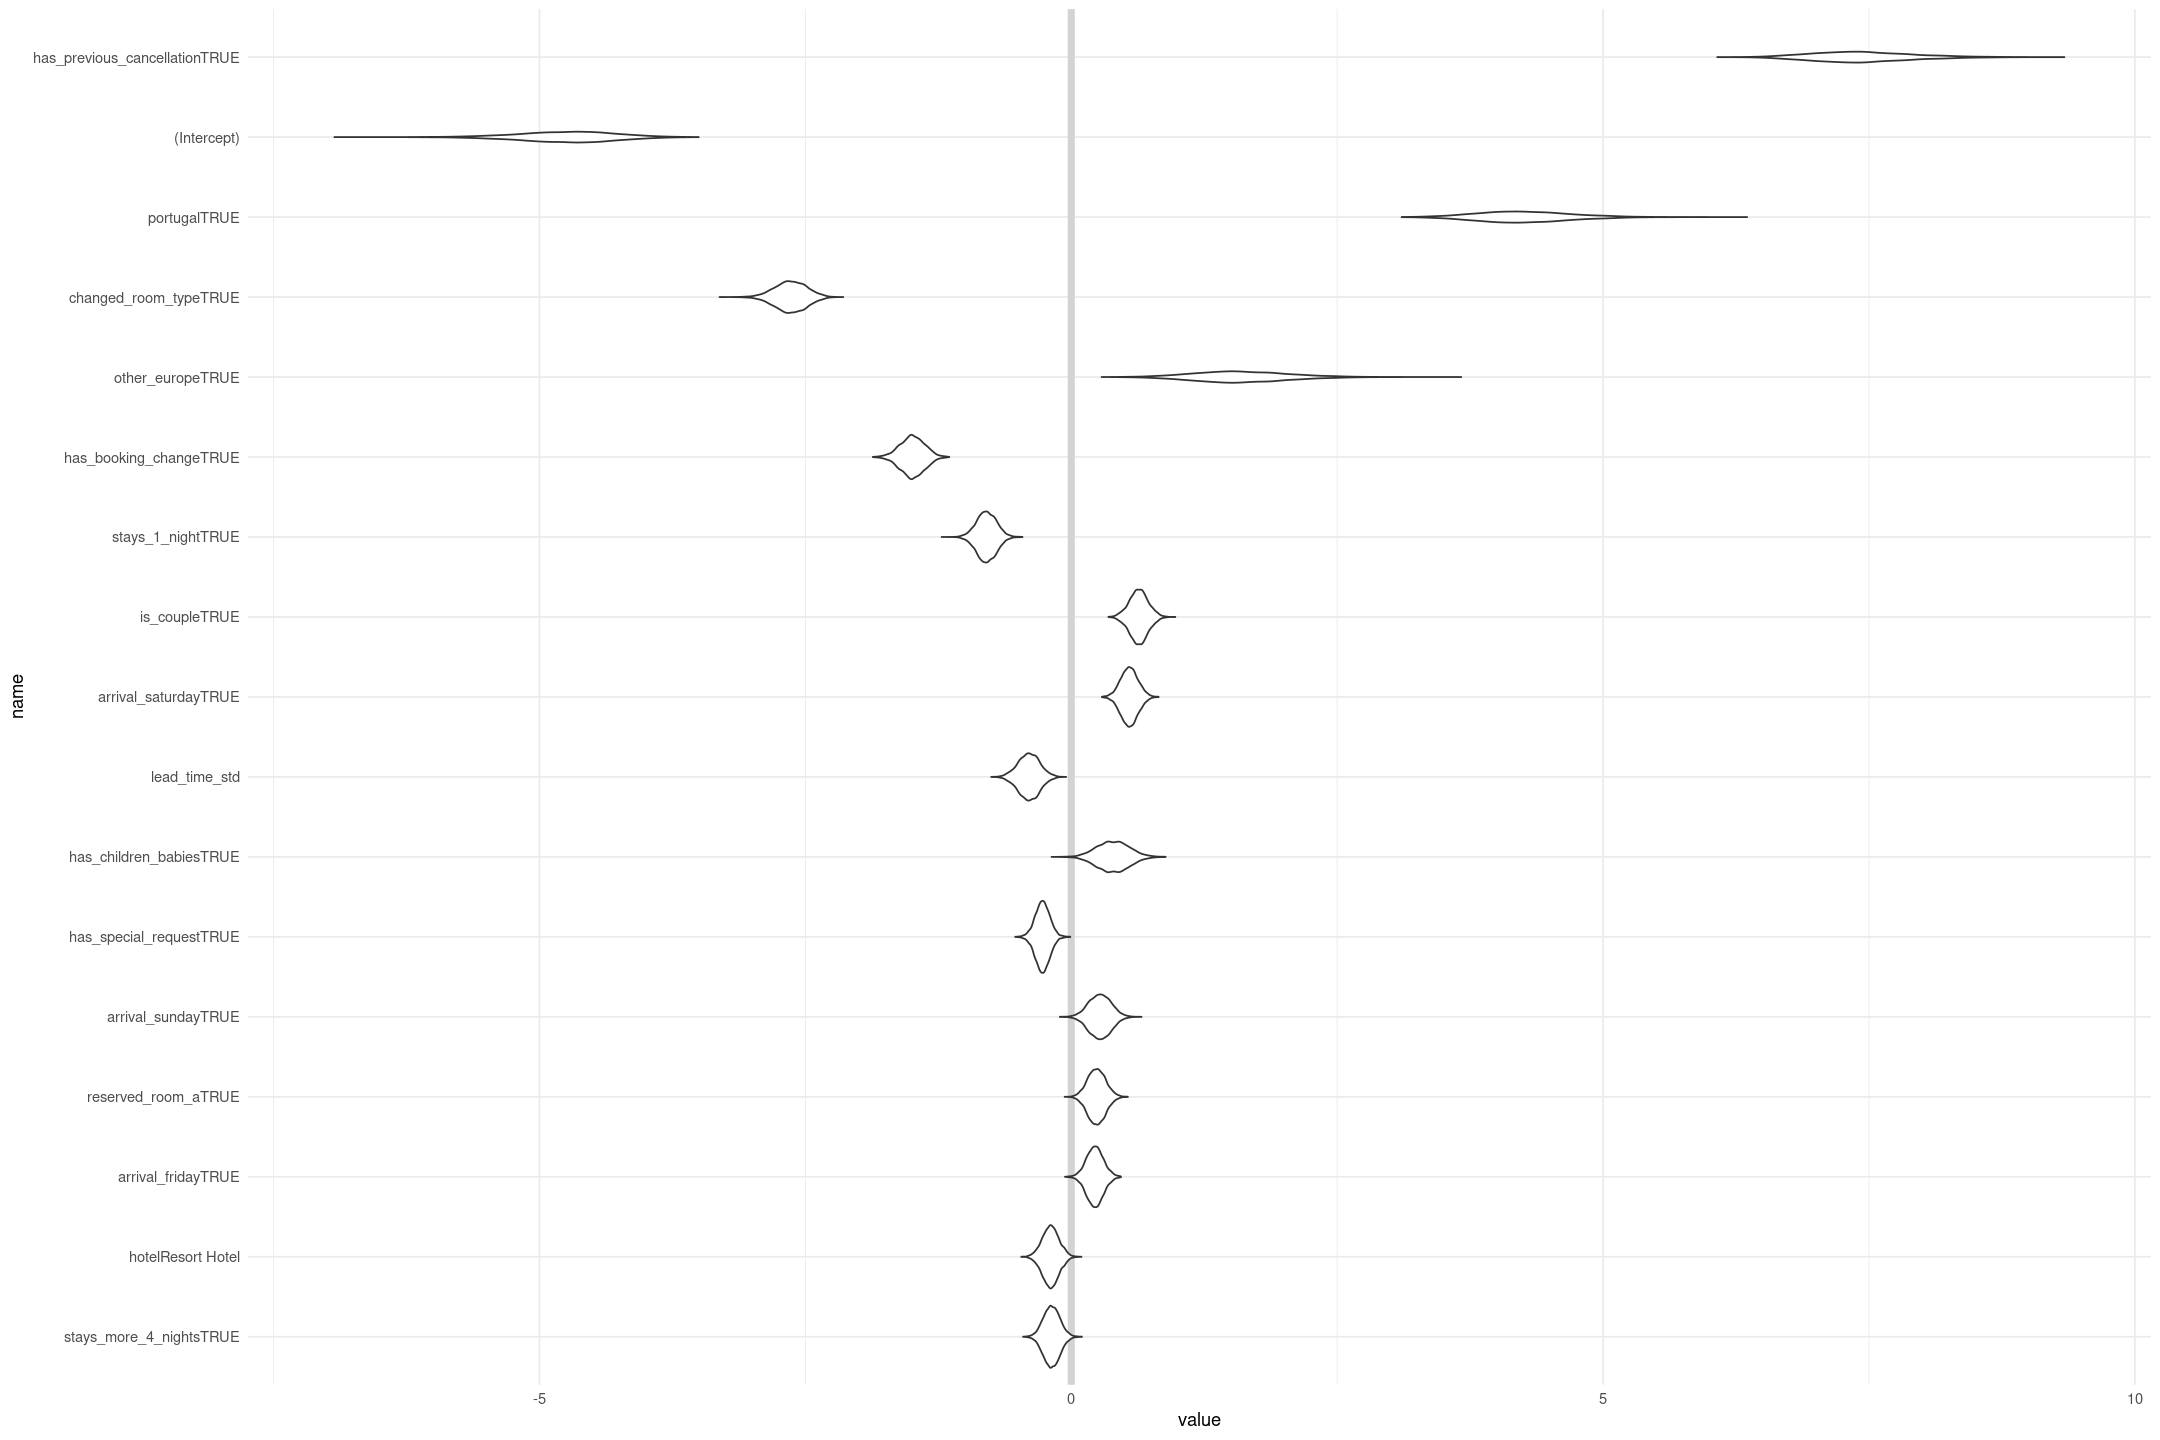

In [116]:
fit_hotel %>%
as.data.frame() %>%
pivot_longer(everything()) %>%
mutate(name=forcats::fct_reorder(name, value, .fun= function(x) abs(median(x)))) %>%
gf_hline(yintercept=~0, colour="lightgrey", size=2) %>%
gf_violin(value ~ name) +
coord_flip() +
theme_minimal()

## Fitting many models

Fit several different versions of your model.
Try including different predictors, interactions and transformations of the inputs.

### Log Transforming Lead time

Let's try log transforming lead_time

In [117]:
start_time <- Sys.time()
fit_hotel_log_lead <- stan_glm(is_canceled ~ hotel + log_lead_time_std + arrival_friday + arrival_saturday + arrival_sunday +
                                    portugal + other_europe + stays_1_night + stays_more_4_nights +
                                    has_children_babies + is_couple +
                                    has_previous_cancellation + reserved_room_a +
                                    changed_room_type + has_booking_change + has_special_request,
                      data=hotels_train, family=binomial(link="logit"), QR=TRUE, refresh=0)
end_time <- Sys.time()

end_time - start_time

Time difference of 39.62763 secs

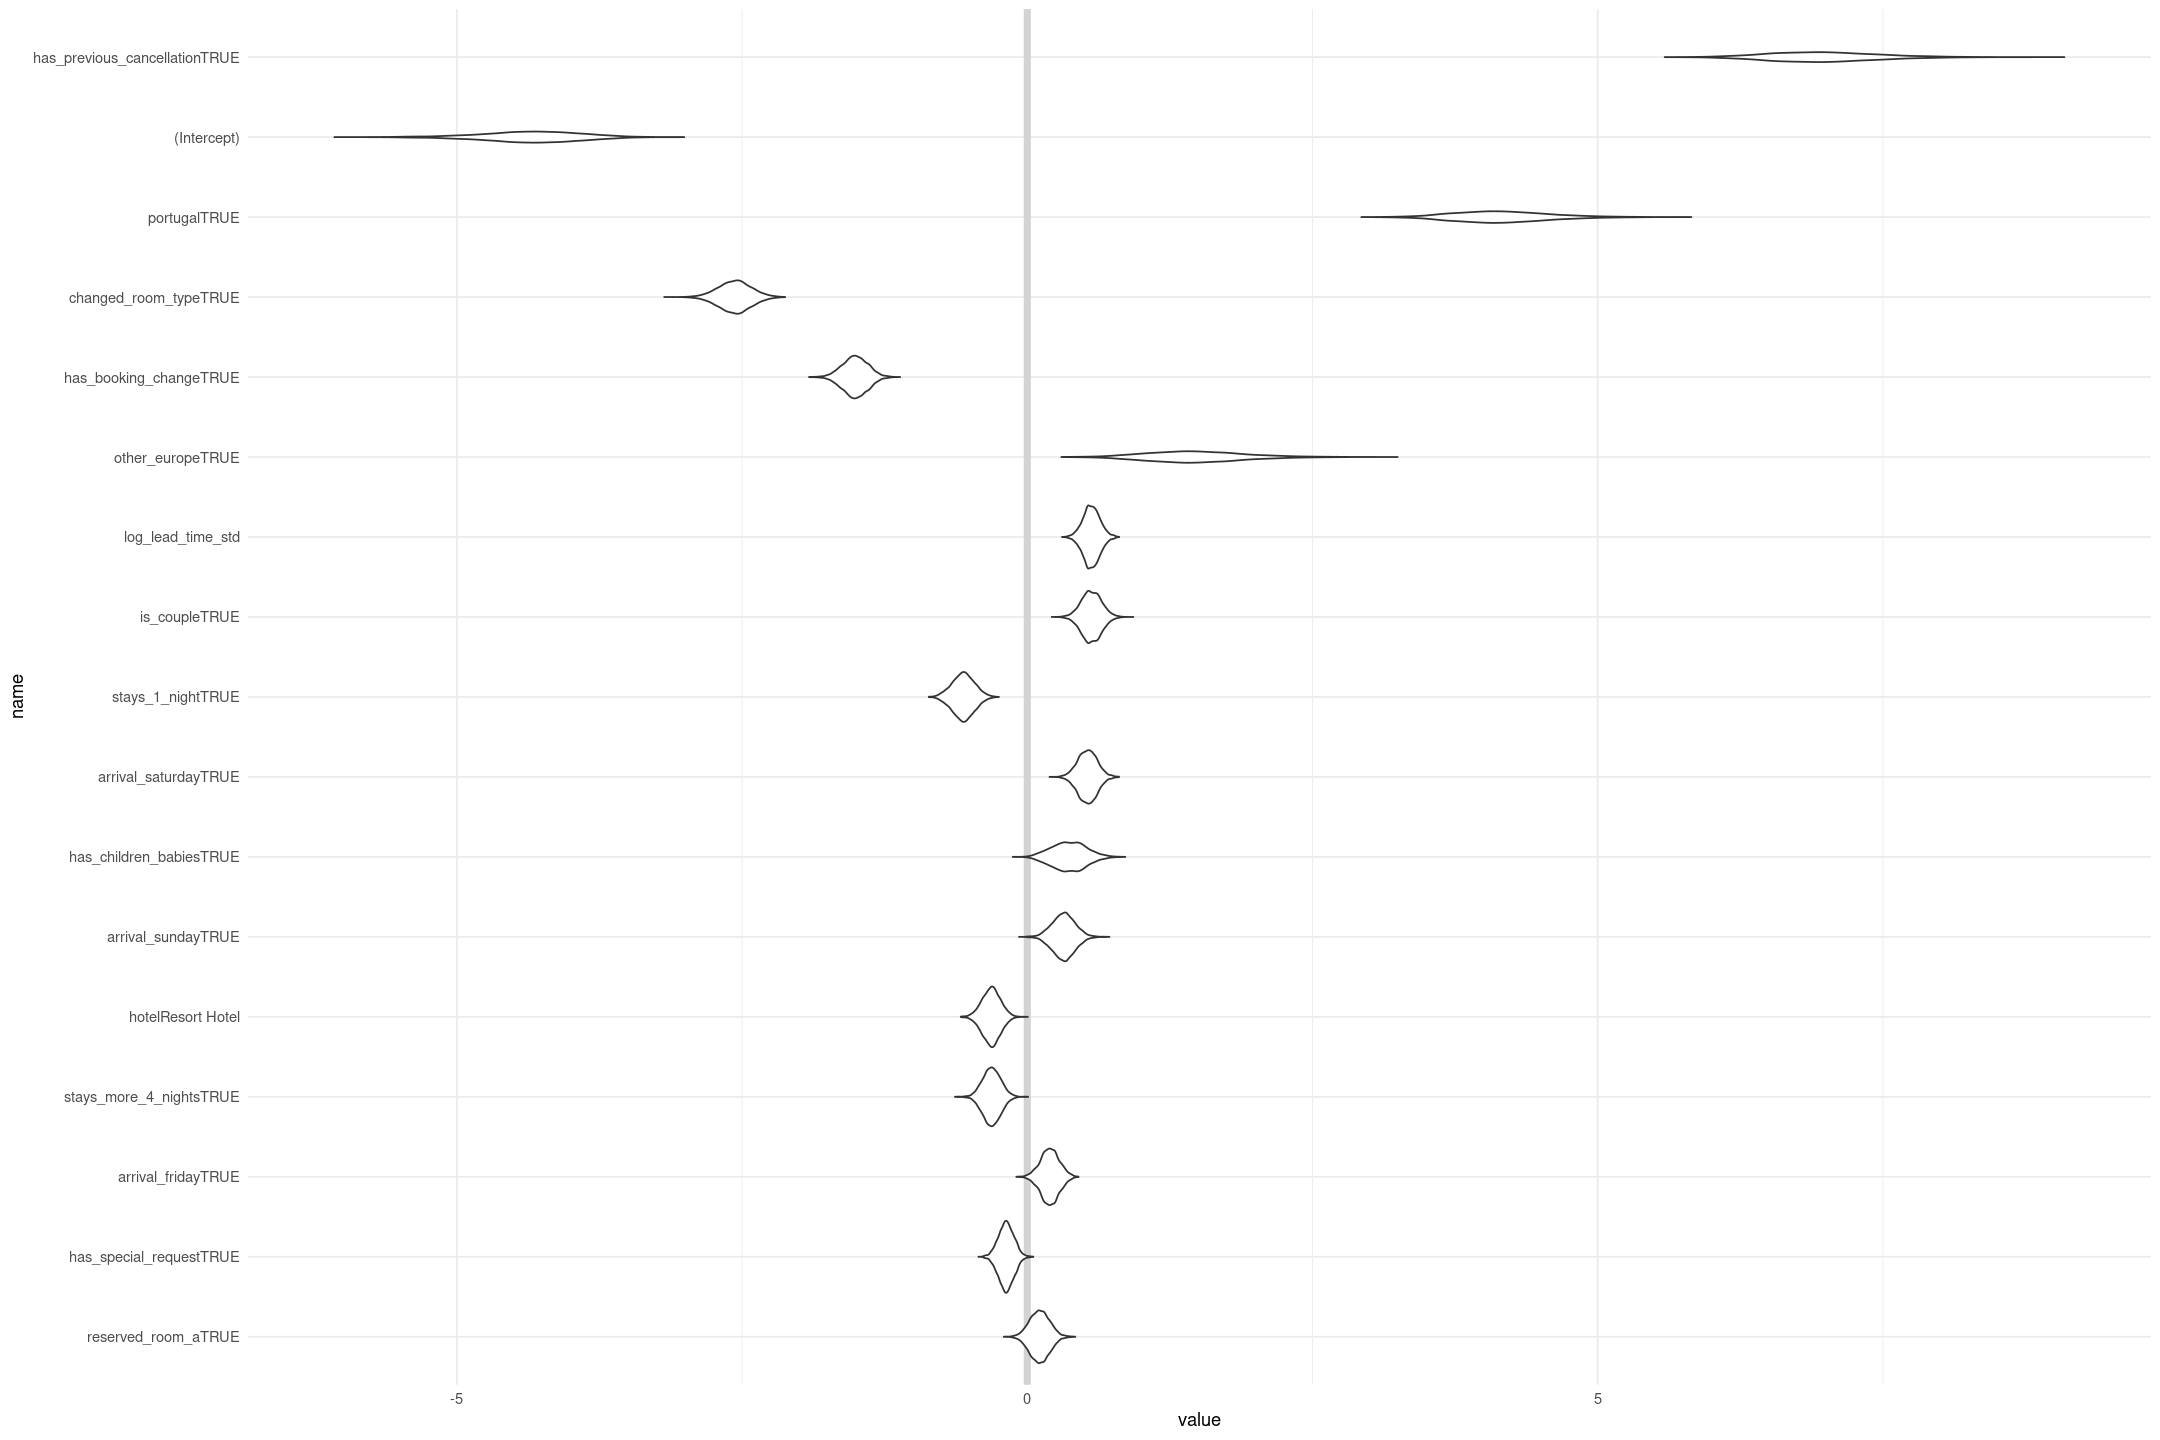

In [118]:
fit_hotel_log_lead %>%
as.data.frame() %>%
pivot_longer(everything()) %>%
mutate(name=forcats::fct_reorder(name, value, .fun= function(x) abs(median(x)))) %>%
gf_hline(yintercept=~0, colour="lightgrey", size=2) %>%
gf_violin(value ~ name) +
coord_flip() +
theme_minimal()

#### Evaluating

Instead of doing a LOO comparison let's evaluate on our dataset

In [119]:
hotels_valid <- hotels %>% filter(split=="valid")

We obviously expect it to do quite well on the training data

In [120]:
hotels_train %>%
mutate(pred = predict(fit_hotel, newdata=., type="response")) %>%
summarise(log_score = mean(is_canceled * pred + (1 - is_canceled) * (1 - pred)), 
          accuracy = mean((pred > 0.5) == is_canceled))

log_score,accuracy
<dbl>,<dbl>
0.8100247,0.8443841


It still does pretty well on the validation data! We haven't overfit here

In [121]:
hotels_valid %>%
mutate(pred = predict(fit_hotel, newdata=., type="response")) %>%
summarise(log_score = mean(is_canceled * pred + (1 - is_canceled) * (1 - pred)), 
          accuracy = mean((pred > 0.5) == is_canceled))

log_score,accuracy
<dbl>,<dbl>
0.8065325,0.8424195


And, as expected the log lead time does a little better

In [122]:
hotels_valid %>%
mutate(pred = predict(fit_hotel_log_lead, newdata=., type="response")) %>%
summarise(log_score = mean(is_canceled * pred + (1 - is_canceled) * (1 - pred)), 
          accuracy = mean((pred > 0.5) == is_canceled))

log_score,accuracy
<dbl>,<dbl>
0.8171304,0.8714887


The LOO log score tells a similar story, though the SE is useful for showing the improvement isn't *that* big.

In [123]:
loo_hotel_log_lead <- loo(fit_hotel_log_lead)
loo_hotel <- loo(fit_hotel)

loo_compare(loo_hotel_log_lead, loo_hotel)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fit_hotel_log_lead,0.00000,0.00000,-3436.469,54.96903,17.22478,0.7935606,6872.938,109.9381
fit_hotel,-20.98704,11.19318,-3457.456,55.31166,17.67889,0.8358922,6914.912,110.6233


### Adding interactions

Let's look at interactions for the most impactful variables

#### Categorical interactions

For categorical variables we can manually inspect interactions

In [124]:
hotels_train %>% 
group_by(has_previous_cancellation, portugal) %>% 
summarise(n=n(), p=mean(is_canceled))

`summarise()` has grouped output by 'has_previous_cancellation'. You can override using the `.groups` argument.



has_previous_cancellation,portugal,n,p
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,4203,0.04829883
FALSE,TRUE,4772,0.40863370
TRUE,FALSE,166,0.98192771
TRUE,TRUE,2638,0.99886277


In [125]:
hotels_train %>% 
group_by(changed_room_type, portugal) %>% 
summarise(n=n(), p=mean(is_canceled))

`summarise()` has grouped output by 'changed_room_type'. You can override using the `.groups` argument.



changed_room_type,portugal,n,p
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,3300,0.10696970
FALSE,TRUE,6619,0.68560205
TRUE,FALSE,1069,0.01216090
TRUE,TRUE,791,0.05941846


In [126]:
hotels_train %>% 
group_by(portugal, has_booking_change) %>% 
summarise(n=n(), p=mean(is_canceled))

`summarise()` has grouped output by 'portugal'. You can override using the `.groups` argument.



portugal,has_booking_change,n,p
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,3687,0.097640358
FALSE,TRUE,682,0.008797654
TRUE,FALSE,6608,0.668280872
TRUE,TRUE,802,0.210723192


In [127]:
hotels_train %>% 
group_by(portugal, has_booking_change) %>% 
summarise(n=n(), p=mean(is_canceled))

`summarise()` has grouped output by 'portugal'. You can override using the `.groups` argument.



portugal,has_booking_change,n,p
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,3687,0.097640358
FALSE,TRUE,682,0.008797654
TRUE,FALSE,6608,0.668280872
TRUE,TRUE,802,0.210723192


In [128]:
start_time <- Sys.time()
fit_hotel_interact <- stan_glm(is_canceled ~ hotel + log_lead_time_std + arrival_friday + arrival_saturday + arrival_sunday +
                                    portugal + other_europe + stays_1_night + stays_more_4_nights +
                                    has_children_babies + is_couple +
                                    has_previous_cancellation + reserved_room_a +
                                    changed_room_type + has_booking_change + has_special_request +
                               has_previous_cancellation : portugal + has_previous_cancellation : other_europe +
                               changed_room_type : portugal + changed_room_type : other_europe +
                               has_booking_change : portugal + has_booking_change : other_europe +
                               has_previous_cancellation : changed_room_type +
                               log_lead_time_std : has_previous_cancellation +
                               log_lead_time_std : portugal + log_lead_time_std : other_europe +
                               log_lead_time_std : changed_room_type,
                      data=hotels_train, family=binomial(link="logit"), QR=TRUE, refresh=0)
end_time <- Sys.time()

end_time - start_time

Time difference of 6.012118 mins

In [129]:
fit_hotel_interact

stan_glm
 family:       binomial [logit]
 formula:      is_canceled ~ hotel + log_lead_time_std + arrival_friday + arrival_saturday + 
	   arrival_sunday + portugal + other_europe + stays_1_night + 
	   stays_more_4_nights + has_children_babies + is_couple + has_previous_cancellation + 
	   reserved_room_a + changed_room_type + has_booking_change + 
	   has_special_request + has_previous_cancellation:portugal + 
	   has_previous_cancellation:other_europe + changed_room_type:portugal + 
	   changed_room_type:other_europe + has_booking_change:portugal + 
	   has_booking_change:other_europe + has_previous_cancellation:changed_room_type + 
	   log_lead_time_std:has_previous_cancellation + log_lead_time_std:portugal + 
	   log_lead_time_std:other_europe + log_lead_time_std:changed_room_type
 observations: 11779
 predictors:   28
------
                                                    Median MAD_SD
(Intercept)                                         -5.2    0.6  
hotelResort Hotel        

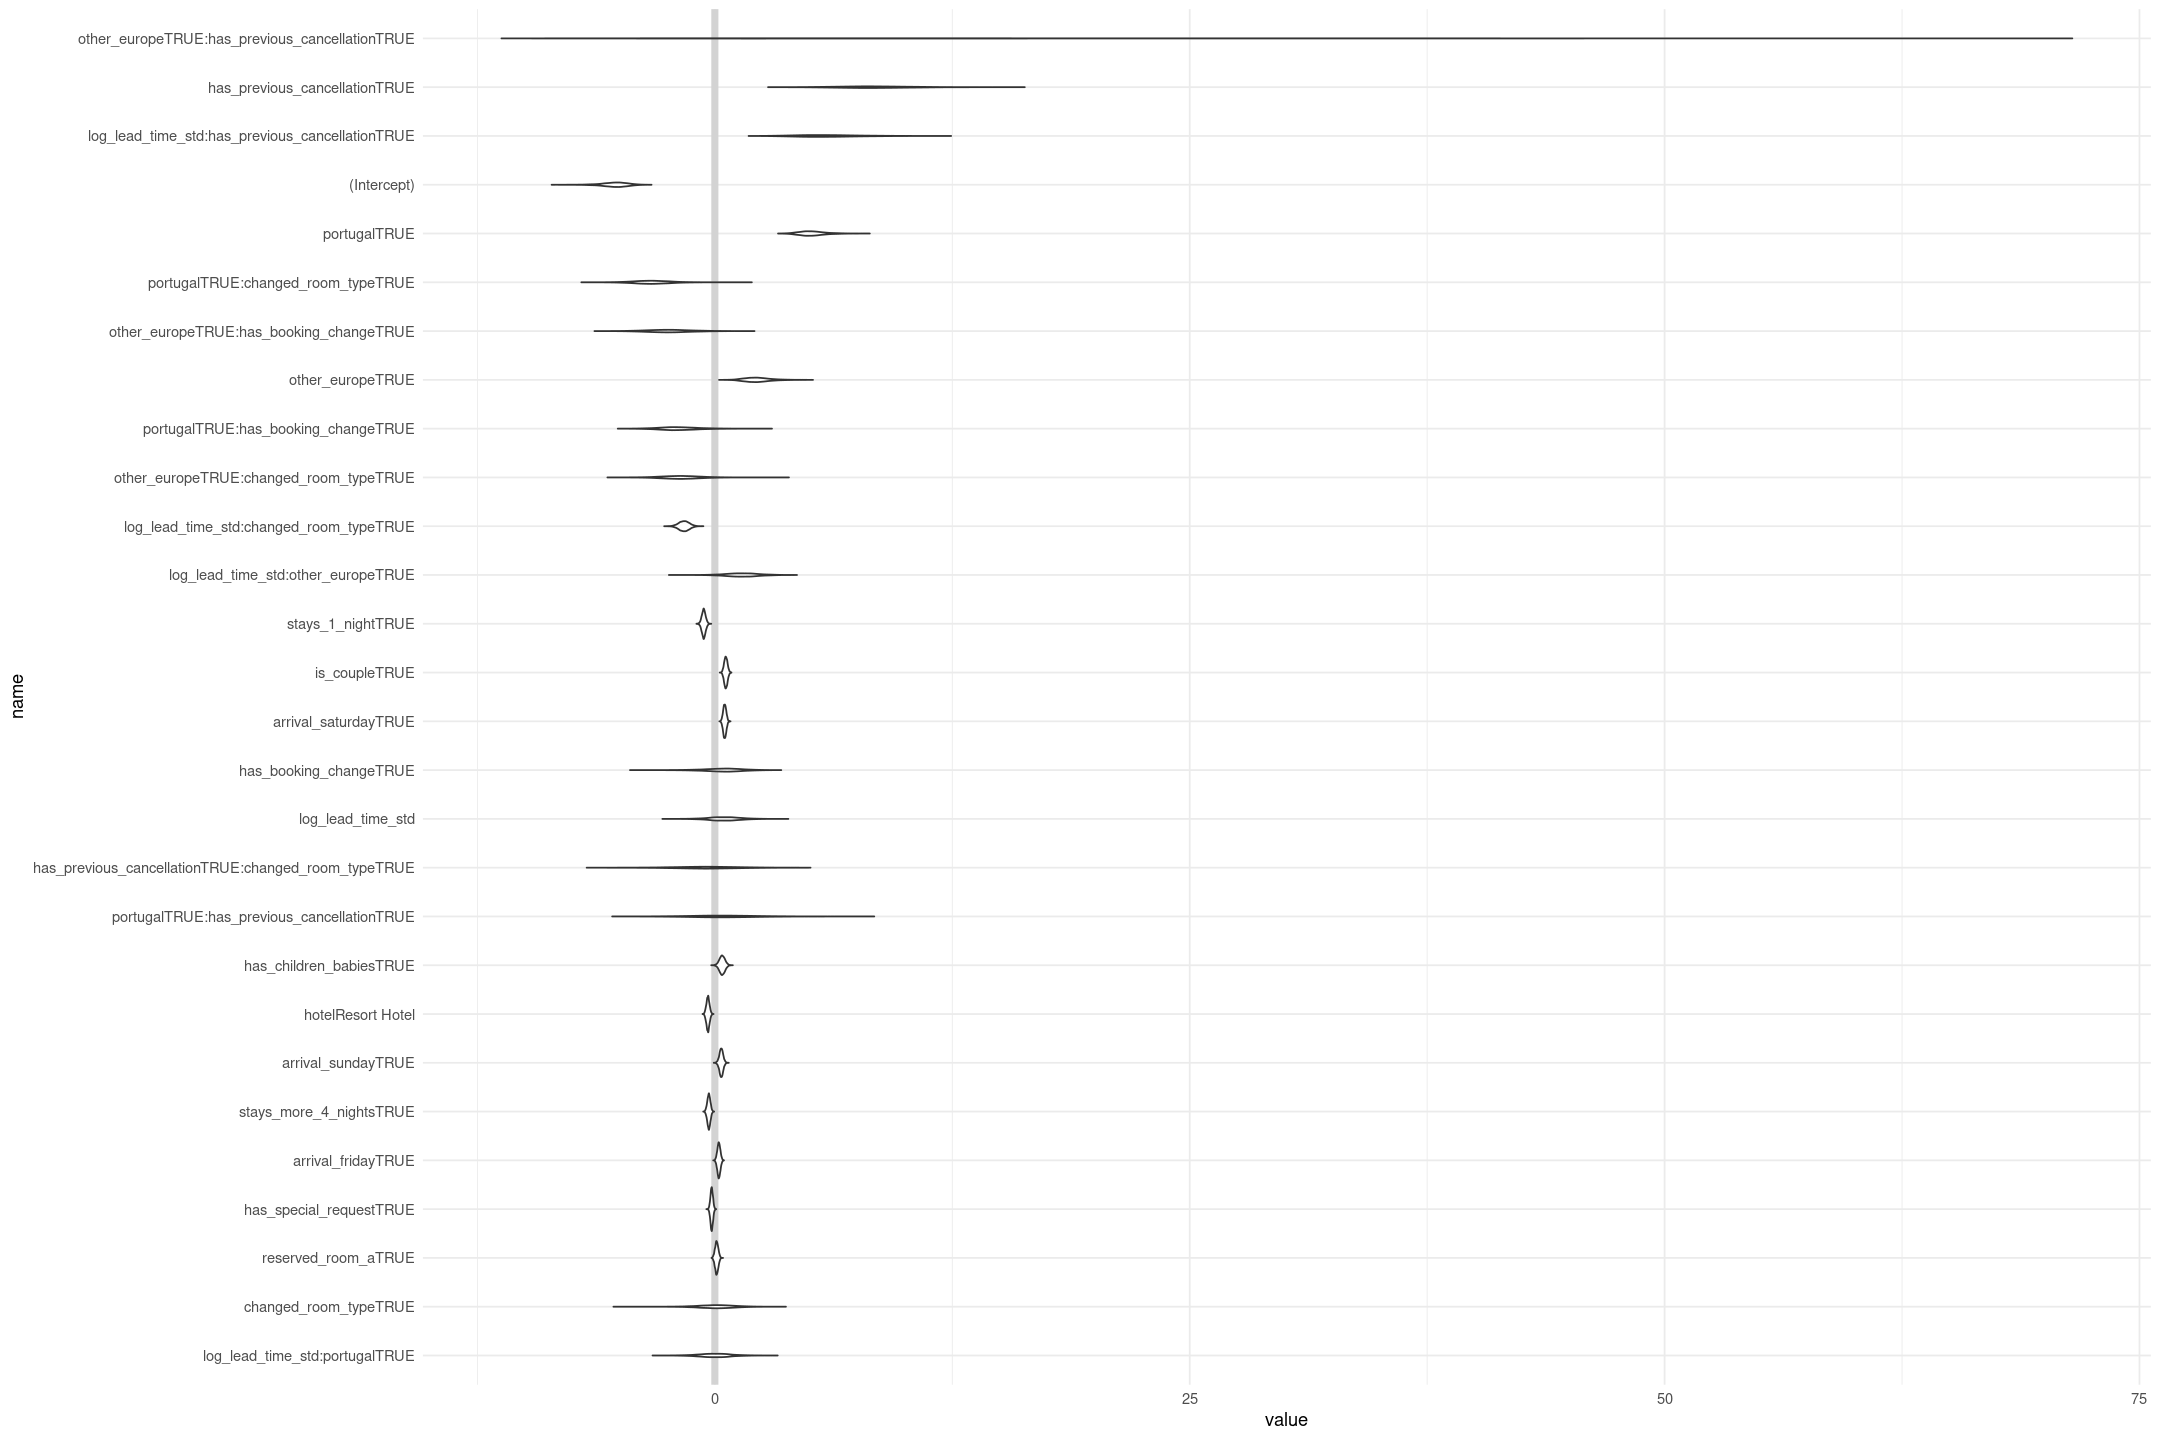

In [130]:
fit_hotel_interact %>%
as.data.frame() %>%
pivot_longer(everything()) %>%
mutate(name=forcats::fct_reorder(name, value, .fun= function(x) abs(median(x)))) %>%
gf_hline(yintercept=~0, colour="lightgrey", size=2) %>%
gf_violin(value ~ name) +
coord_flip() +
theme_minimal()

### Removing terms with a small coefficient

In [131]:
start_time <- Sys.time()
fit_hotel_interact_subset <- stan_glm(is_canceled ~ hotel + log_lead_time_std + arrival_saturday +
                                    portugal + other_europe + stays_1_night +
                                    has_children_babies + is_couple +
                                    has_previous_cancellation +
                                    changed_room_type + has_booking_change + 
                               changed_room_type : portugal + changed_room_type : other_europe +
                               log_lead_time_std : has_previous_cancellation +
                                log_lead_time_std:other_europe   +
                               log_lead_time_std : changed_room_type,
                      data=hotels_train, family=binomial(link="logit"), QR=TRUE, refresh=0)
end_time <- Sys.time()

end_time - start_time

Time difference of 2.652714 mins

In [132]:
fit_hotel_interact_subset

stan_glm
 family:       binomial [logit]
 formula:      is_canceled ~ hotel + log_lead_time_std + arrival_saturday + 
	   portugal + other_europe + stays_1_night + has_children_babies + 
	   is_couple + has_previous_cancellation + changed_room_type + 
	   has_booking_change + changed_room_type:portugal + changed_room_type:other_europe + 
	   log_lead_time_std:has_previous_cancellation + log_lead_time_std:other_europe + 
	   log_lead_time_std:changed_room_type
 observations: 11779
 predictors:   17
------
                                                Median MAD_SD
(Intercept)                                     -4.7    0.5  
hotelResort Hotel                               -0.6    0.1  
log_lead_time_std                                0.5    0.1  
arrival_saturdayTRUE                             0.4    0.1  
portugalTRUE                                     4.6    0.5  
other_europeTRUE                                 1.7    0.5  
stays_1_nightTRUE                               -0.5    

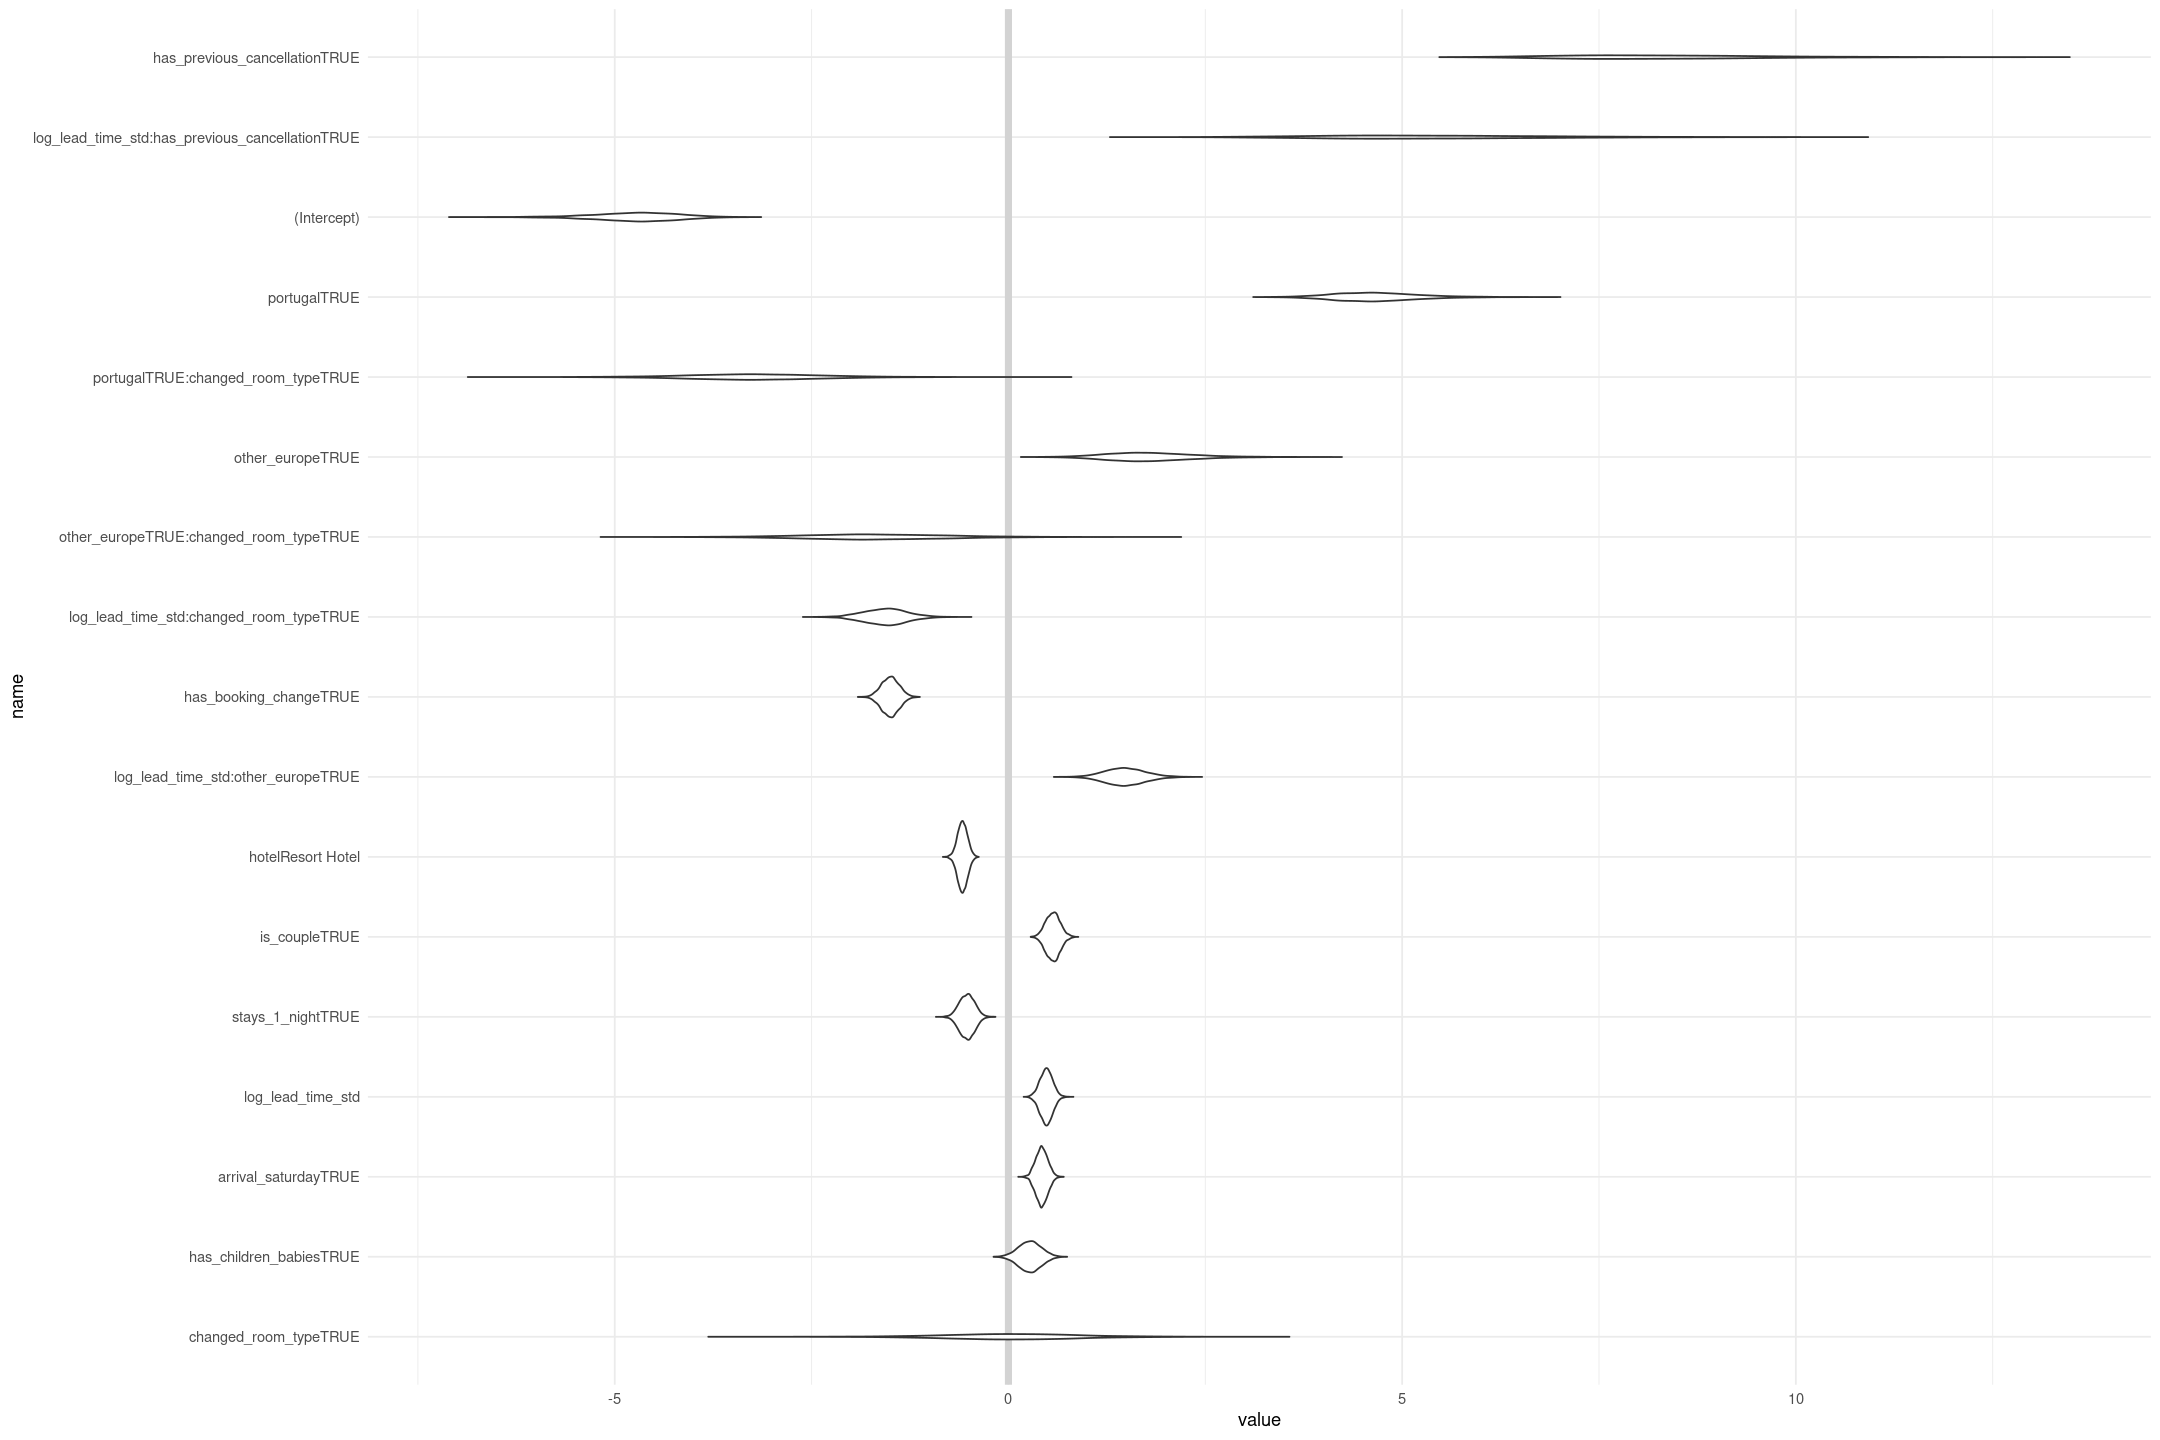

In [133]:
fit_hotel_interact_subset %>%
as.data.frame() %>%
pivot_longer(everything()) %>%
mutate(name=forcats::fct_reorder(name, value, .fun= function(x) abs(median(x)))) %>%
gf_hline(yintercept=~0, colour="lightgrey", size=2) %>%
gf_violin(value ~ name) +
coord_flip() +
theme_minimal()

### Only keeping the most impactful predictors

Let's only keep factors with more than an absolute value of 1 per 2 standard deviation

In [134]:
fit_hotel_log_lead

stan_glm
 family:       binomial [logit]
 formula:      is_canceled ~ hotel + log_lead_time_std + arrival_friday + arrival_saturday + 
	   arrival_sunday + portugal + other_europe + stays_1_night + 
	   stays_more_4_nights + has_children_babies + is_couple + has_previous_cancellation + 
	   reserved_room_a + changed_room_type + has_booking_change + 
	   has_special_request
 observations: 11779
 predictors:   17
------
                              Median MAD_SD
(Intercept)                   -4.3    0.4  
hotelResort Hotel             -0.3    0.1  
log_lead_time_std              0.6    0.1  
arrival_fridayTRUE             0.2    0.1  
arrival_saturdayTRUE           0.5    0.1  
arrival_sundayTRUE             0.3    0.1  
portugalTRUE                   4.1    0.4  
other_europeTRUE               1.4    0.4  
stays_1_nightTRUE             -0.6    0.1  
stays_more_4_nightsTRUE       -0.3    0.1  
has_children_babiesTRUE        0.4    0.2  
is_coupleTRUE                  0.6    0.1  
has_pr

In [135]:
start_time <- Sys.time()
fit_hotel_simple <- stan_glm(is_canceled ~ portugal + other_europe + has_previous_cancellation + changed_room_type + has_booking_change
                                                    ,
                      data=hotels_train, family=binomial(link="logit"), QR=TRUE, refresh=0)
end_time <- Sys.time()

end_time - start_time

Time difference of 34.69496 secs

### Only keeping predictors that would be known at time of booking

Factors like "has booking change" or "has special request" or "changed room type" may actually be indicators that leak data because they wouldn't be known at the time of booking.

Instead let's focus on things that are likely to be known when a booking is made:

* The hotel they booked at
* How many days in the future the booking is
* Day of arrival
* Country of origin
* Number of nights stayed
* Guests expected
* Whether they had a previous cancellation
* Some interactions of these

In [136]:
start_time <- Sys.time()
fit_hotel_booking_interact <- stan_glm(is_canceled ~ hotel + log_lead_time_std +
                                    arrival_friday + arrival_saturday + arrival_sunday +
                                    portugal + other_europe + stays_1_night +
                                    has_children_babies + is_couple +
                                    has_previous_cancellation +
                                    log_lead_time_std : has_previous_cancellation +
                                    log_lead_time_std:other_europe + log_lead_time_std:portugal,
                      data=hotels_train, family=binomial(link="logit"), QR=TRUE, refresh=0)
end_time <- Sys.time()

end_time - start_time

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”


Time difference of 2.873145 mins

In [137]:
start_time <- Sys.time()
fit_hotel_booking <- stan_glm(is_canceled ~ hotel + log_lead_time_std +
                                    arrival_friday + arrival_saturday + arrival_sunday +
                                    portugal + other_europe + stays_1_night +
                                    has_children_babies + is_couple +
                                    has_previous_cancellation,
                      data=hotels_train, family=binomial(link="logit"), QR=TRUE, refresh=0)
end_time <- Sys.time()

end_time - start_time

Time difference of 33.46194 secs

In [138]:
fit_hotel_booking

stan_glm
 family:       binomial [logit]
 formula:      is_canceled ~ hotel + log_lead_time_std + arrival_friday + arrival_saturday + 
	   arrival_sunday + portugal + other_europe + stays_1_night + 
	   has_children_babies + is_couple + has_previous_cancellation
 observations: 11779
 predictors:   12
------
                              Median MAD_SD
(Intercept)                   -5.1    0.4  
hotelResort Hotel             -0.6    0.1  
log_lead_time_std              0.7    0.1  
arrival_fridayTRUE             0.1    0.1  
arrival_saturdayTRUE           0.5    0.1  
arrival_sundayTRUE             0.4    0.1  
portugalTRUE                   4.3    0.4  
other_europeTRUE               1.6    0.4  
stays_1_nightTRUE             -0.5    0.1  
has_children_babiesTRUE        0.3    0.1  
is_coupleTRUE                  0.9    0.1  
has_previous_cancellationTRUE  7.2    0.4  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.

In [139]:
fit_hotel_booking_interact

stan_glm
 family:       binomial [logit]
 formula:      is_canceled ~ hotel + log_lead_time_std + arrival_friday + arrival_saturday + 
	   arrival_sunday + portugal + other_europe + stays_1_night + 
	   has_children_babies + is_couple + has_previous_cancellation + 
	   log_lead_time_std:has_previous_cancellation + log_lead_time_std:other_europe + 
	   log_lead_time_std:portugal
 observations: 11779
 predictors:   15
------
                                                Median MAD_SD
(Intercept)                                     -5.1    0.5  
hotelResort Hotel                               -0.6    0.1  
log_lead_time_std                               -0.2    0.7  
arrival_fridayTRUE                               0.1    0.1  
arrival_saturdayTRUE                             0.5    0.1  
arrival_sundayTRUE                               0.4    0.1  
portugalTRUE                                     4.3    0.5  
other_europeTRUE                                 1.5    0.5  
stays_1_nightTR

### Evaluating

In [140]:
loo_hotel_interact <- loo(fit_hotel_interact, k_threshold=0.7)
loo_hotel_interact_subset <- loo(fit_hotel_interact_subset)

1 problematic observation(s) found.
Model will be refit 1 times.


Fitting model 1 out of 1 (leaving out observation 2129)



In [141]:
loo_hotel_simple <- loo(fit_hotel_simple)

In [142]:
loo_hotel_booking <- loo(fit_hotel_booking)

In [143]:
loo_hotel_booking_interact <- loo(fit_hotel_booking_interact)

In [144]:
loo_compare(loo_hotel_log_lead, loo_hotel, loo_hotel_interact, loo_hotel_interact_subset, loo_hotel_simple, loo_hotel_booking, loo_hotel_booking_interact)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fit_hotel_interact,0.00000,0.000000,-3389.875,53.99442,27.88506,3.0076984,6779.750,107.9888
fit_hotel_interact_subset,-10.71766,6.848006,-3400.593,53.91869,16.97261,1.2632696,6801.185,107.8374
fit_hotel_log_lead,-46.59410,10.660459,-3436.469,54.96903,17.22478,0.7935606,6872.938,109.9381
fit_hotel,-67.58114,15.998695,-3457.456,55.31166,17.67889,0.8358922,6914.912,110.6233
fit_hotel_simple,-195.44637,23.314631,-3585.321,55.56557,6.31602,0.6991459,7170.643,111.1311
fit_hotel_booking_interact,-403.12142,25.904305,-3792.996,52.05836,14.27531,0.8924221,7585.993,104.1167
fit_hotel_booking,-437.04201,27.610383,-3826.917,52.68696,12.38978,0.6781195,7653.834,105.3739


In [145]:
hotels_valid <- hotels_valid %>%
mutate(pred_log_lead = predict(fit_hotel_log_lead, newdata=., type="response"),
      pred_interact = predict(fit_hotel_interact, newdata=., type="response"),
       pred_interact_subset =  predict(fit_hotel_interact_subset, newdata=., type="response"),
       pred_simple =  predict(fit_hotel_simple, newdata=., type="response"),
       pred_hotel =  predict(fit_hotel, newdata=., type="response"),
        pred_booking =  predict(fit_hotel_booking, newdata=., type="response"),
        pred_booking_interact =  predict(fit_hotel_booking_interact, newdata=., type="response"),
      )

Adding the interactions leads to the best log score (although accuracy is a little sensitive).

My favourite is `fit_hotel_booking`, because even though it only has meaningful coefficients it seems to have reasonable predictive accuracy.
Adding interactions does not seem to improve it at all on the validation set (despite what LOO says).

In [146]:
hotels_valid %>%
select(is_canceled, starts_with('pred_')) %>%
pivot_longer(starts_with('pred_'), values_to='pred', names_to='model') %>%
group_by(model) %>%
summarise(log_score = mean(is_canceled * pred + (1 - is_canceled) * (1 - pred)), 
          accuracy = mean((pred > 0.5) == is_canceled)) %>%
arrange(desc(log_score))

model,log_score,accuracy
<chr>,<dbl>,<dbl>
pred_interact_subset,0.8188377,0.8699227
pred_interact,0.8185244,0.8703142
pred_log_lead,0.8171304,0.8714887
pred_hotel,0.8065325,0.8424195
pred_booking,0.7988352,0.8530880
pred_booking_interact,0.7981396,0.8487814
pred_simple,0.7959174,0.8096310


### Residuals

In [147]:
quantile_cutter <- function(x, n, right=TRUE, lowest=-Inf, highest=Inf) {
    x_quantile <- unique(quantile(x, seq(0, 1, length.out=n+1)))
    x_quantile[1] = lowest
    x_quantile[length(x_quantile)] = highest
    function (y) {cut(y, x_quantile, include.lowest=TRUE, right=right)}
}

In [148]:
cut_quantile <- function(x, n, right=TRUE, lowest=-Inf, highest=Inf) {
    quantile_cutter(x, n, right, lowest, highest)(x)
}

In [149]:
cut_quantile(c(0,1,2,3,4,5,6,7), 7)

[1] [-Inf,1] [-Inf,1] (1,2]    (2,3]    (3,4]    (5,6]    (5,6]    (6, Inf]
Levels: [-Inf,1] (1,2] (2,3] (3,4] (4,5] (5,6] (6, Inf]

The binned residuals seem mostly negative at small predictions.

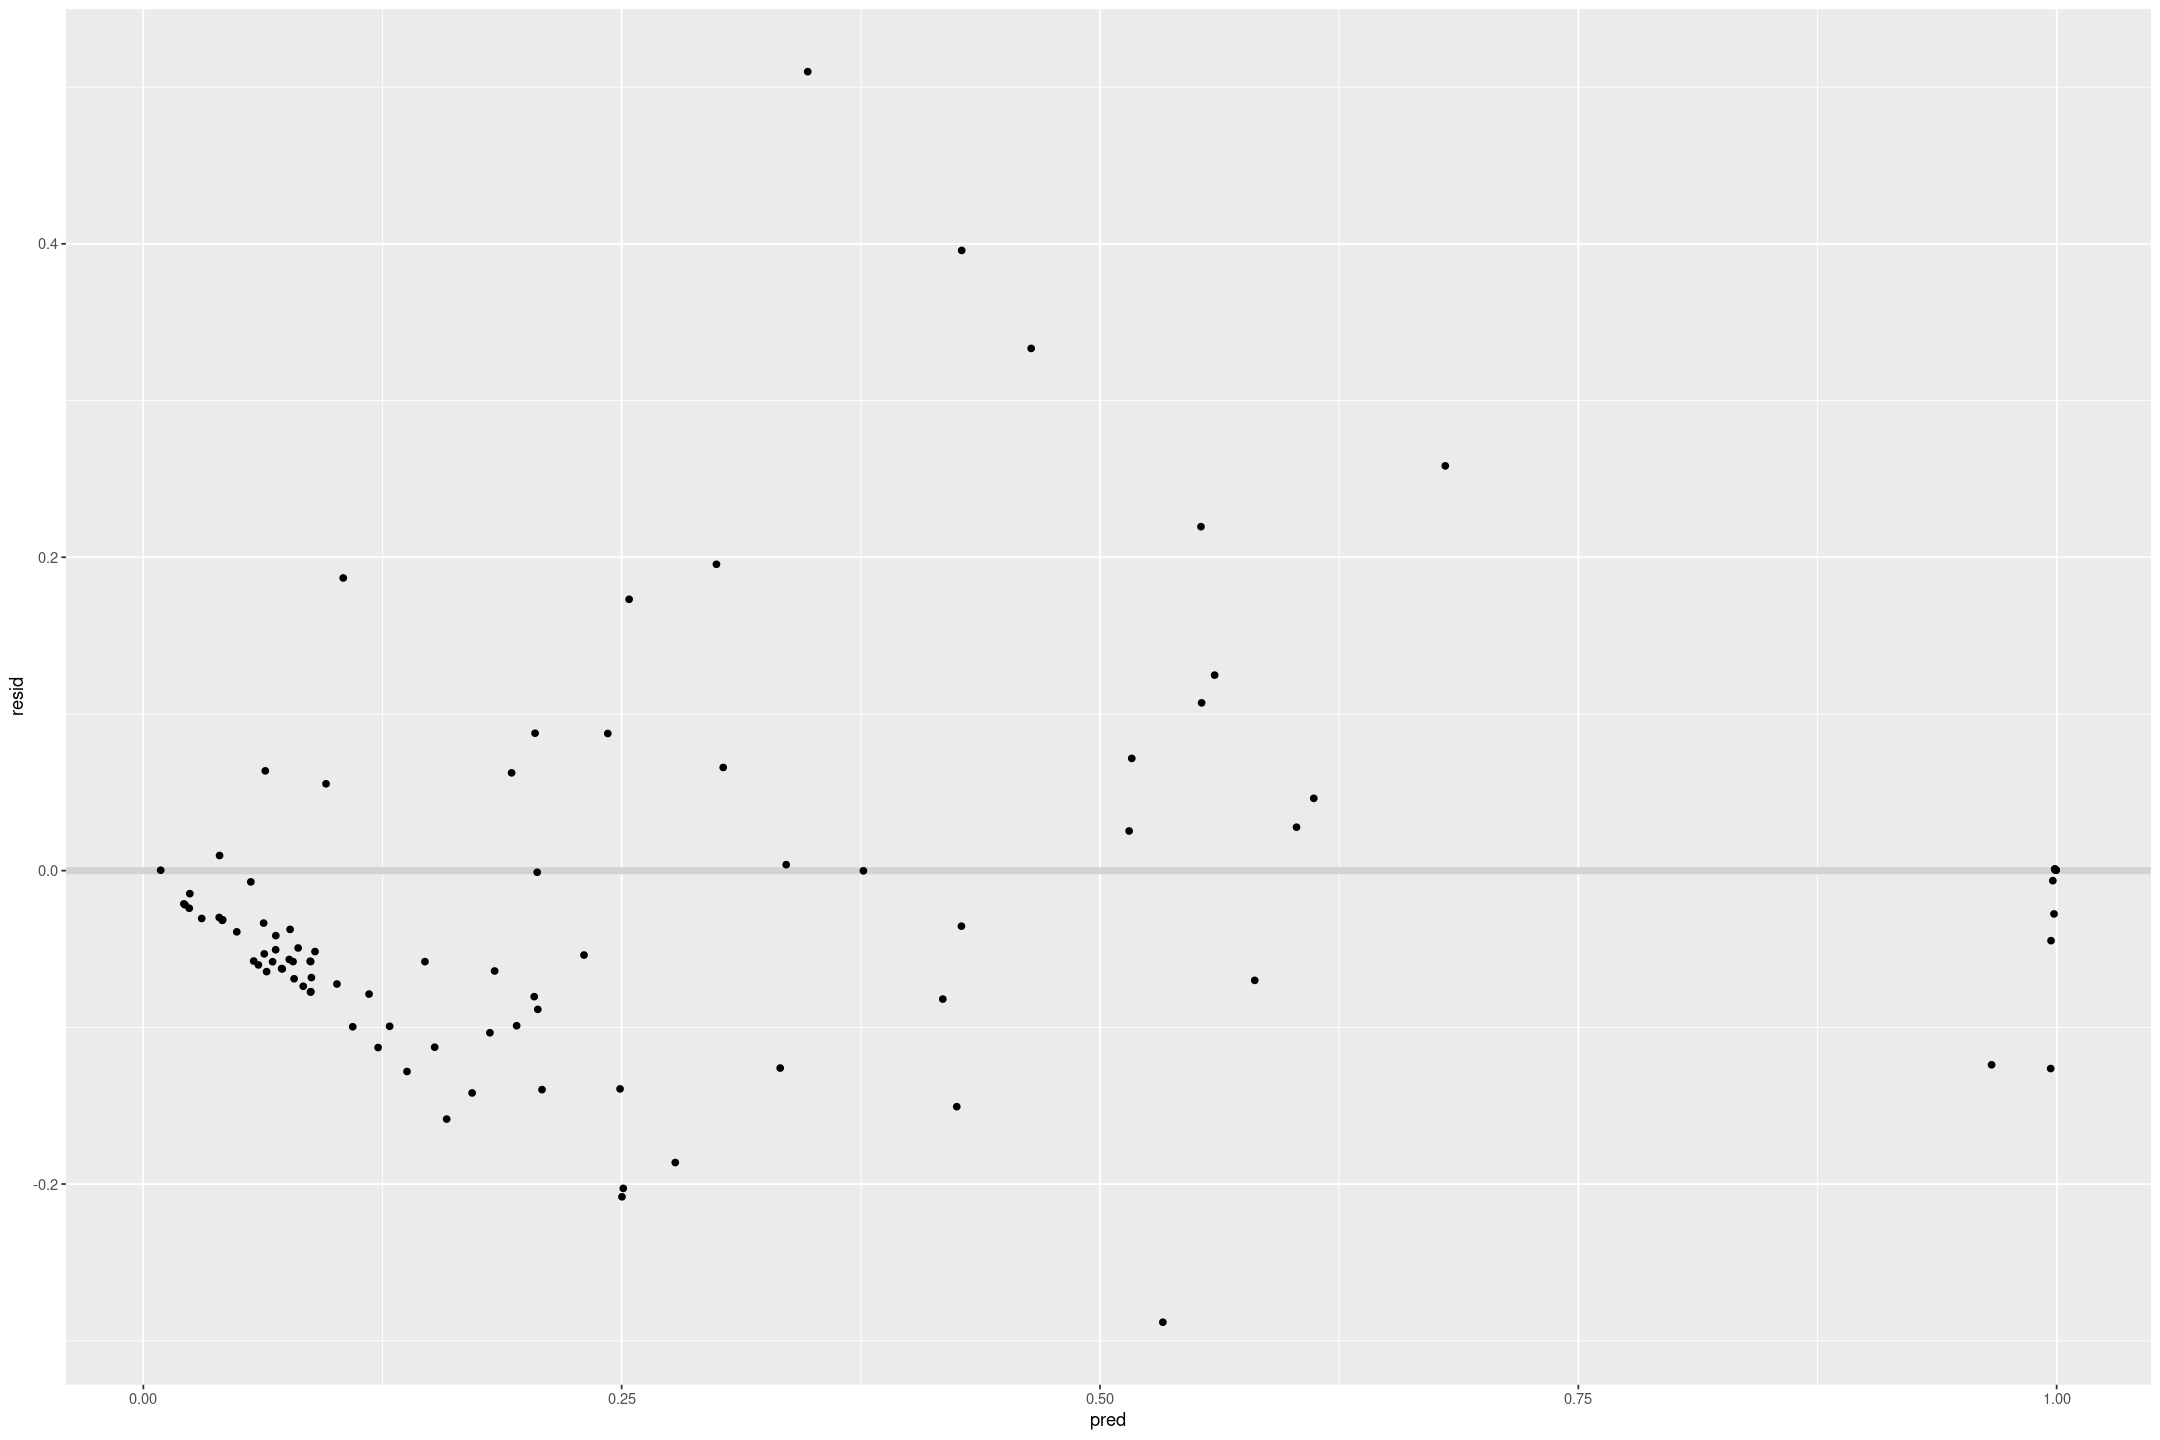

In [150]:
hotels_valid %>%
mutate(bin=cut_quantile(pred_log_lead, 100)) %>%
group_by(bin) %>%
summarise(n=n(), pred=mean(pred_booking), p=mean(is_canceled)) %>%
mutate(resid = p - pred) %>%
gf_hline(yintercept=~0, colour="lightgrey", size=2) %>%
gf_point(resid ~ pred)

## Analysing Model

Choose one particular formulation of the model and do the following:

### Effect of inputs
Describe how each input affects ${\rm Pr}(y=1)$ in the fitted model.
You must consider the estimated coefficient, the range of the input values and the nonlinear inverse logit function.

In [151]:
fit_hotel_booking

stan_glm
 family:       binomial [logit]
 formula:      is_canceled ~ hotel + log_lead_time_std + arrival_friday + arrival_saturday + 
	   arrival_sunday + portugal + other_europe + stays_1_night + 
	   has_children_babies + is_couple + has_previous_cancellation
 observations: 11779
 predictors:   12
------
                              Median MAD_SD
(Intercept)                   -5.1    0.4  
hotelResort Hotel             -0.6    0.1  
log_lead_time_std              0.7    0.1  
arrival_fridayTRUE             0.1    0.1  
arrival_saturdayTRUE           0.5    0.1  
arrival_sundayTRUE             0.4    0.1  
portugalTRUE                   4.3    0.4  
other_europeTRUE               1.6    0.4  
stays_1_nightTRUE             -0.5    0.1  
has_children_babiesTRUE        0.3    0.1  
is_coupleTRUE                  0.9    0.1  
has_previous_cancellationTRUE  7.2    0.4  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.

All our predictors except `log_lead_time_std` are categorical, so their range of input values are 0/1 (or FALSE/TRUE).

We have standardised `log_lead_time_std`.
For interpretation the underlying variable `lead_time` has a geometric mean of 51 (where log_lead_time_std is 0), and as `log_lead_time_std` varies between -0.5 and +0.5, the `lead_time` varies between 9 days and 267 days.

In [152]:
hotels_train %>% 
transmute(log_lead_time=log(lead_time+1)) %>% 
summarise(log_mean = mean(log_lead_time), log_sd = sd(log_lead_time)) %>%
transmute(geomean = exp(log_mean) - 1, upper = exp(log_mean + log_sd) - 1, lower = exp(log_mean - log_sd) - 1)

geomean,upper,lower
<dbl>,<dbl>,<dbl>
51.06058,266.7412,9.122848


The intercept corresponds to people who:

* Are at City hotel
* Book 28 days in advance
* Arrive Monday - Thursday
* Are from outside of Europe
* Stays 2-3 nights
* Is 1 or 3+ adults, with no children
* Does not have a previous cancellation
* Does not reserve room type A
* Has not Changed room type
* Does not have a special request

Then the probability of a cancellation is very low:

In [153]:
coefs <- coef(fit_hotel_booking)

In [154]:
invlogit(coefs[['(Intercept)']]) %>% scales::percent(0.01)

[1] "0.58%"

On the other hand if someone does have a previous cancellation (largest coefficient) then the probability is very high:

In [155]:
invlogit(coefs[['(Intercept)']] + coefs[['has_previous_cancellationTRUE']]) %>%
scales::percent(0.01)

[1] "88.47%"

Note that the divide by 4 rule won't always work here because we are very far from 50%, and in particular the coefficient is very large

In [156]:
coefs[['has_previous_cancellationTRUE']] / 4

[1] 1.79361

A good way to analyse this is to look at the largest positive factors, and largest negative factors and see how they interact

In [157]:
data.frame(coefs, se=se(fit_hotel_booking)) %>%
arrange(desc(coefs)) %>%
mutate_all(round, digits=1)

,coefs,se
,<dbl>,<dbl>
has_previous_cancellationTRUE,7.2,0.4
portugalTRUE,4.3,0.4
other_europeTRUE,1.6,0.4
is_coupleTRUE,0.9,0.1
log_lead_time_std,0.7,0.1
arrival_saturdayTRUE,0.5,0.1
arrival_sundayTRUE,0.4,0.1
has_children_babiesTRUE,0.3,0.1
arrival_fridayTRUE,0.1,0.1


The rate of cancellations is quite high for visitors from Portugal too

In [158]:
invlogit(coefs[['(Intercept)']] + coefs[['portugalTRUE']]) %>%
scales::percent(0.01)

[1] "30.08%"

And a little bit higher from the rest of Europe

In [159]:
invlogit(coefs[['(Intercept)']] + coefs[['other_europeTRUE']]) %>%
scales::percent(0.01)

[1] "2.93%"

It's easiest to interpret the coefficients relative to Portugal where they have a significant effect:

* Being in a couple increases cancellations by about 25%, having children or babies by about 7%
* Arriving on a Saturday or Sunday increases the probability by 10-12%, Friday has a negligible difference
* A factor of about 5x in lead time corresponds to a change in 17% in cancellation
* Booking in the Resort Hotel decreases cancellations by about 15%
* Booking for just 1 night reduces the probability by about 12%

The impact is much less for visitors from Europe, or other countries, or if there's been a previous cancellation.

In [160]:
invlogit(coefs[['(Intercept)']] + coefs[['portugalTRUE']]) %>%
scales::percent()

[1] "30%"

In [161]:
invlogit(coefs[['(Intercept)']] + coefs[['portugalTRUE']] + coefs[['is_coupleTRUE']]) %>%
scales::percent()

[1] "51%"

In [162]:
invlogit(coefs[['(Intercept)']] + coefs[['other_europeTRUE']]) %>%
scales::percent(0.01)

[1] "2.93%"

In [163]:
invlogit(coefs[['(Intercept)']] + coefs[['other_europeTRUE']] + coefs[['is_coupleTRUE']]) %>%
scales::percent()

[1] "7%"

In general the derivative of invlogit is

$$ \frac{\rm d}{{\rm d} x} {\rm invlogit}(x) = \frac{e^{x}}{\left(1+e^{x}\right)^2} = {\rm invlogit}(x) (1 - {\rm invlogit}(x)) $$

So for our international travellers where the base rate is 0.6%, the factor is

In [164]:
0.06 * 0.94

[1] 0.0564

So we would predict that e.g. being a couple increases the probability by around 0.9/20 = .45% to about 1%

In [165]:
invlogit(coefs[['(Intercept)']]) %>% scales::percent(.1)

[1] "0.6%"

It's a little higher since we're just taking a linear approximation

In [166]:
invlogit(coefs[['(Intercept)']] + coefs[['is_coupleTRUE']]) %>% scales::percent(.1)

[1] "1.4%"

#### Average predictive difference

Another perspective is to look at the average predictive difference, and say typically across the dataset being a couple increases the probability of cancelling by 8.8%.

Although in some sense this may misstate the importance of the predictor, in that it may be really unlikely to be a couple for some configurations of the other variables.
Note here because it's a categorical predictor we have to set `has_children_babies` to False when it's True.

In [167]:
mean(predict(fit_hotel_booking, type="response", newdata=hotels_train %>% mutate(is_couple = TRUE, has_children_babies=FALSE)) - 
     predict(fit_hotel_booking, type="response", newdata=hotels_train %>% mutate(is_couple = FALSE))) %>%
scales::percent(0.1)

[1] "8.7%"

On the other hand having babies actually appears to *decrease* the probability, because it implies they are not in a couple.

In [168]:
mean(predict(fit_hotel_booking, type="response", newdata=hotels_train %>% mutate(has_children_babies = TRUE, is_couple=FALSE)) - 
     predict(fit_hotel_booking, type="response", newdata=hotels_train %>% mutate(has_children_babies = FALSE))) %>%
scales::percent(0.1)

[1] "-3.8%"

If we ignored the logical silliness of it we can allow `has_children_babies` and `is_couple` to be simultaneously true, giving a positive effect.

In [169]:
mean(predict(fit_hotel_booking, type="response", newdata=hotels_train %>% mutate(has_children_babies = TRUE)) - 
     predict(fit_hotel_booking, type="response", newdata=hotels_train %>% mutate(has_children_babies = FALSE))) %>%
scales::percent(0.1)

[1] "3.5%"

### Error rate

What is the error rate of the fitted model?
What is the error rate of the null model?

In [170]:
fit_hotel_null <- stan_glm(is_canceled ~ 1, family=binomial(link="logit"), data=hotels_train, refresh=0)

In [171]:
fit_hotel_null

stan_glm
 family:       binomial [logit]
 formula:      is_canceled ~ 1
 observations: 11779
 predictors:   1
------
            Median MAD_SD
(Intercept) -0.3    0.0  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

The error rate is much lower on our model than the null model

In [172]:
mean((predict(fit_hotel_null, type="response") > 0.5) == hotels_train$is_canceled) %>% scales::percent()

[1] "58%"

In [173]:
mean((predict(fit_hotel_booking, type="response") > 0.5) == hotels_train$is_canceled) %>% scales::percent()

[1] "82%"

### Comparing with null model

Compare the fitted and null models using leave-one-out cross validation.
Does the improvement in fit seem to be real?

Based on the log score it does look like our model is doing a lot!

In [174]:
loo_hotel_null <- loo(fit_hotel_null)

In [175]:
loo_compare(loo_hotel_null, loo_hotel_booking)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fit_hotel_booking,0.000,0.00000,-3826.917,52.68696,12.389776,0.678119461,7653.834,105.37392
fit_hotel_null,-4188.561,52.04311,-8015.478,17.19384,1.087663,0.003229214,16030.956,34.38768


#### Comparing the error rate on the validation set

Since we have a separate validation set we can also compare the error rate on that to test generalisation.

For some reason we can't naively fit the null model

In [176]:
# predict(fit_hotel_null, type="response", newdata=hotels_valid)
# Throws an error

But given it's constant it's simple; it predicts nothing as cancelled

In [177]:
invlogit(coef(fit_hotel_null)[['(Intercept)']])

[1] 0.4204595

Actually the null model does better on the validation set (because the rate of cancellation decreases!)

In [178]:
mean(hotels_valid$is_canceled == 0) %>% scales::percent()

[1] "69%"

But our model still does better.

In [179]:
mean((predict(fit_hotel_booking, type="response", newdata=hotels_valid) > 0.5) == hotels_valid$is_canceled) %>%
scales::percent()

[1] "85%"

### Making Predictions

Use the model to make predictions for some test cases of interest.

In [180]:
hotels_train %>% summarise(mean(log(lead_time+1)),
                           sd(log(lead_time+1)))

mean(log(lead_time + 1)),sd(log(lead_time + 1))
<dbl>,<dbl>
3.952408,1.637613


We can generate all combinations (and some sampling of lead time).

It would have been easier if we'd used categorical encodings :)

In [181]:
hotels_sample = crossing(hotel=c("Resort Hotel", "City Hotel"),
         log_lead_time_std=c(-0.5, 0, 0.5),
         arrival_day = c("friday", "saturday", "sunday", "other"),
         country = c("portugal", "other_europe", "other"),
         stays_1_night = c(TRUE, FALSE),
         guests=c('couple', 'children_babies', 'other'),
         has_previous_cancellation = c(TRUE, FALSE)
         ) %>%
mutate(lead_time = exp(log_lead_time_std * 2 * 1.64 + 3.95) - 1,
       arrival_friday = arrival_day == "friday",
       arrival_saturday = arrival_day == "saturday",
       arrival_sunday = arrival_day == "sunday",
       portugal = country == "portugal",
       other_europe = country == "other_europe",
       is_couple = guests == "couple",
       has_children_babies = guests == "children_babies") %>%
mutate(pred=predict(fit_hotel_booking, type="response", newdata=.))

Would you ever book someone who has a previous cancellation?

In every case the model predicts a cancellation is more likely than not.
But if they're not a couple, booking 50 days or less out, arriving during the week, international and staying just 1 night you might chance it.

In [182]:
hotels_sample %>% filter(has_previous_cancellation) %>% arrange(pred) %>% head()

hotel,log_lead_time_std,arrival_day,country,stays_1_night,guests,has_previous_cancellation,lead_time,arrival_friday,arrival_saturday,arrival_sunday,portugal,other_europe,is_couple,has_children_babies,pred
<chr>,<dbl>,<chr>,<chr>,<lgl>,<chr>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>
Resort Hotel,-0.5,other,other,TRUE,other,TRUE,9.074425,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,0.6308094
Resort Hotel,-0.5,friday,other,TRUE,other,TRUE,9.074425,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,0.6563441
Resort Hotel,-0.5,other,other,TRUE,children_babies,TRUE,9.074425,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,0.6973092
Resort Hotel,0.0,other,other,TRUE,other,TRUE,50.935367,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,0.7006919
Resort Hotel,-0.5,sunday,other,TRUE,other,TRUE,9.074425,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,0.7144194
Resort Hotel,-0.5,friday,other,TRUE,children_babies,TRUE,9.074425,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,0.7202723


### Estimating by simulation

Use the simulations from the `stan_glm` output to create a 50% interval for some nonlinear function of parameters (for example, $\beta_1 / \beta_2 $).

Perhaps an interesting ratio is portugal vs other_europe

In [183]:
fit_hotel_booking %>%
as.data.frame() %>%
transmute(ratio = portugalTRUE / other_europeTRUE) %>%
summarise(quantile(ratio, c(0.25, 0.5, 0.75)), q=c(0.25, 0.5, 0.75))

"quantile(ratio, c(0.25, 0.5, 0.75))",q
<dbl>,<dbl>
2.375127,0.25
2.630949,0.50
2.987340,0.75


So our 50% interval for `portugalTRUE / other_europeTRUE` is `[2.4, 3]`

# Working with logistic regression

In a class of 50 students, a logistic regression is performed of course grade (pass or fail) on midterm exam score (continuous values with mean 60 and standard deviation 15).
The fitted model is ${\rm Pr}({\rm pass}) = {\rm logit}^{-1}(-24 + 0.4x)$.

## Graphing model

Graph the fitted model.
Also on this graph put a scatterplot of hypothetical data consistent with the information given.

In [184]:
n <- 50
model <- function(x) invlogit(-24 + 0.4 * x)

fake_data <- data.frame(x = rnorm(n, 60, 15)) %>%
mutate(p = model(x), pass=rbinom(n, 1, p))

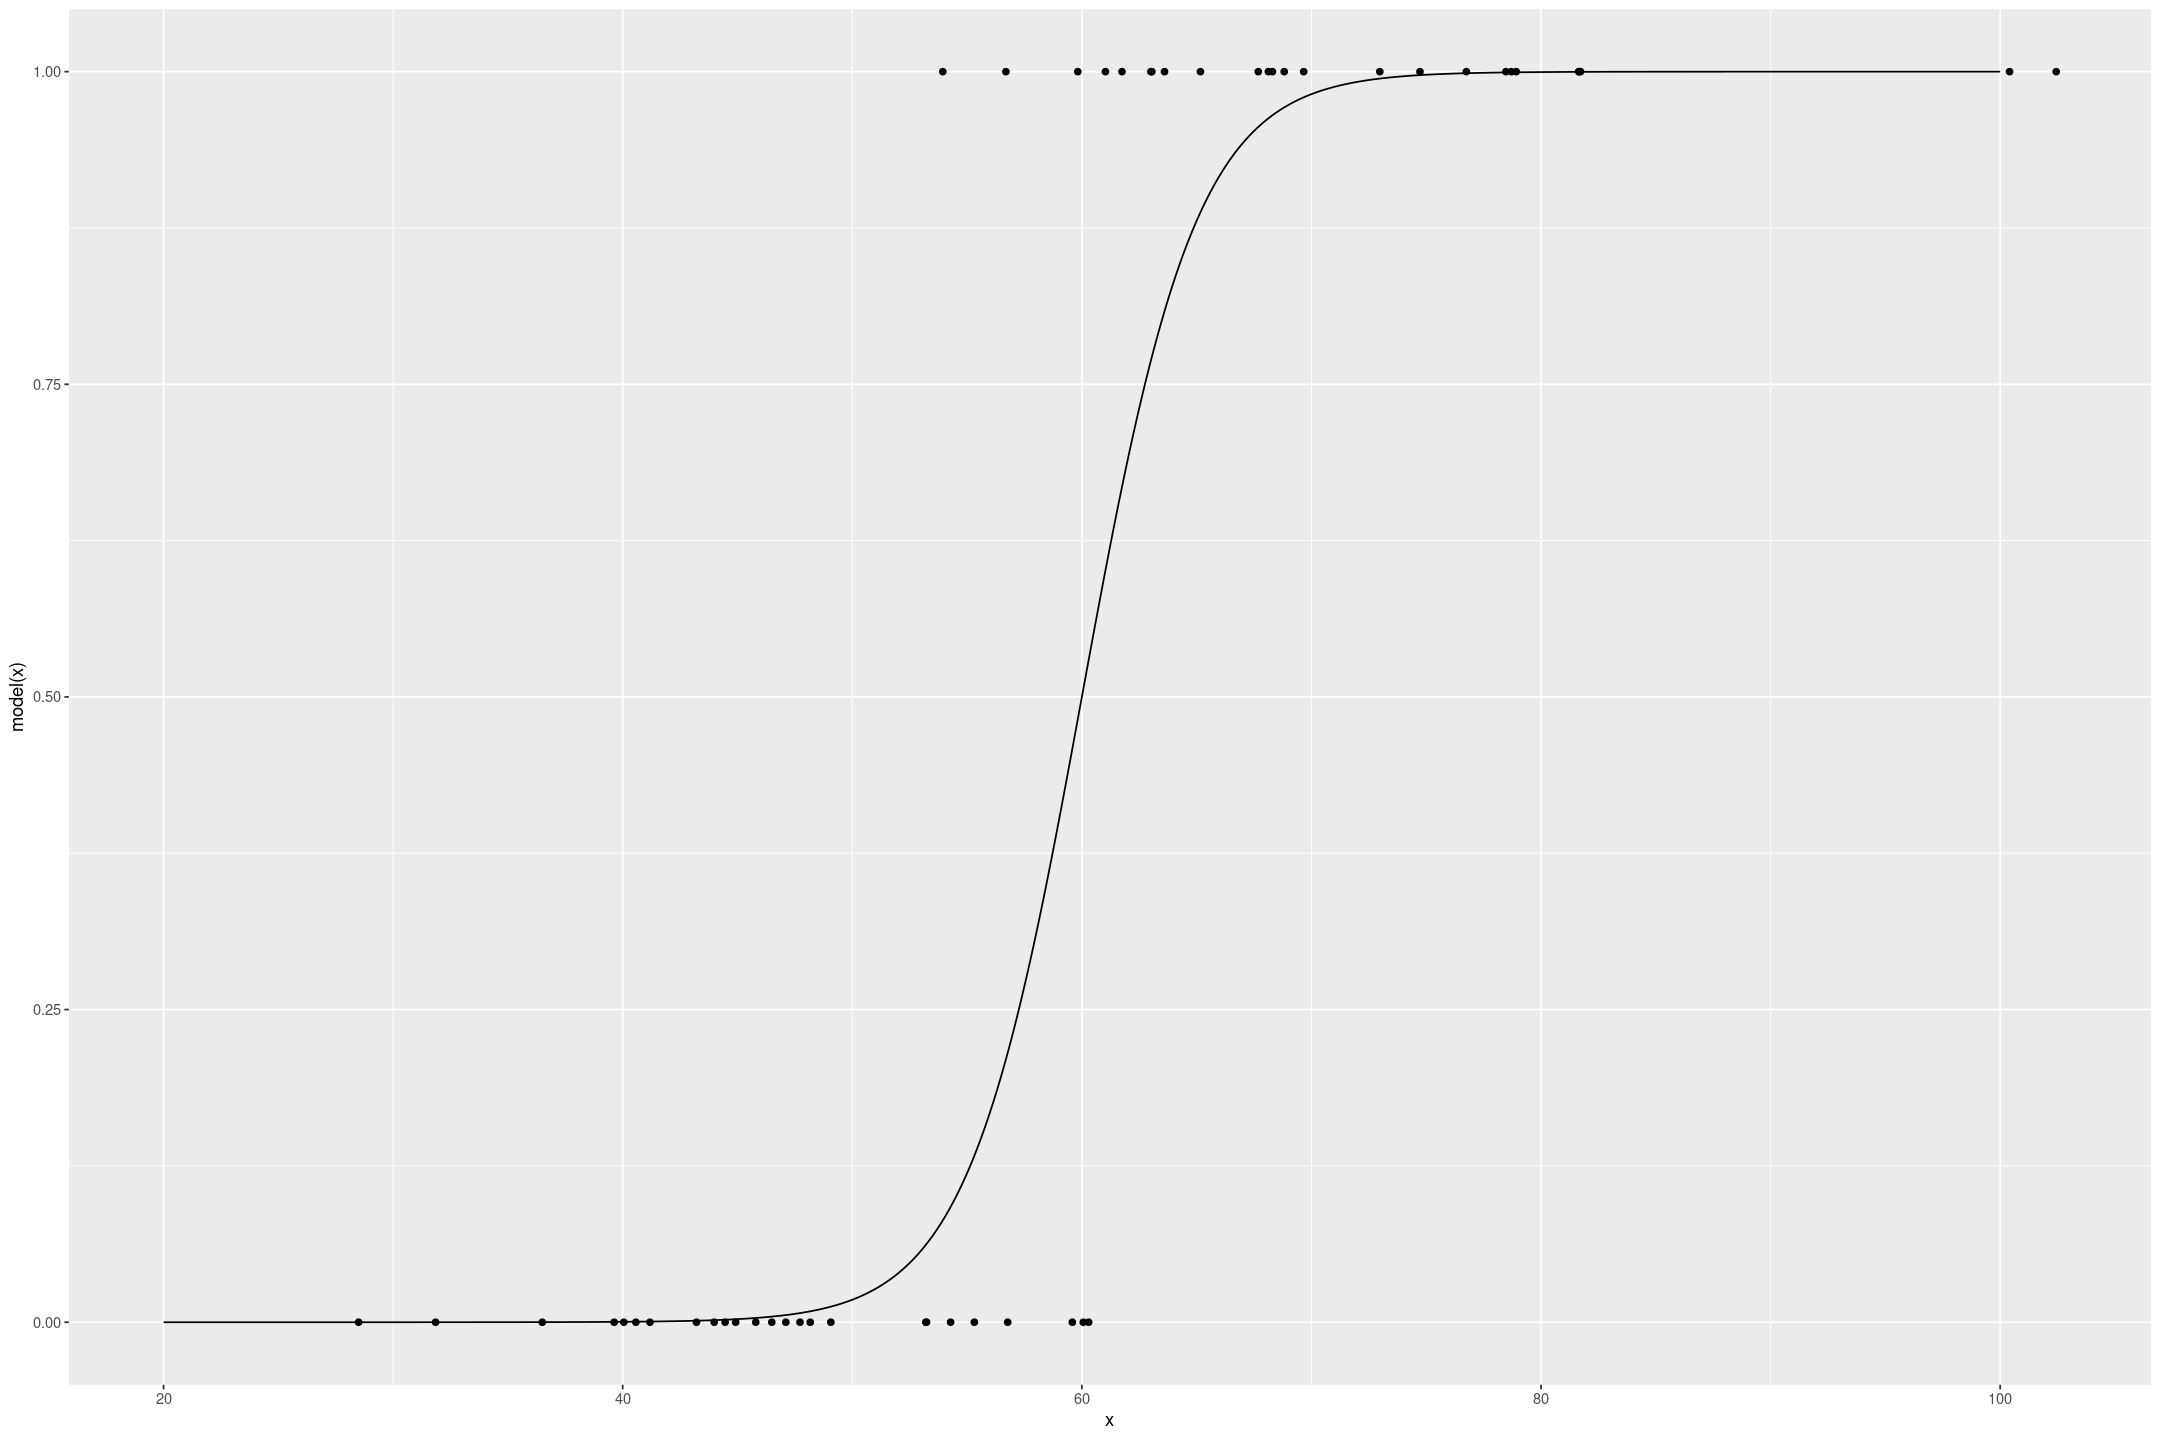

In [185]:
x <- seq(20, 100, by=0.01)

gf_line(model(x) ~ x) %>%
gf_point(pass ~ x, data=fake_data)

## Linear transformation of inputs

Suppose the midterm scores were transformed to have a mean of 0 and a standard deviation of 1.
What would be the equation of the logistic regression using these transformed scores as a new predictor?

We have  ${\rm Pr}({\rm pass}) = {\rm logit}^{-1}(-24 + 0.4x)$, and define $ y = (x - 60) / 15$, which has mean 0 and standard deviation 1.

Then $ x = 15 y + 60 $ and so $ -24 + 0.4x = 6 y $, giving 
 ${\rm Pr}({\rm pass}) = {\rm logit}^{-1}(6y)$.
 
We can check this by testing at $ y = 0$ where $x=60$ and $y=1$ where $x=75$.

In [186]:
invlogit(-24 + 0.4*60)

[1] 0.5

In [187]:
invlogit(0)

[1] 0.5

In [188]:
invlogit(-24 + 0.4*75)

[1] 0.9975274

In [189]:
invlogit(6)

[1] 0.9975274

## Adding noise predictor

Create a new predictor that is pure noise; for example, in R you can create `newpred <- rnorm(n,0,1)`.
Add it to your model.
How much does the leave-one-out cross validation score decrease?

In [190]:
fake_data <- fake_data %>% mutate(newpred=rnorm(nrow(.), 0, 1))

In [191]:
fake_data

x,p,pass,newpred
<dbl>,<dbl>,<int>,<dbl>
68.12519,9.626759e-01,1,0.49755174
46.49292,4.483620e-03,0,-0.58944888
45.79367,3.393374e-03,0,-0.03608097
49.06476,1.244273e-02,0,-1.86976409
36.49732,8.262845e-05,0,-0.77192354
39.62607,2.887760e-04,0,-0.64828680
56.76948,2.154792e-01,0,-0.02191250
60.06130,5.061297e-01,0,1.19355164
43.98484,1.648789e-03,0,-0.94081818


In [192]:
fake_model <- stan_glm(pass ~ x, family=binomial(link='logit'), data=fake_data)

In [193]:
fake_model

stan_glm
 family:       binomial [logit]
 formula:      pass ~ x
 observations: 50
 predictors:   2
------
            Median MAD_SD
(Intercept) -17.4    4.4 
x             0.3    0.1 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [194]:
fake_model_noise <- stan_glm(pass ~ x + newpred, family=binomial(link='logit'), data=fake_data)

In [195]:
fake_model_noise

stan_glm
 family:       binomial [logit]
 formula:      pass ~ x + newpred
 observations: 50
 predictors:   3
------
            Median MAD_SD
(Intercept) -18.1    4.6 
x             0.3    0.1 
newpred      -0.6    0.7 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

The noise drops it by around -0.9 log score.

In [196]:
loo_fake <- loo(fake_model)
loo_fake_noise <- loo(fake_model_noise)
loo_compare(loo_fake, loo_fake_noise)

Warning message:
“Found 1 observation(s) with a pareto_k > 0.7. We recommend calling 'loo' again with argument 'k_threshold = 0.7' in order to calculate the ELPD without the assumption that these observations are negligible. This will refit the model 1 times to compute the ELPDs for the problematic observations directly.
”


,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fake_model,0.0000000,0.0000000,-10.72686,2.633000,1.005324,0.3218442,21.45373,5.266000
fake_model_noise,-0.6556014,0.9821916,-11.38246,3.139718,1.932765,0.7934839,22.76493,6.279435


# Limitations of logistic regression

Consider a dataset with $n=20$ points, a single predictor $x$ that takes on the values $1, \ldots, 20$, and a binary data $y$.
Construct data values $y_1, \ldots, y_{20}$, that are inconsistent with any logistic regression on $x$.
Fit a logistic regression to these data, plot the data and fitted curve, and explain why you can say that the model does not fit the data.

In [197]:
x <- seq(1,20)
y <- c(rep(0, 5), rep(1,10), rep(0, 5))

bad_data <- data.frame(x,y)

In [198]:
bad_model <- stan_glm(y ~ x, family=binomial(link='logit'), data=bad_data, refresh=0)

In [199]:
bad_model

stan_glm
 family:       binomial [logit]
 formula:      y ~ x
 observations: 20
 predictors:   2
------
            Median MAD_SD
(Intercept) 0.0    1.0   
x           0.0    0.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

The model recovers exactly the null model, when there's a simple piecewise model that works much better.

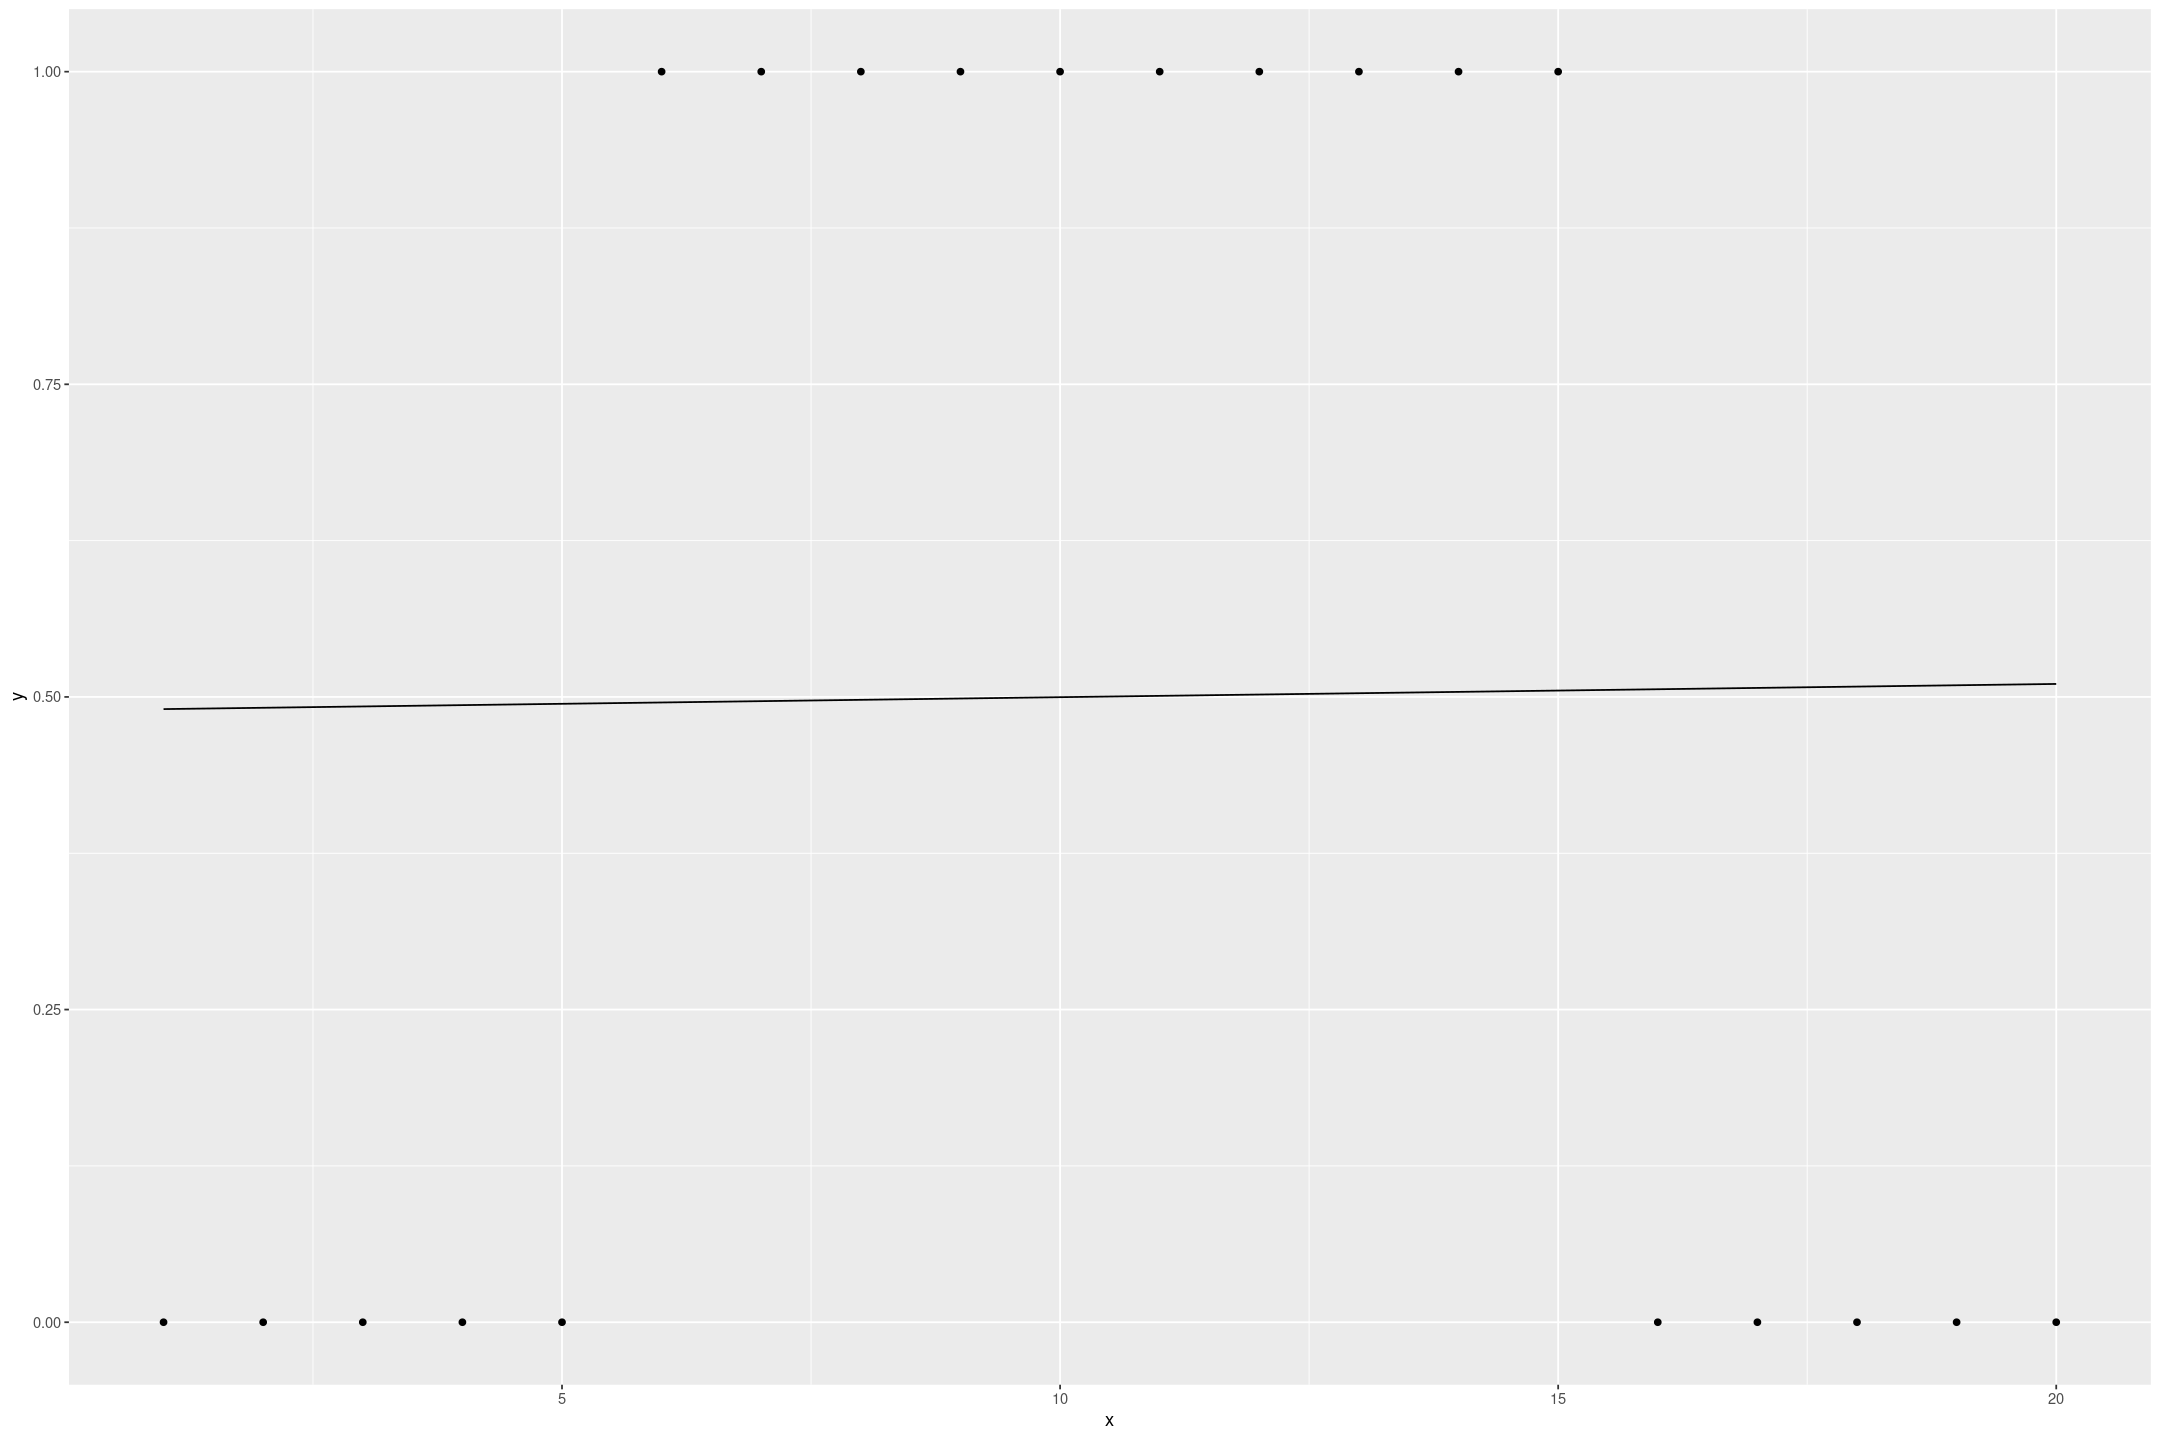

In [200]:
bad_data %>%
mutate(pred=predict(bad_model, type="response")) %>%
gf_point(y ~ x) %>%
gf_line(pred ~ x)

# Model building and comparison

Continue with the well-switching data.

In [201]:
wells %>% head()

,switch,arsenic,dist,dist100,assoc,educ,educ4,dist_group
,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<fct>
1,1,2.36,16.826,0.16826,0,0,0.00,<100m
2,1,0.71,47.322,0.47322,0,0,0.00,<100m
3,0,2.07,20.967,0.20967,0,10,2.50,<100m
4,1,1.15,21.486,0.21486,0,12,3.00,<100m
5,1,1.10,40.874,0.40874,1,14,3.50,<100m
6,1,3.90,69.518,0.69518,1,9,2.25,<100m


## Fit model on distance and log(arsenic)

Fit a logistic regression for the probability of switching using, as predictors, distance, log(arsenic), and their interaction.
Interpret the estimated coefficients and their standard errors.

In [202]:
fit_wells_dist_logas <- stan_glm(switch ~ dist100 * log(arsenic),
                                 family=binomial(link="logit"),
                                 data=wells,
                                 refresh=0)

In [203]:
fit_wells_dist_logas

stan_glm
 family:       binomial [logit]
 formula:      switch ~ dist100 * log(arsenic)
 observations: 3020
 predictors:   4
------
                     Median MAD_SD
(Intercept)           0.5    0.1  
dist100              -0.9    0.1  
log(arsenic)          1.0    0.1  
dist100:log(arsenic) -0.2    0.2  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

## Graphing interactions

Make graphs as in Figure 14.3 to show the relation between probability of switching, distance and arsenic level.

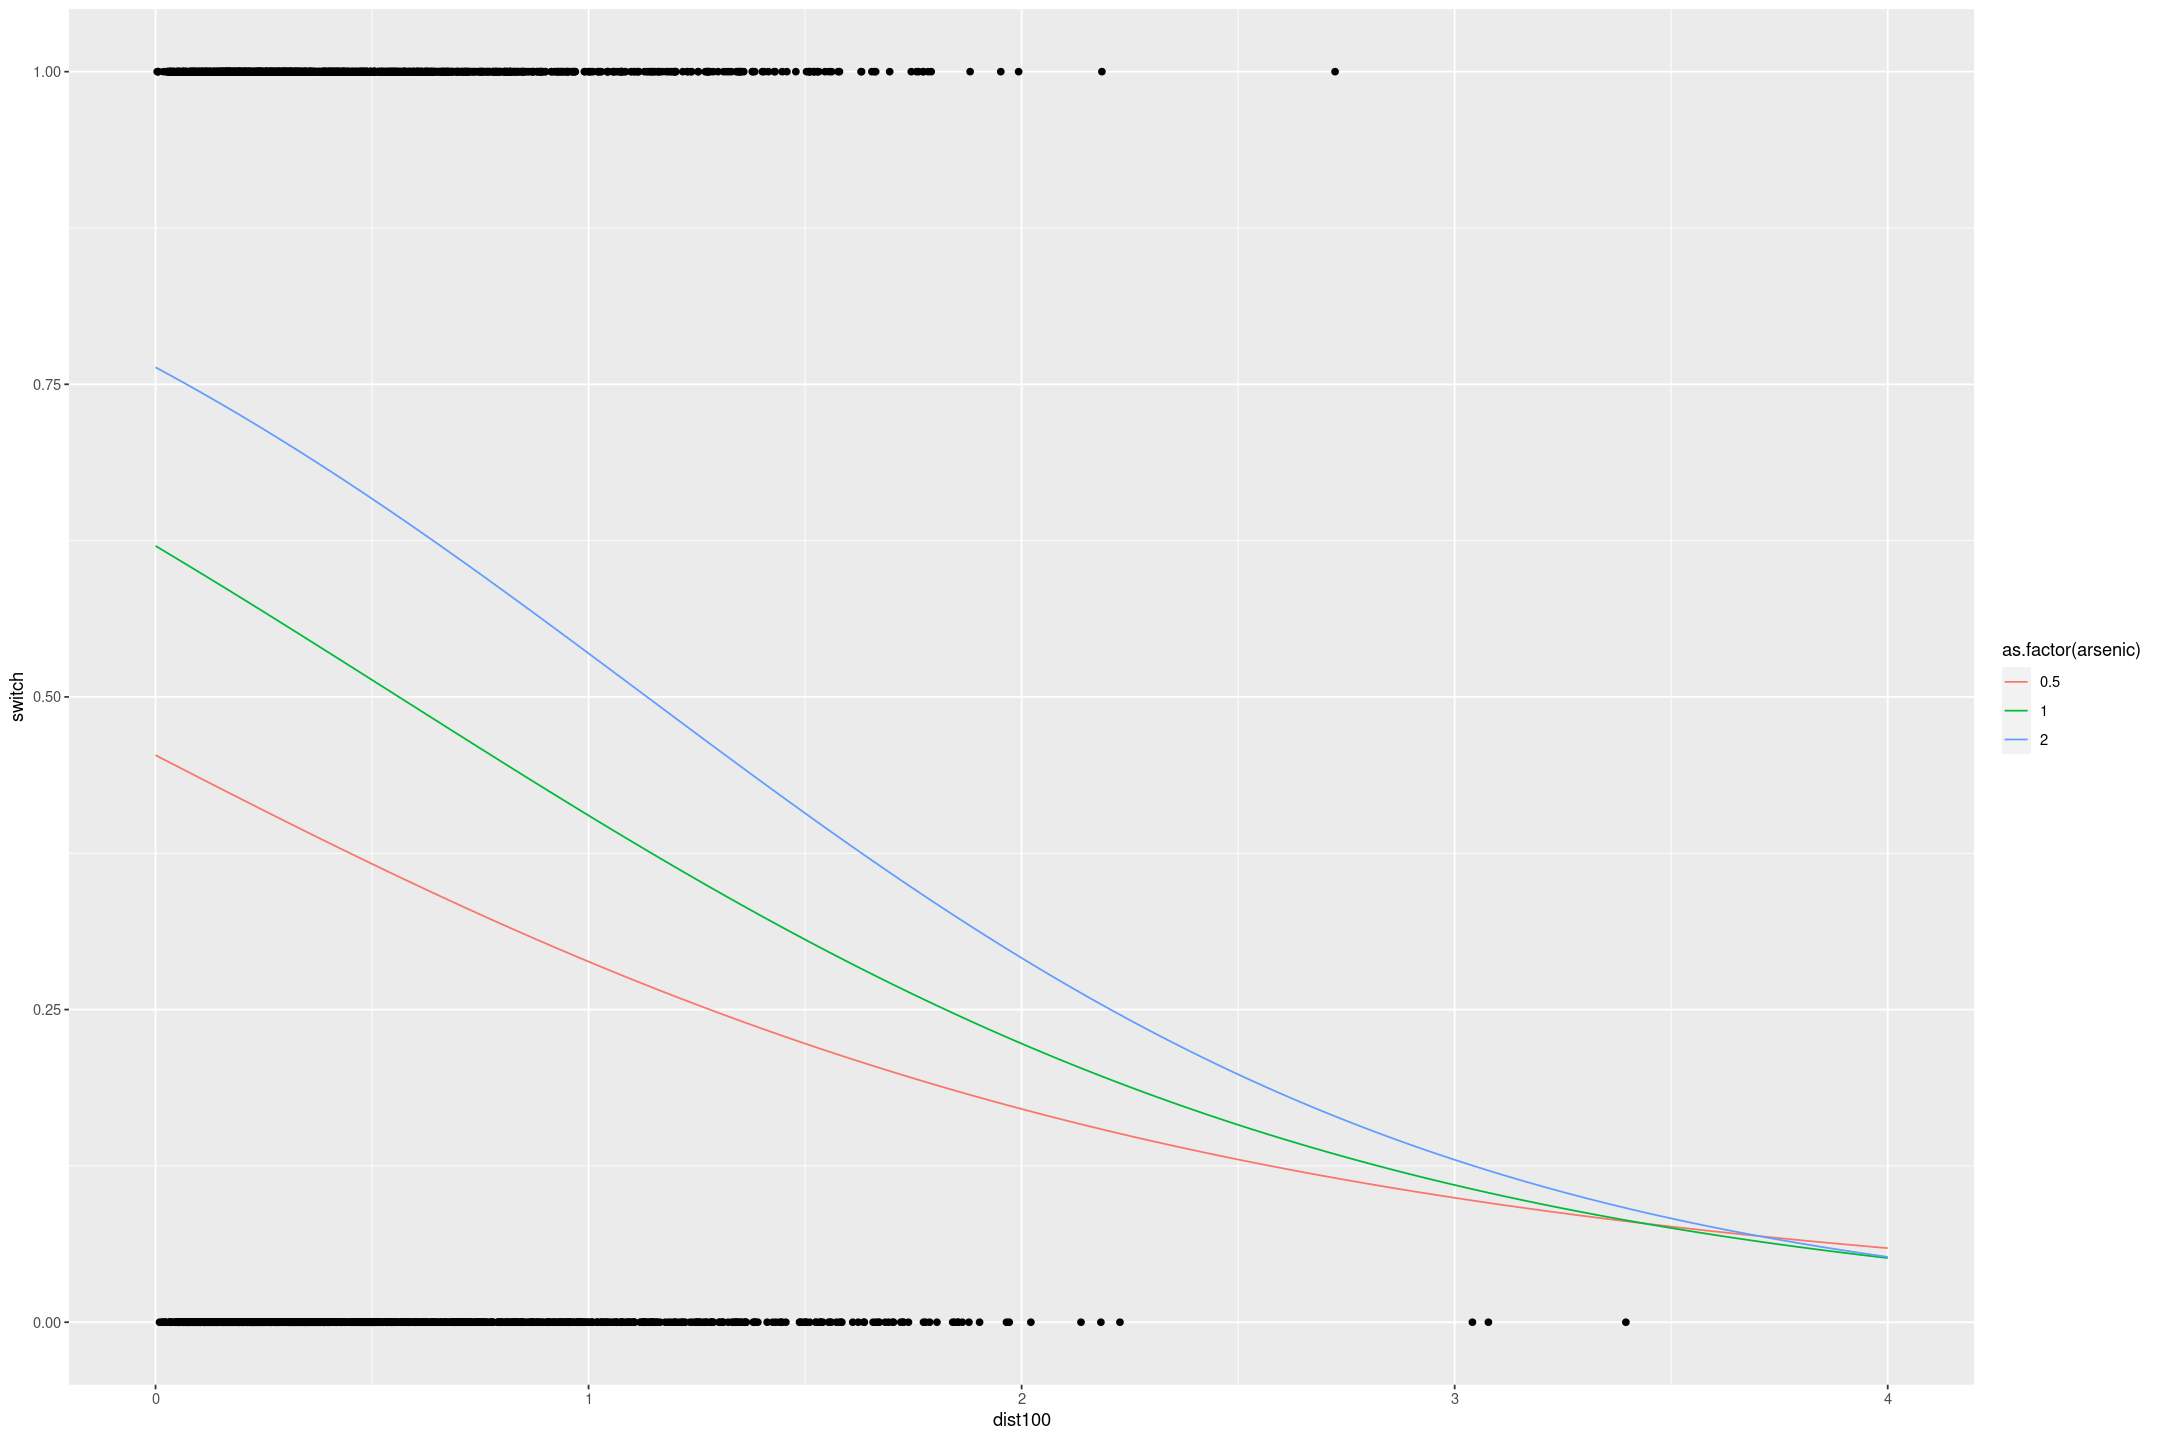

In [204]:
wells_dist_points <- crossing(dist100=seq(0, 4, by=0.01), arsenic=c(0.5, 1, 2)) %>%
mutate(pred = predict(fit_wells_dist_logas, newdata=., type="response"))

gf_point(switch ~ dist100, data=wells) %>%
gf_line(pred ~ dist100, col=~as.factor(arsenic), data=wells_dist_points)

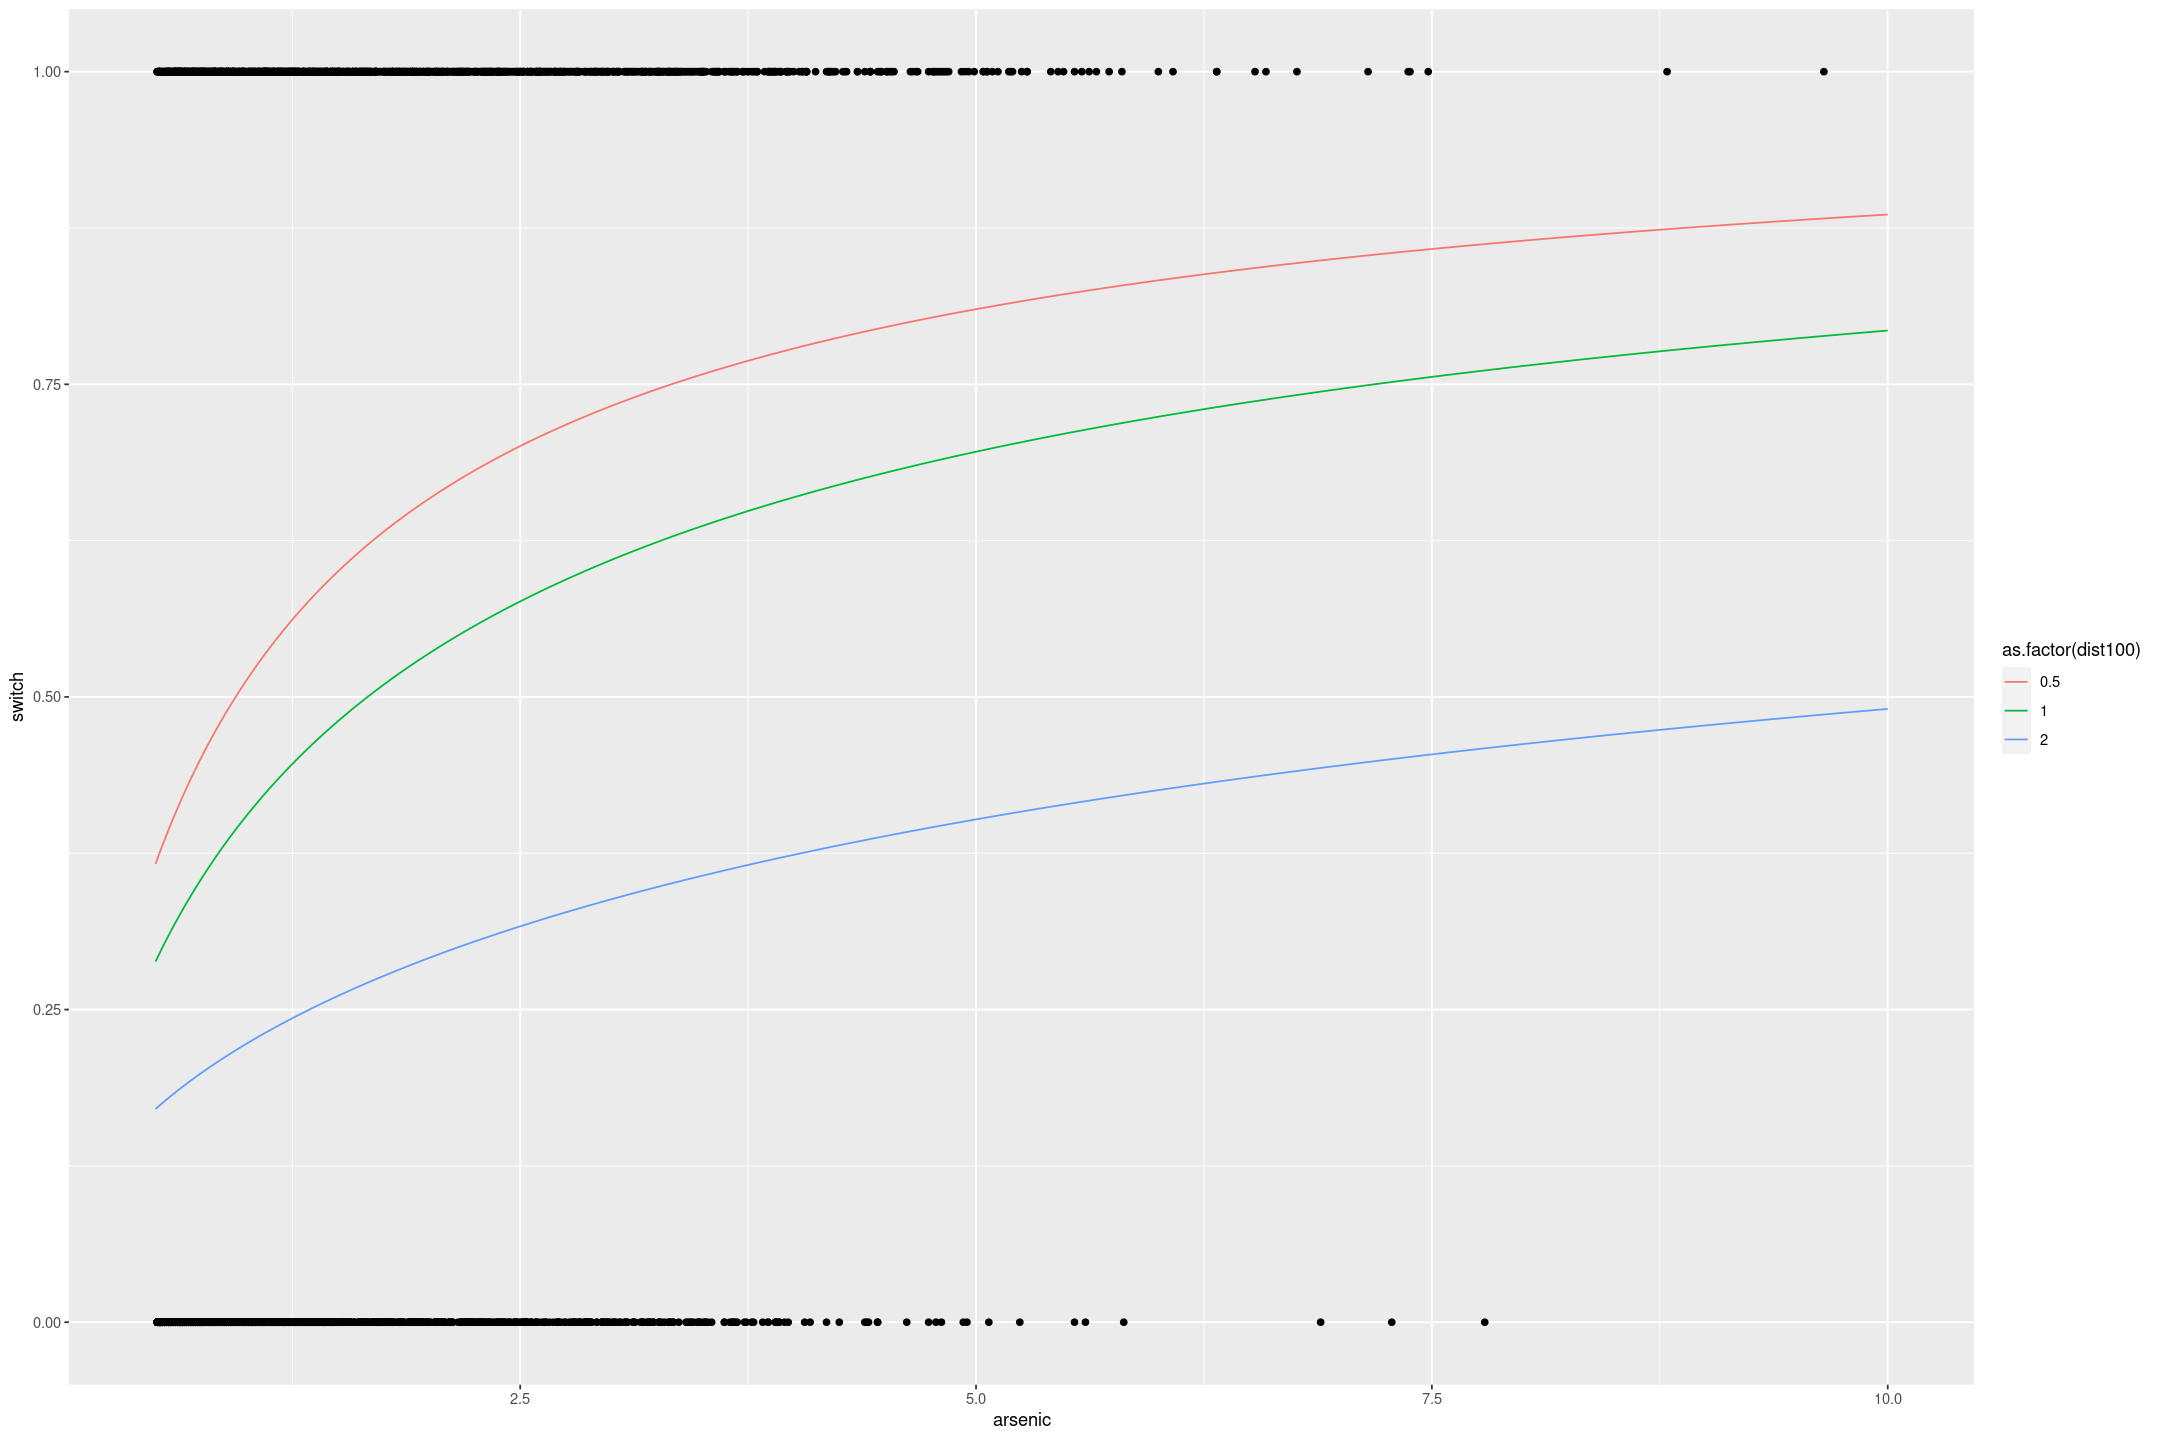

In [205]:
wells_as_points <- crossing(dist100=c(0.5, 1, 2), arsenic=seq(0.5, 10, by=0.01)) %>%
mutate(pred = predict(fit_wells_dist_logas, newdata=., type="response"))

gf_point(switch ~ arsenic, data=wells) %>%
gf_line(pred ~ arsenic, col=~as.factor(dist100), data=wells_as_points)

## Average predictive difference

Following the procedure described in Section 14.4, compute the average predictive differences corresponding to:

1. A comparison of `dist = 0` to `dist = 100`, with `arsenic` held constant.

Moving from `dist=0` to `dist=100` corresponds to an average predictive difference of 21%

In [206]:
mean(
    predict(fit_wells_dist_logas, type="response", newdata=wells %>% mutate(dist100=1)) -
    predict(fit_wells_dist_logas, type="response", newdata=wells %>% mutate(dist100=0))) %>%
scales::percent()

[1] "-21%"

2. A comparison of `dist=100` to `dist=200`, with `aresenic` held constant.

Moving from `dist=100` to `dist=200` results in another average predictive difference of 21%

In [207]:
mean(
    predict(fit_wells_dist_logas, type="response", newdata=wells %>% mutate(dist100=2)) -
    predict(fit_wells_dist_logas, type="response", newdata=wells %>% mutate(dist100=1))) %>%
scales::percent()

[1] "-21%"

3. A comparison of `arsenic=0.5` to `aresnic=1.0`, with `distance` held constant.

Increasing `arsenic` from 0.5 to 1.0 corresponds to an average predictive difference in 15%.

In [208]:
mean(
    predict(fit_wells_dist_logas, type="response", newdata=wells %>% mutate(arsenic=1)) -
    predict(fit_wells_dist_logas, type="response", newdata=wells %>% mutate(arsenic=0.5))) %>%
scales::percent()

[1] "15%"

4. A comparison of `arsenic=1.0` to `aresnic=2.0`, with `distance` held constant.

Increasing `arsenic` from 0.5 to 1.0 corresponds to an average predictive difference in a similar 14%.

In [209]:
mean(
    predict(fit_wells_dist_logas, type="response", newdata=wells %>% mutate(arsenic=2)) -
    predict(fit_wells_dist_logas, type="response", newdata=wells %>% mutate(arsenic=1))) %>%
scales::percent()

[1] "14%"

# Learning from social science data

The General Social Survey (GSS) has been conducted in the United State every two years since 1972.

## Download data

Go to the GSS website and download the data.
Consider a question of interest that was asked in many rounds of the survey and convert it to a binary outcome, if it is not binary already.
Decide how you will handle nonresponse in your analysis.

We can download the data easiely using [gssr](https://github.com/kjhealy/gssr) `remotes::install_github("kjhealy/gssr")`.

I got a bit confused by the GSS website's shopping interface.

In [210]:
# remotes::install_github("kjhealy/gssr")

In [211]:
library(gssr)

Package loaded. To attach the GSS data, type data(gss_all) at the console.
For the codebook, type data(gss_doc). The gss_all and gss_doc objects will then be available to use.



In [212]:
data(gss_all)
data(gss_doc)

Based on [Divorce](https://gssdataexplorer.norc.org/variables/21/vshow) 1 is a Yes, 2 is a No, and 0 is a Not Applicable (as in never been married).

It looks like non-response and not applicable have been thrown together.

In [213]:
gss_all %>% count(divorce)

divorce,n
<dbl+lbl>,<int>
1,8286
2,31806
NA,24722


For the purposes of this we can drop those to give `P(Divorce|Married)`

## Graphing average over time

Make a graph of the average response of this binary variable over time, each year giving $\pm 1$ standard error bounds as in Figure 4.3

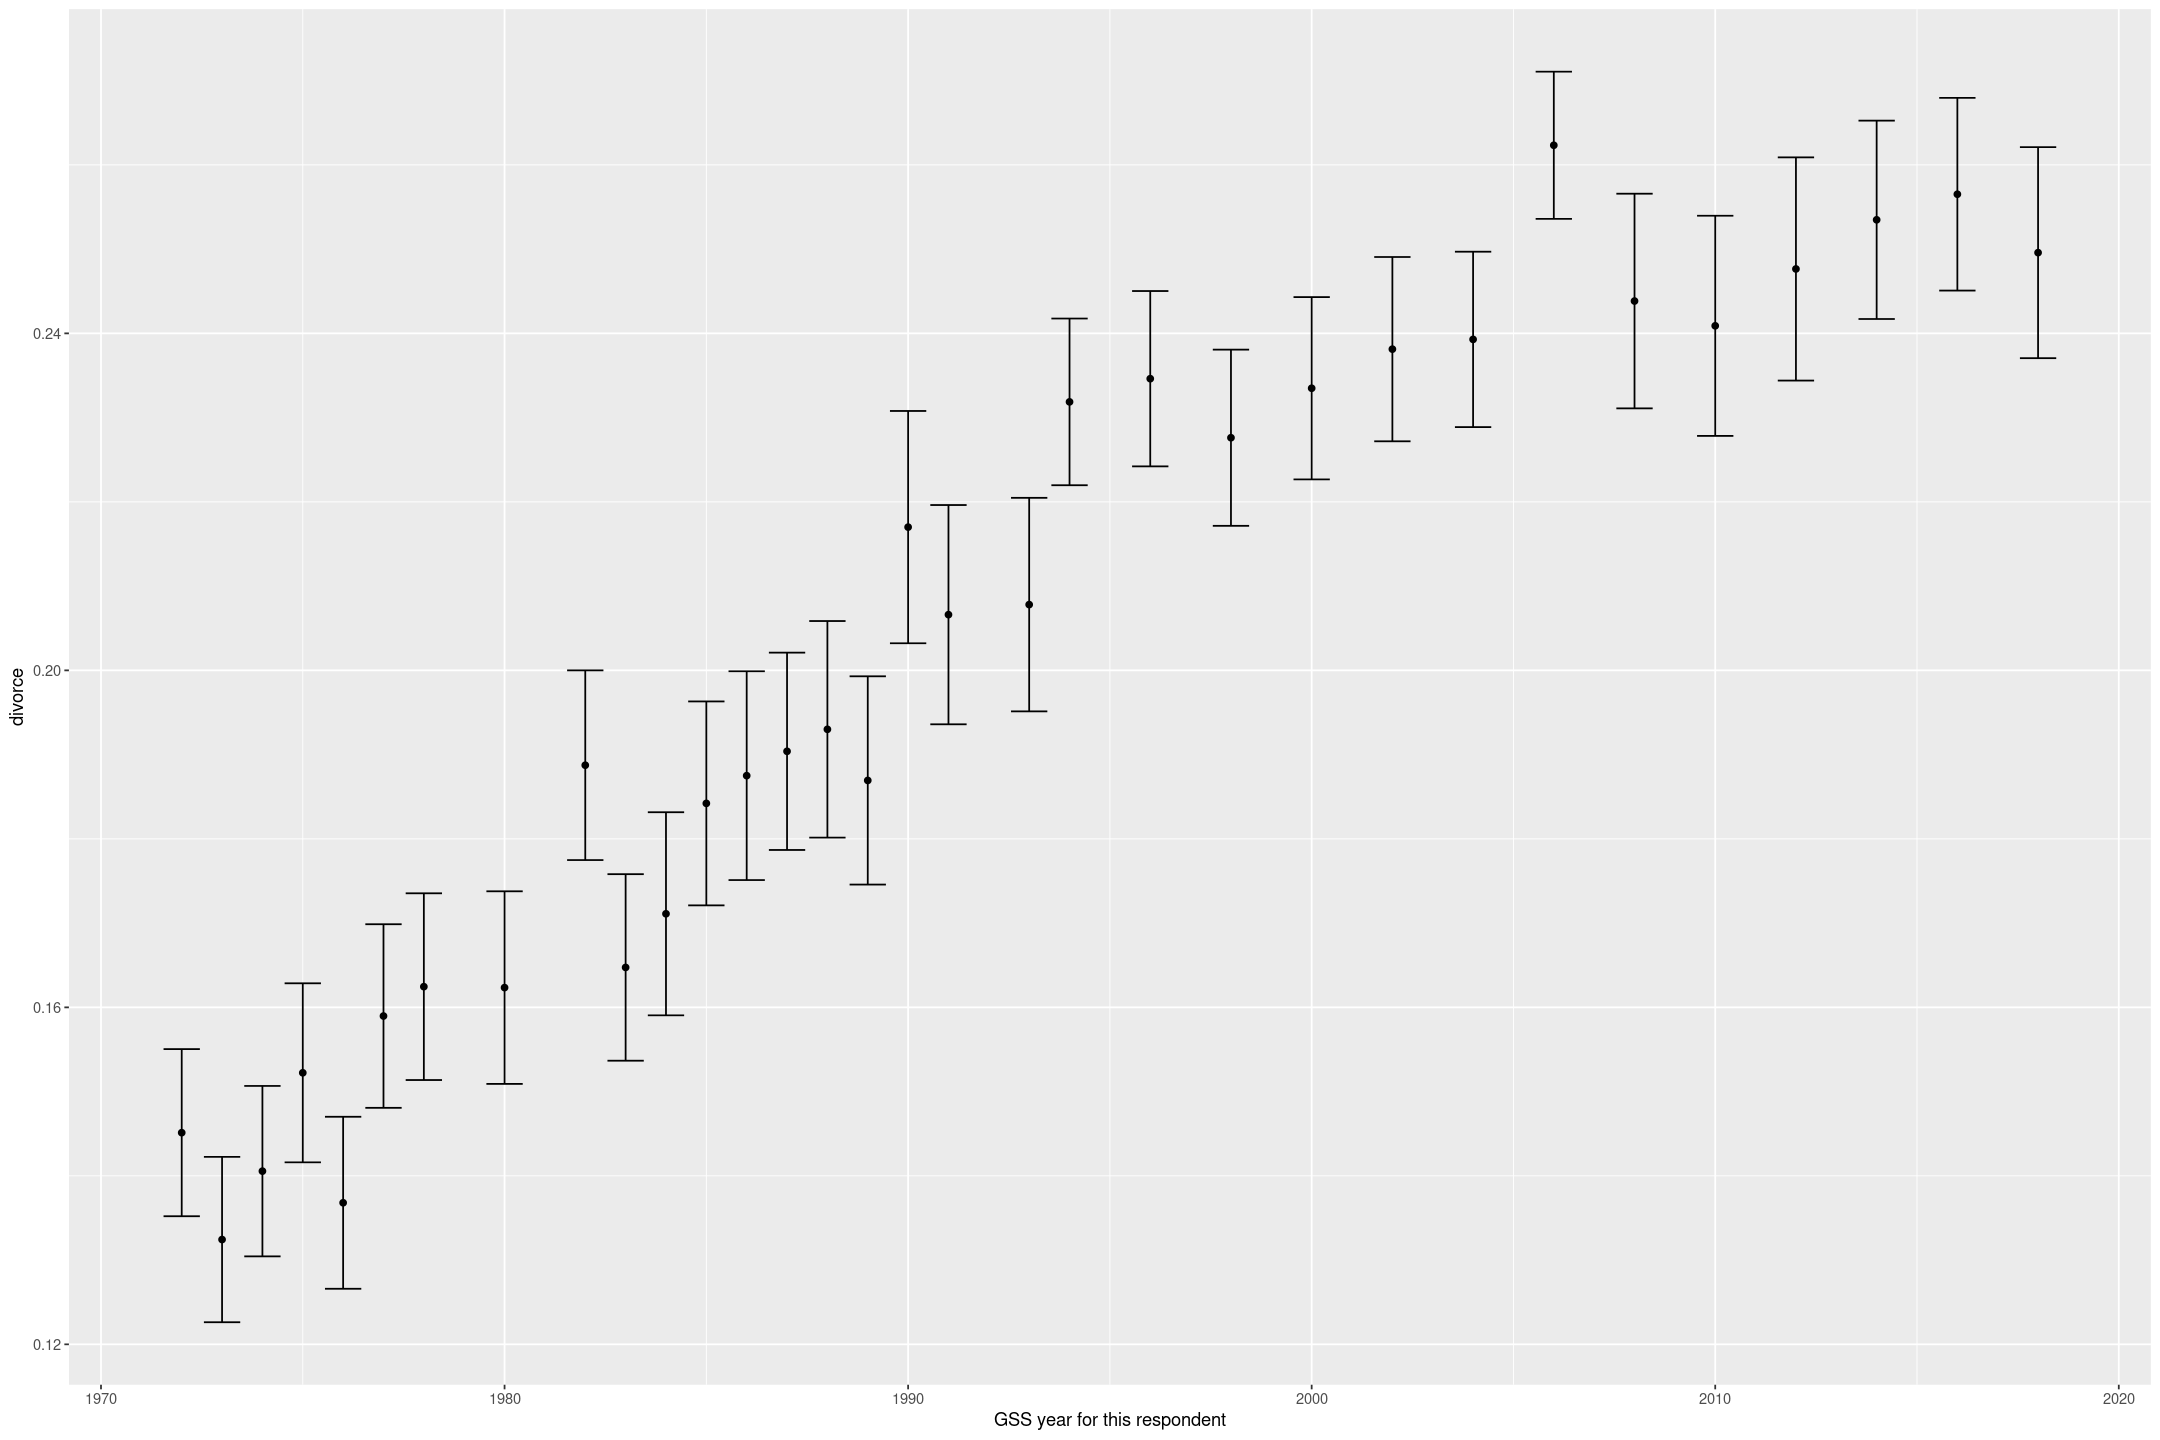

In [214]:
gss_all %>% 
filter(!is.na(divorce)) %>% 
group_by(year) %>% 
summarise(divorce=mean(divorce == 1), n=n()) %>%
mutate(se=sqrt(divorce * (1-divorce) / n)) %>%
gf_point(divorce ~ year) %>%
gf_errorbar(ymin=~divorce - se, ymax=~divorce+se)

## Graphing coefficients over time

Set up a logistic regression model of this outcome variable given predictors for age, sex, education, and ethnicity.
Fit the model separately for each year that the equation was asked, and make a grid of plots with the time series of coefficient estimates $\pm$ standard errors over time.

### Getting the data

There's a few ways we could capture Ethnicity:

* [ethnicity](https://gssdataexplorer.norc.org/variables/5263/vshow) which has many codes that need to be wrapped up
* [race](https://gssdataexplorer.norc.org/variables/82/vshow) (Black/White/Other)
* [hispanic](https://gssdataexplorer.norc.org/variables/5276/vshow) (2000 to present)

For now I'm going to go with `race` because it's easiest to understand and has long coverage.

In [215]:
gss_divorce <- 
gss_all %>% 
transmute(id,
          year,
          divorce=ifelse(divorce == 1, 1, 0), 
          age,
          educ,
          male = ifelse(sex == 1, 1, 0),
          black = ifelse(race== 2, 1, 0)) %>%
drop_na()

Notice that the age is increasing over the years, likely reflecting the increasing age of marriage and/or aging population.

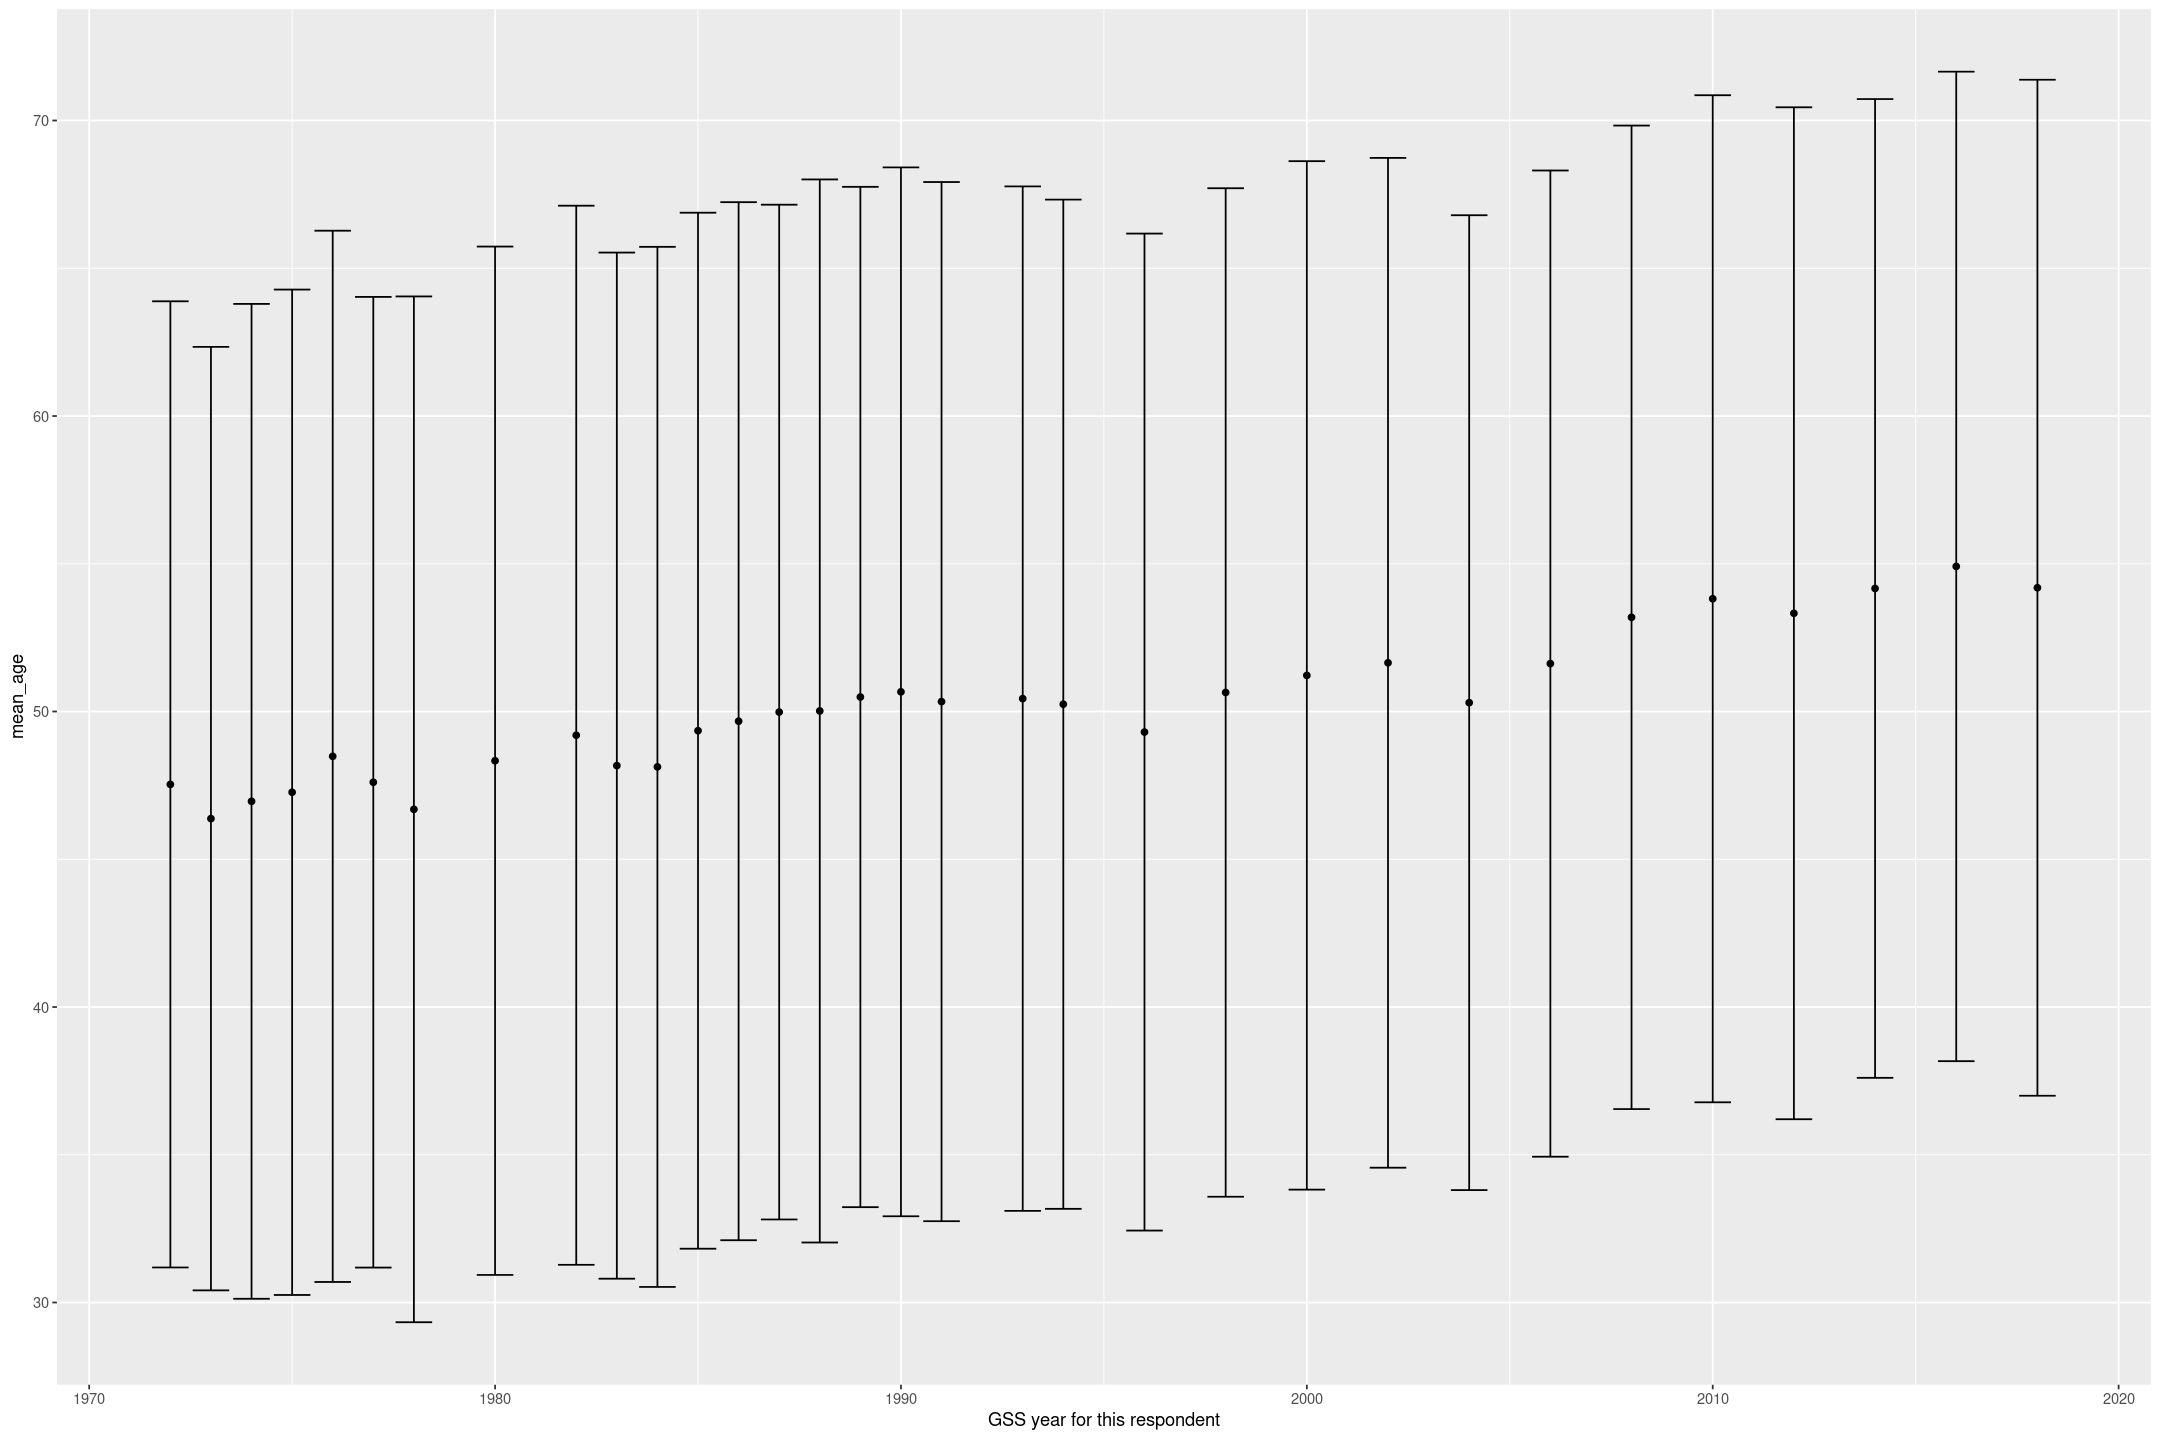

In [216]:
gss_divorce %>%
group_by(year) %>%
summarise(mean_age = mean(age), sd_age=sd(age)) %>%
gf_point(mean_age ~ year) %>%
gf_errorbar(ymin=~mean_age-sd_age, ymax=~mean_age+sd_age)

Interestingly the average years of education is increasing over time too.

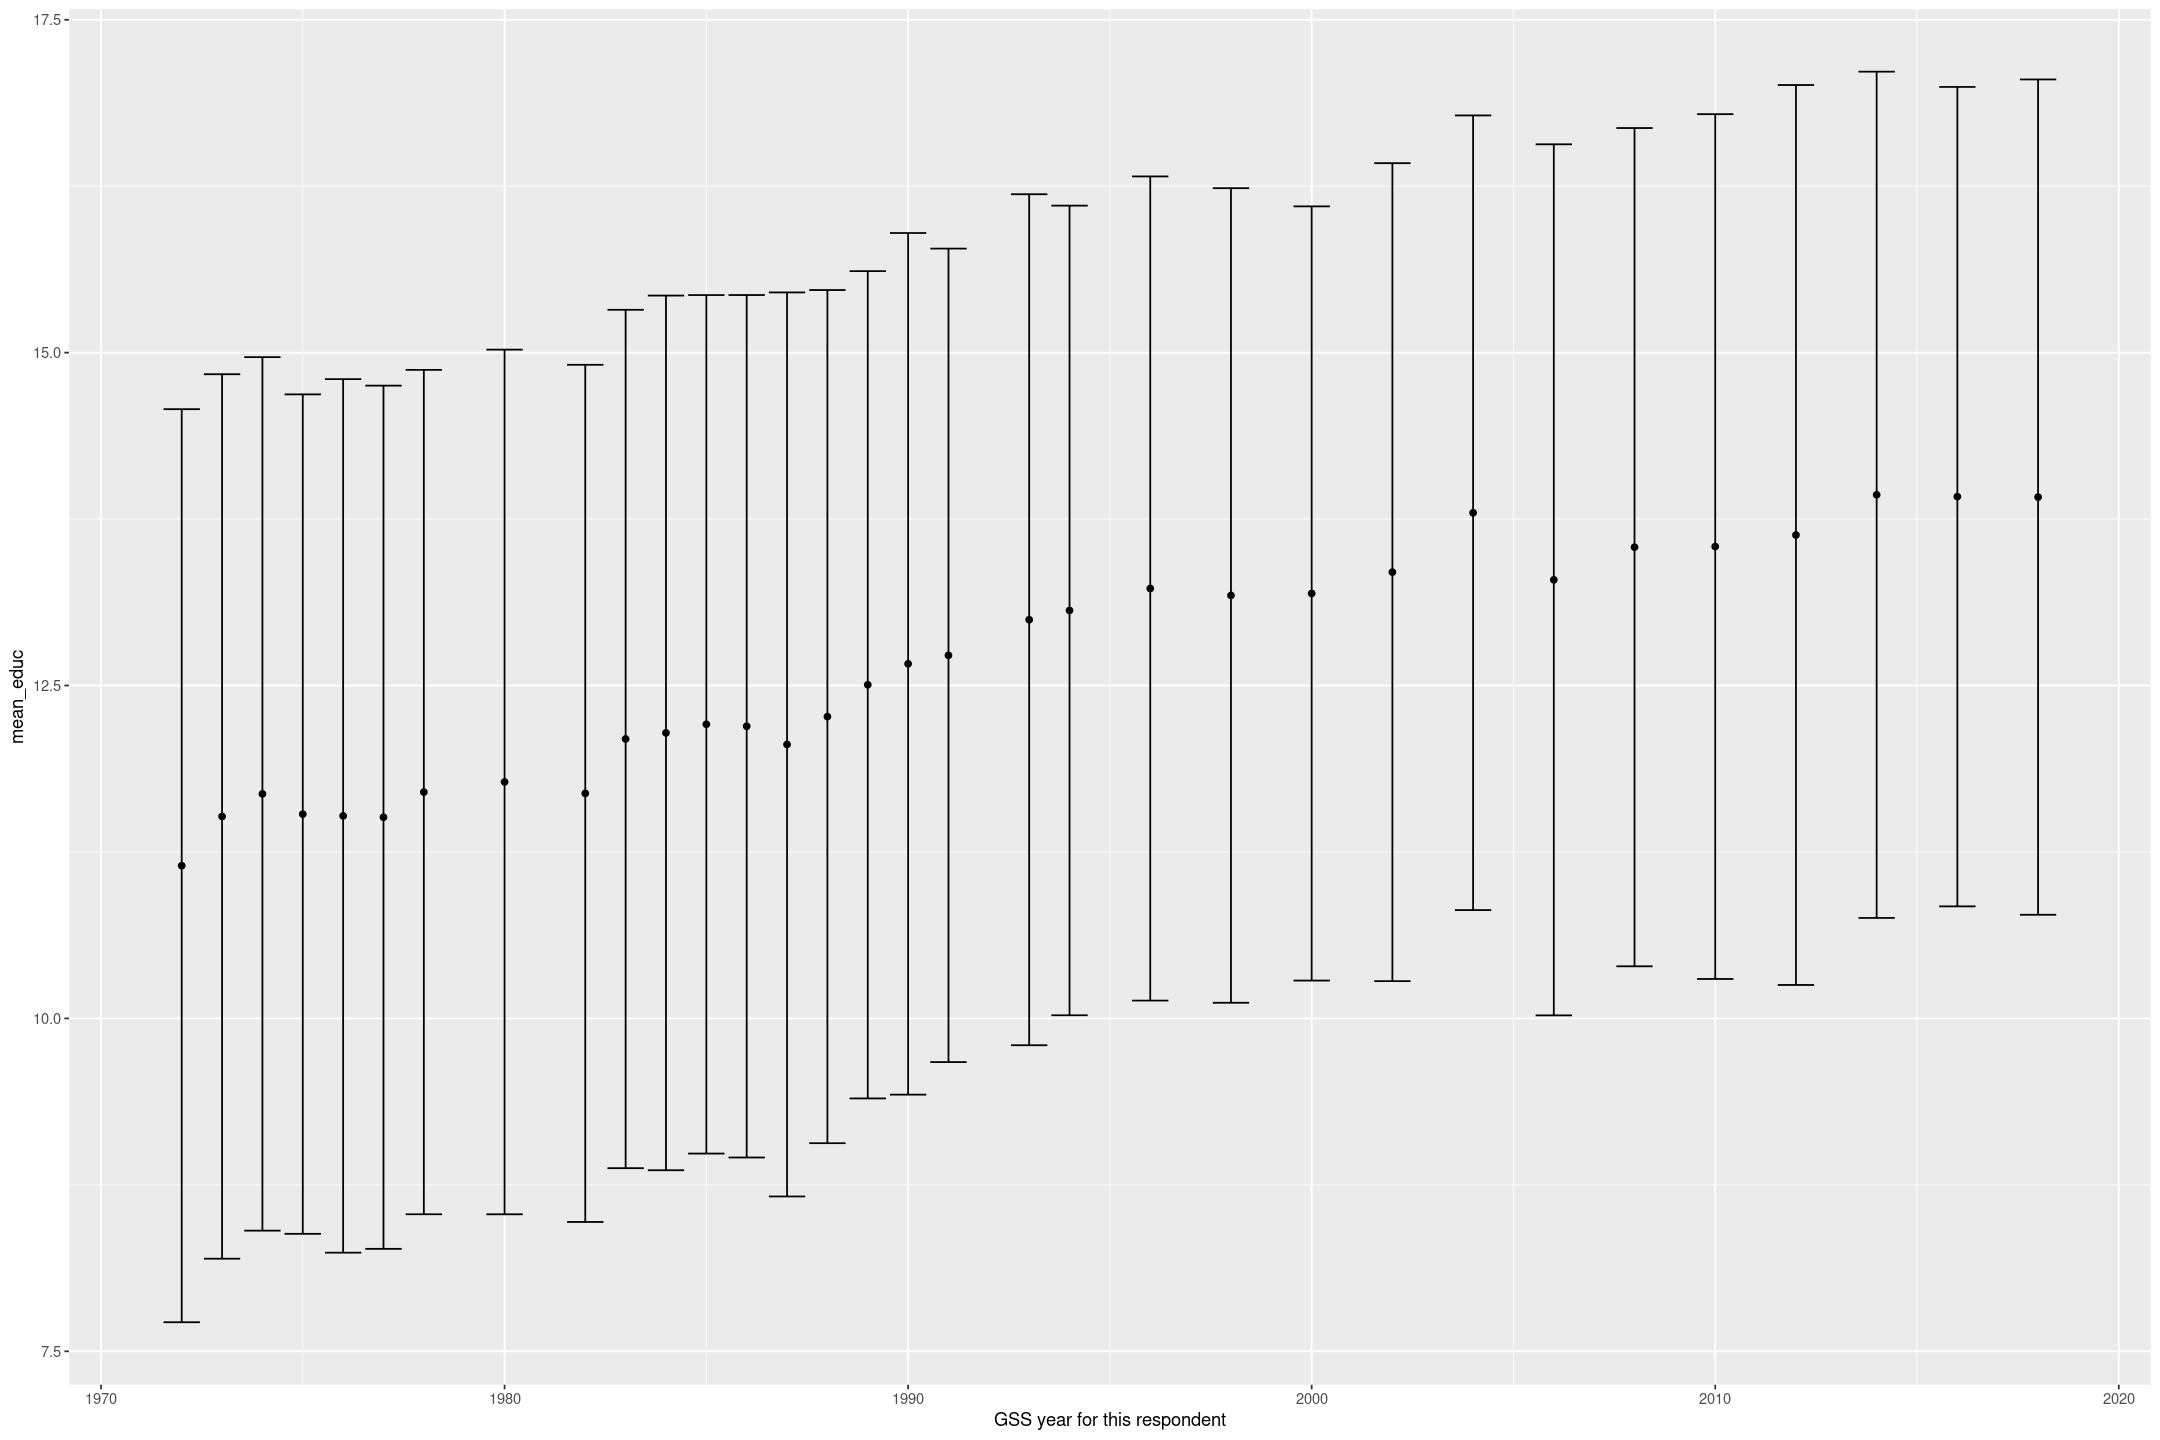

In [217]:
gss_divorce %>%
group_by(year) %>%
summarise(mean_educ = mean(educ), sd_educ=sd(educ)) %>%
gf_point(mean_educ ~ year) %>%
gf_errorbar(ymin=~mean_educ-sd_educ, ymax=~mean_educ+sd_educ)

### Fitting the models

In [218]:
gss_divorce_models <- 
gss_divorce %>%
group_by(year) %>%
nest(data=c(id, divorce, age, male, black, educ)) %>%
mutate(model = purrr::map(data, ~stan_glm(divorce ~ age + male + black + educ, family=binomial(link='logit'), data=., refresh=0, QR=TRUE)))

### Showing the coefficients

The impact of age increases over time, and the effect of race decreaes over time (gender is a wash, which makes sense since a marriage and divorce always involved a male and a female).
Education reduces the impact of divorce, but the estimate is a bit unstable.

It's hard to interpret the intercept because a 0 year old wouldn't get married, let alone divorced.

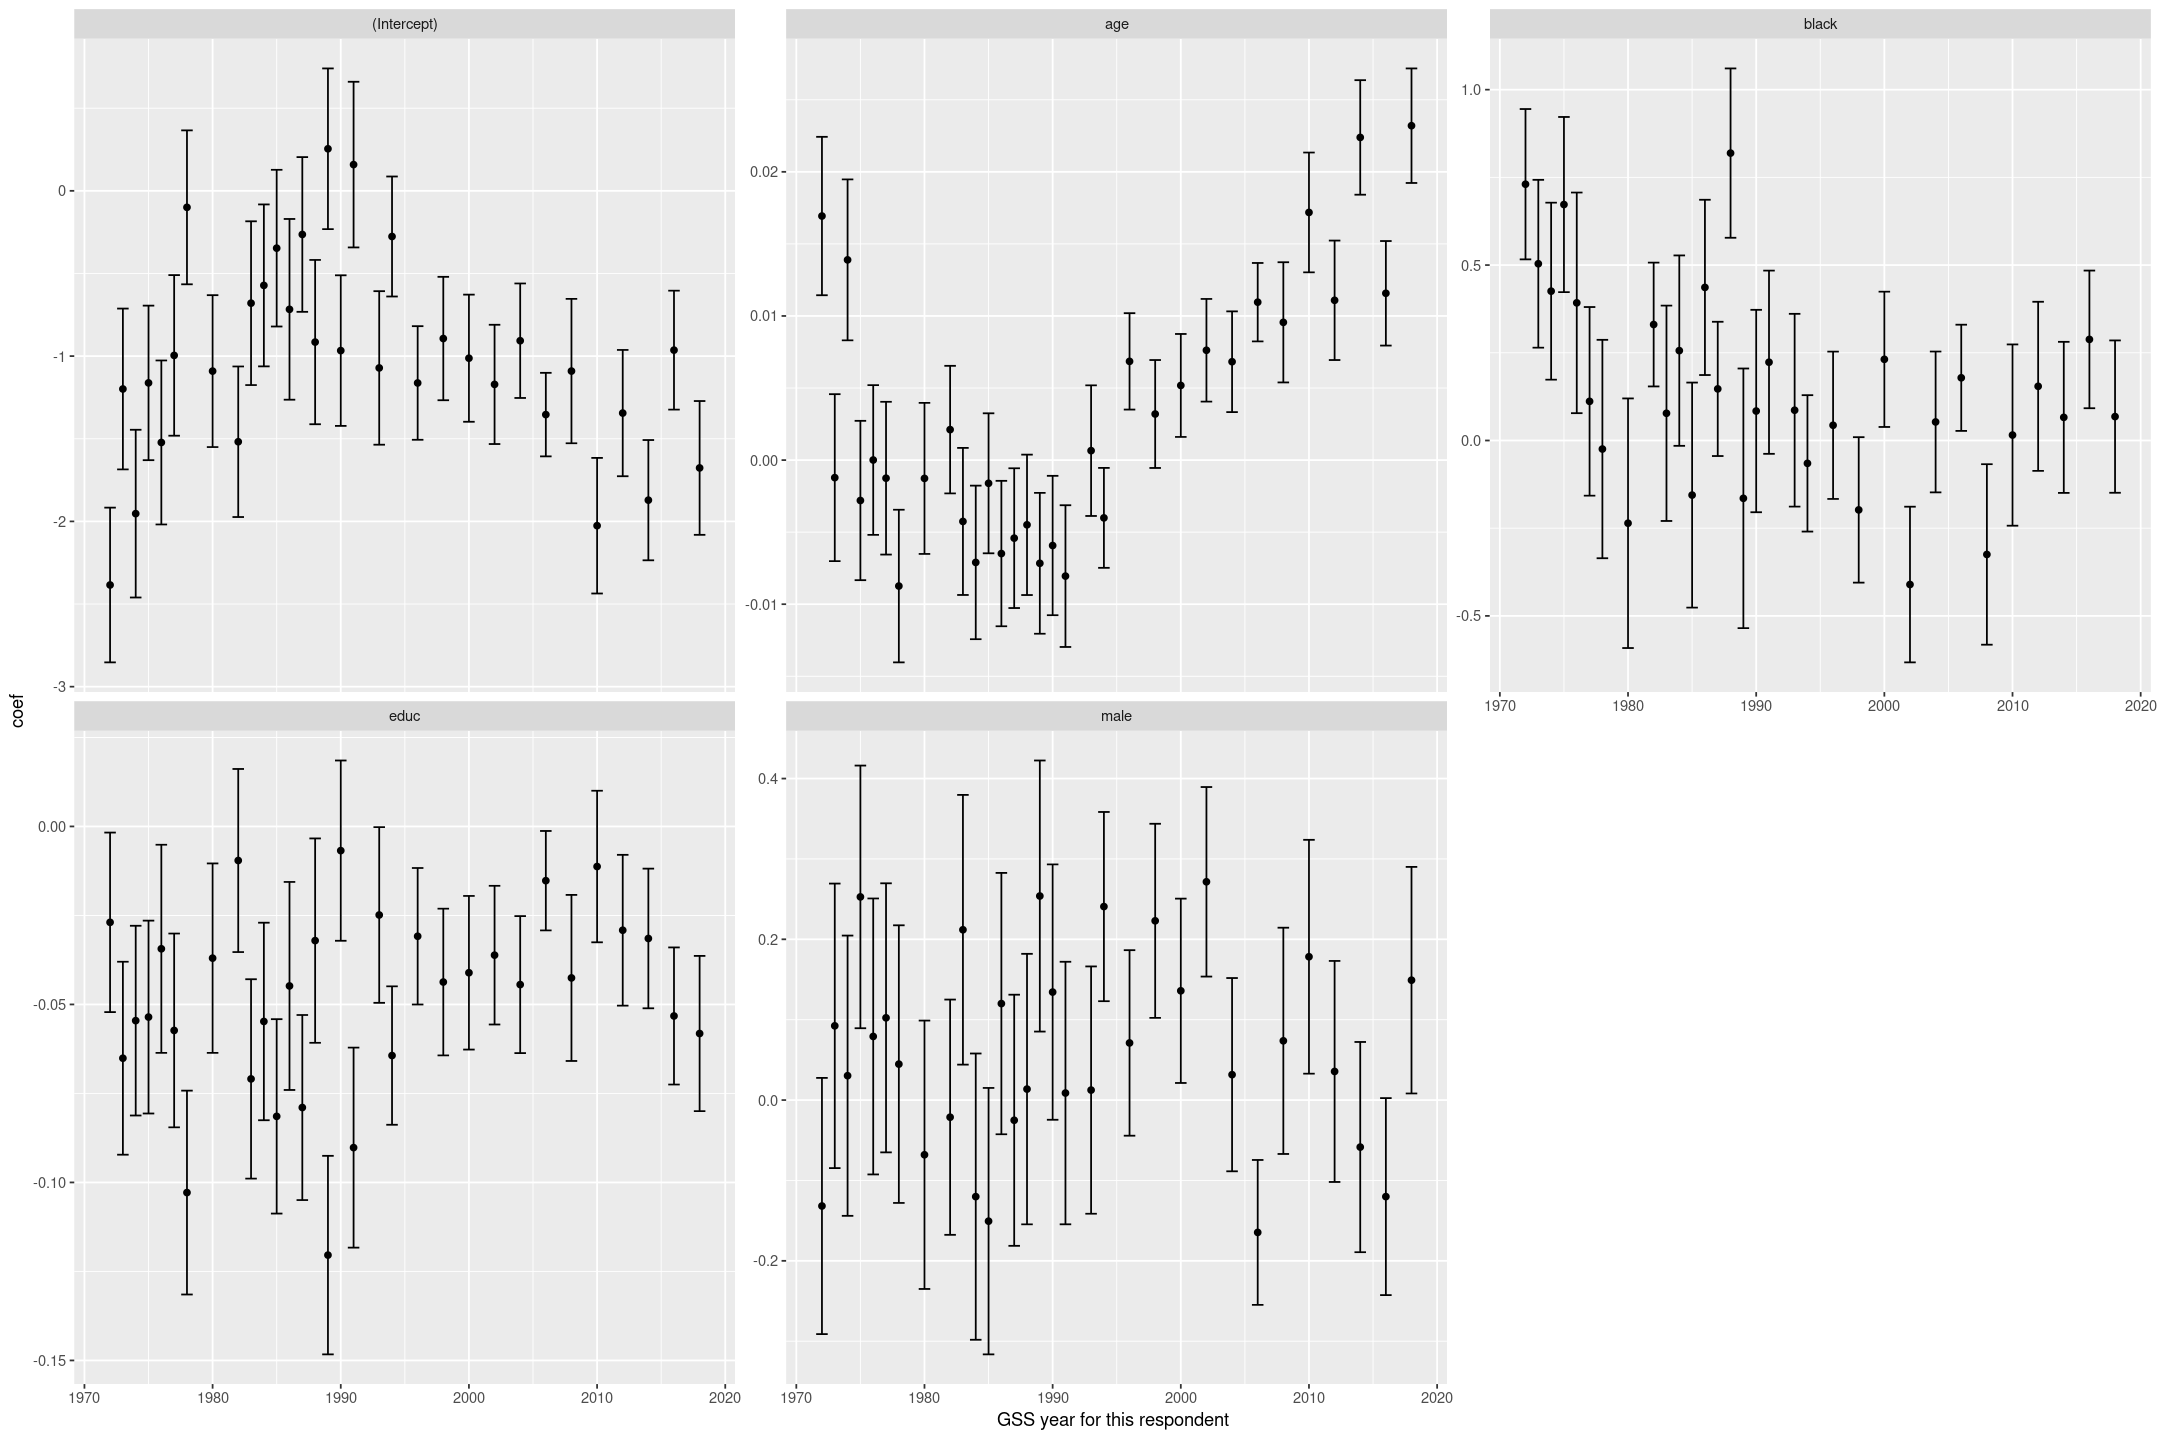

In [219]:
gss_divorce_models %>%
mutate(coef=purrr::map(model, coef),
       se = purrr::map(model, se),
       name=purrr::map(coef, names),
      ) %>%
select(-data, -model) %>%
unnest(c(coef, name, se)) %>%
gf_point(coef ~ year) %>%
gf_errorbar(ymin=~coef-se, ymax=~coef+se) %>%
gf_facet_wrap(~name, scales="free_y")

## Next steps


Discuss the results and how you might want to expand your model to answer some social science question of interest.

It could be interesting to look at how differences in laws between states and changes in laws over time relate to outcomes in divorce rates.
It may be necessary to adjust for other major factors that change over time, for example religiosity.

# Linear or logistic regession for discrete data

Simulate continuous data from the regression model, $z = a + bx + {\rm error}$.
Set the parameters so that the outcomes $z$ are positive for about half the time and negative about half the time.

In [220]:
n <- 100
a <- 0
b <- 1
x <- runif(n, -3, 3)
z <- a + b*x + rnorm(n, 0, 1)

## Logistic model

Create a binary variable $y$ that equals 1 if $z$ is positive of 0 if $z$ is negative.
Fite a logistic regression predicting $y$ from $x$.

In [221]:
y <- if_else(z > 0, 1, 0)

fake_data <- data.frame(x, y)
fake_model <- stan_glm(y ~ x, family=binomial(link='logit'), data=fake_data)

In [222]:
fake_model

stan_glm
 family:       binomial [logit]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) 0.2    0.3   
x           1.9    0.4   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

## Linear model

Fit a linear regression predicting $y$ from $x$: you can do this, even though the data $y$ are discrete.

In [223]:
fake_linear_model <- stan_glm(y ~ x, data=fake_data)

In [224]:
fake_linear_model

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) 0.5    0.0   
x           0.2    0.0   

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.3    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

## Comparing average predictive comparisons

Estimate the average predictive comparison - the expected difference in $y$, corresponding to a unit difference in $x$ - based on the fitted logistic regression.
Compare this average predictive comparison to the linear regression coefficient.

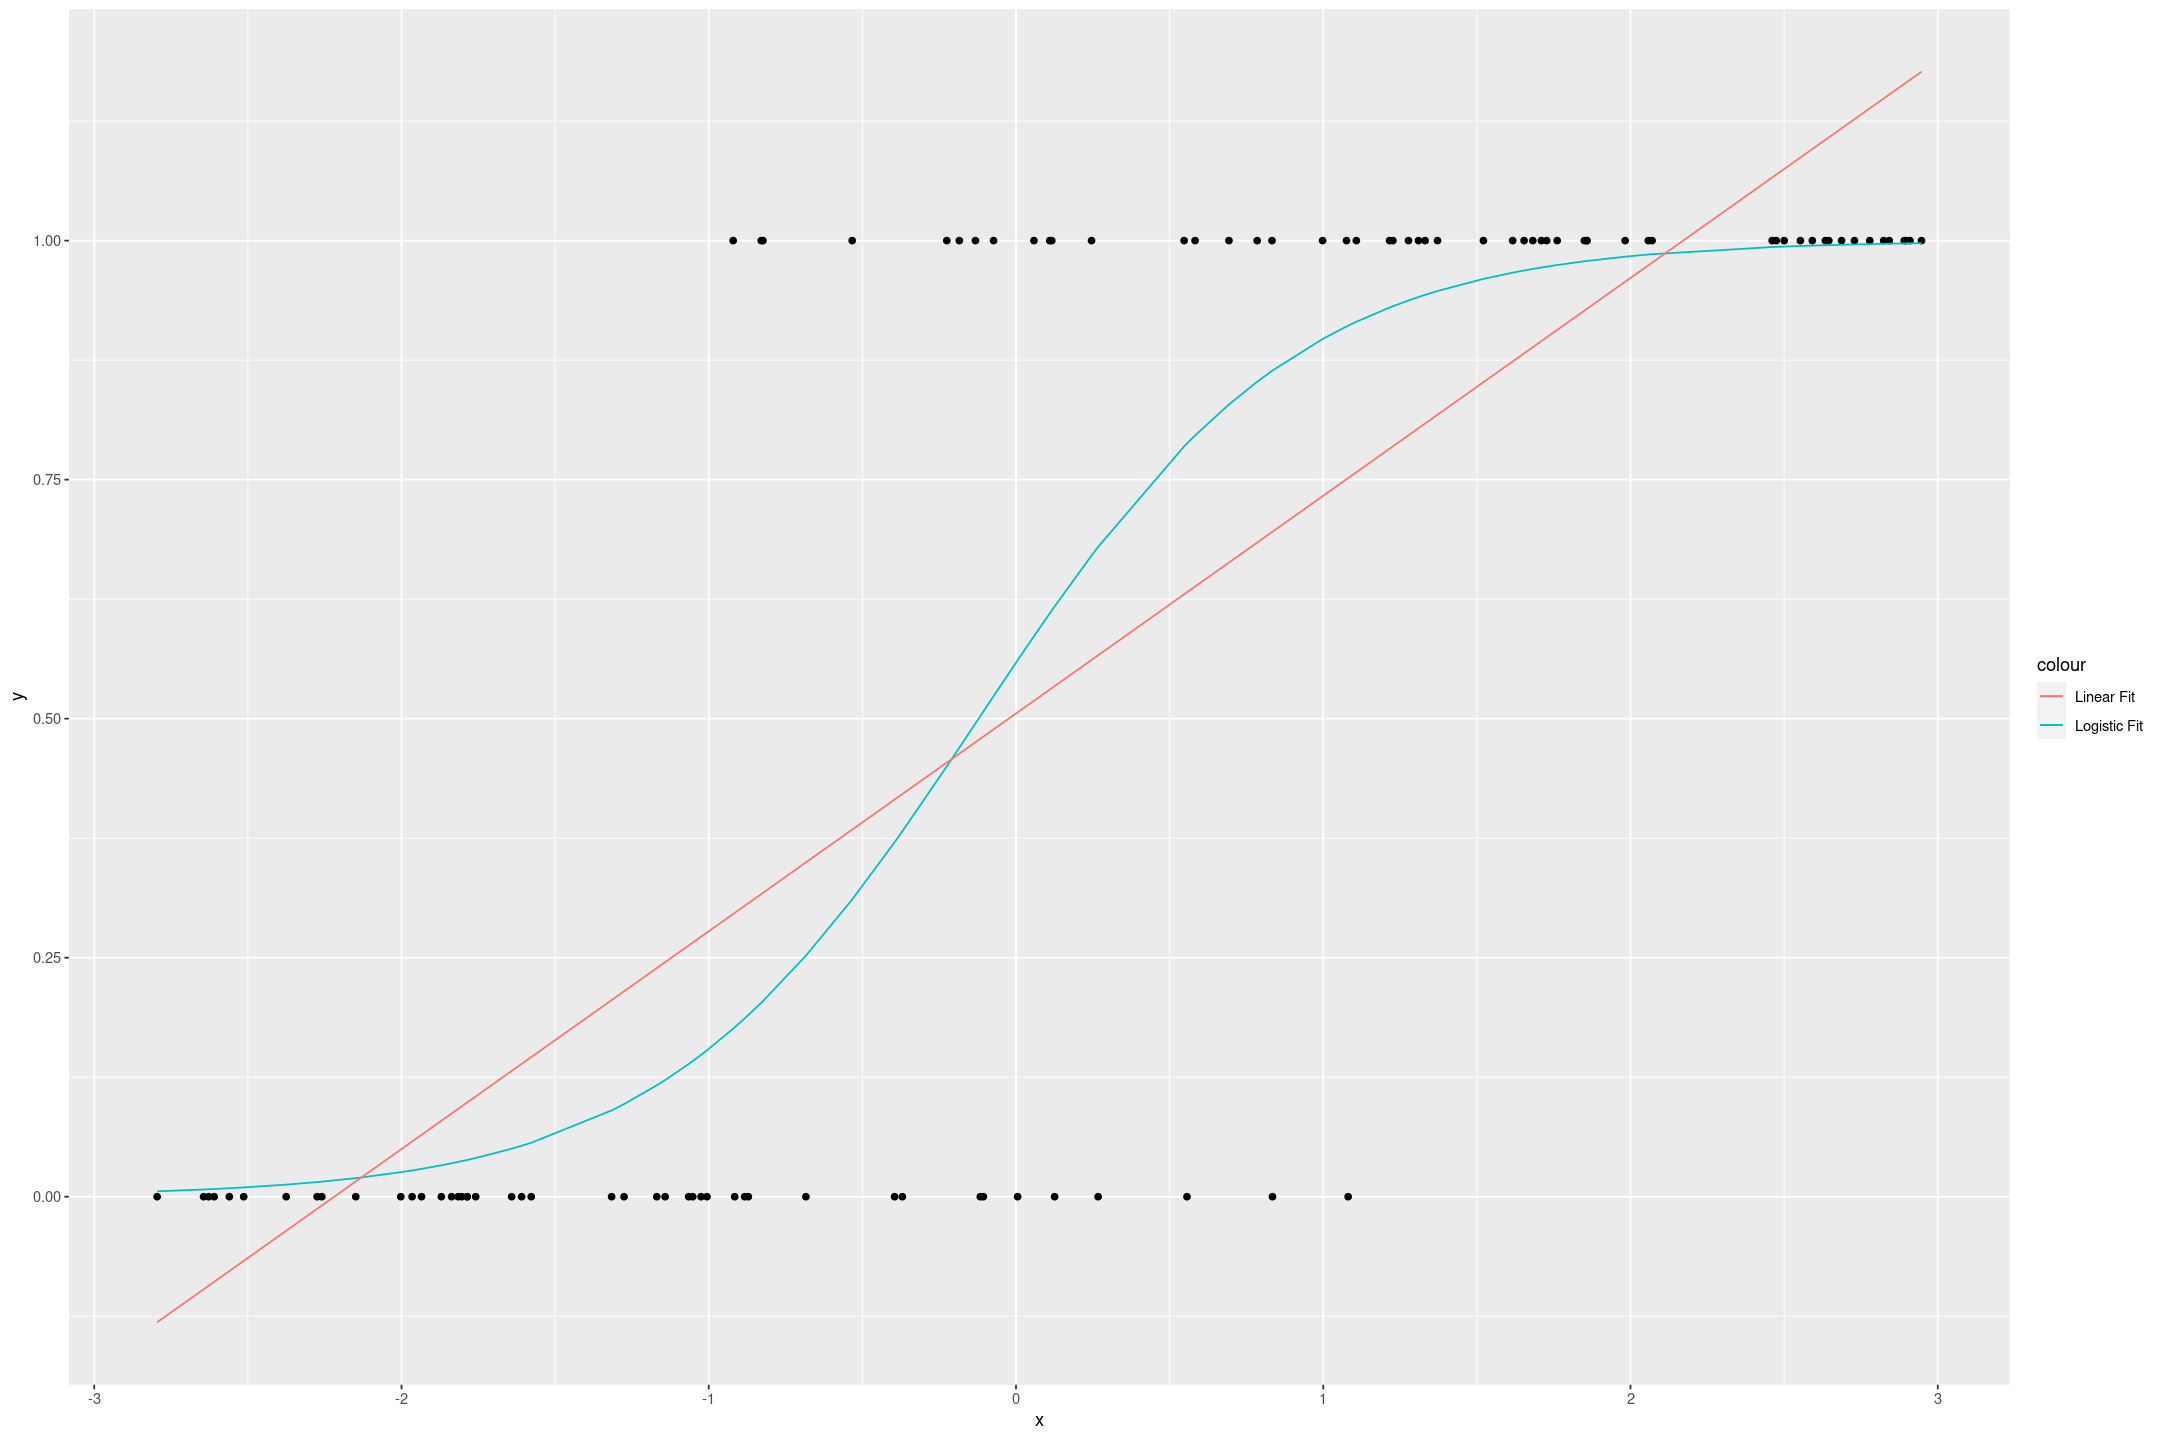

In [225]:
fake_data %>% 
mutate(binom_pred = predict(fake_model, type="response"),
       linear_pred = predict(fake_linear_model)) %>%
gf_point(y ~ x) %>%
gf_line(binom_pred ~ x, col=~"Logistic Fit") %>%
gf_line(linear_pred ~ x, col=~"Linear Fit")

For the linear model a difference in 1 of x corresponds to a change in

In [226]:
coef(fake_linear_model)['x']

x 
0.2277788

For the logistic model a difference in 1 in x corresponds to a change of *at most*

In [227]:
coef(fake_model)['x']/4

x 
0.4835788

The average predictive difference comes from averaging over all the points.
We could compare for each point decreasing x by 0.5 to increasing x by 0.5.

Then the linear model gives us exactly the coefficient.

In [228]:
mean(
    predict(fake_linear_model, newdata=fake_data %>% mutate(x=x+0.5), type="response") -
    predict(fake_linear_model, newdata=fake_data %>% mutate(x=x-0.5), type="response")
)

[1] 0.2281472

But the logistic model gives us some average.

In [229]:
mean(
    predict(fake_model, newdata=fake_data %>% mutate(x=x+0.5), type="response") -
    predict(fake_model, newdata=fake_data %>% mutate(x=x-0.5), type="response")
)

[1] 0.163068

Consider taking a smaller step, 0.05 in each direction, and dividing by that.

This leaves the linear model unchanged.

In [230]:
mean(
    predict(fake_linear_model, newdata=fake_data %>% mutate(x=x+0.05), type="response") -
    predict(fake_linear_model, newdata=fake_data %>% mutate(x=x-0.05), type="response")
) / 0.1

[1] 0.2281472

But *slightly* increases the average predictice difference in the logistic model because we get further from the edges.

In [231]:
mean(
    predict(fake_model, newdata=fake_data %>% mutate(x=x+0.05), type="response") -
    predict(fake_model, newdata=fake_data %>% mutate(x=x-0.05), type="response")
) / 0.1

[1] 0.1631587

This seems to converge to 18.29% as the step size decreases.

In [232]:
mean(
    predict(fake_model, newdata=fake_data %>% mutate(x=x+0.005), type="response") -
    predict(fake_model, newdata=fake_data %>% mutate(x=x-0.005), type="response")
) / 0.01

[1] 0.1631603

In [233]:
mean(
    predict(fake_model, newdata=fake_data %>% mutate(x=x+0.0005), type="response") -
    predict(fake_model, newdata=fake_data %>% mutate(x=x-0.0005), type="response")
) / 0.001

[1] 0.1631603

In [234]:
mean(
    predict(fake_model, newdata=fake_data %>% mutate(x=x+1e-8/2), type="response") -
    predict(fake_model, newdata=fake_data %>% mutate(x=x-1e-8/2), type="response")
) / 1e-8

[1] 0.1631603

In [235]:
mean(
    predict(fake_model, newdata=fake_data %>% mutate(x=x+1e-8), type="response") -
    predict(fake_model, newdata=fake_data %>% mutate(x=x), type="response")
) / 1e-8

[1] 0.1631603

This is closely related to evaluating the coefficient multiplied by the derivative of the inverse logit at each point (see above).

In [236]:
p = predict(fake_model, type="response")
coef(fake_model)['x']  * mean(p * (1-p))

x 
0.1636562

# Linear or logistic regression for discrete data

In the setup of the previous exercise:

## Example where logistic and linear are similar

Set the parameters of your simulation so that the coefficient estimate and the average predictive comparison are close.

Across a narrow range the linear approximation is very good

In [237]:
n <- 100
a <- 0
b <- 1
x <- runif(n, 0.25, 0.3)
z <- a + b*x + rnorm(n, 0, 1)

y <- if_else(z > 0, 1, 0)

fake_data <- data.frame(x, y)
fake_model <- stan_glm(y ~ x, family=binomial(link='logit'), data=fake_data)

fake_linear_model <- stan_glm(y ~ x, data=fake_data)

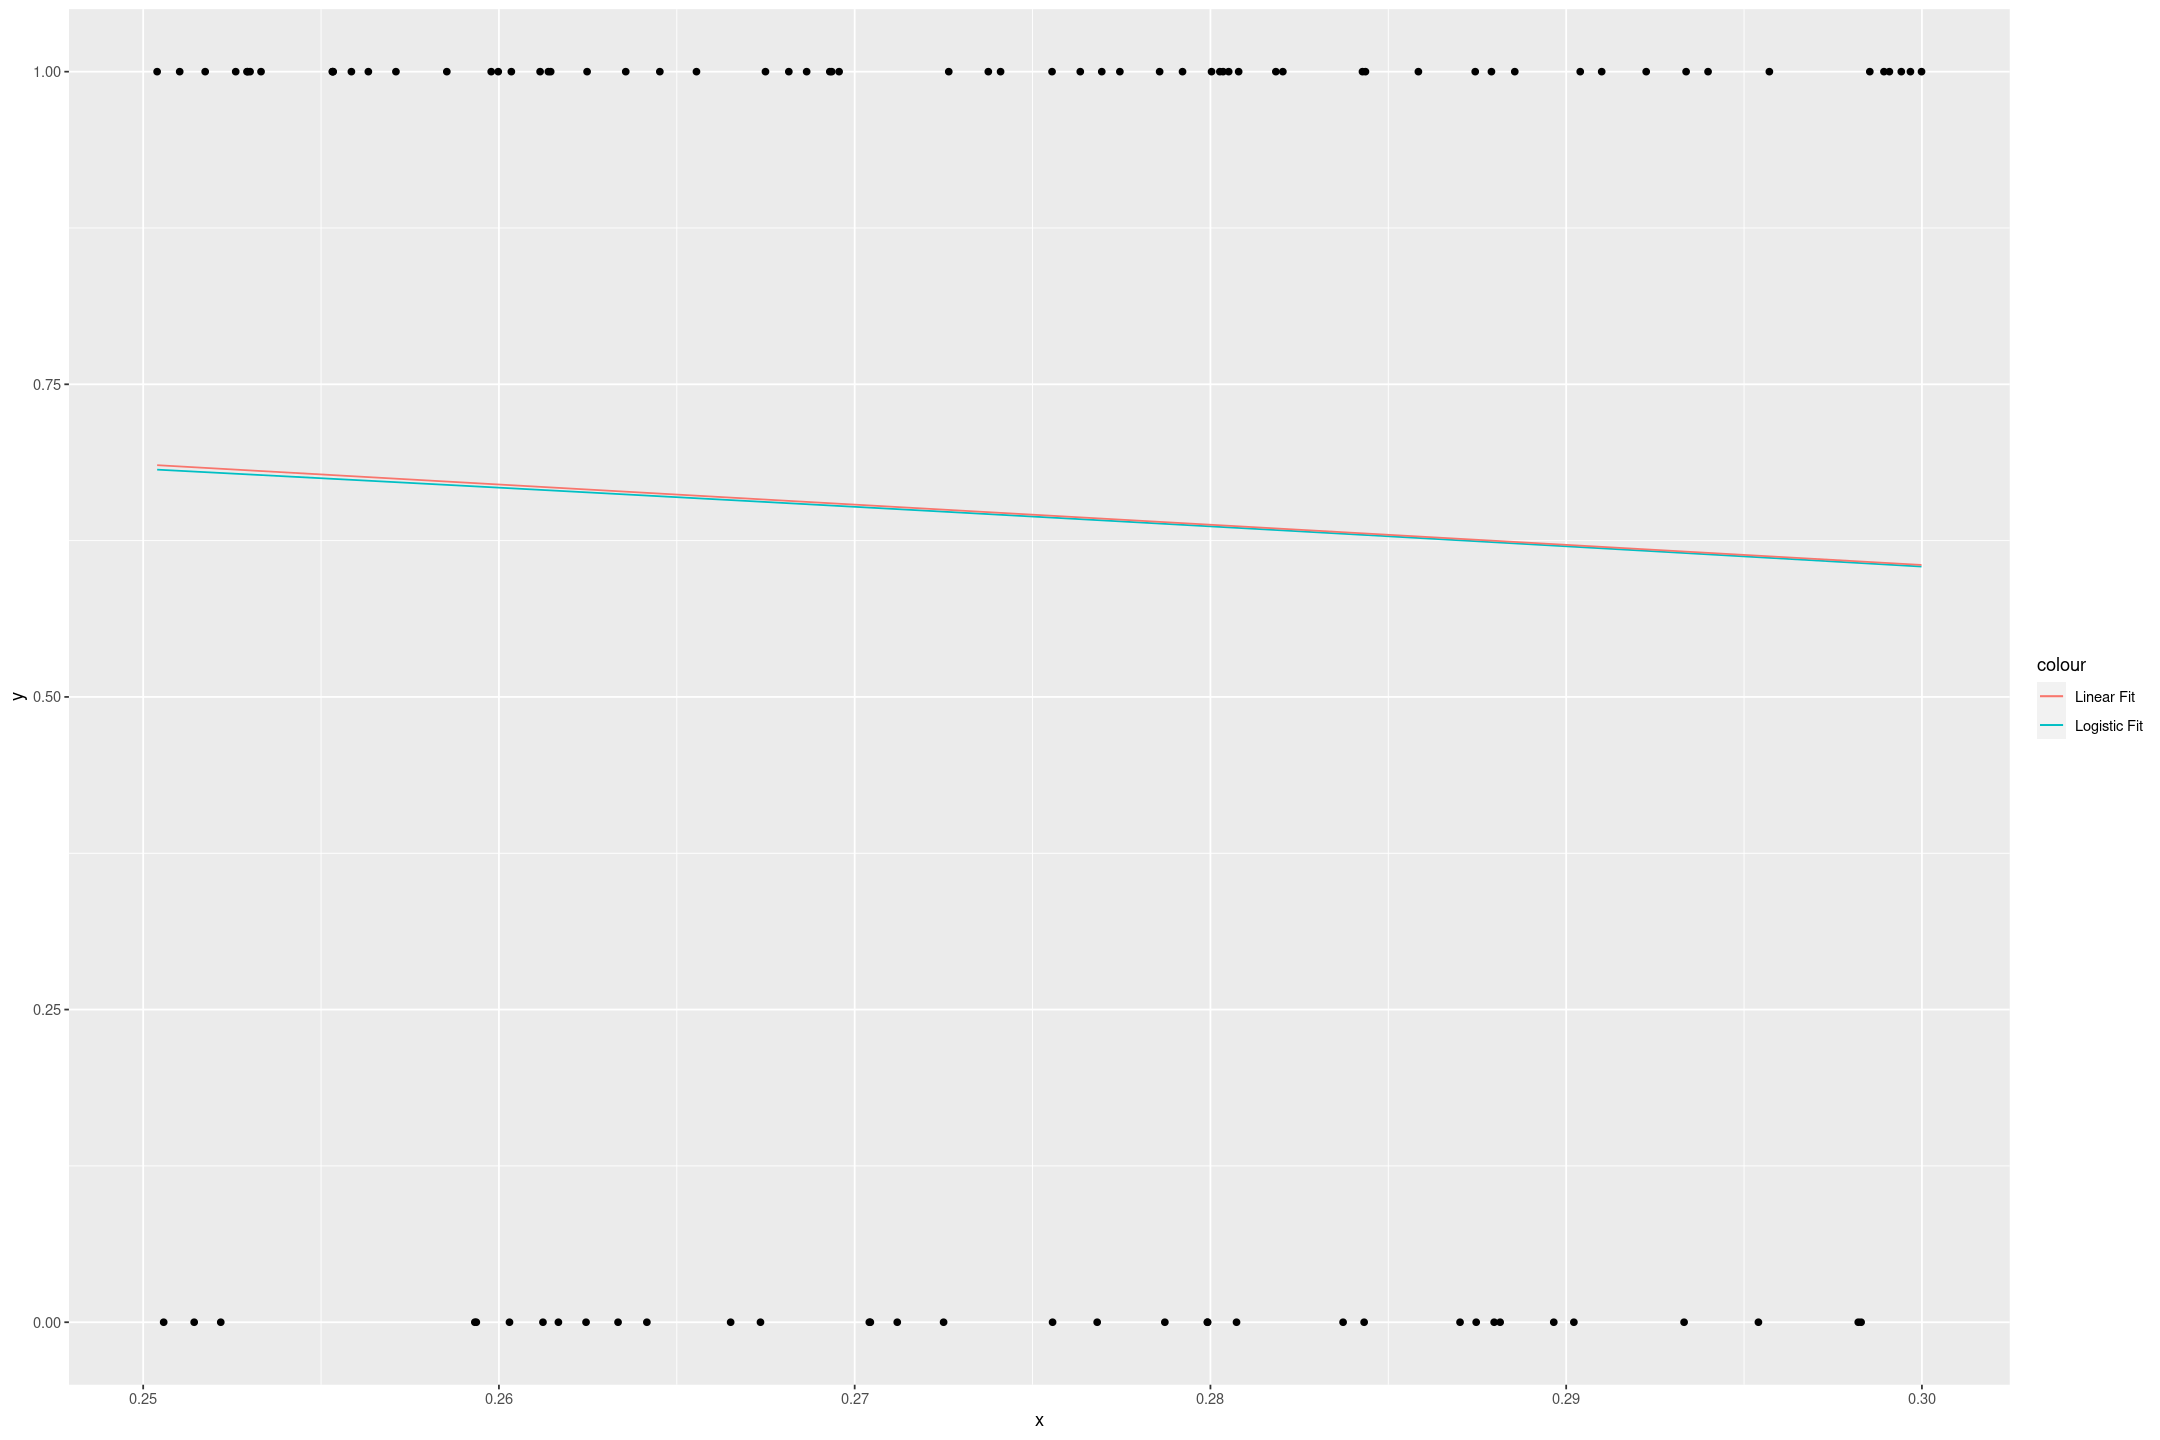

In [238]:
fake_data %>% 
mutate(binom_pred = predict(fake_model, type="response"),
       linear_pred = predict(fake_linear_model)) %>%
gf_point(y ~ x) %>%
gf_line(binom_pred ~ x, col=~"Logistic Fit") %>%
gf_line(linear_pred ~ x, col=~"Linear Fit")

The two are very close

In [239]:
mean(
    predict(fake_model, newdata=fake_data %>% mutate(x=x+0.005), type="response") -
    predict(fake_model, newdata=fake_data %>% mutate(x=x-0.005), type="response")
) / 0.01

[1] -1.563137

In [240]:
mean(
    predict(fake_model, newdata=fake_data %>% mutate(x=x+0.005), type="response") -
    predict(fake_model, newdata=fake_data %>% mutate(x=x-0.005), type="response")
) / 0.01

[1] -1.563137

## Example where logistic and linear are different

Set the parameters of your simulation so that the coefficient estimate and the average predictive comparison are much different.

However over a large range the models differ significantly

In [241]:
n <- 100
a <- 0
b <- 1
x0 <- rbinom(n, 1, 0.9)
x <- rnorm(n, 0, 2)
z <- a + b*x + rnorm(n, 0, 1)

y <- if_else(z > 0, 1, 0)
fake_data <- data.frame(x, y)

mean(y)

[1] 0.5

In [242]:
fake_model <- stan_glm(y ~ x, family=binomial(link='logit'), data=fake_data)

fake_linear_model <- stan_glm(y ~ x, data=fake_data)

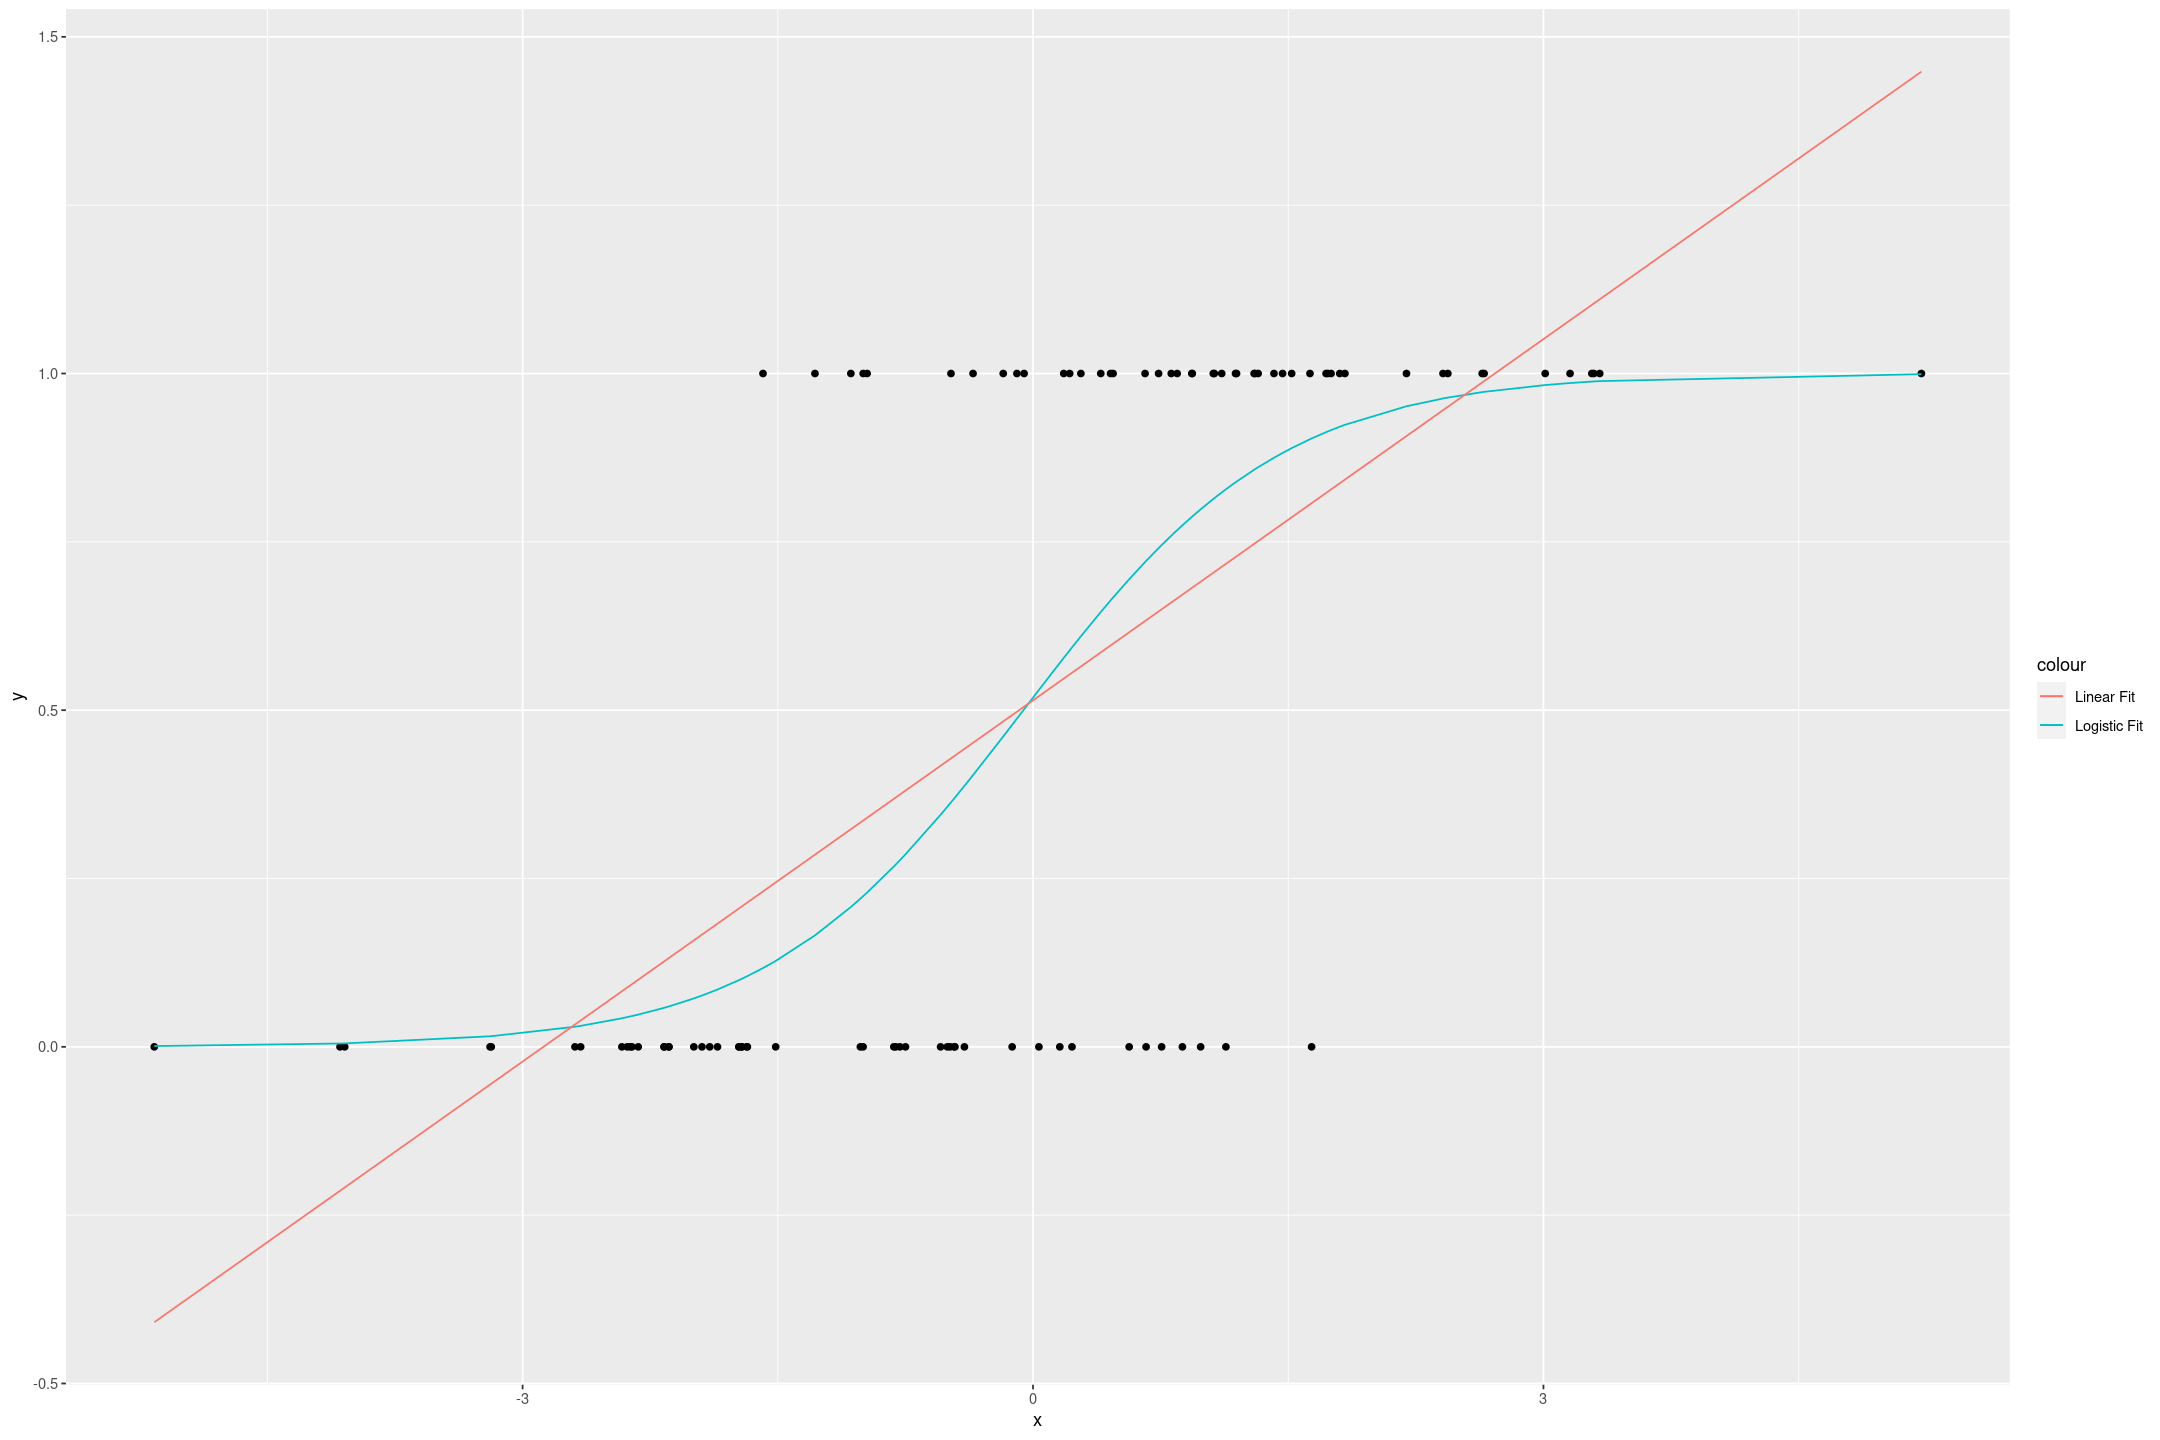

In [243]:
fake_data %>% 
mutate(binom_pred = predict(fake_model, type="response"),
       linear_pred = predict(fake_linear_model)) %>%
gf_point(y ~ x) %>%
gf_line(binom_pred ~ x, col=~"Logistic Fit") %>%
gf_line(linear_pred ~ x, col=~"Linear Fit")

However the *average* predictive comparisons, at least in terms of small perturbations.

In [244]:
mean(
    predict(fake_model, newdata=fake_data %>% mutate(x=x+0.005), type="response") -
    predict(fake_model, newdata=fake_data %>% mutate(x=x-0.005), type="response")
) / 0.01

[1] 0.166236

In [245]:
mean(
    predict(fake_model, newdata=fake_data %>% mutate(x=x+0.005), type="response") -
    predict(fake_model, newdata=fake_data %>% mutate(x=x-0.005), type="response")
) / 0.01

[1] 0.166236

## When is a linear model acceptable?

In general, when will it work reasonable well to fit a linear model to predict a binary outcome?

When the function is over such a small range that the linear approximation works well.
We could frame this in terms of a Taylor expansion.

Given:

$$ \frac{\rm d}{{\rm d} x} {\rm invlogit}(x) = \frac{e^{x}}{\left(1+e^{x}\right)^2} = {\rm invlogit}(x) (1 - {\rm invlogit}(x)) $$

$$ \frac{\rm d^2}{{\rm d} x^2} {\rm invlogit}(x) =  \frac{\rm d}{{\rm d} x} {\rm invlogit}(x) (1 - {\rm invlogit}(x)) $$

$$ \frac{\rm d^2}{{\rm d} x^2} {\rm invlogit}(x) =  {\rm invlogit}(x) (1 - {\rm invlogit}(x))^2 -  {\rm invlogit}(x)^2 (1 - {\rm invlogit}(x))$$

$$ \frac{\rm d^2}{{\rm d} x^2} {\rm invlogit}(x) =  {\rm invlogit}(x) (1 - {\rm invlogit}(x)) (1 - 2 {\rm invlogit}(x))$$

So $$ {\rm invlogit}(x + c) \approx {\rm invlogit}(x) + c\, {\rm invlogit}(x) (1 - {\rm invlogit}(x)) + c^2\, {\rm invlogit}(x) (1 - {\rm invlogit}(x)) (1 - 2 {\rm invlogit}(x)) + o(c^3)$$

So as long as this last term is small across the whole range of x the linear approximation works well.

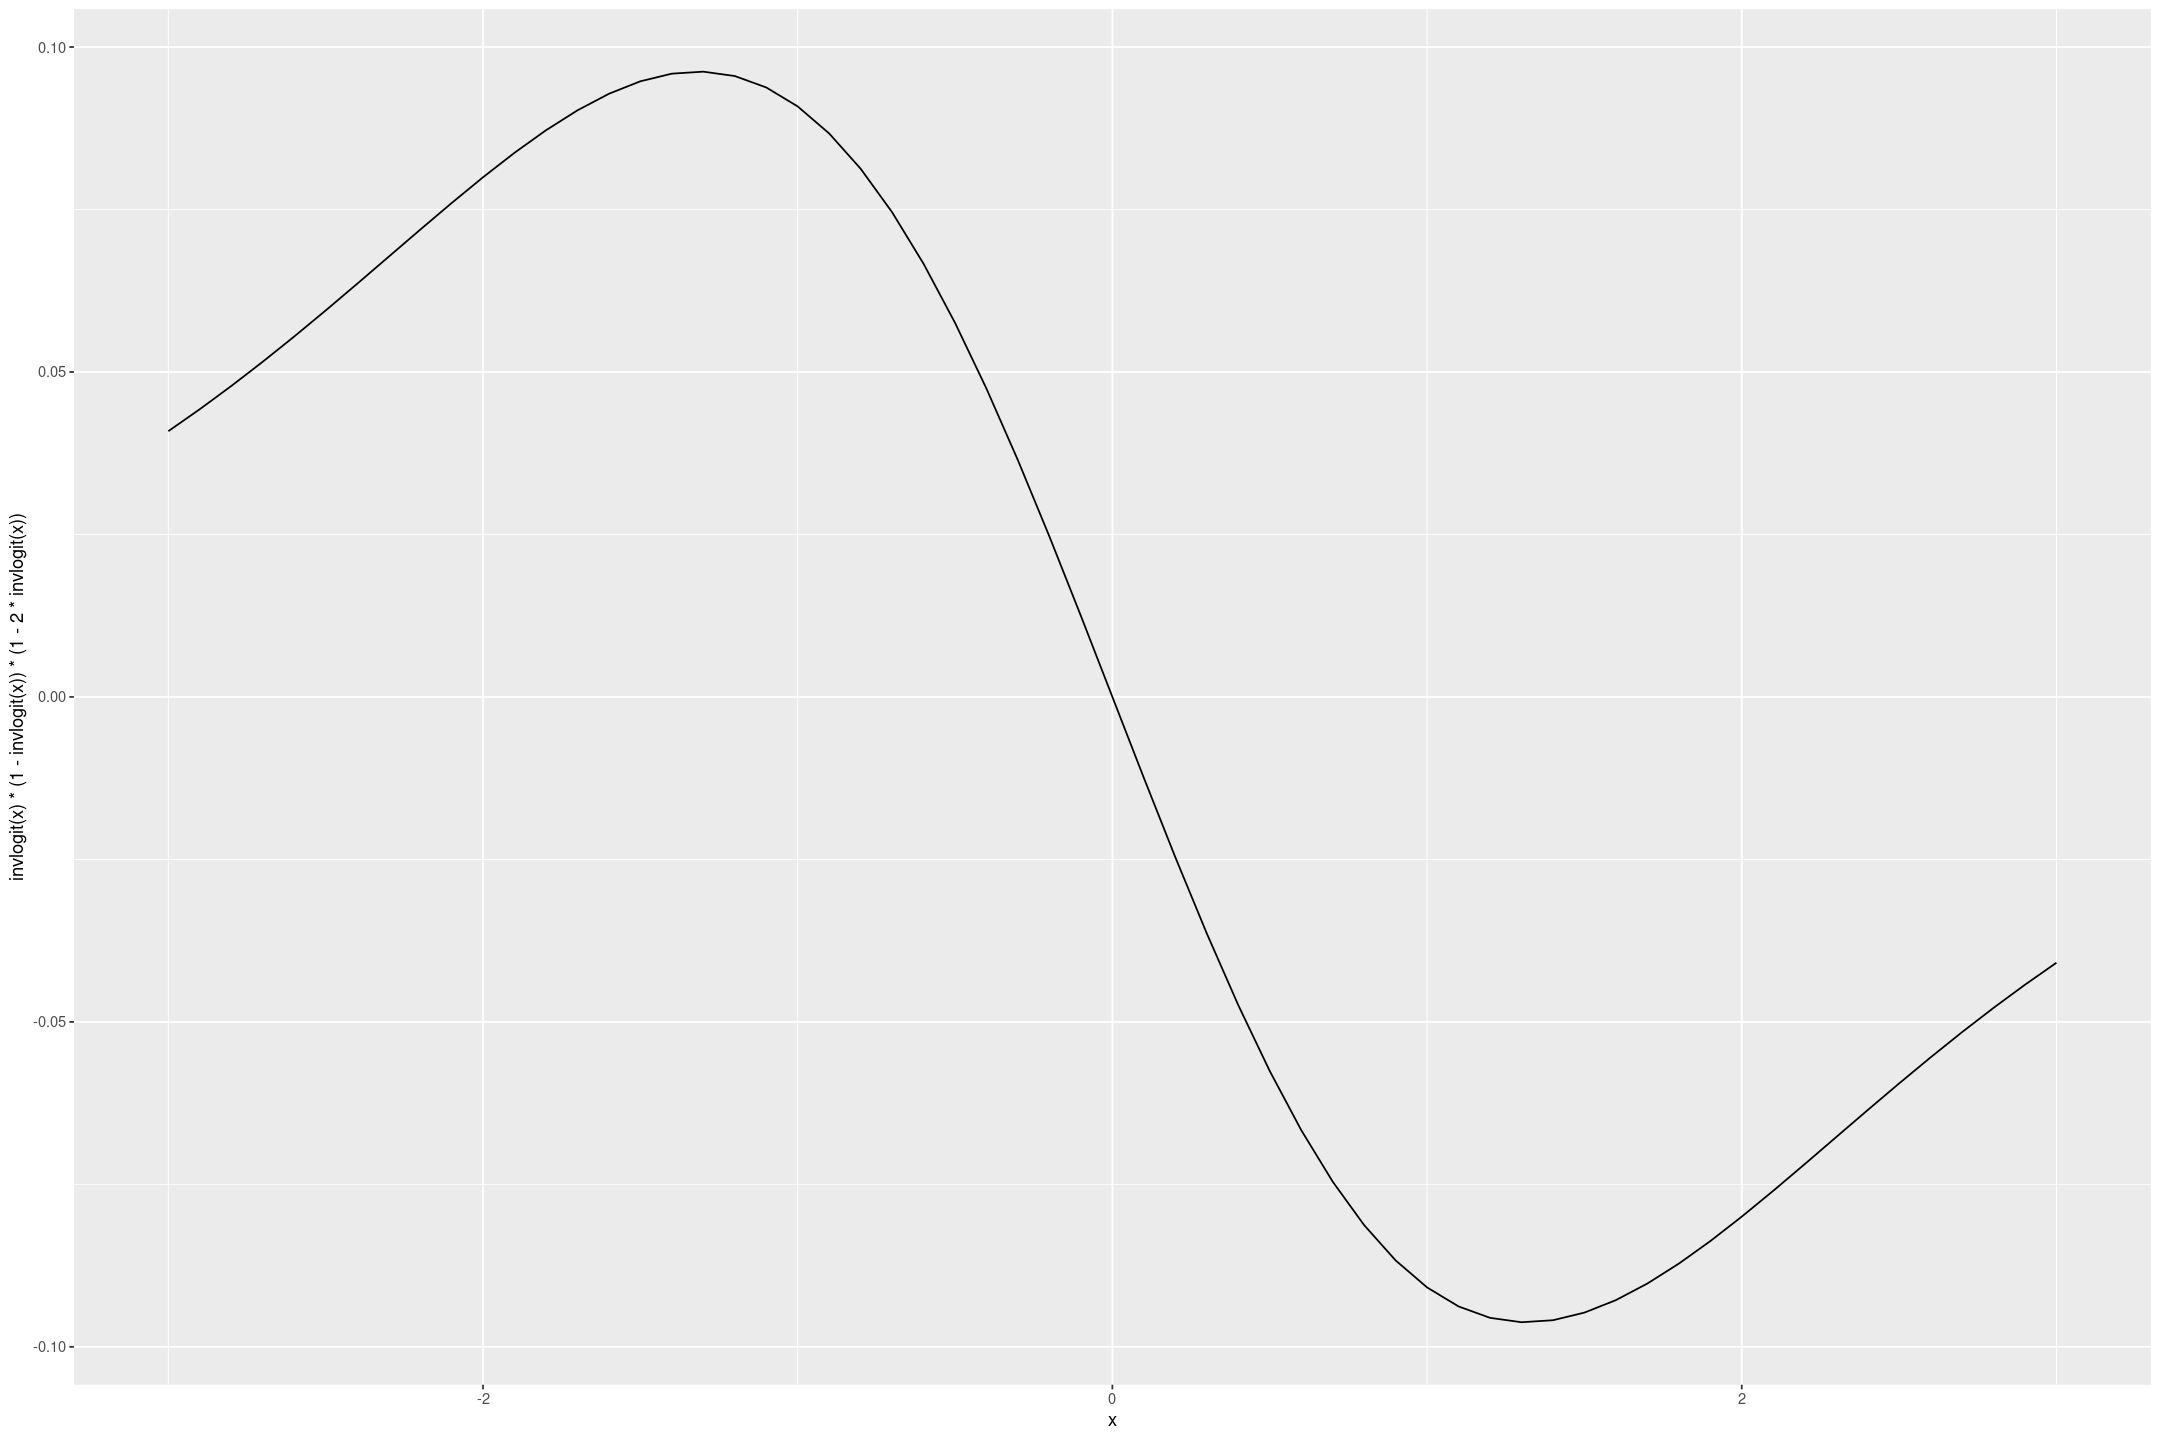

In [246]:
x <- seq(-3, 3, by=0.1)
gf_line(invlogit(x) * (1-invlogit(x)) * (1-2 * invlogit(x)) ~ x)